In [1]:
import os
import rasterio as rio
import utils
import numpy as np 
import pandas as pd
from rasterio.plot import reshape_as_raster, reshape_as_image
import geopandas as gpd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 10]

# settings
all_possible_classes = list(range(1, 18))
setups = ["non_weighted_set", "weighted_set"]
strategies = ["non_weighted_model", "weighted_model"]
folds = [0, 1, 2, 3, 4]

# Berlin

In [6]:
# load splited reference data
splited_ref_data = gpd.read_file(r'ref_data\berlin_ref_splitS2S3S4.gpkg')

## Non-weighted RF S1 morphometric subset

In [7]:
# load fused image with subset of morphometrics from non-weighted RF S1 models
non_weighted_set = r'imagery\berlin_20170519_morphometrics_meanminmax_grid.tif'

In [8]:
# results[setup][strategy][fold]
results = {
    setup: {
        strat: {
            fold: {} for fold in folds
        } for strat in strategies
    } for setup in setups
}

### Fold 0

In [9]:
fold = 0
test_polygons = splited_ref_data[splited_ref_data["fold"] == fold]
train_polygons = splited_ref_data[splited_ref_data["fold"] != fold]

In [10]:
train_polygons_raster = fr"berlin_train_f{fold}.tif"
test_polygons_raster = fr"berlin_test_f{fold}.tif"

utils.rasterize_reference_polygons(train_polygons, non_weighted_set, train_polygons_raster)
utils.rasterize_reference_polygons(test_polygons, non_weighted_set, test_polygons_raster)

In [11]:
with rio.open(non_weighted_set) as image_data:
    image_meta = image_data.meta
    image = image_data.read()

image_reshaped = rio.plot.reshape_as_image(image)
print(f'Image shape: {image.shape} -> {image_reshaped.shape}')

Image shape: (90, 638, 662) -> (638, 662, 90)


In [12]:
# train and test images matched to fusion 100m grid
train_image_matched = utils.match_rasters(train_polygons_raster, non_weighted_set)
test_image_matched = utils.match_rasters(test_polygons_raster, non_weighted_set)

train_image_matched = train_image_matched.to_numpy()
test_image_matched = test_image_matched.to_numpy()

C:\ProgramData\miniconda3\envs\geo\Lib\site-packages\xarray\core\duck_array_ops.py:250: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\ProgramData\miniconda3\envs\geo\Lib\site-packages\xarray\core\duck_array_ops.py:250: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


In [13]:
X_train = image_reshaped[train_image_matched > 0]
y_train = train_image_matched[train_image_matched > 0]
X_test = image_reshaped[test_image_matched > 0]
y_test = test_image_matched[test_image_matched > 0]

X_train[np.isinf(X_train)] = np.nan
X_test[np.isinf(X_test)] = np.nan

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(20056, 90) (20056,)
(4481, 90) (4481,)


#### Non/weighted RF model

In [ ]:
utils.finetune_height(X_train, y_train, X_test, y_test, max_height=10, class_weight=False)

In [ ]:
param, train, test, diff = utils.finetune_max_features(X_train, y_train, X_test, y_test, height=4, max_features=X_train.shape[1], class_weight=False)

In [34]:
param, train, test, diff

(2, 79.95, 78.93, 1.01)

In [14]:
model_fold0 = RandomForestClassifier(random_state=0, n_jobs=-1, max_depth=4, max_features=2, n_estimators=100)
model_fold0.fit(X_train, y_train)

RandomForestClassifier(max_depth=4, max_features=2, n_jobs=-1, random_state=0)

In [15]:
# training accuracy
pred_train = model_fold0.predict(X_train)
train_accuracy = accuracy_score(y_train, pred_train)
print('OA train: ', round(train_accuracy*100,2))
train_wf1 = f1_score(y_train, pred_train, average='weighted', labels=np.unique(y_train))
print('wF1 train: ', round(train_wf1*100,2))

OA train:  79.95
wF1 train:  73.98


In [16]:
# test accuracy
pred_test = model_fold0.predict(X_test)
test_accuracy = accuracy_score(y_test, pred_test)
print('OA test: ', round(test_accuracy*100,2))
test_wf1 = f1_score(y_test, pred_test, average='weighted', labels=np.unique(y_test))
print('wF1 test: ', round(test_wf1*100,2))

# F1U
X_test_urban = X_test[y_test<=10]
y_test_urban = y_test[y_test<=10]
y_test_pred_urb = model_fold0.predict(X_test_urban)
wf1_urb = f1_score(y_test_urban, y_test_pred_urb, average='weighted', labels=np.unique(y_test[y_test<=10]))
print('Urban wF1 test: ', round(wf1_urb*100,2))

# F1N
X_test_nat = X_test[y_test>10]
y_test_nat = y_test[y_test>10]
y_test_pred_nat = model_fold0.predict(X_test_nat)
wf1_nat = f1_score(y_test_nat, y_test_pred_nat, average='weighted', labels=np.unique(y_test[y_test>10]))
print('Natural wF1 test: ', round(wf1_nat*100,2))

conf_mat = confusion_matrix(y_test, pred_test, labels=sorted(splited_ref_data['gridcode'].unique()))

metrics = {
    "OA":  round(test_accuracy*100,2),
    "wF1": round(test_wf1*100,2),
    "F1U": round(wf1_urb*100,2),
    "F1N": round(wf1_nat*100,2),
    "Model": model_fold0,
    "Confusion_Matrix": conf_mat
}

for c in all_possible_classes:
    metrics[f"F1_Class_{c}"] = np.nan
f1_per_class_array = f1_score(y_test, pred_test, average=None, labels=np.unique(y_test))
for label, score in zip(np.unique(y_test), f1_per_class_array):
    if label in all_possible_classes:
        metrics[f"F1_Class_{int(label)}"] = round(score*100, 2)

results["non_weighted_set"]["non_weighted_model"][fold] = metrics

OA test:  78.93
wF1 test:  73.4
Urban wF1 test:  74.61
Natural wF1 test:  74.16


#### Weighted RF model

In [ ]:
utils.finetune_height(X_train, y_train, X_test, y_test, max_height=10, class_weight=True)

In [ ]:
param, train, test, diff = utils.finetune_max_features(X_train, y_train, X_test, y_test, height=4, max_features=X_train.shape[1], class_weight=True)

In [42]:
param, train, test, diff

(31, 58.17, 54.52, 3.65)

In [17]:
model_fold0_weighted = RandomForestClassifier(random_state=0, n_jobs=-1, max_depth=4, max_features=31, class_weight='balanced', n_estimators=100)
model_fold0_weighted.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=4, max_features=31,
                       n_jobs=-1, random_state=0)

In [18]:
# training accuracy
pred_train = model_fold0_weighted.predict(X_train)
train_accuracy = accuracy_score(y_train, pred_train)
print('OA train: ', round(train_accuracy*100,2))
train_wf1 = f1_score(y_train, pred_train, average='weighted', labels=np.unique(y_train))
print('wF1 train: ', round(train_wf1*100,2))

OA train:  58.17
wF1 train:  54.7


In [19]:
# test accuracy
pred_test = model_fold0_weighted.predict(X_test)
test_accuracy = accuracy_score(y_test, pred_test)
print('OA test: ', round(test_accuracy*100,2))
test_wf1 = f1_score(y_test, pred_test, average='weighted', labels=np.unique(y_test))
print('wF1 test: ', round(test_wf1*100,2))

# F1U
X_test_urban = X_test[y_test<=10]
y_test_urban = y_test[y_test<=10]
y_test_pred_urb = model_fold0_weighted.predict(X_test_urban)
wf1_urb = f1_score(y_test_urban, y_test_pred_urb, average='weighted', labels=np.unique(y_test[y_test<=10]))
print('Urban wF1 test: ', round(wf1_urb*100,2))

# F1N
X_test_nat = X_test[y_test>10]
y_test_nat = y_test[y_test>10]
y_test_pred_nat = model_fold0_weighted.predict(X_test_nat)
wf1_nat = f1_score(y_test_nat, y_test_pred_nat, average='weighted', labels=np.unique(y_test[y_test>10]))
print('Natural wF1 test: ', round(wf1_nat*100,2))

conf_mat = confusion_matrix(y_test, pred_test, labels=sorted(splited_ref_data['gridcode'].unique()))

metrics = {
    "OA":  round(test_accuracy*100,2),
    "wF1": round(test_wf1*100,2),
    "F1U": round(wf1_urb*100,2),
    "F1N": round(wf1_nat*100,2),
    "Model": model_fold0_weighted,
    "Confusion_Matrix": conf_mat
}

for c in all_possible_classes:
    metrics[f"F1_Class_{c}"] = np.nan
f1_per_class_array = f1_score(y_test, pred_test, average=None, labels=np.unique(y_test))
for label, score in zip(np.unique(y_test), f1_per_class_array):
    if label in all_possible_classes:
        metrics[f"F1_Class_{int(label)}"] = round(score*100, 2)

results["non_weighted_set"]["weighted_model"][fold] = metrics

OA test:  54.52
wF1 test:  52.58
Urban wF1 test:  51.21
Natural wF1 test:  54.8


### Fold 1

In [20]:
fold = 1
test_polygons = splited_ref_data[splited_ref_data["fold"] == fold]
train_polygons = splited_ref_data[splited_ref_data["fold"] != fold]

In [21]:
train_polygons_raster = fr"berlin_train_f{fold}.tif"
test_polygons_raster = fr"berlin_test_f{fold}.tif"

utils.rasterize_reference_polygons(train_polygons, non_weighted_set, train_polygons_raster)
utils.rasterize_reference_polygons(test_polygons, non_weighted_set, test_polygons_raster)

In [22]:
with rio.open(non_weighted_set) as image_data:
    image_meta = image_data.meta
    image = image_data.read()

image_reshaped = rio.plot.reshape_as_image(image)
print(f'Image shape: {image.shape} -> {image_reshaped.shape}')

Image shape: (90, 638, 662) -> (638, 662, 90)


In [23]:
# train and test images matched to fusion 100m grid
train_image_matched = utils.match_rasters(train_polygons_raster, non_weighted_set)
test_image_matched = utils.match_rasters(test_polygons_raster, non_weighted_set)

train_image_matched = train_image_matched.to_numpy()
test_image_matched = test_image_matched.to_numpy()

C:\ProgramData\miniconda3\envs\geo\Lib\site-packages\xarray\core\duck_array_ops.py:250: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\ProgramData\miniconda3\envs\geo\Lib\site-packages\xarray\core\duck_array_ops.py:250: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


In [24]:
X_train = image_reshaped[train_image_matched > 0]
y_train = train_image_matched[train_image_matched > 0]
X_test = image_reshaped[test_image_matched > 0]
y_test = test_image_matched[test_image_matched > 0]

X_train[np.isinf(X_train)] = np.nan
X_test[np.isinf(X_test)] = np.nan

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(18865, 90) (18865,)
(5672, 90) (5672,)


#### Non/weighted RF model

In [ ]:
utils.finetune_height(X_train, y_train, X_test, y_test, max_height=10, class_weight=False)

In [ ]:
param, train, test, diff = utils.finetune_max_features(X_train, y_train, X_test, y_test, height=4, max_features=X_train.shape[1], class_weight=False)

In [ ]:
param, train, test, diff

In [25]:
model_fold1 = RandomForestClassifier(random_state=0, n_jobs=-1, max_depth=4, max_features=1, n_estimators=100)
model_fold1.fit(X_train, y_train)

RandomForestClassifier(max_depth=4, max_features=1, n_jobs=-1, random_state=0)

In [26]:
# training accuracy
pred_train = model_fold1.predict(X_train)
train_accuracy = accuracy_score(y_train, pred_train)
print('OA train: ', round(train_accuracy*100,2))
train_wf1 = f1_score(y_train, pred_train, average='weighted', labels=np.unique(y_train))
print('wF1 train: ', round(train_wf1*100,2))

OA train:  78.62
wF1 train:  72.6


In [27]:
# test accuracy
pred_test = model_fold1.predict(X_test)
test_accuracy = accuracy_score(y_test, pred_test)
print('OA test: ', round(test_accuracy*100,2))
test_wf1 = f1_score(y_test, pred_test, average='weighted', labels=np.unique(y_test))
print('wF1 test: ', round(test_wf1*100,2))

# F1U
X_test_urban = X_test[y_test<=10]
y_test_urban = y_test[y_test<=10]
y_test_pred_urb = model_fold1.predict(X_test_urban)
wf1_urb = f1_score(y_test_urban, y_test_pred_urb, average='weighted', labels=np.unique(y_test[y_test<=10]))
print('Urban wF1 test: ', round(wf1_urb*100,2))

# F1N
X_test_nat = X_test[y_test>10]
y_test_nat = y_test[y_test>10]
y_test_pred_nat = model_fold1.predict(X_test_nat)
wf1_nat = f1_score(y_test_nat, y_test_pred_nat, average='weighted', labels=np.unique(y_test[y_test>10]))
print('Natural wF1 test: ', round(wf1_nat*100,2))

conf_mat = confusion_matrix(y_test, pred_test, labels=sorted(splited_ref_data['gridcode'].unique()))

metrics = {
    "OA":  round(test_accuracy*100,2),
    "wF1": round(test_wf1*100,2),
    "F1U": round(wf1_urb*100,2),
    "F1N": round(wf1_nat*100,2),
    "Model": model_fold1,
    "Confusion_Matrix": conf_mat
}

for c in all_possible_classes:
    metrics[f"F1_Class_{c}"] = np.nan
f1_per_class_array = f1_score(y_test, pred_test, average=None, labels=np.unique(y_test))
for label, score in zip(np.unique(y_test), f1_per_class_array):
    if label in all_possible_classes:
        metrics[f"F1_Class_{int(label)}"] = round(score*100, 2)

results["non_weighted_set"]["non_weighted_model"][fold] = metrics

OA test:  73.29
wF1 test:  66.52
Urban wF1 test:  64.39
Natural wF1 test:  69.07


#### Weighted RF model

In [ ]:
utils.finetune_height(X_train, y_train, X_test, y_test, max_height=10, class_weight=True)

In [ ]:
param, train, test, diff = utils.finetune_max_features(X_train, y_train, X_test, y_test, height=3, max_features=X_train.shape[1], class_weight=True)

In [ ]:
param, train, test, diff

In [28]:
model_fold1_weighted = RandomForestClassifier(random_state=0, n_jobs=-1, max_depth=3, max_features=2, class_weight='balanced', n_estimators=100)
model_fold1_weighted.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=3, max_features=2,
                       n_jobs=-1, random_state=0)

In [29]:
# training accuracy
pred_train = model_fold1_weighted.predict(X_train)
train_accuracy = accuracy_score(y_train, pred_train)
print('OA train: ', round(train_accuracy*100,2))
train_wf1 = f1_score(y_train, pred_train, average='weighted', labels=np.unique(y_train))
print('wF1 train: ', round(train_wf1*100,2))

OA train:  70.5
wF1 train:  67.96


In [30]:
# test accuracy
pred_test = model_fold1_weighted.predict(X_test)
test_accuracy = accuracy_score(y_test, pred_test)
print('OA test: ', round(test_accuracy*100,2))
test_wf1 = f1_score(y_test, pred_test, average='weighted', labels=np.unique(y_test))
print('wF1 test: ', round(test_wf1*100,2))

# F1U
X_test_urban = X_test[y_test<=10]
y_test_urban = y_test[y_test<=10]
y_test_pred_urb = model_fold1_weighted.predict(X_test_urban)
wf1_urb = f1_score(y_test_urban, y_test_pred_urb, average='weighted', labels=np.unique(y_test[y_test<=10]))
print('Urban wF1 test: ', round(wf1_urb*100,2))

# F1N
X_test_nat = X_test[y_test>10]
y_test_nat = y_test[y_test>10]
y_test_pred_nat = model_fold1_weighted.predict(X_test_nat)
wf1_nat = f1_score(y_test_nat, y_test_pred_nat, average='weighted', labels=np.unique(y_test[y_test>10]))
print('Natural wF1 test: ', round(wf1_nat*100,2))

conf_mat = confusion_matrix(y_test, pred_test, labels=sorted(splited_ref_data['gridcode'].unique()))

metrics = {
    "OA":  round(test_accuracy*100,2),
    "wF1": round(test_wf1*100,2),
    "F1U": round(wf1_urb*100,2),
    "F1N": round(wf1_nat*100,2),
    "Model": model_fold1_weighted,
    "Confusion_Matrix": conf_mat
}

for c in all_possible_classes:
    metrics[f"F1_Class_{c}"] = np.nan
f1_per_class_array = f1_score(y_test, pred_test, average=None, labels=np.unique(y_test))
for label, score in zip(np.unique(y_test), f1_per_class_array):
    if label in all_possible_classes:
        metrics[f"F1_Class_{int(label)}"] = round(score*100, 2)

results["non_weighted_set"]["weighted_model"][fold] = metrics

OA test:  68.02
wF1 test:  66.36
Urban wF1 test:  66.37
Natural wF1 test:  67.09


### Fold 2

In [31]:
fold = 2
test_polygons = splited_ref_data[splited_ref_data["fold"] == fold]
train_polygons = splited_ref_data[splited_ref_data["fold"] != fold]

In [32]:
train_polygons_raster = fr"berlin_train_f{fold}.tif"
test_polygons_raster = fr"berlin_test_f{fold}.tif"

utils.rasterize_reference_polygons(train_polygons, non_weighted_set, train_polygons_raster)
utils.rasterize_reference_polygons(test_polygons, non_weighted_set, test_polygons_raster)

In [33]:
with rio.open(non_weighted_set) as image_data:
    image_meta = image_data.meta
    image = image_data.read()

image_reshaped = rio.plot.reshape_as_image(image)
print(f'Image shape: {image.shape} -> {image_reshaped.shape}')

Image shape: (90, 638, 662) -> (638, 662, 90)


In [34]:
# train and test images matched to fusion 100m grid
train_image_matched = utils.match_rasters(train_polygons_raster, non_weighted_set)
test_image_matched = utils.match_rasters(test_polygons_raster, non_weighted_set)

train_image_matched = train_image_matched.to_numpy()
test_image_matched = test_image_matched.to_numpy()

C:\ProgramData\miniconda3\envs\geo\Lib\site-packages\xarray\core\duck_array_ops.py:250: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\ProgramData\miniconda3\envs\geo\Lib\site-packages\xarray\core\duck_array_ops.py:250: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


In [35]:
X_train = image_reshaped[train_image_matched > 0]
y_train = train_image_matched[train_image_matched > 0]
X_test = image_reshaped[test_image_matched > 0]
y_test = test_image_matched[test_image_matched > 0]

X_train[np.isinf(X_train)] = np.nan
X_test[np.isinf(X_test)] = np.nan

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(19711, 90) (19711,)
(4826, 90) (4826,)


#### Non/weighted RF model

In [ ]:
utils.finetune_height(X_train, y_train, X_test, y_test, max_height=10, class_weight=False)

In [ ]:
param, train, test, diff = utils.finetune_max_features(X_train, y_train, X_test, y_test, height=7, max_features=X_train.shape[1], class_weight=False)

In [76]:
param, train, test, diff

(6, 87.33, 82.49, 4.84)

In [36]:
model_fold2 = RandomForestClassifier(random_state=0, n_jobs=-1, max_depth=7, max_features=6, n_estimators=100)
model_fold2.fit(X_train, y_train)

RandomForestClassifier(max_depth=7, max_features=6, n_jobs=-1, random_state=0)

In [37]:
# training accuracy
pred_train = model_fold2.predict(X_train)
train_accuracy = accuracy_score(y_train, pred_train)
print('OA train: ', round(train_accuracy*100,2))
train_wf1 = f1_score(y_train, pred_train, average='weighted', labels=np.unique(y_train))
print('wF1 train: ', round(train_wf1*100,2))

OA train:  87.33
wF1 train:  84.84


In [38]:
# test accuracy
pred_test = model_fold2.predict(X_test)
test_accuracy = accuracy_score(y_test, pred_test)
print('OA test: ', round(test_accuracy*100,2))
test_wf1 = f1_score(y_test, pred_test, average='weighted', labels=np.unique(y_test))
print('wF1 test: ', round(test_wf1*100,2))

# F1U
X_test_urban = X_test[y_test<=10]
y_test_urban = y_test[y_test<=10]
y_test_pred_urb = model_fold2.predict(X_test_urban)
wf1_urb = f1_score(y_test_urban, y_test_pred_urb, average='weighted', labels=np.unique(y_test[y_test<=10]))
print('Urban wF1 test: ', round(wf1_urb*100,2))

# F1N
X_test_nat = X_test[y_test>10]
y_test_nat = y_test[y_test>10]
y_test_pred_nat = model_fold2.predict(X_test_nat)
wf1_nat = f1_score(y_test_nat, y_test_pred_nat, average='weighted', labels=np.unique(y_test[y_test>10]))
print('Natural wF1 test: ', round(wf1_nat*100,2))

conf_mat = confusion_matrix(y_test, pred_test, labels=sorted(splited_ref_data['gridcode'].unique()))

metrics = {
    "OA":  round(test_accuracy*100,2),
    "wF1": round(test_wf1*100,2),
    "F1U": round(wf1_urb*100,2),
    "F1N": round(wf1_nat*100,2),
    "Model": model_fold2,
    "Confusion_Matrix": conf_mat
}

for c in all_possible_classes:
    metrics[f"F1_Class_{c}"] = np.nan
f1_per_class_array = f1_score(y_test, pred_test, average=None, labels=np.unique(y_test))
for label, score in zip(np.unique(y_test), f1_per_class_array):
    if label in all_possible_classes:
        metrics[f"F1_Class_{int(label)}"] = round(score*100, 2)

results["non_weighted_set"]["non_weighted_model"][fold] = metrics

OA test:  82.49
wF1 test:  78.91
Urban wF1 test:  76.58
Natural wF1 test:  81.78


#### Weighted RF model

In [ ]:
utils.finetune_height(X_train, y_train, X_test, y_test, max_height=10, class_weight=True)

In [ ]:
param, train, test, diff = utils.finetune_max_features(X_train, y_train, X_test, y_test, height=8, max_features=X_train.shape[1], class_weight=True)

In [87]:
param, train, test, diff

(5, 86.05, 83.01, 3.04)

In [39]:
model_fold2_weighted = RandomForestClassifier(random_state=0, n_jobs=-1, max_depth=8, max_features=5, class_weight='balanced', n_estimators=100)
model_fold2_weighted.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=8, max_features=5,
                       n_jobs=-1, random_state=0)

In [40]:
# training accuracy
pred_train = model_fold2_weighted.predict(X_train)
train_accuracy = accuracy_score(y_train, pred_train)
print('OA train: ', round(train_accuracy*100,2))
train_wf1 = f1_score(y_train, pred_train, average='weighted', labels=np.unique(y_train))
print('wF1 train: ', round(train_wf1*100,2))

OA train:  86.05
wF1 train:  87.04


In [41]:
# test accuracy
pred_test = model_fold2_weighted.predict(X_test)
test_accuracy = accuracy_score(y_test, pred_test)
print('OA test: ', round(test_accuracy*100,2))
test_wf1 = f1_score(y_test, pred_test, average='weighted', labels=np.unique(y_test))
print('wF1 test: ', round(test_wf1*100,2))

# F1U
X_test_urban = X_test[y_test<=10]
y_test_urban = y_test[y_test<=10]
y_test_pred_urb = model_fold2_weighted.predict(X_test_urban)
wf1_urb = f1_score(y_test_urban, y_test_pred_urb, average='weighted', labels=np.unique(y_test[y_test<=10]))
print('Urban wF1 test: ', round(wf1_urb*100,2))

# F1N
X_test_nat = X_test[y_test>10]
y_test_nat = y_test[y_test>10]
y_test_pred_nat = model_fold2_weighted.predict(X_test_nat)
wf1_nat = f1_score(y_test_nat, y_test_pred_nat, average='weighted', labels=np.unique(y_test[y_test>10]))
print('Natural wF1 test: ', round(wf1_nat*100,2))

conf_mat = confusion_matrix(y_test, pred_test, labels=sorted(splited_ref_data['gridcode'].unique()))

metrics = {
    "OA":  round(test_accuracy*100,2),
    "wF1": round(test_wf1*100,2),
    "F1U": round(wf1_urb*100,2),
    "F1N": round(wf1_nat*100,2),
    "Model": model_fold2_weighted,
    "Confusion_Matrix": conf_mat
}

for c in all_possible_classes:
    metrics[f"F1_Class_{c}"] = np.nan
f1_per_class_array = f1_score(y_test, pred_test, average=None, labels=np.unique(y_test))
for label, score in zip(np.unique(y_test), f1_per_class_array):
    if label in all_possible_classes:
        metrics[f"F1_Class_{int(label)}"] = round(score*100, 2)

results["non_weighted_set"]["weighted_model"][fold] = metrics

OA test:  83.01
wF1 test:  82.39
Urban wF1 test:  77.45
Natural wF1 test:  87.36


### Fold 3

In [42]:
fold = 3
test_polygons = splited_ref_data[splited_ref_data["fold"] == fold]
train_polygons = splited_ref_data[splited_ref_data["fold"] != fold]

In [43]:
train_polygons_raster = fr"berlin_train_f{fold}.tif"
test_polygons_raster = fr"berlin_test_f{fold}.tif"

utils.rasterize_reference_polygons(train_polygons, non_weighted_set, train_polygons_raster)
utils.rasterize_reference_polygons(test_polygons, non_weighted_set, test_polygons_raster)

In [44]:
with rio.open(non_weighted_set) as image_data:
    image_meta = image_data.meta
    image = image_data.read()

image_reshaped = rio.plot.reshape_as_image(image)
print(f'Image shape: {image.shape} -> {image_reshaped.shape}')

Image shape: (90, 638, 662) -> (638, 662, 90)


In [45]:
# train and test images matched to fusion 100m grid
train_image_matched = utils.match_rasters(train_polygons_raster, non_weighted_set)
test_image_matched = utils.match_rasters(test_polygons_raster, non_weighted_set)

train_image_matched = train_image_matched.to_numpy()
test_image_matched = test_image_matched.to_numpy()

C:\ProgramData\miniconda3\envs\geo\Lib\site-packages\xarray\core\duck_array_ops.py:250: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\ProgramData\miniconda3\envs\geo\Lib\site-packages\xarray\core\duck_array_ops.py:250: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


In [46]:
X_train = image_reshaped[train_image_matched > 0]
y_train = train_image_matched[train_image_matched > 0]
X_test = image_reshaped[test_image_matched > 0]
y_test = test_image_matched[test_image_matched > 0]

X_train[np.isinf(X_train)] = np.nan
X_test[np.isinf(X_test)] = np.nan

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(19697, 90) (19697,)
(4840, 90) (4840,)


#### Non/weighted RF model

In [ ]:
utils.finetune_height(X_train, y_train, X_test, y_test, max_height=10, class_weight=False)

In [ ]:
param, train, test, diff = utils.finetune_max_features(X_train, y_train, X_test, y_test, height=7, max_features=X_train.shape[1], class_weight=False)

In [95]:
param, train, test, diff

(69, 89.65, 85.02, 4.63)

In [47]:
model_fold3 = RandomForestClassifier(random_state=0, n_jobs=-1, max_depth=7, max_features=69, n_estimators=100)
model_fold3.fit(X_train, y_train)

RandomForestClassifier(max_depth=7, max_features=69, n_jobs=-1, random_state=0)

In [48]:
# training accuracy
pred_train = model_fold3.predict(X_train)
train_accuracy = accuracy_score(y_train, pred_train)
print('OA train: ', round(train_accuracy*100,2))
train_wf1 = f1_score(y_train, pred_train, average='weighted', labels=np.unique(y_train))
print('wF1 train: ', round(train_wf1*100,2))

OA train:  89.65
wF1 train:  88.72


In [49]:
# test accuracy
pred_test = model_fold3.predict(X_test)
test_accuracy = accuracy_score(y_test, pred_test)
print('OA test: ', round(test_accuracy*100,2))
test_wf1 = f1_score(y_test, pred_test, average='weighted', labels=np.unique(y_test))
print('wF1 test: ', round(test_wf1*100,2))

# F1U
X_test_urban = X_test[y_test<=10]
y_test_urban = y_test[y_test<=10]
y_test_pred_urb = model_fold3.predict(X_test_urban)
wf1_urb = f1_score(y_test_urban, y_test_pred_urb, average='weighted', labels=np.unique(y_test[y_test<=10]))
print('Urban wF1 test: ', round(wf1_urb*100,2))

# F1N
X_test_nat = X_test[y_test>10]
y_test_nat = y_test[y_test>10]
y_test_pred_nat = model_fold3.predict(X_test_nat)
wf1_nat = f1_score(y_test_nat, y_test_pred_nat, average='weighted', labels=np.unique(y_test[y_test>10]))
print('Natural wF1 test: ', round(wf1_nat*100,2))

conf_mat = confusion_matrix(y_test, pred_test, labels=sorted(splited_ref_data['gridcode'].unique()))

metrics = {
    "OA":  round(test_accuracy*100,2),
    "wF1": round(test_wf1*100,2),
    "F1U": round(wf1_urb*100,2),
    "F1N": round(wf1_nat*100,2),
    "Model": model_fold3,
    "Confusion_Matrix": conf_mat
}

for c in all_possible_classes:
    metrics[f"F1_Class_{c}"] = np.nan
f1_per_class_array = f1_score(y_test, pred_test, average=None, labels=np.unique(y_test))
for label, score in zip(np.unique(y_test), f1_per_class_array):
    if label in all_possible_classes:
        metrics[f"F1_Class_{int(label)}"] = round(score*100, 2)

results["non_weighted_set"]["non_weighted_model"][fold] = metrics

OA test:  85.02
wF1 test:  82.16
Urban wF1 test:  87.84
Natural wF1 test:  77.25


#### Weighted RF model

In [ ]:
utils.finetune_height(X_train, y_train, X_test, y_test, max_height=10, class_weight=True)

In [ ]:
param, train, test, diff = utils.finetune_max_features(X_train, y_train, X_test, y_test, height=9, max_features=X_train.shape[1], class_weight=True)

In [102]:
param, train, test, diff

(11, 88.6, 84.79, 3.8)

In [50]:
model_fold3_weighted = RandomForestClassifier(random_state=0, n_jobs=-1, max_depth=9, max_features=11, class_weight='balanced', n_estimators=100)
model_fold3_weighted.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=9, max_features=11,
                       n_jobs=-1, random_state=0)

In [51]:
# training accuracy
pred_train = model_fold3_weighted.predict(X_train)
train_accuracy = accuracy_score(y_train, pred_train)
print('OA train: ', round(train_accuracy*100,2))
train_wf1 = f1_score(y_train, pred_train, average='weighted', labels=np.unique(y_train))
print('wF1 train: ', round(train_wf1*100,2))

OA train:  88.6
wF1 train:  89.28


In [52]:
# test accuracy
pred_test = model_fold3_weighted.predict(X_test)
test_accuracy = accuracy_score(y_test, pred_test)
print('OA test: ', round(test_accuracy*100,2))
test_wf1 = f1_score(y_test, pred_test, average='weighted', labels=np.unique(y_test))
print('wF1 test: ', round(test_wf1*100,2))

# F1U
X_test_urban = X_test[y_test<=10]
y_test_urban = y_test[y_test<=10]
y_test_pred_urb = model_fold3_weighted.predict(X_test_urban)
wf1_urb = f1_score(y_test_urban, y_test_pred_urb, average='weighted', labels=np.unique(y_test[y_test<=10]))
print('Urban wF1 test: ', round(wf1_urb*100,2))

# F1N
X_test_nat = X_test[y_test>10]
y_test_nat = y_test[y_test>10]
y_test_pred_nat = model_fold3_weighted.predict(X_test_nat)
wf1_nat = f1_score(y_test_nat, y_test_pred_nat, average='weighted', labels=np.unique(y_test[y_test>10]))
print('Natural wF1 test: ', round(wf1_nat*100,2))

conf_mat = confusion_matrix(y_test, pred_test, labels=sorted(splited_ref_data['gridcode'].unique()))

metrics = {
    "OA":  round(test_accuracy*100,2),
    "wF1": round(test_wf1*100,2),
    "F1U": round(wf1_urb*100,2),
    "F1N": round(wf1_nat*100,2),
    "Model": model_fold3_weighted,
    "Confusion_Matrix": conf_mat
}

for c in all_possible_classes:
    metrics[f"F1_Class_{c}"] = np.nan
f1_per_class_array = f1_score(y_test, pred_test, average=None, labels=np.unique(y_test))
for label, score in zip(np.unique(y_test), f1_per_class_array):
    if label in all_possible_classes:
        metrics[f"F1_Class_{int(label)}"] = round(score*100, 2)

results["non_weighted_set"]["weighted_model"][fold] = metrics

OA test:  84.79
wF1 test:  84.69
Urban wF1 test:  84.06
Natural wF1 test:  85.31


### Fold 4

In [53]:
fold = 4
test_polygons = splited_ref_data[splited_ref_data["fold"] == fold]
train_polygons = splited_ref_data[splited_ref_data["fold"] != fold]

In [54]:
train_polygons_raster = fr"berlin_train_f{fold}.tif"
test_polygons_raster = fr"berlin_test_f{fold}.tif"

utils.rasterize_reference_polygons(train_polygons, non_weighted_set, train_polygons_raster)
utils.rasterize_reference_polygons(test_polygons, non_weighted_set, test_polygons_raster)

In [55]:
with rio.open(non_weighted_set) as image_data:
    image_meta = image_data.meta
    image = image_data.read()

image_reshaped = rio.plot.reshape_as_image(image)
print(f'Image shape: {image.shape} -> {image_reshaped.shape}')

Image shape: (90, 638, 662) -> (638, 662, 90)


In [57]:
# train and test images matched to fusion 100m grid
train_image_matched = utils.match_rasters(train_polygons_raster, non_weighted_set)
test_image_matched = utils.match_rasters(test_polygons_raster, non_weighted_set)

train_image_matched = train_image_matched.to_numpy()
test_image_matched = test_image_matched.to_numpy()

C:\ProgramData\miniconda3\envs\geo\Lib\site-packages\xarray\core\duck_array_ops.py:250: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\ProgramData\miniconda3\envs\geo\Lib\site-packages\xarray\core\duck_array_ops.py:250: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


In [58]:
X_train = image_reshaped[train_image_matched > 0]
y_train = train_image_matched[train_image_matched > 0]
X_test = image_reshaped[test_image_matched > 0]
y_test = test_image_matched[test_image_matched > 0]

X_train[np.isinf(X_train)] = np.nan
X_test[np.isinf(X_test)] = np.nan

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(19819, 90) (19819,)
(4718, 90) (4718,)


#### Non/weighted RF model

In [ ]:
utils.finetune_height(X_train, y_train, X_test, y_test, max_height=10, class_weight=False)

In [ ]:
param, train, test, diff = utils.finetune_max_features(X_train, y_train, X_test, y_test, height=6, max_features=X_train.shape[1], class_weight=False)

In [115]:
param, train, test, diff

(8, 86.44, 82.9, 3.54)

In [59]:
model_fold4 = RandomForestClassifier(random_state=0, n_jobs=-1, max_depth=6, max_features=8, n_estimators=100)
model_fold4.fit(X_train, y_train)

RandomForestClassifier(max_depth=6, max_features=8, n_jobs=-1, random_state=0)

In [60]:
# training accuracy
pred_train = model_fold4.predict(X_train)
train_accuracy = accuracy_score(y_train, pred_train)
print('OA train: ', round(train_accuracy*100,2))
train_wf1 = f1_score(y_train, pred_train, average='weighted', labels=np.unique(y_train))
print('wF1 train: ', round(train_wf1*100,2))

OA train:  86.44
wF1 train:  84.09


In [61]:
# test accuracy
pred_test = model_fold4.predict(X_test)
test_accuracy = accuracy_score(y_test, pred_test)
print('OA test: ', round(test_accuracy*100,2))
test_wf1 = f1_score(y_test, pred_test, average='weighted', labels=np.unique(y_test))
print('wF1 test: ', round(test_wf1*100,2))

# F1U
X_test_urban = X_test[y_test<=10]
y_test_urban = y_test[y_test<=10]
y_test_pred_urb = model_fold4.predict(X_test_urban)
wf1_urb = f1_score(y_test_urban, y_test_pred_urb, average='weighted', labels=np.unique(y_test[y_test<=10]))
print('Urban wF1 test: ', round(wf1_urb*100,2))

# F1N
X_test_nat = X_test[y_test>10]
y_test_nat = y_test[y_test>10]
y_test_pred_nat = model_fold4.predict(X_test_nat)
wf1_nat = f1_score(y_test_nat, y_test_pred_nat, average='weighted', labels=np.unique(y_test[y_test>10]))
print('Natural wF1 test: ', round(wf1_nat*100,2))

conf_mat = confusion_matrix(y_test, pred_test, labels=sorted(splited_ref_data['gridcode'].unique()))

metrics = {
    "OA":  round(test_accuracy*100,2),
    "wF1": round(test_wf1*100,2),
    "F1U": round(wf1_urb*100,2),
    "F1N": round(wf1_nat*100,2),
    "Model": model_fold4,
    "Confusion_Matrix": conf_mat
}

for c in all_possible_classes:
    metrics[f"F1_Class_{c}"] = np.nan
f1_per_class_array = f1_score(y_test, pred_test, average=None, labels=np.unique(y_test))
for label, score in zip(np.unique(y_test), f1_per_class_array):
    if label in all_possible_classes:
        metrics[f"F1_Class_{int(label)}"] = round(score*100, 2)

results["non_weighted_set"]["non_weighted_model"][fold] = metrics

OA test:  82.9
wF1 test:  80.16
Urban wF1 test:  78.97
Natural wF1 test:  82.06


#### Weighted RF model

In [ ]:
utils.finetune_height(X_train, y_train, X_test, y_test, max_height=10, class_weight=True)

In [ ]:
param, train, test, diff = utils.finetune_max_features(X_train, y_train, X_test, y_test, height=5, max_features=X_train.shape[1], class_weight=True)

In [124]:
param, train, test, diff

(11, 78.4, 74.37, 4.03)

In [62]:
model_fold4_weighted = RandomForestClassifier(random_state=0, n_jobs=-1, max_depth=5, max_features=11, class_weight='balanced', n_estimators=100)
model_fold4_weighted.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=5, max_features=11,
                       n_jobs=-1, random_state=0)

In [63]:
# training accuracy
pred_train = model_fold4_weighted.predict(X_train)
train_accuracy = accuracy_score(y_train, pred_train)
print('OA train: ', round(train_accuracy*100,2))
train_wf1 = f1_score(y_train, pred_train, average='weighted', labels=np.unique(y_train))
print('wF1 train: ', round(train_wf1*100,2))

OA train:  78.4
wF1 train:  79.01


In [64]:
# test accuracy
pred_test = model_fold4_weighted.predict(X_test)
test_accuracy = accuracy_score(y_test, pred_test)
print('OA test: ', round(test_accuracy*100,2))
test_wf1 = f1_score(y_test, pred_test, average='weighted', labels=np.unique(y_test))
print('wF1 test: ', round(test_wf1*100,2))

# F1U
X_test_urban = X_test[y_test<=10]
y_test_urban = y_test[y_test<=10]
y_test_pred_urb = model_fold4_weighted.predict(X_test_urban)
wf1_urb = f1_score(y_test_urban, y_test_pred_urb, average='weighted', labels=np.unique(y_test[y_test<=10]))
print('Urban wF1 test: ', round(wf1_urb*100,2))

# F1N
X_test_nat = X_test[y_test>10]
y_test_nat = y_test[y_test>10]
y_test_pred_nat = model_fold4_weighted.predict(X_test_nat)
wf1_nat = f1_score(y_test_nat, y_test_pred_nat, average='weighted', labels=np.unique(y_test[y_test>10]))
print('Natural wF1 test: ', round(wf1_nat*100,2))

conf_mat = confusion_matrix(y_test, pred_test, labels=sorted(splited_ref_data['gridcode'].unique()))

metrics = {
    "OA":  round(test_accuracy*100,2),
    "wF1": round(test_wf1*100,2),
    "F1U": round(wf1_urb*100,2),
    "F1N": round(wf1_nat*100,2),
    "Model": model_fold4_weighted,
    "Confusion_Matrix": conf_mat
}

for c in all_possible_classes:
    metrics[f"F1_Class_{c}"] = np.nan
f1_per_class_array = f1_score(y_test, pred_test, average=None, labels=np.unique(y_test))
for label, score in zip(np.unique(y_test), f1_per_class_array):
    if label in all_possible_classes:
        metrics[f"F1_Class_{int(label)}"] = round(score*100, 2)

results["non_weighted_set"]["weighted_model"][fold] = metrics

OA test:  74.37
wF1 test:  76.82
Urban wF1 test:  75.09
Natural wF1 test:  78.61


## Weighted RF S1 morphometric subset

In [65]:
# load fused image with subset of morphometrics from weighted RF S1 models
weighted_set = r'imagery\berlin_20170519_morphometrics_weighted_meanminmax_grid.tif'

### Fold 0

In [66]:
fold = 0
test_polygons = splited_ref_data[splited_ref_data["fold"] == fold]
train_polygons = splited_ref_data[splited_ref_data["fold"] != fold]

In [67]:
train_polygons_raster = fr"berlin_train_f{fold}.tif"
test_polygons_raster = fr"berlin_test_f{fold}.tif"

#utils.rasterize_reference_polygons(train_polygons, weighted_set, train_polygons_raster)
#utils.rasterize_reference_polygons(test_polygons, weighted_set, test_polygons_raster)

In [68]:
with rio.open(weighted_set) as image_data:
    image_meta = image_data.meta
    image = image_data.read()

image_reshaped = rio.plot.reshape_as_image(image)
print(f'Image shape: {image.shape} -> {image_reshaped.shape}')

Image shape: (90, 638, 662) -> (638, 662, 90)


In [69]:
# train and test images matched to fusion 100m grid
train_image_matched = utils.match_rasters(train_polygons_raster, weighted_set)
test_image_matched = utils.match_rasters(test_polygons_raster, weighted_set)

train_image_matched = train_image_matched.to_numpy()
test_image_matched = test_image_matched.to_numpy()

C:\ProgramData\miniconda3\envs\geo\Lib\site-packages\xarray\core\duck_array_ops.py:250: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\ProgramData\miniconda3\envs\geo\Lib\site-packages\xarray\core\duck_array_ops.py:250: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


In [70]:
X_train = image_reshaped[train_image_matched > 0]
y_train = train_image_matched[train_image_matched > 0]
X_test = image_reshaped[test_image_matched > 0]
y_test = test_image_matched[test_image_matched > 0]

X_train[np.isinf(X_train)] = np.nan
X_test[np.isinf(X_test)] = np.nan

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(20056, 90) (20056,)
(4481, 90) (4481,)


#### Non/weighted RF model

In [ ]:
utils.finetune_height(X_train, y_train, X_test, y_test, max_height=10, class_weight=False)

In [ ]:
param, train, test, diff = utils.finetune_max_features(X_train, y_train, X_test, y_test, height=5, max_features=X_train.shape[1], class_weight=False)

In [146]:
param, train, test, diff

(1, 81.27, 78.91, 2.36)

In [71]:
ws_model_fold0 = RandomForestClassifier(random_state=0, n_jobs=-1, max_depth=5, max_features=1, n_estimators=100)
ws_model_fold0.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, max_features=1, n_jobs=-1, random_state=0)

In [72]:
# training accuracy
pred_train = ws_model_fold0.predict(X_train)
train_accuracy = accuracy_score(y_train, pred_train)
print('OA train: ', round(train_accuracy*100,2))
train_wf1 = f1_score(y_train, pred_train, average='weighted', labels=np.unique(y_train))
print('wF1 train: ', round(train_wf1*100,2))

OA train:  81.27
wF1 train:  75.8


In [73]:
# test accuracy
pred_test = ws_model_fold0.predict(X_test)
test_accuracy = accuracy_score(y_test, pred_test)
print('OA test: ', round(test_accuracy*100,2))
test_wf1 = f1_score(y_test, pred_test, average='weighted', labels=np.unique(y_test))
print('wF1 test: ', round(test_wf1*100,2))

# F1U
X_test_urban = X_test[y_test<=10]
y_test_urban = y_test[y_test<=10]
y_test_pred_urb = ws_model_fold0.predict(X_test_urban)
wf1_urb = f1_score(y_test_urban, y_test_pred_urb, average='weighted', labels=np.unique(y_test[y_test<=10]))
print('Urban wF1 test: ', round(wf1_urb*100,2))

# F1N
X_test_nat = X_test[y_test>10]
y_test_nat = y_test[y_test>10]
y_test_pred_nat = ws_model_fold0.predict(X_test_nat)
wf1_nat = f1_score(y_test_nat, y_test_pred_nat, average='weighted', labels=np.unique(y_test[y_test>10]))
print('Natural wF1 test: ', round(wf1_nat*100,2))

conf_mat = confusion_matrix(y_test, pred_test, labels=sorted(splited_ref_data['gridcode'].unique()))

metrics = {
    "OA":  round(test_accuracy*100,2),
    "wF1": round(test_wf1*100,2),
    "F1U": round(wf1_urb*100,2),
    "F1N": round(wf1_nat*100,2),
    "Model": ws_model_fold0,
    "Confusion_Matrix": conf_mat
}

for c in all_possible_classes:
    metrics[f"F1_Class_{c}"] = np.nan
f1_per_class_array = f1_score(y_test, pred_test, average=None, labels=np.unique(y_test))
for label, score in zip(np.unique(y_test), f1_per_class_array):
    if label in all_possible_classes:
        metrics[f"F1_Class_{int(label)}"] = round(score*100, 2)
        
results["weighted_set"]["non_weighted_model"][fold] = metrics

OA test:  78.91
wF1 test:  73.6
Urban wF1 test:  74.66
Natural wF1 test:  74.49


#### Weighted RF model

In [ ]:
utils.finetune_height(X_train, y_train, X_test, y_test, max_height=10, class_weight=True)

In [ ]:
param, train, test, diff = utils.finetune_max_features(X_train, y_train, X_test, y_test, height=5, max_features=X_train.shape[1], class_weight=True)

In [152]:
param, train, test, diff

(41, 61.59, 57.0, 4.59)

In [74]:
ws_model_fold0_weighted = RandomForestClassifier(random_state=0, n_jobs=-1, max_depth=4, max_features=41, class_weight='balanced', n_estimators=100)
ws_model_fold0_weighted.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=4, max_features=41,
                       n_jobs=-1, random_state=0)

In [75]:
# training accuracy
pred_train = ws_model_fold0_weighted.predict(X_train)
train_accuracy = accuracy_score(y_train, pred_train)
print('OA train: ', round(train_accuracy*100,2))
train_wf1 = f1_score(y_train, pred_train, average='weighted', labels=np.unique(y_train))
print('wF1 train: ', round(train_wf1*100,2))

OA train:  61.59
wF1 train:  57.93


In [76]:
# test accuracy
pred_test = ws_model_fold0_weighted.predict(X_test)
test_accuracy = accuracy_score(y_test, pred_test)
print('OA test: ', round(test_accuracy*100,2))
test_wf1 = f1_score(y_test, pred_test, average='weighted', labels=np.unique(y_test))
print('wF1 test: ', round(test_wf1*100,2))

# F1U
X_test_urban = X_test[y_test<=10]
y_test_urban = y_test[y_test<=10]
y_test_pred_urb = ws_model_fold0_weighted.predict(X_test_urban)
wf1_urb = f1_score(y_test_urban, y_test_pred_urb, average='weighted', labels=np.unique(y_test[y_test<=10]))
print('Urban wF1 test: ', round(wf1_urb*100,2))

# F1N
X_test_nat = X_test[y_test>10]
y_test_nat = y_test[y_test>10]
y_test_pred_nat = ws_model_fold0_weighted.predict(X_test_nat)
wf1_nat = f1_score(y_test_nat, y_test_pred_nat, average='weighted', labels=np.unique(y_test[y_test>10]))
print('Natural wF1 test: ', round(wf1_nat*100,2))

conf_mat = confusion_matrix(y_test, pred_test, labels=sorted(splited_ref_data['gridcode'].unique()))

metrics = {
    "OA":  round(test_accuracy*100,2),
    "wF1": round(test_wf1*100,2),
    "F1U": round(wf1_urb*100,2),
    "F1N": round(wf1_nat*100,2),
    "Model": ws_model_fold0_weighted,
    "Confusion_Matrix": conf_mat
}

for c in all_possible_classes:
    metrics[f"F1_Class_{c}"] = np.nan
f1_per_class_array = f1_score(y_test, pred_test, average=None, labels=np.unique(y_test))
for label, score in zip(np.unique(y_test), f1_per_class_array):
    if label in all_possible_classes:
        metrics[f"F1_Class_{int(label)}"] = round(score*100, 2)

results["weighted_set"]["weighted_model"][fold] = metrics

OA test:  57.0
wF1 test:  55.17
Urban wF1 test:  57.07
Natural wF1 test:  54.37


### Fold 1

In [77]:
fold = 1
test_polygons = splited_ref_data[splited_ref_data["fold"] == fold]
train_polygons = splited_ref_data[splited_ref_data["fold"] != fold]

In [78]:
train_polygons_raster = fr"berlin_train_f{fold}.tif"
test_polygons_raster = fr"berlin_test_f{fold}.tif"

#utils.rasterize_reference_polygons(train_polygons, weighted_set, train_polygons_raster)
#utils.rasterize_reference_polygons(test_polygons, weighted_set, test_polygons_raster)

In [79]:
with rio.open(weighted_set) as image_data:
    image_meta = image_data.meta
    image = image_data.read()

image_reshaped = rio.plot.reshape_as_image(image)
print(f'Image shape: {image.shape} -> {image_reshaped.shape}')

Image shape: (90, 638, 662) -> (638, 662, 90)


In [80]:
# train and test images matched to fusion 100m grid
train_image_matched = utils.match_rasters(train_polygons_raster, weighted_set)
test_image_matched = utils.match_rasters(test_polygons_raster, weighted_set)

train_image_matched = train_image_matched.to_numpy()
test_image_matched = test_image_matched.to_numpy()

C:\ProgramData\miniconda3\envs\geo\Lib\site-packages\xarray\core\duck_array_ops.py:250: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\ProgramData\miniconda3\envs\geo\Lib\site-packages\xarray\core\duck_array_ops.py:250: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


In [81]:
X_train = image_reshaped[train_image_matched > 0]
y_train = train_image_matched[train_image_matched > 0]
X_test = image_reshaped[test_image_matched > 0]
y_test = test_image_matched[test_image_matched > 0]

X_train[np.isinf(X_train)] = np.nan
X_test[np.isinf(X_test)] = np.nan

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(18865, 90) (18865,)
(5672, 90) (5672,)


#### Non/weighted RF model

In [ ]:
utils.finetune_height(X_train, y_train, X_test, y_test, max_height=10, class_weight=False)

In [ ]:
param, train, test, diff = utils.finetune_max_features(X_train, y_train, X_test, y_test, height=4, max_features=X_train.shape[1], class_weight=False)

In [165]:
param, train, test, diff

(1, 80.24, 75.71, 4.54)

In [82]:
ws_model_fold1 = RandomForestClassifier(random_state=0, n_jobs=-1, max_depth=4, max_features=1, n_estimators=100)
ws_model_fold1.fit(X_train, y_train)

RandomForestClassifier(max_depth=4, max_features=1, n_jobs=-1, random_state=0)

In [83]:
# training accuracy
pred_train = ws_model_fold1.predict(X_train)
train_accuracy = accuracy_score(y_train, pred_train)
print('OA train: ', round(train_accuracy*100,2))
train_wf1 = f1_score(y_train, pred_train, average='weighted', labels=np.unique(y_train))
print('wF1 train: ', round(train_wf1*100,2))

OA train:  80.24
wF1 train:  74.08


In [84]:
# test accuracy
pred_test = ws_model_fold1.predict(X_test)
test_accuracy = accuracy_score(y_test, pred_test)
print('OA test: ', round(test_accuracy*100,2))
test_wf1 = f1_score(y_test, pred_test, average='weighted', labels=np.unique(y_test))
print('wF1 test: ', round(test_wf1*100,2))

# F1U
X_test_urban = X_test[y_test<=10]
y_test_urban = y_test[y_test<=10]
y_test_pred_urb = ws_model_fold1.predict(X_test_urban)
wf1_urb = f1_score(y_test_urban, y_test_pred_urb, average='weighted', labels=np.unique(y_test[y_test<=10]))
print('Urban wF1 test: ', round(wf1_urb*100,2))

# F1N
X_test_nat = X_test[y_test>10]
y_test_nat = y_test[y_test>10]
y_test_pred_nat = ws_model_fold1.predict(X_test_nat)
wf1_nat = f1_score(y_test_nat, y_test_pred_nat, average='weighted', labels=np.unique(y_test[y_test>10]))
print('Natural wF1 test: ', round(wf1_nat*100,2))

conf_mat = confusion_matrix(y_test, pred_test, labels=sorted(splited_ref_data['gridcode'].unique()))

metrics = {
    "OA":  round(test_accuracy*100,2),
    "wF1": round(test_wf1*100,2),
    "F1U": round(wf1_urb*100,2),
    "F1N": round(wf1_nat*100,2),
    "Model": ws_model_fold1,
    "Confusion_Matrix": conf_mat
}

for c in all_possible_classes:
    metrics[f"F1_Class_{c}"] = np.nan
f1_per_class_array = f1_score(y_test, pred_test, average=None, labels=np.unique(y_test))
for label, score in zip(np.unique(y_test), f1_per_class_array):
    if label in all_possible_classes:
        metrics[f"F1_Class_{int(label)}"] = round(score*100, 2)

results["weighted_set"]["non_weighted_model"][fold] = metrics

OA test:  75.71
wF1 test:  68.99
Urban wF1 test:  67.6
Natural wF1 test:  71.21


#### Weighted RF model

In [ ]:
utils.finetune_height(X_train, y_train, X_test, y_test, max_height=10, class_weight=True)

In [ ]:
param, train, test, diff = utils.finetune_max_features(X_train, y_train, X_test, y_test, height=5, max_features=X_train.shape[1], class_weight=True)

In [173]:
param, train, test, diff

(13, 78.84, 74.98, 3.86)

In [85]:
ws_model_fold1_weighted = RandomForestClassifier(random_state=0, n_jobs=-1, max_depth=5, max_features=13, class_weight='balanced', n_estimators=100)
ws_model_fold1_weighted.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=5, max_features=13,
                       n_jobs=-1, random_state=0)

In [86]:
# training accuracy
pred_train = ws_model_fold1_weighted.predict(X_train)
train_accuracy = accuracy_score(y_train, pred_train)
print('OA train: ', round(train_accuracy*100,2))
train_wf1 = f1_score(y_train, pred_train, average='weighted', labels=np.unique(y_train))
print('wF1 train: ', round(train_wf1*100,2))

OA train:  78.84
wF1 train:  79.75


In [87]:
# test accuracy
pred_test = ws_model_fold1_weighted.predict(X_test)
test_accuracy = accuracy_score(y_test, pred_test)
print('OA test: ', round(test_accuracy*100,2))
test_wf1 = f1_score(y_test, pred_test, average='weighted', labels=np.unique(y_test))
print('wF1 test: ', round(test_wf1*100,2))

# F1U
X_test_urban = X_test[y_test<=10]
y_test_urban = y_test[y_test<=10]
y_test_pred_urb = ws_model_fold1_weighted.predict(X_test_urban)
wf1_urb = f1_score(y_test_urban, y_test_pred_urb, average='weighted', labels=np.unique(y_test[y_test<=10]))
print('Urban wF1 test: ', round(wf1_urb*100,2))

# F1N
X_test_nat = X_test[y_test>10]
y_test_nat = y_test[y_test>10]
y_test_pred_nat = ws_model_fold1_weighted.predict(X_test_nat)
wf1_nat = f1_score(y_test_nat, y_test_pred_nat, average='weighted', labels=np.unique(y_test[y_test>10]))
print('Natural wF1 test: ', round(wf1_nat*100,2))

conf_mat = confusion_matrix(y_test, pred_test, labels=sorted(splited_ref_data['gridcode'].unique()))

metrics = {
    "OA":  round(test_accuracy*100,2),
    "wF1": round(test_wf1*100,2),
    "F1U": round(wf1_urb*100,2),
    "F1N": round(wf1_nat*100,2),
    "Model": ws_model_fold1_weighted,
    "Confusion_Matrix": conf_mat
}

for c in all_possible_classes:
    metrics[f"F1_Class_{c}"] = np.nan
f1_per_class_array = f1_score(y_test, pred_test, average=None, labels=np.unique(y_test))
for label, score in zip(np.unique(y_test), f1_per_class_array):
    if label in all_possible_classes:
        metrics[f"F1_Class_{int(label)}"] = round(score*100, 2)

results["weighted_set"]["weighted_model"][fold] = metrics

OA test:  74.98
wF1 test:  76.49
Urban wF1 test:  77.62
Natural wF1 test:  76.61


### Fold 2

In [88]:
fold = 2
test_polygons = splited_ref_data[splited_ref_data["fold"] == fold]
train_polygons = splited_ref_data[splited_ref_data["fold"] != fold]

In [89]:
train_polygons_raster = fr"berlin_train_f{fold}.tif"
test_polygons_raster = fr"berlin_test_f{fold}.tif"

#utils.rasterize_reference_polygons(train_polygons, weighted_set, train_polygons_raster)
#utils.rasterize_reference_polygons(test_polygons, weighted_set, test_polygons_raster)

In [90]:
with rio.open(weighted_set) as image_data:
    image_meta = image_data.meta
    image = image_data.read()

image_reshaped = rio.plot.reshape_as_image(image)
print(f'Image shape: {image.shape} -> {image_reshaped.shape}')

Image shape: (90, 638, 662) -> (638, 662, 90)


In [91]:
# train and test images matched to fusion 100m grid
train_image_matched = utils.match_rasters(train_polygons_raster, weighted_set)
test_image_matched = utils.match_rasters(test_polygons_raster, weighted_set)

train_image_matched = train_image_matched.to_numpy()
test_image_matched = test_image_matched.to_numpy()

C:\ProgramData\miniconda3\envs\geo\Lib\site-packages\xarray\core\duck_array_ops.py:250: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\ProgramData\miniconda3\envs\geo\Lib\site-packages\xarray\core\duck_array_ops.py:250: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


In [92]:
X_train = image_reshaped[train_image_matched > 0]
y_train = train_image_matched[train_image_matched > 0]
X_test = image_reshaped[test_image_matched > 0]
y_test = test_image_matched[test_image_matched > 0]

X_train[np.isinf(X_train)] = np.nan
X_test[np.isinf(X_test)] = np.nan

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(19711, 90) (19711,)
(4826, 90) (4826,)


#### Non/weighted RF model

In [ ]:
utils.finetune_height(X_train, y_train, X_test, y_test, max_height=10, class_weight=False)

In [ ]:
param, train, test, diff = utils.finetune_max_features(X_train, y_train, X_test, y_test, height=6, max_features=X_train.shape[1], class_weight=False)

In [186]:
param, train, test, diff

(47, 87.77, 84.02, 3.75)

In [93]:
ws_model_fold2 = RandomForestClassifier(random_state=0, n_jobs=-1, max_depth=6, max_features=47, n_estimators=100)
ws_model_fold2.fit(X_train, y_train)

RandomForestClassifier(max_depth=6, max_features=47, n_jobs=-1, random_state=0)

In [94]:
# training accuracy
pred_train = ws_model_fold2.predict(X_train)
train_accuracy = accuracy_score(y_train, pred_train)
print('OA train: ', round(train_accuracy*100,2))
train_wf1 = f1_score(y_train, pred_train, average='weighted', labels=np.unique(y_train))
print('wF1 train: ', round(train_wf1*100,2))

OA train:  87.77
wF1 train:  85.82


In [95]:
# test accuracy
pred_test = ws_model_fold2.predict(X_test)
test_accuracy = accuracy_score(y_test, pred_test)
print('OA test: ', round(test_accuracy*100,2))
test_wf1 = f1_score(y_test, pred_test, average='weighted', labels=np.unique(y_test))
print('wF1 test: ', round(test_wf1*100,2))

# F1U
X_test_urban = X_test[y_test<=10]
y_test_urban = y_test[y_test<=10]
y_test_pred_urb = ws_model_fold2.predict(X_test_urban)
wf1_urb = f1_score(y_test_urban, y_test_pred_urb, average='weighted', labels=np.unique(y_test[y_test<=10]))
print('Urban wF1 test: ', round(wf1_urb*100,2))

# F1N
X_test_nat = X_test[y_test>10]
y_test_nat = y_test[y_test>10]
y_test_pred_nat = ws_model_fold2.predict(X_test_nat)
wf1_nat = f1_score(y_test_nat, y_test_pred_nat, average='weighted', labels=np.unique(y_test[y_test>10]))
print('Natural wF1 test: ', round(wf1_nat*100,2))

conf_mat = confusion_matrix(y_test, pred_test, labels=sorted(splited_ref_data['gridcode'].unique()))

metrics = {
    "OA":  round(test_accuracy*100,2),
    "wF1": round(test_wf1*100,2),
    "F1U": round(wf1_urb*100,2),
    "F1N": round(wf1_nat*100,2),
    "Model": ws_model_fold2,
    "Confusion_Matrix": conf_mat
}

for c in all_possible_classes:
    metrics[f"F1_Class_{c}"] = np.nan
f1_per_class_array = f1_score(y_test, pred_test, average=None, labels=np.unique(y_test))
for label, score in zip(np.unique(y_test), f1_per_class_array):
    if label in all_possible_classes:
        metrics[f"F1_Class_{int(label)}"] = round(score*100, 2)

results["weighted_set"]["non_weighted_model"][fold] = metrics

OA test:  84.02
wF1 test:  81.39
Urban wF1 test:  80.32
Natural wF1 test:  83.14


#### Weighted RF model

In [ ]:
utils.finetune_height(X_train, y_train, X_test, y_test, max_height=10, class_weight=True)

In [ ]:
param, train, test, diff = utils.finetune_max_features(X_train, y_train, X_test, y_test, height=8, max_features=X_train.shape[1], class_weight=True)

In [193]:
param, train, test, diff

(19, 87.17, 82.47, 4.7)

In [96]:
ws_model_fold2_weighted = RandomForestClassifier(random_state=0, n_jobs=-1, max_depth=8, max_features=19, class_weight='balanced', n_estimators=100)
ws_model_fold2_weighted.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=8, max_features=19,
                       n_jobs=-1, random_state=0)

In [97]:
# training accuracy
pred_train = ws_model_fold2_weighted.predict(X_train)
train_accuracy = accuracy_score(y_train, pred_train)
print('OA train: ', round(train_accuracy*100,2))
train_wf1 = f1_score(y_train, pred_train, average='weighted', labels=np.unique(y_train))
print('wF1 train: ', round(train_wf1*100,2))

OA train:  87.17
wF1 train:  88.25


In [98]:
# test accuracy
pred_test = ws_model_fold2_weighted.predict(X_test)
test_accuracy = accuracy_score(y_test, pred_test)
print('OA test: ', round(test_accuracy*100,2))
test_wf1 = f1_score(y_test, pred_test, average='weighted', labels=np.unique(y_test))
print('wF1 test: ', round(test_wf1*100,2))

# F1U
X_test_urban = X_test[y_test<=10]
y_test_urban = y_test[y_test<=10]
y_test_pred_urb = ws_model_fold2_weighted.predict(X_test_urban)
wf1_urb = f1_score(y_test_urban, y_test_pred_urb, average='weighted', labels=np.unique(y_test[y_test<=10]))
print('Urban wF1 test: ', round(wf1_urb*100,2))

# F1N
X_test_nat = X_test[y_test>10]
y_test_nat = y_test[y_test>10]
y_test_pred_nat = ws_model_fold2_weighted.predict(X_test_nat)
wf1_nat = f1_score(y_test_nat, y_test_pred_nat, average='weighted', labels=np.unique(y_test[y_test>10]))
print('Natural wF1 test: ', round(wf1_nat*100,2))

conf_mat = confusion_matrix(y_test, pred_test, labels=sorted(splited_ref_data['gridcode'].unique()))

metrics = {
    "OA":  round(test_accuracy*100,2),
    "wF1": round(test_wf1*100,2),
    "F1U": round(wf1_urb*100,2),
    "F1N": round(wf1_nat*100,2),
    "Model": ws_model_fold2_weighted,
    "Confusion_Matrix": conf_mat
}

for c in all_possible_classes:
    metrics[f"F1_Class_{c}"] = np.nan
f1_per_class_array = f1_score(y_test, pred_test, average=None, labels=np.unique(y_test))
for label, score in zip(np.unique(y_test), f1_per_class_array):
    if label in all_possible_classes:
        metrics[f"F1_Class_{int(label)}"] = round(score*100, 2)

results["weighted_set"]["weighted_model"][fold] = metrics

OA test:  82.47
wF1 test:  82.39
Urban wF1 test:  75.51
Natural wF1 test:  89.01


### Fold 3

In [99]:
fold = 3
test_polygons = splited_ref_data[splited_ref_data["fold"] == fold]
train_polygons = splited_ref_data[splited_ref_data["fold"] != fold]

In [100]:
train_polygons_raster = fr"berlin_train_f{fold}.tif"
test_polygons_raster = fr"berlin_test_f{fold}.tif"

#utils.rasterize_reference_polygons(train_polygons, weighted_set, train_polygons_raster)
#utils.rasterize_reference_polygons(test_polygons, weighted_set, test_polygons_raster)

In [101]:
with rio.open(weighted_set) as image_data:
    image_meta = image_data.meta
    image = image_data.read()

image_reshaped = rio.plot.reshape_as_image(image)
print(f'Image shape: {image.shape} -> {image_reshaped.shape}')

Image shape: (90, 638, 662) -> (638, 662, 90)


In [102]:
# train and test images matched to fusion 100m grid
train_image_matched = utils.match_rasters(train_polygons_raster, weighted_set)
test_image_matched = utils.match_rasters(test_polygons_raster, weighted_set)

train_image_matched = train_image_matched.to_numpy()
test_image_matched = test_image_matched.to_numpy()

C:\ProgramData\miniconda3\envs\geo\Lib\site-packages\xarray\core\duck_array_ops.py:250: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\ProgramData\miniconda3\envs\geo\Lib\site-packages\xarray\core\duck_array_ops.py:250: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


In [103]:
X_train = image_reshaped[train_image_matched > 0]
y_train = train_image_matched[train_image_matched > 0]
X_test = image_reshaped[test_image_matched > 0]
y_test = test_image_matched[test_image_matched > 0]

X_train[np.isinf(X_train)] = np.nan
X_test[np.isinf(X_test)] = np.nan

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(19697, 90) (19697,)
(4840, 90) (4840,)


#### Non/weighted RF model

In [ ]:
utils.finetune_height(X_train, y_train, X_test, y_test, max_height=10, class_weight=False)

In [ ]:
param, train, test, diff = utils.finetune_max_features(X_train, y_train, X_test, y_test, height=7, max_features=X_train.shape[1], class_weight=False)

In [204]:
param, train, test, diff

(5, 88.8, 84.77, 4.03)

In [104]:
ws_model_fold3 = RandomForestClassifier(random_state=0, n_jobs=-1, max_depth=7, max_features=5, n_estimators=100)
ws_model_fold3.fit(X_train, y_train)

RandomForestClassifier(max_depth=7, max_features=5, n_jobs=-1, random_state=0)

In [105]:
# training accuracy
pred_train = ws_model_fold3.predict(X_train)
train_accuracy = accuracy_score(y_train, pred_train)
print('OA train: ', round(train_accuracy*100,2))
train_wf1 = f1_score(y_train, pred_train, average='weighted', labels=np.unique(y_train))
print('wF1 train: ', round(train_wf1*100,2))

OA train:  88.8
wF1 train:  87.46


In [106]:
# test accuracy
pred_test = ws_model_fold3.predict(X_test)
test_accuracy = accuracy_score(y_test, pred_test)
print('OA test: ', round(test_accuracy*100,2))
test_wf1 = f1_score(y_test, pred_test, average='weighted', labels=np.unique(y_test))
print('wF1 test: ', round(test_wf1*100,2))

# F1U
X_test_urban = X_test[y_test<=10]
y_test_urban = y_test[y_test<=10]
y_test_pred_urb = ws_model_fold3.predict(X_test_urban)
wf1_urb = f1_score(y_test_urban, y_test_pred_urb, average='weighted', labels=np.unique(y_test[y_test<=10]))
print('Urban wF1 test: ', round(wf1_urb*100,2))

# F1N
X_test_nat = X_test[y_test>10]
y_test_nat = y_test[y_test>10]
y_test_pred_nat = ws_model_fold3.predict(X_test_nat)
wf1_nat = f1_score(y_test_nat, y_test_pred_nat, average='weighted', labels=np.unique(y_test[y_test>10]))
print('Natural wF1 test: ', round(wf1_nat*100,2))

conf_mat = confusion_matrix(y_test, pred_test, labels=sorted(splited_ref_data['gridcode'].unique()))

metrics = {
    "OA":  round(test_accuracy*100,2),
    "wF1": round(test_wf1*100,2),
    "F1U": round(wf1_urb*100,2),
    "F1N": round(wf1_nat*100,2),
    "Model": ws_model_fold3,
    "Confusion_Matrix": conf_mat
}

for c in all_possible_classes:
    metrics[f"F1_Class_{c}"] = np.nan
f1_per_class_array = f1_score(y_test, pred_test, average=None, labels=np.unique(y_test))
for label, score in zip(np.unique(y_test), f1_per_class_array):
    if label in all_possible_classes:
        metrics[f"F1_Class_{int(label)}"] = round(score*100, 2)

results["weighted_set"]["non_weighted_model"][fold] = metrics

OA test:  84.77
wF1 test:  80.87
Urban wF1 test:  89.25
Natural wF1 test:  73.61


#### Weighted RF model

In [ ]:
utils.finetune_height(X_train, y_train, X_test, y_test, max_height=10, class_weight=True)

In [ ]:
param, train, test, diff = utils.finetune_max_features(X_train, y_train, X_test, y_test, height=9, max_features=X_train.shape[1], class_weight=True)

In [212]:
param, train, test, diff

(51, 89.26, 84.42, 4.84)

In [107]:
ws_model_fold3_weighted = RandomForestClassifier(random_state=0, n_jobs=-1, max_depth=9, max_features=51, class_weight='balanced', n_estimators=100)
ws_model_fold3_weighted.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=9, max_features=51,
                       n_jobs=-1, random_state=0)

In [108]:
# training accuracy
pred_train = ws_model_fold3_weighted.predict(X_train)
train_accuracy = accuracy_score(y_train, pred_train)
print('OA train: ', round(train_accuracy*100,2))
train_wf1 = f1_score(y_train, pred_train, average='weighted', labels=np.unique(y_train))
print('wF1 train: ', round(train_wf1*100,2))

OA train:  89.26
wF1 train:  89.95


In [109]:
# test accuracy
pred_test = ws_model_fold3_weighted.predict(X_test)
test_accuracy = accuracy_score(y_test, pred_test)
print('OA test: ', round(test_accuracy*100,2))
test_wf1 = f1_score(y_test, pred_test, average='weighted', labels=np.unique(y_test))
print('wF1 test: ', round(test_wf1*100,2))

# F1U
X_test_urban = X_test[y_test<=10]
y_test_urban = y_test[y_test<=10]
y_test_pred_urb = ws_model_fold3_weighted.predict(X_test_urban)
wf1_urb = f1_score(y_test_urban, y_test_pred_urb, average='weighted', labels=np.unique(y_test[y_test<=10]))
print('Urban wF1 test: ', round(wf1_urb*100,2))

# F1N
X_test_nat = X_test[y_test>10]
y_test_nat = y_test[y_test>10]
y_test_pred_nat = ws_model_fold3_weighted.predict(X_test_nat)
wf1_nat = f1_score(y_test_nat, y_test_pred_nat, average='weighted', labels=np.unique(y_test[y_test>10]))
print('Natural wF1 test: ', round(wf1_nat*100,2))

conf_mat = confusion_matrix(y_test, pred_test, labels=sorted(splited_ref_data['gridcode'].unique()))

metrics = {
    "OA":  round(test_accuracy*100,2),
    "wF1": round(test_wf1*100,2),
    "F1U": round(wf1_urb*100,2),
    "F1N": round(wf1_nat*100,2),
    "Model": ws_model_fold3_weighted,
    "Confusion_Matrix": conf_mat
}

for c in all_possible_classes:
    metrics[f"F1_Class_{c}"] = np.nan
f1_per_class_array = f1_score(y_test, pred_test, average=None, labels=np.unique(y_test))
for label, score in zip(np.unique(y_test), f1_per_class_array):
    if label in all_possible_classes:
        metrics[f"F1_Class_{int(label)}"] = round(score*100, 2)

results["weighted_set"]["weighted_model"][fold] = metrics

OA test:  84.42
wF1 test:  84.92
Urban wF1 test:  83.03
Natural wF1 test:  86.8


### Fold 4

In [110]:
fold = 4
test_polygons = splited_ref_data[splited_ref_data["fold"] == fold]
train_polygons = splited_ref_data[splited_ref_data["fold"] != fold]

In [111]:
train_polygons_raster = fr"berlin_train_f{fold}.tif"
test_polygons_raster = fr"berlin_test_f{fold}.tif"

#utils.rasterize_reference_polygons(train_polygons, weighted_set, train_polygons_raster)
#utils.rasterize_reference_polygons(test_polygons, weighted_set, test_polygons_raster)

In [112]:
with rio.open(weighted_set) as image_data:
    image_meta = image_data.meta
    image = image_data.read()

image_reshaped = rio.plot.reshape_as_image(image)
print(f'Image shape: {image.shape} -> {image_reshaped.shape}')

Image shape: (90, 638, 662) -> (638, 662, 90)


In [113]:
# train and test images matched to fusion 100m grid
train_image_matched = utils.match_rasters(train_polygons_raster, weighted_set)
test_image_matched = utils.match_rasters(test_polygons_raster, weighted_set)

train_image_matched = train_image_matched.to_numpy()
test_image_matched = test_image_matched.to_numpy()

C:\ProgramData\miniconda3\envs\geo\Lib\site-packages\xarray\core\duck_array_ops.py:250: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\ProgramData\miniconda3\envs\geo\Lib\site-packages\xarray\core\duck_array_ops.py:250: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


In [114]:
X_train = image_reshaped[train_image_matched > 0]
y_train = train_image_matched[train_image_matched > 0]
X_test = image_reshaped[test_image_matched > 0]
y_test = test_image_matched[test_image_matched > 0]

X_train[np.isinf(X_train)] = np.nan
X_test[np.isinf(X_test)] = np.nan

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(19819, 90) (19819,)
(4718, 90) (4718,)


#### Non/weighted RF model

In [ ]:
utils.finetune_height(X_train, y_train, X_test, y_test, max_height=10, class_weight=False)

In [ ]:
param, train, test, diff = utils.finetune_max_features(X_train, y_train, X_test, y_test, height=5, max_features=X_train.shape[1], class_weight=False)

In [228]:
param, train, test, diff

(6, 83.83, 80.37, 3.46)

In [115]:
ws_model_fold4 = RandomForestClassifier(random_state=0, n_jobs=-1, max_depth=5, max_features=6, n_estimators=100)
ws_model_fold4.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, max_features=6, n_jobs=-1, random_state=0)

In [116]:
# training accuracy
pred_train = ws_model_fold4.predict(X_train)
train_accuracy = accuracy_score(y_train, pred_train)
print('OA train: ', round(train_accuracy*100,2))
train_wf1 = f1_score(y_train, pred_train, average='weighted', labels=np.unique(y_train))
print('wF1 train: ', round(train_wf1*100,2))

OA train:  83.83
wF1 train:  80.34


In [117]:
# test accuracy
pred_test = ws_model_fold4.predict(X_test)
test_accuracy = accuracy_score(y_test, pred_test)
print('OA test: ', round(test_accuracy*100,2))
test_wf1 = f1_score(y_test, pred_test, average='weighted', labels=np.unique(y_test))
print('wF1 test: ', round(test_wf1*100,2))

# F1U
X_test_urban = X_test[y_test<=10]
y_test_urban = y_test[y_test<=10]
y_test_pred_urb = ws_model_fold4.predict(X_test_urban)
wf1_urb = f1_score(y_test_urban, y_test_pred_urb, average='weighted', labels=np.unique(y_test[y_test<=10]))
print('Urban wF1 test: ', round(wf1_urb*100,2))

# F1N
X_test_nat = X_test[y_test>10]
y_test_nat = y_test[y_test>10]
y_test_pred_nat = ws_model_fold4.predict(X_test_nat)
wf1_nat = f1_score(y_test_nat, y_test_pred_nat, average='weighted', labels=np.unique(y_test[y_test>10]))
print('Natural wF1 test: ', round(wf1_nat*100,2))

conf_mat = confusion_matrix(y_test, pred_test, labels=sorted(splited_ref_data['gridcode'].unique()))

metrics = {
    "OA":  round(test_accuracy*100,2),
    "wF1": round(test_wf1*100,2),
    "F1U": round(wf1_urb*100,2),
    "F1N": round(wf1_nat*100,2),
    "Model": ws_model_fold4,
    "Confusion_Matrix": conf_mat
}

for c in all_possible_classes:
    metrics[f"F1_Class_{c}"] = np.nan
f1_per_class_array = f1_score(y_test, pred_test, average=None, labels=np.unique(y_test))
for label, score in zip(np.unique(y_test), f1_per_class_array):
    if label in all_possible_classes:
        metrics[f"F1_Class_{int(label)}"] = round(score*100, 2)
        
results["weighted_set"]["non_weighted_model"][fold] = metrics

OA test:  80.37
wF1 test:  75.75
Urban wF1 test:  69.8
Natural wF1 test:  81.49


#### Weighted RF model

In [ ]:
utils.finetune_height(X_train, y_train, X_test, y_test, max_height=10, class_weight=True)

In [ ]:
param, train, test, diff = utils.finetune_max_features(X_train, y_train, X_test, y_test, height=5, max_features=X_train.shape[1], class_weight=True)

In [236]:
param, train, test, diff

(10, 77.65, 73.51, 4.15)

In [118]:
ws_model_fold4_weighted = RandomForestClassifier(random_state=0, n_jobs=-1, max_depth=5, max_features=10, class_weight='balanced', n_estimators=100)
ws_model_fold4_weighted.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=5, max_features=10,
                       n_jobs=-1, random_state=0)

In [119]:
# training accuracy
pred_train = ws_model_fold4_weighted.predict(X_train)
train_accuracy = accuracy_score(y_train, pred_train)
print('OA train: ', round(train_accuracy*100,2))
train_wf1 = f1_score(y_train, pred_train, average='weighted', labels=np.unique(y_train))
print('wF1 train: ', round(train_wf1*100,2))

OA train:  77.65
wF1 train:  78.24


In [120]:
# test accuracy
pred_test = ws_model_fold4_weighted.predict(X_test)
test_accuracy = accuracy_score(y_test, pred_test)
print('OA test: ', round(test_accuracy*100,2))
test_wf1 = f1_score(y_test, pred_test, average='weighted', labels=np.unique(y_test))
print('wF1 test: ', round(test_wf1*100,2))

# F1U
X_test_urban = X_test[y_test<=10]
y_test_urban = y_test[y_test<=10]
y_test_pred_urb = ws_model_fold4_weighted.predict(X_test_urban)
wf1_urb = f1_score(y_test_urban, y_test_pred_urb, average='weighted', labels=np.unique(y_test[y_test<=10]))
print('Urban wF1 test: ', round(wf1_urb*100,2))

# F1N
X_test_nat = X_test[y_test>10]
y_test_nat = y_test[y_test>10]
y_test_pred_nat = ws_model_fold4_weighted.predict(X_test_nat)
wf1_nat = f1_score(y_test_nat, y_test_pred_nat, average='weighted', labels=np.unique(y_test[y_test>10]))
print('Natural wF1 test: ', round(wf1_nat*100,2))

conf_mat = confusion_matrix(y_test, pred_test, labels=sorted(splited_ref_data['gridcode'].unique()))

metrics = {
    "OA":  round(test_accuracy*100,2),
    "wF1": round(test_wf1*100,2),
    "F1U": round(wf1_urb*100,2),
    "F1N": round(wf1_nat*100,2),
    "Model": ws_model_fold4_weighted,
    "Confusion_Matrix": conf_mat
}

for c in all_possible_classes:
    metrics[f"F1_Class_{c}"] = np.nan
f1_per_class_array = f1_score(y_test, pred_test, average=None, labels=np.unique(y_test))
for label, score in zip(np.unique(y_test), f1_per_class_array):
    if label in all_possible_classes:
        metrics[f"F1_Class_{int(label)}"] = round(score*100, 2)

results["weighted_set"]["weighted_model"][fold] = metrics

OA test:  73.51
wF1 test:  75.23
Urban wF1 test:  72.17
Natural wF1 test:  78.33


### Evaluation

In [121]:
df = pd.DataFrame.from_dict({
    (i, j, k): results[i][j][k] 
    for i in results.keys() 
    for j in results[i].keys() 
    for k in results[i][j].keys()
}, orient='index')

df.index.names = ["Setup", "Strategy", "Fold"]
df

OA    wF1    F1U    F1N  \
Setup            Strategy           Fold                               
non_weighted_set non_weighted_model 0     78.93  73.40  74.61  74.16   
                                    1     73.29  66.52  64.39  69.07   
                                    2     82.49  78.91  76.58  81.78   
                                    3     85.02  82.16  87.84  77.25   
                                    4     82.90  80.16  78.97  82.06   
                 weighted_model     0     54.52  52.58  51.21  54.80   
                                    1     68.02  66.36  66.37  67.09   
                                    2     83.01  82.39  77.45  87.36   
                                    3     84.79  84.69  84.06  85.31   
                                    4     74.37  76.82  75.09  78.61   
weighted_set     non_weighted_model 0     78.91  73.60  74.66  74.49   
                                    1     75.71  68.99  67.60  71.21   
                                    2     84.02  81.39  80.32  83.14   
                                    3     84.77  80.87  89.25  73.61   
                                    4     80.37  75.75  69.80  81.49   
                 weighted_model     0     57.00  55.17  57.07  54.37   
                                    1     74.98  76.49  77.62  76.61   
                                    2     82.47  82.39  75.51  89.01   
                                    3     84.42  84.92  83.03  86.80   
                                    4     73.51  75.23  72.17  78.33   

                                                                                      Model  \
Setup            Strategy           Fold                                                      
non_weighted_set non_weighted_model 0     (DecisionTreeClassifier(max_depth=4, max_featu...   
                                    1     (DecisionTreeClassifier(max_depth=4, max_featu...   
                                    2     (DecisionTreeClassifier(max_depth=7, max_featu...   
                                    3     (DecisionTreeClassifier(max_depth=7, max_featu...   
                                    4     (DecisionTreeClassifier(max_depth=6, max_featu...   
                 weighted_model     0     (DecisionTreeClassifier(max_depth=4, max_featu...   
                                    1     (DecisionTreeClassifier(max_depth=3, max_featu...   
                                    2     (DecisionTreeClassifier(max_depth=8, max_featu...   
                                    3     (DecisionTreeClassifier(max_depth=9, max_featu...   
                                    4     (DecisionTreeClassifier(max_depth=5, max_featu...   
weighted_set     non_weighted_model 0     (DecisionTreeClassifier(max_depth=5, max_featu...   
                                    1     (DecisionTreeClassifier(max_depth=4, max_featu...   
                                    2     (DecisionTreeClassifier(max_depth=6, max_featu...   
                                    3     (DecisionTreeClassifier(max_depth=7, max_featu...   
                                    4     (DecisionTreeClassifier(max_depth=5, max_featu...   
                 weighted_model     0     (DecisionTreeClassifier(max_depth=4, max_featu...   
                                    1     (DecisionTreeClassifier(max_depth=5, max_featu...   
                                    2     (DecisionTreeClassifier(max_depth=8, max_featu...   
                                    3     (DecisionTreeClassifier(max_depth=9, max_featu...   
                                    4     (DecisionTreeClassifier(max_depth=5, max_featu...   

                                                                           Confusion_Matrix  \
Setup            Strategy           Fold                                                      
non_weighted_set non_weighted_model 0     [[267, 0, 28, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, ...   
                                    1     [[403, 0, 28, 0, 0, 0, 0, 0, 0, 0, 0, 0], 

In [122]:
# determine best set and best weighting strategy
df_metrics = df.drop(columns=["Model", "Confusion_Matrix"])
averages = df_metrics.groupby(["Setup", "Strategy"]).mean().round(2)
averages["wF1+F1U"] = averages["wF1"] + averages["F1U"]
averages = averages.sort_values("wF1+F1U", ascending=False)
averages

OA    wF1    F1U    F1N  F1_Class_1  \
Setup            Strategy                                                     
non_weighted_set non_weighted_model  80.53  76.23  76.48  76.86         NaN   
weighted_set     non_weighted_model  80.76  76.12  76.33  76.79         NaN   
                 weighted_model      74.48  74.84  73.08  77.02         NaN   
non_weighted_set weighted_model      72.94  72.57  70.84  74.63         NaN   

                                     F1_Class_2  F1_Class_3  F1_Class_4  \
Setup            Strategy                                                 
non_weighted_set non_weighted_model       87.01         NaN        6.58   
weighted_set     non_weighted_model       86.03         NaN       15.56   
                 weighted_model           85.18         NaN       44.07   
non_weighted_set weighted_model           85.91         NaN       38.65   

                                     F1_Class_5  F1_Class_6  ...  F1_Class_9  \
Setup            Strategy                                    ...               
non_weighted_set non_weighted_model       71.74       88.62  ...       38.18   
weighted_set     non_weighted_model       73.50       86.35  ...       23.35   
                 weighted_model           50.41       82.43  ...       47.57   
non_weighted_set weighted_model           43.82       84.42  ...       54.17   

                                     F1_Class_10  F1_Class_11  F1_Class_12  \
Setup            Strategy                                                    
non_weighted_set non_weighted_model          NaN        91.17        17.35   
weighted_set     non_weighted_model          NaN        92.92        13.78   
                 weighted_model              NaN        93.67        35.82   
non_weighted_set weighted_model              NaN        92.20        28.35   

                                     F1_Class_13  F1_Class_14  F1_Class_15  \
Setup            Strategy                                                    
non_weighted_set non_weighted_model         6.36        84.00          NaN   
weighted_set     non_weighted_model         4.41        83.87          NaN   
                 weighted_model            28.58        69.12          NaN   
non_weighted_set weighted_model            20.59        67.46          NaN   

                                     F1_Class_16  F1_Class_17  wF1+F1U  
Setup            Strategy                                               
non_weighted_set non_weighted_model        34.26        99.48   152.71  
weighted_set     non_weighted_model        32.00        99.45   152.45  
                 weighted_model            59.53        99.49   147.92  
non_weighted_set weighted_model            53.19        99.56   143.41  

[4 rows x 22 columns]

In [123]:
best_setup, best_strategy = averages["wF1+F1U"].idxmax()
best_setup, best_strategy

('non_weighted_set', 'non_weighted_model')

In [125]:
df_metrics.to_csv(r"results\s3\berlin_S3_results.csv")

In [124]:
# show individual model performance of the best  set and best weighting strategy
df_metrics.loc[best_setup, best_strategy]

OA    wF1    F1U    F1N  F1_Class_1  F1_Class_2  F1_Class_3  \
Fold                                                                   
0     78.93  73.40  74.61  74.16         NaN       94.01         NaN   
1     73.29  66.52  64.39  69.07         NaN       90.56         NaN   
2     82.49  78.91  76.58  81.78         NaN       87.23         NaN   
3     85.02  82.16  87.84  77.25         NaN       82.49         NaN   
4     82.90  80.16  78.97  82.06         NaN       80.75         NaN   

      F1_Class_4  F1_Class_5  F1_Class_6  ...  F1_Class_8  F1_Class_9  \
Fold                                      ...                           
0           0.00       69.78       93.19  ...       76.22        0.00   
1           0.00       63.51       81.57  ...       51.99        0.00   
2           1.55       66.89       84.55  ...       90.93       63.28   
3          31.37       82.15       96.50  ...       82.65       69.81   
4           0.00       76.36       87.31  ...       91.55       57.82   

      F1_Class_10  F1_Class_11  F1_Class_12  F1_Class_13  F1_Class_14  \
Fold                                                                    
0             NaN        92.02         0.00         1.47        76.71   
1             NaN        78.96         0.00         0.00        80.41   
2             NaN        96.43        48.28        10.99        89.23   
3             NaN        93.87        28.13         0.00        85.86   
4             NaN        94.58        10.32        19.32        87.81   

      F1_Class_15  F1_Class_16  F1_Class_17  
Fold                                         
0             NaN         0.00       100.00  
1             NaN         0.00        99.73  
2             NaN         0.00        98.05  
3             NaN        96.32        99.64  
4             NaN        75.00       100.00  

[5 rows x 21 columns]

## Confusion Matrix

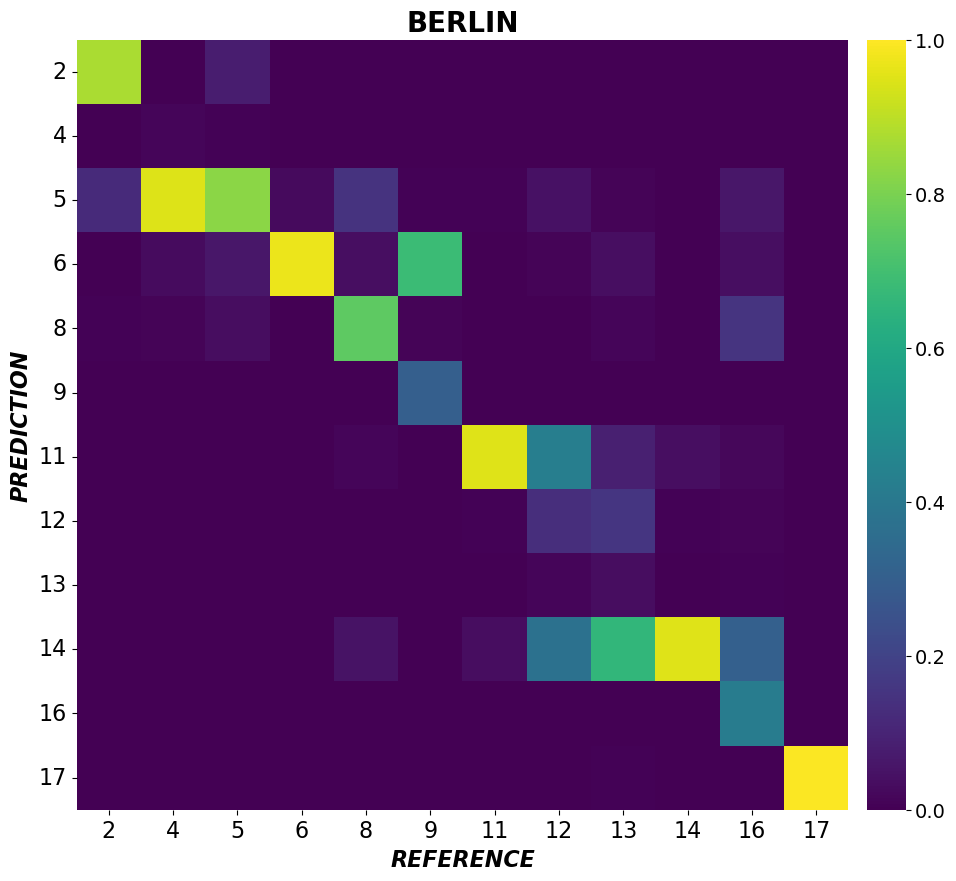

In [125]:
total_cm = None
for fold in results[best_setup][best_strategy]:
    fold_cm = results[best_setup][best_strategy][fold]["Confusion_Matrix"]
    if total_cm is None:
        total_cm = fold_cm.copy()
    else:
        total_cm += fold_cm

# Row Normalize
row_sums = total_cm.sum(axis=1)[:, np.newaxis]
norm_cm = total_cm.astype('float') / (row_sums + 1e-10)

plot_matrix = norm_cm.T 

plt.figure(figsize=(12, 10))
ordered_labels = sorted(splited_ref_data['gridcode'].unique())
ax = sns.heatmap(plot_matrix, 
            annot=False, 
            fmt='.2f', 
            cmap='viridis', 
            vmin=0.0,
            vmax=1.0,
            xticklabels=ordered_labels, 
            yticklabels=ordered_labels,
            cbar_kws={'pad': 0.02})
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=14)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16, rotation=0)
plt.xlabel('REFERENCE', fontsize=16, fontweight='bold', fontstyle='italic')
plt.ylabel('PREDICTION', fontsize=16, fontweight='bold', fontstyle='italic')        
plt.title('BERLIN', fontweight='bold', fontsize=20)
plt.show()

In [128]:
# save the summed matrix
np.save(r"results\s3\berlin_S3_summed_cm.npy", total_cm)

## Prediction

In [132]:
# which set was better?
better_set = non_weighted_set

# output
output = r'outputs\s3\berlin_S3.tif'

In [141]:
# get best model of the best set and stategy
best_run = df.loc[best_setup, best_strategy]
best_fold = (best_run['wF1'] + best_run['F1U']).idxmax()
best_model = best_run.loc[best_fold, 'Model']
best_run[["wF1", "F1U", "F1N", "OA"]].loc[best_fold]

wF1    82.16
F1U    87.84
F1N    77.25
OA     85.02
Name: 3, dtype: float64

In [134]:
# run prediction
with rio.open(better_set) as image_data:
    image_meta = image_data.meta
    image = image_data.read()

image_reshaped = rio.plot.reshape_as_image(image)
scene = image_reshaped.reshape(-1, image_reshaped.shape[-1])
scene[np.isinf(scene)] = np.nan
y_pred = best_model.predict(scene)
classified_image = y_pred.reshape(image_reshaped.shape[0], image_reshaped.shape[1])
classification_meta = image_meta.copy()
classification_meta.update({"count": 1})
with rio.open(output, "w", **classification_meta) as dest:
    dest.write(classified_image, indexes=1)

# Hong Kong

In [2]:
# load splited reference data
splited_ref_data = gpd.read_file(r'ref_data\hongkong_ref_splitS2S3S4.gpkg')

## Non-weighted RF S1 morphometric subset

In [3]:
# load fused image with subset of morphometrics from non-weighted RF S1 models
non_weighted_set = r'imagery\hongkong_20180321_morphometrics_meanminmax_grid.tif'

In [4]:
# results[setup][strategy][fold]
results = {
    setup: {
        strat: {
            fold: {} for fold in folds
        } for strat in strategies
    } for setup in setups
}

### Fold 0

In [5]:
fold = 0
test_polygons = splited_ref_data[splited_ref_data["fold"] == fold]
train_polygons = splited_ref_data[splited_ref_data["fold"] != fold]

In [6]:
train_polygons_raster = fr"hongkong_train_f{fold}.tif"
test_polygons_raster = fr"hongkong_test_f{fold}.tif"

utils.rasterize_reference_polygons(train_polygons, non_weighted_set, train_polygons_raster)
utils.rasterize_reference_polygons(test_polygons, non_weighted_set, test_polygons_raster)

In [7]:
with rio.open(non_weighted_set) as image_data:
    image_meta = image_data.meta
    image = image_data.read()

image_reshaped = rio.plot.reshape_as_image(image)
print(f'Image shape: {image.shape} -> {image_reshaped.shape}')

Image shape: (90, 443, 491) -> (443, 491, 90)


In [8]:
# train and test images matched to fusion 100m grid
train_image_matched = utils.match_rasters(train_polygons_raster, non_weighted_set)
test_image_matched = utils.match_rasters(test_polygons_raster, non_weighted_set)

train_image_matched = train_image_matched.to_numpy()
test_image_matched = test_image_matched.to_numpy()

C:\ProgramData\miniconda3\envs\geo\Lib\site-packages\xarray\core\duck_array_ops.py:250: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\ProgramData\miniconda3\envs\geo\Lib\site-packages\xarray\core\duck_array_ops.py:250: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


In [9]:
X_train = image_reshaped[train_image_matched > 0]
y_train = train_image_matched[train_image_matched > 0]
X_test = image_reshaped[test_image_matched > 0]
y_test = test_image_matched[test_image_matched > 0]

X_train[np.isinf(X_train)] = np.nan
X_test[np.isinf(X_test)] = np.nan

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(7236, 90) (7236,)
(1610, 90) (1610,)


#### Non/weighted RF model

In [ ]:
utils.finetune_height(X_train, y_train, X_test, y_test, max_height=10, class_weight=False)

In [ ]:
param, train, test, diff = utils.finetune_max_features(X_train, y_train, X_test, y_test, height=4, max_features=X_train.shape[1], class_weight=False)

In [34]:
param, train, test, diff

(2, 79.95, 78.93, 1.01)

In [10]:
model_fold0 = RandomForestClassifier(random_state=0, n_jobs=-1, max_depth=3, max_features=14, n_estimators=100)
model_fold0.fit(X_train, y_train)

RandomForestClassifier(max_depth=3, max_features=14, n_jobs=-1, random_state=0)

In [11]:
# training accuracy
pred_train = model_fold0.predict(X_train)
train_accuracy = accuracy_score(y_train, pred_train)
print('OA train: ', round(train_accuracy*100,2))
train_wf1 = f1_score(y_train, pred_train, average='weighted', labels=np.unique(y_train))
print('wF1 train: ', round(train_wf1*100,2))

OA train:  69.96
wF1 train:  63.02


In [12]:
# test accuracy
pred_test = model_fold0.predict(X_test)
test_accuracy = accuracy_score(y_test, pred_test)
print('OA test: ', round(test_accuracy*100,2))
test_wf1 = f1_score(y_test, pred_test, average='weighted', labels=np.unique(y_test))
print('wF1 test: ', round(test_wf1*100,2))

# F1U
X_test_urban = X_test[y_test<=10]
y_test_urban = y_test[y_test<=10]
y_test_pred_urb = model_fold0.predict(X_test_urban)
wf1_urb = f1_score(y_test_urban, y_test_pred_urb, average='weighted', labels=np.unique(y_test[y_test<=10]))
print('Urban wF1 test: ', round(wf1_urb*100,2))

# F1N
X_test_nat = X_test[y_test>10]
y_test_nat = y_test[y_test>10]
y_test_pred_nat = model_fold0.predict(X_test_nat)
wf1_nat = f1_score(y_test_nat, y_test_pred_nat, average='weighted', labels=np.unique(y_test[y_test>10]))
print('Natural wF1 test: ', round(wf1_nat*100,2))

conf_mat = confusion_matrix(y_test, pred_test, labels=sorted(splited_ref_data['gridcode'].unique()))

metrics = {
    "OA":  round(test_accuracy*100,2),
    "wF1": round(test_wf1*100,2),
    "F1U": round(wf1_urb*100,2),
    "F1N": round(wf1_nat*100,2),
    "Model": model_fold0,
    "Confusion_Matrix": conf_mat
}

for c in all_possible_classes:
    metrics[f"F1_Class_{c}"] = np.nan
f1_per_class_array = f1_score(y_test, pred_test, average=None, labels=np.unique(y_test))
for label, score in zip(np.unique(y_test), f1_per_class_array):
    if label in all_possible_classes:
        metrics[f"F1_Class_{int(label)}"] = round(score*100, 2)

results["non_weighted_set"]["non_weighted_model"][fold] = metrics

OA test:  65.28
wF1 test:  59.43
Urban wF1 test:  25.32
Natural wF1 test:  73.0


#### Weighted RF model

In [ ]:
utils.finetune_height(X_train, y_train, X_test, y_test, max_height=10, class_weight=True)

In [ ]:
param, train, test, diff = utils.finetune_max_features(X_train, y_train, X_test, y_test, height=4, max_features=X_train.shape[1], class_weight=True)

In [42]:
param, train, test, diff

(31, 58.17, 54.52, 3.65)

In [13]:
model_fold0_weighted = RandomForestClassifier(random_state=0, n_jobs=-1, max_depth=3, max_features=5, class_weight='balanced', n_estimators=100)
model_fold0_weighted.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=3, max_features=5,
                       n_jobs=-1, random_state=0)

In [14]:
# training accuracy
pred_train = model_fold0_weighted.predict(X_train)
train_accuracy = accuracy_score(y_train, pred_train)
print('OA train: ', round(train_accuracy*100,2))
train_wf1 = f1_score(y_train, pred_train, average='weighted', labels=np.unique(y_train))
print('wF1 train: ', round(train_wf1*100,2))

OA train:  72.98
wF1 train:  70.97


In [15]:
# test accuracy
pred_test = model_fold0_weighted.predict(X_test)
test_accuracy = accuracy_score(y_test, pred_test)
print('OA test: ', round(test_accuracy*100,2))
test_wf1 = f1_score(y_test, pred_test, average='weighted', labels=np.unique(y_test))
print('wF1 test: ', round(test_wf1*100,2))

# F1U
X_test_urban = X_test[y_test<=10]
y_test_urban = y_test[y_test<=10]
y_test_pred_urb = model_fold0_weighted.predict(X_test_urban)
wf1_urb = f1_score(y_test_urban, y_test_pred_urb, average='weighted', labels=np.unique(y_test[y_test<=10]))
print('Urban wF1 test: ', round(wf1_urb*100,2))

# F1N
X_test_nat = X_test[y_test>10]
y_test_nat = y_test[y_test>10]
y_test_pred_nat = model_fold0_weighted.predict(X_test_nat)
wf1_nat = f1_score(y_test_nat, y_test_pred_nat, average='weighted', labels=np.unique(y_test[y_test>10]))
print('Natural wF1 test: ', round(wf1_nat*100,2))

conf_mat = confusion_matrix(y_test, pred_test, labels=sorted(splited_ref_data['gridcode'].unique()))

metrics = {
    "OA":  round(test_accuracy*100,2),
    "wF1": round(test_wf1*100,2),
    "F1U": round(wf1_urb*100,2),
    "F1N": round(wf1_nat*100,2),
    "Model": model_fold0_weighted,
    "Confusion_Matrix": conf_mat
}

for c in all_possible_classes:
    metrics[f"F1_Class_{c}"] = np.nan
f1_per_class_array = f1_score(y_test, pred_test, average=None, labels=np.unique(y_test))
for label, score in zip(np.unique(y_test), f1_per_class_array):
    if label in all_possible_classes:
        metrics[f"F1_Class_{int(label)}"] = round(score*100, 2)

results["non_weighted_set"]["weighted_model"][fold] = metrics

OA test:  68.14
wF1 test:  66.77
Urban wF1 test:  52.65
Natural wF1 test:  73.02


### Fold 1

In [17]:
fold = 1
test_polygons = splited_ref_data[splited_ref_data["fold"] == fold]
train_polygons = splited_ref_data[splited_ref_data["fold"] != fold]

In [18]:
train_polygons_raster = fr"hongkong_train_f{fold}.tif"
test_polygons_raster = fr"hongkong_test_f{fold}.tif"

utils.rasterize_reference_polygons(train_polygons, non_weighted_set, train_polygons_raster)
utils.rasterize_reference_polygons(test_polygons, non_weighted_set, test_polygons_raster)

In [19]:
with rio.open(non_weighted_set) as image_data:
    image_meta = image_data.meta
    image = image_data.read()

image_reshaped = rio.plot.reshape_as_image(image)
print(f'Image shape: {image.shape} -> {image_reshaped.shape}')

Image shape: (90, 443, 491) -> (443, 491, 90)


In [20]:
# train and test images matched to fusion 100m grid
train_image_matched = utils.match_rasters(train_polygons_raster, non_weighted_set)
test_image_matched = utils.match_rasters(test_polygons_raster, non_weighted_set)

train_image_matched = train_image_matched.to_numpy()
test_image_matched = test_image_matched.to_numpy()

C:\ProgramData\miniconda3\envs\geo\Lib\site-packages\xarray\core\duck_array_ops.py:250: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\ProgramData\miniconda3\envs\geo\Lib\site-packages\xarray\core\duck_array_ops.py:250: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


In [21]:
X_train = image_reshaped[train_image_matched > 0]
y_train = train_image_matched[train_image_matched > 0]
X_test = image_reshaped[test_image_matched > 0]
y_test = test_image_matched[test_image_matched > 0]

X_train[np.isinf(X_train)] = np.nan
X_test[np.isinf(X_test)] = np.nan

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(6789, 90) (6789,)
(2057, 90) (2057,)


#### Non/weighted RF model

In [ ]:
utils.finetune_height(X_train, y_train, X_test, y_test, max_height=10, class_weight=False)

In [ ]:
param, train, test, diff = utils.finetune_max_features(X_train, y_train, X_test, y_test, height=4, max_features=X_train.shape[1], class_weight=False)

In [ ]:
param, train, test, diff

In [22]:
model_fold1 = RandomForestClassifier(random_state=0, n_jobs=-1, max_depth=3, max_features=5, n_estimators=100)
model_fold1.fit(X_train, y_train)

RandomForestClassifier(max_depth=3, max_features=5, n_jobs=-1, random_state=0)

In [23]:
# training accuracy
pred_train = model_fold1.predict(X_train)
train_accuracy = accuracy_score(y_train, pred_train)
print('OA train: ', round(train_accuracy*100,2))
train_wf1 = f1_score(y_train, pred_train, average='weighted', labels=np.unique(y_train))
print('wF1 train: ', round(train_wf1*100,2))

OA train:  74.37
wF1 train:  68.8


In [24]:
# test accuracy
pred_test = model_fold1.predict(X_test)
test_accuracy = accuracy_score(y_test, pred_test)
print('OA test: ', round(test_accuracy*100,2))
test_wf1 = f1_score(y_test, pred_test, average='weighted', labels=np.unique(y_test))
print('wF1 test: ', round(test_wf1*100,2))

# F1U
X_test_urban = X_test[y_test<=10]
y_test_urban = y_test[y_test<=10]
y_test_pred_urb = model_fold1.predict(X_test_urban)
wf1_urb = f1_score(y_test_urban, y_test_pred_urb, average='weighted', labels=np.unique(y_test[y_test<=10]))
print('Urban wF1 test: ', round(wf1_urb*100,2))

# F1N
X_test_nat = X_test[y_test>10]
y_test_nat = y_test[y_test>10]
y_test_pred_nat = model_fold1.predict(X_test_nat)
wf1_nat = f1_score(y_test_nat, y_test_pred_nat, average='weighted', labels=np.unique(y_test[y_test>10]))
print('Natural wF1 test: ', round(wf1_nat*100,2))

conf_mat = confusion_matrix(y_test, pred_test, labels=sorted(splited_ref_data['gridcode'].unique()))

metrics = {
    "OA":  round(test_accuracy*100,2),
    "wF1": round(test_wf1*100,2),
    "F1U": round(wf1_urb*100,2),
    "F1N": round(wf1_nat*100,2),
    "Model": model_fold1,
    "Confusion_Matrix": conf_mat
}

for c in all_possible_classes:
    metrics[f"F1_Class_{c}"] = np.nan
f1_per_class_array = f1_score(y_test, pred_test, average=None, labels=np.unique(y_test))
for label, score in zip(np.unique(y_test), f1_per_class_array):
    if label in all_possible_classes:
        metrics[f"F1_Class_{int(label)}"] = round(score*100, 2)

results["non_weighted_set"]["non_weighted_model"][fold] = metrics

OA test:  70.88
wF1 test:  65.42
Urban wF1 test:  56.88
Natural wF1 test:  69.01


#### Weighted RF model

In [ ]:
utils.finetune_height(X_train, y_train, X_test, y_test, max_height=10, class_weight=True)

In [ ]:
param, train, test, diff = utils.finetune_max_features(X_train, y_train, X_test, y_test, height=3, max_features=X_train.shape[1], class_weight=True)

In [ ]:
param, train, test, diff

In [25]:
model_fold1_weighted = RandomForestClassifier(random_state=0, n_jobs=-1, max_depth=2, max_features=2, class_weight='balanced', n_estimators=100)
model_fold1_weighted.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=2, max_features=2,
                       n_jobs=-1, random_state=0)

In [26]:
# training accuracy
pred_train = model_fold1_weighted.predict(X_train)
train_accuracy = accuracy_score(y_train, pred_train)
print('OA train: ', round(train_accuracy*100,2))
train_wf1 = f1_score(y_train, pred_train, average='weighted', labels=np.unique(y_train))
print('wF1 train: ', round(train_wf1*100,2))

OA train:  66.77
wF1 train:  60.06


In [27]:
# test accuracy
pred_test = model_fold1_weighted.predict(X_test)
test_accuracy = accuracy_score(y_test, pred_test)
print('OA test: ', round(test_accuracy*100,2))
test_wf1 = f1_score(y_test, pred_test, average='weighted', labels=np.unique(y_test))
print('wF1 test: ', round(test_wf1*100,2))

# F1U
X_test_urban = X_test[y_test<=10]
y_test_urban = y_test[y_test<=10]
y_test_pred_urb = model_fold1_weighted.predict(X_test_urban)
wf1_urb = f1_score(y_test_urban, y_test_pred_urb, average='weighted', labels=np.unique(y_test[y_test<=10]))
print('Urban wF1 test: ', round(wf1_urb*100,2))

# F1N
X_test_nat = X_test[y_test>10]
y_test_nat = y_test[y_test>10]
y_test_pred_nat = model_fold1_weighted.predict(X_test_nat)
wf1_nat = f1_score(y_test_nat, y_test_pred_nat, average='weighted', labels=np.unique(y_test[y_test>10]))
print('Natural wF1 test: ', round(wf1_nat*100,2))

conf_mat = confusion_matrix(y_test, pred_test, labels=sorted(splited_ref_data['gridcode'].unique()))

metrics = {
    "OA":  round(test_accuracy*100,2),
    "wF1": round(test_wf1*100,2),
    "F1U": round(wf1_urb*100,2),
    "F1N": round(wf1_nat*100,2),
    "Model": model_fold1_weighted,
    "Confusion_Matrix": conf_mat
}

for c in all_possible_classes:
    metrics[f"F1_Class_{c}"] = np.nan
f1_per_class_array = f1_score(y_test, pred_test, average=None, labels=np.unique(y_test))
for label, score in zip(np.unique(y_test), f1_per_class_array):
    if label in all_possible_classes:
        metrics[f"F1_Class_{int(label)}"] = round(score*100, 2)

results["non_weighted_set"]["weighted_model"][fold] = metrics

OA test:  63.49
wF1 test:  58.43
Urban wF1 test:  62.06
Natural wF1 test:  57.63


### Fold 2

In [28]:
fold = 2
test_polygons = splited_ref_data[splited_ref_data["fold"] == fold]
train_polygons = splited_ref_data[splited_ref_data["fold"] != fold]

In [30]:
train_polygons_raster = fr"hongkong_train_f{fold}.tif"
test_polygons_raster = fr"hongkong_test_f{fold}.tif"

utils.rasterize_reference_polygons(train_polygons, non_weighted_set, train_polygons_raster)
utils.rasterize_reference_polygons(test_polygons, non_weighted_set, test_polygons_raster)

In [31]:
with rio.open(non_weighted_set) as image_data:
    image_meta = image_data.meta
    image = image_data.read()

image_reshaped = rio.plot.reshape_as_image(image)
print(f'Image shape: {image.shape} -> {image_reshaped.shape}')

Image shape: (90, 443, 491) -> (443, 491, 90)


In [32]:
# train and test images matched to fusion 100m grid
train_image_matched = utils.match_rasters(train_polygons_raster, non_weighted_set)
test_image_matched = utils.match_rasters(test_polygons_raster, non_weighted_set)

train_image_matched = train_image_matched.to_numpy()
test_image_matched = test_image_matched.to_numpy()

C:\ProgramData\miniconda3\envs\geo\Lib\site-packages\xarray\core\duck_array_ops.py:250: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\ProgramData\miniconda3\envs\geo\Lib\site-packages\xarray\core\duck_array_ops.py:250: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


In [33]:
X_train = image_reshaped[train_image_matched > 0]
y_train = train_image_matched[train_image_matched > 0]
X_test = image_reshaped[test_image_matched > 0]
y_test = test_image_matched[test_image_matched > 0]

X_train[np.isinf(X_train)] = np.nan
X_test[np.isinf(X_test)] = np.nan

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(7151, 90) (7151,)
(1695, 90) (1695,)


#### Non/weighted RF model

In [ ]:
utils.finetune_height(X_train, y_train, X_test, y_test, max_height=10, class_weight=False)

In [ ]:
param, train, test, diff = utils.finetune_max_features(X_train, y_train, X_test, y_test, height=7, max_features=X_train.shape[1], class_weight=False)

In [76]:
param, train, test, diff

(6, 87.33, 82.49, 4.84)

In [34]:
model_fold2 = RandomForestClassifier(random_state=0, n_jobs=-1, max_depth=4, max_features=46, n_estimators=100)
model_fold2.fit(X_train, y_train)

RandomForestClassifier(max_depth=4, max_features=46, n_jobs=-1, random_state=0)

In [35]:
# training accuracy
pred_train = model_fold2.predict(X_train)
train_accuracy = accuracy_score(y_train, pred_train)
print('OA train: ', round(train_accuracy*100,2))
train_wf1 = f1_score(y_train, pred_train, average='weighted', labels=np.unique(y_train))
print('wF1 train: ', round(train_wf1*100,2))

OA train:  75.86
wF1 train:  70.99


In [36]:
# test accuracy
pred_test = model_fold2.predict(X_test)
test_accuracy = accuracy_score(y_test, pred_test)
print('OA test: ', round(test_accuracy*100,2))
test_wf1 = f1_score(y_test, pred_test, average='weighted', labels=np.unique(y_test))
print('wF1 test: ', round(test_wf1*100,2))

# F1U
X_test_urban = X_test[y_test<=10]
y_test_urban = y_test[y_test<=10]
y_test_pred_urb = model_fold2.predict(X_test_urban)
wf1_urb = f1_score(y_test_urban, y_test_pred_urb, average='weighted', labels=np.unique(y_test[y_test<=10]))
print('Urban wF1 test: ', round(wf1_urb*100,2))

# F1N
X_test_nat = X_test[y_test>10]
y_test_nat = y_test[y_test>10]
y_test_pred_nat = model_fold2.predict(X_test_nat)
wf1_nat = f1_score(y_test_nat, y_test_pred_nat, average='weighted', labels=np.unique(y_test[y_test>10]))
print('Natural wF1 test: ', round(wf1_nat*100,2))

conf_mat = confusion_matrix(y_test, pred_test, labels=sorted(splited_ref_data['gridcode'].unique()))

metrics = {
    "OA":  round(test_accuracy*100,2),
    "wF1": round(test_wf1*100,2),
    "F1U": round(wf1_urb*100,2),
    "F1N": round(wf1_nat*100,2),
    "Model": model_fold2,
    "Confusion_Matrix": conf_mat
}

for c in all_possible_classes:
    metrics[f"F1_Class_{c}"] = np.nan
f1_per_class_array = f1_score(y_test, pred_test, average=None, labels=np.unique(y_test))
for label, score in zip(np.unique(y_test), f1_per_class_array):
    if label in all_possible_classes:
        metrics[f"F1_Class_{int(label)}"] = round(score*100, 2)

results["non_weighted_set"]["non_weighted_model"][fold] = metrics

OA test:  73.86
wF1 test:  69.62
Urban wF1 test:  36.36
Natural wF1 test:  82.04


#### Weighted RF model

In [ ]:
utils.finetune_height(X_train, y_train, X_test, y_test, max_height=10, class_weight=True)

In [ ]:
param, train, test, diff = utils.finetune_max_features(X_train, y_train, X_test, y_test, height=8, max_features=X_train.shape[1], class_weight=True)

In [87]:
param, train, test, diff

(5, 86.05, 83.01, 3.04)

In [37]:
model_fold2_weighted = RandomForestClassifier(random_state=0, n_jobs=-1, max_depth=5, max_features=10, class_weight='balanced', n_estimators=100)
model_fold2_weighted.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=5, max_features=10,
                       n_jobs=-1, random_state=0)

In [38]:
# training accuracy
pred_train = model_fold2_weighted.predict(X_train)
train_accuracy = accuracy_score(y_train, pred_train)
print('OA train: ', round(train_accuracy*100,2))
train_wf1 = f1_score(y_train, pred_train, average='weighted', labels=np.unique(y_train))
print('wF1 train: ', round(train_wf1*100,2))

OA train:  81.26
wF1 train:  81.63


In [39]:
# test accuracy
pred_test = model_fold2_weighted.predict(X_test)
test_accuracy = accuracy_score(y_test, pred_test)
print('OA test: ', round(test_accuracy*100,2))
test_wf1 = f1_score(y_test, pred_test, average='weighted', labels=np.unique(y_test))
print('wF1 test: ', round(test_wf1*100,2))

# F1U
X_test_urban = X_test[y_test<=10]
y_test_urban = y_test[y_test<=10]
y_test_pred_urb = model_fold2_weighted.predict(X_test_urban)
wf1_urb = f1_score(y_test_urban, y_test_pred_urb, average='weighted', labels=np.unique(y_test[y_test<=10]))
print('Urban wF1 test: ', round(wf1_urb*100,2))

# F1N
X_test_nat = X_test[y_test>10]
y_test_nat = y_test[y_test>10]
y_test_pred_nat = model_fold2_weighted.predict(X_test_nat)
wf1_nat = f1_score(y_test_nat, y_test_pred_nat, average='weighted', labels=np.unique(y_test[y_test>10]))
print('Natural wF1 test: ', round(wf1_nat*100,2))

conf_mat = confusion_matrix(y_test, pred_test, labels=sorted(splited_ref_data['gridcode'].unique()))

metrics = {
    "OA":  round(test_accuracy*100,2),
    "wF1": round(test_wf1*100,2),
    "F1U": round(wf1_urb*100,2),
    "F1N": round(wf1_nat*100,2),
    "Model": model_fold2_weighted,
    "Confusion_Matrix": conf_mat
}

for c in all_possible_classes:
    metrics[f"F1_Class_{c}"] = np.nan
f1_per_class_array = f1_score(y_test, pred_test, average=None, labels=np.unique(y_test))
for label, score in zip(np.unique(y_test), f1_per_class_array):
    if label in all_possible_classes:
        metrics[f"F1_Class_{int(label)}"] = round(score*100, 2)

results["non_weighted_set"]["weighted_model"][fold] = metrics

OA test:  77.82
wF1 test:  78.32
Urban wF1 test:  73.18
Natural wF1 test:  81.27


### Fold 3

In [40]:
fold = 3
test_polygons = splited_ref_data[splited_ref_data["fold"] == fold]
train_polygons = splited_ref_data[splited_ref_data["fold"] != fold]

In [41]:
train_polygons_raster = fr"hongkong_train_f{fold}.tif"
test_polygons_raster = fr"hongkong_test_f{fold}.tif"

utils.rasterize_reference_polygons(train_polygons, non_weighted_set, train_polygons_raster)
utils.rasterize_reference_polygons(test_polygons, non_weighted_set, test_polygons_raster)

In [42]:
with rio.open(non_weighted_set) as image_data:
    image_meta = image_data.meta
    image = image_data.read()

image_reshaped = rio.plot.reshape_as_image(image)
print(f'Image shape: {image.shape} -> {image_reshaped.shape}')

Image shape: (90, 443, 491) -> (443, 491, 90)


In [43]:
# train and test images matched to fusion 100m grid
train_image_matched = utils.match_rasters(train_polygons_raster, non_weighted_set)
test_image_matched = utils.match_rasters(test_polygons_raster, non_weighted_set)

train_image_matched = train_image_matched.to_numpy()
test_image_matched = test_image_matched.to_numpy()

C:\ProgramData\miniconda3\envs\geo\Lib\site-packages\xarray\core\duck_array_ops.py:250: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\ProgramData\miniconda3\envs\geo\Lib\site-packages\xarray\core\duck_array_ops.py:250: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


In [44]:
X_train = image_reshaped[train_image_matched > 0]
y_train = train_image_matched[train_image_matched > 0]
X_test = image_reshaped[test_image_matched > 0]
y_test = test_image_matched[test_image_matched > 0]

X_train[np.isinf(X_train)] = np.nan
X_test[np.isinf(X_test)] = np.nan

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(6982, 90) (6982,)
(1864, 90) (1864,)


#### Non/weighted RF model

In [ ]:
utils.finetune_height(X_train, y_train, X_test, y_test, max_height=10, class_weight=False)

In [ ]:
param, train, test, diff = utils.finetune_max_features(X_train, y_train, X_test, y_test, height=7, max_features=X_train.shape[1], class_weight=False)

In [95]:
param, train, test, diff

(69, 89.65, 85.02, 4.63)

In [45]:
model_fold3 = RandomForestClassifier(random_state=0, n_jobs=-1, max_depth=7, max_features=14, n_estimators=100)
model_fold3.fit(X_train, y_train)

RandomForestClassifier(max_depth=7, max_features=14, n_jobs=-1, random_state=0)

In [46]:
# training accuracy
pred_train = model_fold3.predict(X_train)
train_accuracy = accuracy_score(y_train, pred_train)
print('OA train: ', round(train_accuracy*100,2))
train_wf1 = f1_score(y_train, pred_train, average='weighted', labels=np.unique(y_train))
print('wF1 train: ', round(train_wf1*100,2))

OA train:  87.45
wF1 train:  86.64


In [47]:
# test accuracy
pred_test = model_fold3.predict(X_test)
test_accuracy = accuracy_score(y_test, pred_test)
print('OA test: ', round(test_accuracy*100,2))
test_wf1 = f1_score(y_test, pred_test, average='weighted', labels=np.unique(y_test))
print('wF1 test: ', round(test_wf1*100,2))

# F1U
X_test_urban = X_test[y_test<=10]
y_test_urban = y_test[y_test<=10]
y_test_pred_urb = model_fold3.predict(X_test_urban)
wf1_urb = f1_score(y_test_urban, y_test_pred_urb, average='weighted', labels=np.unique(y_test[y_test<=10]))
print('Urban wF1 test: ', round(wf1_urb*100,2))

# F1N
X_test_nat = X_test[y_test>10]
y_test_nat = y_test[y_test>10]
y_test_pred_nat = model_fold3.predict(X_test_nat)
wf1_nat = f1_score(y_test_nat, y_test_pred_nat, average='weighted', labels=np.unique(y_test[y_test>10]))
print('Natural wF1 test: ', round(wf1_nat*100,2))

conf_mat = confusion_matrix(y_test, pred_test, labels=sorted(splited_ref_data['gridcode'].unique()))

metrics = {
    "OA":  round(test_accuracy*100,2),
    "wF1": round(test_wf1*100,2),
    "F1U": round(wf1_urb*100,2),
    "F1N": round(wf1_nat*100,2),
    "Model": model_fold3,
    "Confusion_Matrix": conf_mat
}

for c in all_possible_classes:
    metrics[f"F1_Class_{c}"] = np.nan
f1_per_class_array = f1_score(y_test, pred_test, average=None, labels=np.unique(y_test))
for label, score in zip(np.unique(y_test), f1_per_class_array):
    if label in all_possible_classes:
        metrics[f"F1_Class_{int(label)}"] = round(score*100, 2)

results["non_weighted_set"]["non_weighted_model"][fold] = metrics

OA test:  83.64
wF1 test:  80.36
Urban wF1 test:  71.05
Natural wF1 test:  84.72


#### Weighted RF model

In [ ]:
utils.finetune_height(X_train, y_train, X_test, y_test, max_height=10, class_weight=True)

In [ ]:
param, train, test, diff = utils.finetune_max_features(X_train, y_train, X_test, y_test, height=9, max_features=X_train.shape[1], class_weight=True)

In [102]:
param, train, test, diff

(11, 88.6, 84.79, 3.8)

In [48]:
model_fold3_weighted = RandomForestClassifier(random_state=0, n_jobs=-1, max_depth=8, max_features=5, class_weight='balanced', n_estimators=100)
model_fold3_weighted.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=8, max_features=5,
                       n_jobs=-1, random_state=0)

In [49]:
# training accuracy
pred_train = model_fold3_weighted.predict(X_train)
train_accuracy = accuracy_score(y_train, pred_train)
print('OA train: ', round(train_accuracy*100,2))
train_wf1 = f1_score(y_train, pred_train, average='weighted', labels=np.unique(y_train))
print('wF1 train: ', round(train_wf1*100,2))

OA train:  88.9
wF1 train:  88.92


In [50]:
# test accuracy
pred_test = model_fold3_weighted.predict(X_test)
test_accuracy = accuracy_score(y_test, pred_test)
print('OA test: ', round(test_accuracy*100,2))
test_wf1 = f1_score(y_test, pred_test, average='weighted', labels=np.unique(y_test))
print('wF1 test: ', round(test_wf1*100,2))

# F1U
X_test_urban = X_test[y_test<=10]
y_test_urban = y_test[y_test<=10]
y_test_pred_urb = model_fold3_weighted.predict(X_test_urban)
wf1_urb = f1_score(y_test_urban, y_test_pred_urb, average='weighted', labels=np.unique(y_test[y_test<=10]))
print('Urban wF1 test: ', round(wf1_urb*100,2))

# F1N
X_test_nat = X_test[y_test>10]
y_test_nat = y_test[y_test>10]
y_test_pred_nat = model_fold3_weighted.predict(X_test_nat)
wf1_nat = f1_score(y_test_nat, y_test_pred_nat, average='weighted', labels=np.unique(y_test[y_test>10]))
print('Natural wF1 test: ', round(wf1_nat*100,2))

conf_mat = confusion_matrix(y_test, pred_test, labels=sorted(splited_ref_data['gridcode'].unique()))

metrics = {
    "OA":  round(test_accuracy*100,2),
    "wF1": round(test_wf1*100,2),
    "F1U": round(wf1_urb*100,2),
    "F1N": round(wf1_nat*100,2),
    "Model": model_fold3_weighted,
    "Confusion_Matrix": conf_mat
}

for c in all_possible_classes:
    metrics[f"F1_Class_{c}"] = np.nan
f1_per_class_array = f1_score(y_test, pred_test, average=None, labels=np.unique(y_test))
for label, score in zip(np.unique(y_test), f1_per_class_array):
    if label in all_possible_classes:
        metrics[f"F1_Class_{int(label)}"] = round(score*100, 2)

results["non_weighted_set"]["weighted_model"][fold] = metrics

OA test:  84.71
wF1 test:  83.35
Urban wF1 test:  76.09
Natural wF1 test:  86.47


### Fold 4

In [51]:
fold = 4
test_polygons = splited_ref_data[splited_ref_data["fold"] == fold]
train_polygons = splited_ref_data[splited_ref_data["fold"] != fold]

In [52]:
train_polygons_raster = fr"hongkong_train_f{fold}.tif"
test_polygons_raster = fr"hongkong_test_f{fold}.tif"

utils.rasterize_reference_polygons(train_polygons, non_weighted_set, train_polygons_raster)
utils.rasterize_reference_polygons(test_polygons, non_weighted_set, test_polygons_raster)

In [53]:
with rio.open(non_weighted_set) as image_data:
    image_meta = image_data.meta
    image = image_data.read()

image_reshaped = rio.plot.reshape_as_image(image)
print(f'Image shape: {image.shape} -> {image_reshaped.shape}')

Image shape: (90, 443, 491) -> (443, 491, 90)


In [54]:
# train and test images matched to fusion 100m grid
train_image_matched = utils.match_rasters(train_polygons_raster, non_weighted_set)
test_image_matched = utils.match_rasters(test_polygons_raster, non_weighted_set)

train_image_matched = train_image_matched.to_numpy()
test_image_matched = test_image_matched.to_numpy()

C:\ProgramData\miniconda3\envs\geo\Lib\site-packages\xarray\core\duck_array_ops.py:250: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\ProgramData\miniconda3\envs\geo\Lib\site-packages\xarray\core\duck_array_ops.py:250: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


In [55]:
X_train = image_reshaped[train_image_matched > 0]
y_train = train_image_matched[train_image_matched > 0]
X_test = image_reshaped[test_image_matched > 0]
y_test = test_image_matched[test_image_matched > 0]

X_train[np.isinf(X_train)] = np.nan
X_test[np.isinf(X_test)] = np.nan

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(7226, 90) (7226,)
(1620, 90) (1620,)


#### Non/weighted RF model

In [ ]:
utils.finetune_height(X_train, y_train, X_test, y_test, max_height=10, class_weight=False)

In [ ]:
param, train, test, diff = utils.finetune_max_features(X_train, y_train, X_test, y_test, height=6, max_features=X_train.shape[1], class_weight=False)

In [115]:
param, train, test, diff

(8, 86.44, 82.9, 3.54)

In [56]:
model_fold4 = RandomForestClassifier(random_state=0, n_jobs=-1, max_depth=3, max_features=1, n_estimators=100)
model_fold4.fit(X_train, y_train)

RandomForestClassifier(max_depth=3, max_features=1, n_jobs=-1, random_state=0)

In [57]:
# training accuracy
pred_train = model_fold4.predict(X_train)
train_accuracy = accuracy_score(y_train, pred_train)
print('OA train: ', round(train_accuracy*100,2))
train_wf1 = f1_score(y_train, pred_train, average='weighted', labels=np.unique(y_train))
print('wF1 train: ', round(train_wf1*100,2))

OA train:  64.2
wF1 train:  53.76


In [58]:
# test accuracy
pred_test = model_fold4.predict(X_test)
test_accuracy = accuracy_score(y_test, pred_test)
print('OA test: ', round(test_accuracy*100,2))
test_wf1 = f1_score(y_test, pred_test, average='weighted', labels=np.unique(y_test))
print('wF1 test: ', round(test_wf1*100,2))

# F1U
X_test_urban = X_test[y_test<=10]
y_test_urban = y_test[y_test<=10]
y_test_pred_urb = model_fold4.predict(X_test_urban)
wf1_urb = f1_score(y_test_urban, y_test_pred_urb, average='weighted', labels=np.unique(y_test[y_test<=10]))
print('Urban wF1 test: ', round(wf1_urb*100,2))

# F1N
X_test_nat = X_test[y_test>10]
y_test_nat = y_test[y_test>10]
y_test_pred_nat = model_fold4.predict(X_test_nat)
wf1_nat = f1_score(y_test_nat, y_test_pred_nat, average='weighted', labels=np.unique(y_test[y_test>10]))
print('Natural wF1 test: ', round(wf1_nat*100,2))

conf_mat = confusion_matrix(y_test, pred_test, labels=sorted(splited_ref_data['gridcode'].unique()))

metrics = {
    "OA":  round(test_accuracy*100,2),
    "wF1": round(test_wf1*100,2),
    "F1U": round(wf1_urb*100,2),
    "F1N": round(wf1_nat*100,2),
    "Model": model_fold4,
    "Confusion_Matrix": conf_mat
}

for c in all_possible_classes:
    metrics[f"F1_Class_{c}"] = np.nan
f1_per_class_array = f1_score(y_test, pred_test, average=None, labels=np.unique(y_test))
for label, score in zip(np.unique(y_test), f1_per_class_array):
    if label in all_possible_classes:
        metrics[f"F1_Class_{int(label)}"] = round(score*100, 2)

results["non_weighted_set"]["non_weighted_model"][fold] = metrics

OA test:  60.49
wF1 test:  48.83
Urban wF1 test:  50.71
Natural wF1 test:  49.91


#### Weighted RF model

In [ ]:
utils.finetune_height(X_train, y_train, X_test, y_test, max_height=10, class_weight=True)

In [ ]:
param, train, test, diff = utils.finetune_max_features(X_train, y_train, X_test, y_test, height=5, max_features=X_train.shape[1], class_weight=True)

In [124]:
param, train, test, diff

(11, 78.4, 74.37, 4.03)

In [59]:
model_fold4_weighted = RandomForestClassifier(random_state=0, n_jobs=-1, max_depth=3, max_features=37, class_weight='balanced', n_estimators=100)
model_fold4_weighted.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=3, max_features=37,
                       n_jobs=-1, random_state=0)

In [60]:
# training accuracy
pred_train = model_fold4_weighted.predict(X_train)
train_accuracy = accuracy_score(y_train, pred_train)
print('OA train: ', round(train_accuracy*100,2))
train_wf1 = f1_score(y_train, pred_train, average='weighted', labels=np.unique(y_train))
print('wF1 train: ', round(train_wf1*100,2))

OA train:  65.31
wF1 train:  59.53


In [61]:
# test accuracy
pred_test = model_fold4_weighted.predict(X_test)
test_accuracy = accuracy_score(y_test, pred_test)
print('OA test: ', round(test_accuracy*100,2))
test_wf1 = f1_score(y_test, pred_test, average='weighted', labels=np.unique(y_test))
print('wF1 test: ', round(test_wf1*100,2))

# F1U
X_test_urban = X_test[y_test<=10]
y_test_urban = y_test[y_test<=10]
y_test_pred_urb = model_fold4_weighted.predict(X_test_urban)
wf1_urb = f1_score(y_test_urban, y_test_pred_urb, average='weighted', labels=np.unique(y_test[y_test<=10]))
print('Urban wF1 test: ', round(wf1_urb*100,2))

# F1N
X_test_nat = X_test[y_test>10]
y_test_nat = y_test[y_test>10]
y_test_pred_nat = model_fold4_weighted.predict(X_test_nat)
wf1_nat = f1_score(y_test_nat, y_test_pred_nat, average='weighted', labels=np.unique(y_test[y_test>10]))
print('Natural wF1 test: ', round(wf1_nat*100,2))

conf_mat = confusion_matrix(y_test, pred_test, labels=sorted(splited_ref_data['gridcode'].unique()))

metrics = {
    "OA":  round(test_accuracy*100,2),
    "wF1": round(test_wf1*100,2),
    "F1U": round(wf1_urb*100,2),
    "F1N": round(wf1_nat*100,2),
    "Model": model_fold4_weighted,
    "Confusion_Matrix": conf_mat
}

for c in all_possible_classes:
    metrics[f"F1_Class_{c}"] = np.nan
f1_per_class_array = f1_score(y_test, pred_test, average=None, labels=np.unique(y_test))
for label, score in zip(np.unique(y_test), f1_per_class_array):
    if label in all_possible_classes:
        metrics[f"F1_Class_{int(label)}"] = round(score*100, 2)

results["non_weighted_set"]["weighted_model"][fold] = metrics

OA test:  61.6
wF1 test:  54.14
Urban wF1 test:  38.94
Natural wF1 test:  61.65


## Weighted RF S1 morphometric subset

In [62]:
# load fused image with subset of morphometrics from weighted RF S1 models
weighted_set = r'imagery\hongkong_20180321_morphometrics_weighted_meanminmax_grid.tif'

### Fold 0

In [64]:
fold = 0
test_polygons = splited_ref_data[splited_ref_data["fold"] == fold]
train_polygons = splited_ref_data[splited_ref_data["fold"] != fold]

In [65]:
train_polygons_raster = fr"hongkong_train_f{fold}.tif"
test_polygons_raster = fr"hongkong_test_f{fold}.tif"

#utils.rasterize_reference_polygons(train_polygons, weighted_set, train_polygons_raster)
#utils.rasterize_reference_polygons(test_polygons, weighted_set, test_polygons_raster)

In [66]:
with rio.open(weighted_set) as image_data:
    image_meta = image_data.meta
    image = image_data.read()

image_reshaped = rio.plot.reshape_as_image(image)
print(f'Image shape: {image.shape} -> {image_reshaped.shape}')

Image shape: (90, 443, 491) -> (443, 491, 90)


In [67]:
# train and test images matched to fusion 100m grid
train_image_matched = utils.match_rasters(train_polygons_raster, weighted_set)
test_image_matched = utils.match_rasters(test_polygons_raster, weighted_set)

train_image_matched = train_image_matched.to_numpy()
test_image_matched = test_image_matched.to_numpy()

C:\ProgramData\miniconda3\envs\geo\Lib\site-packages\xarray\core\duck_array_ops.py:250: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\ProgramData\miniconda3\envs\geo\Lib\site-packages\xarray\core\duck_array_ops.py:250: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


In [68]:
X_train = image_reshaped[train_image_matched > 0]
y_train = train_image_matched[train_image_matched > 0]
X_test = image_reshaped[test_image_matched > 0]
y_test = test_image_matched[test_image_matched > 0]

X_train[np.isinf(X_train)] = np.nan
X_test[np.isinf(X_test)] = np.nan

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(7236, 90) (7236,)
(1610, 90) (1610,)


#### Non/weighted RF model

In [ ]:
utils.finetune_height(X_train, y_train, X_test, y_test, max_height=10, class_weight=False)

In [ ]:
param, train, test, diff = utils.finetune_max_features(X_train, y_train, X_test, y_test, height=5, max_features=X_train.shape[1], class_weight=False)

In [146]:
param, train, test, diff

(1, 81.27, 78.91, 2.36)

In [69]:
ws_model_fold0 = RandomForestClassifier(random_state=0, n_jobs=-1, max_depth=2, max_features=9, n_estimators=100)
ws_model_fold0.fit(X_train, y_train)

RandomForestClassifier(max_depth=2, max_features=9, n_jobs=-1, random_state=0)

In [70]:
# training accuracy
pred_train = ws_model_fold0.predict(X_train)
train_accuracy = accuracy_score(y_train, pred_train)
print('OA train: ', round(train_accuracy*100,2))
train_wf1 = f1_score(y_train, pred_train, average='weighted', labels=np.unique(y_train))
print('wF1 train: ', round(train_wf1*100,2))

OA train:  64.52
wF1 train:  56.33


In [71]:
# test accuracy
pred_test = ws_model_fold0.predict(X_test)
test_accuracy = accuracy_score(y_test, pred_test)
print('OA test: ', round(test_accuracy*100,2))
test_wf1 = f1_score(y_test, pred_test, average='weighted', labels=np.unique(y_test))
print('wF1 test: ', round(test_wf1*100,2))

# F1U
X_test_urban = X_test[y_test<=10]
y_test_urban = y_test[y_test<=10]
y_test_pred_urb = ws_model_fold0.predict(X_test_urban)
wf1_urb = f1_score(y_test_urban, y_test_pred_urb, average='weighted', labels=np.unique(y_test[y_test<=10]))
print('Urban wF1 test: ', round(wf1_urb*100,2))

# F1N
X_test_nat = X_test[y_test>10]
y_test_nat = y_test[y_test>10]
y_test_pred_nat = ws_model_fold0.predict(X_test_nat)
wf1_nat = f1_score(y_test_nat, y_test_pred_nat, average='weighted', labels=np.unique(y_test[y_test>10]))
print('Natural wF1 test: ', round(wf1_nat*100,2))

conf_mat = confusion_matrix(y_test, pred_test, labels=sorted(splited_ref_data['gridcode'].unique()))

metrics = {
    "OA":  round(test_accuracy*100,2),
    "wF1": round(test_wf1*100,2),
    "F1U": round(wf1_urb*100,2),
    "F1N": round(wf1_nat*100,2),
    "Model": ws_model_fold0,
    "Confusion_Matrix": conf_mat
}

for c in all_possible_classes:
    metrics[f"F1_Class_{c}"] = np.nan
f1_per_class_array = f1_score(y_test, pred_test, average=None, labels=np.unique(y_test))
for label, score in zip(np.unique(y_test), f1_per_class_array):
    if label in all_possible_classes:
        metrics[f"F1_Class_{int(label)}"] = round(score*100, 2)
        
results["weighted_set"]["non_weighted_model"][fold] = metrics

OA test:  62.42
wF1 test:  54.12
Urban wF1 test:  24.8
Natural wF1 test:  65.42


#### Weighted RF model

In [ ]:
utils.finetune_height(X_train, y_train, X_test, y_test, max_height=10, class_weight=True)

In [ ]:
param, train, test, diff = utils.finetune_max_features(X_train, y_train, X_test, y_test, height=5, max_features=X_train.shape[1], class_weight=True)

In [152]:
param, train, test, diff

(41, 61.59, 57.0, 4.59)

In [72]:
ws_model_fold0_weighted = RandomForestClassifier(random_state=0, n_jobs=-1, max_depth=3, max_features=28, class_weight='balanced', n_estimators=100)
ws_model_fold0_weighted.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=3, max_features=28,
                       n_jobs=-1, random_state=0)

In [73]:
# training accuracy
pred_train = ws_model_fold0_weighted.predict(X_train)
train_accuracy = accuracy_score(y_train, pred_train)
print('OA train: ', round(train_accuracy*100,2))
train_wf1 = f1_score(y_train, pred_train, average='weighted', labels=np.unique(y_train))
print('wF1 train: ', round(train_wf1*100,2))

OA train:  67.44
wF1 train:  63.55


In [74]:
# test accuracy
pred_test = ws_model_fold0_weighted.predict(X_test)
test_accuracy = accuracy_score(y_test, pred_test)
print('OA test: ', round(test_accuracy*100,2))
test_wf1 = f1_score(y_test, pred_test, average='weighted', labels=np.unique(y_test))
print('wF1 test: ', round(test_wf1*100,2))

# F1U
X_test_urban = X_test[y_test<=10]
y_test_urban = y_test[y_test<=10]
y_test_pred_urb = ws_model_fold0_weighted.predict(X_test_urban)
wf1_urb = f1_score(y_test_urban, y_test_pred_urb, average='weighted', labels=np.unique(y_test[y_test<=10]))
print('Urban wF1 test: ', round(wf1_urb*100,2))

# F1N
X_test_nat = X_test[y_test>10]
y_test_nat = y_test[y_test>10]
y_test_pred_nat = ws_model_fold0_weighted.predict(X_test_nat)
wf1_nat = f1_score(y_test_nat, y_test_pred_nat, average='weighted', labels=np.unique(y_test[y_test>10]))
print('Natural wF1 test: ', round(wf1_nat*100,2))

conf_mat = confusion_matrix(y_test, pred_test, labels=sorted(splited_ref_data['gridcode'].unique()))

metrics = {
    "OA":  round(test_accuracy*100,2),
    "wF1": round(test_wf1*100,2),
    "F1U": round(wf1_urb*100,2),
    "F1N": round(wf1_nat*100,2),
    "Model": ws_model_fold0_weighted,
    "Confusion_Matrix": conf_mat
}

for c in all_possible_classes:
    metrics[f"F1_Class_{c}"] = np.nan
f1_per_class_array = f1_score(y_test, pred_test, average=None, labels=np.unique(y_test))
for label, score in zip(np.unique(y_test), f1_per_class_array):
    if label in all_possible_classes:
        metrics[f"F1_Class_{int(label)}"] = round(score*100, 2)

results["weighted_set"]["weighted_model"][fold] = metrics

OA test:  64.91
wF1 test:  62.32
Urban wF1 test:  35.47
Natural wF1 test:  72.62


### Fold 1

In [75]:
fold = 1
test_polygons = splited_ref_data[splited_ref_data["fold"] == fold]
train_polygons = splited_ref_data[splited_ref_data["fold"] != fold]

In [76]:
train_polygons_raster = fr"hongkong_train_f{fold}.tif"
test_polygons_raster = fr"hongkong_test_f{fold}.tif"

#utils.rasterize_reference_polygons(train_polygons, weighted_set, train_polygons_raster)
#utils.rasterize_reference_polygons(test_polygons, weighted_set, test_polygons_raster)

In [77]:
with rio.open(weighted_set) as image_data:
    image_meta = image_data.meta
    image = image_data.read()

image_reshaped = rio.plot.reshape_as_image(image)
print(f'Image shape: {image.shape} -> {image_reshaped.shape}')

Image shape: (90, 443, 491) -> (443, 491, 90)


In [78]:
# train and test images matched to fusion 100m grid
train_image_matched = utils.match_rasters(train_polygons_raster, weighted_set)
test_image_matched = utils.match_rasters(test_polygons_raster, weighted_set)

train_image_matched = train_image_matched.to_numpy()
test_image_matched = test_image_matched.to_numpy()

C:\ProgramData\miniconda3\envs\geo\Lib\site-packages\xarray\core\duck_array_ops.py:250: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\ProgramData\miniconda3\envs\geo\Lib\site-packages\xarray\core\duck_array_ops.py:250: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


In [79]:
X_train = image_reshaped[train_image_matched > 0]
y_train = train_image_matched[train_image_matched > 0]
X_test = image_reshaped[test_image_matched > 0]
y_test = test_image_matched[test_image_matched > 0]

X_train[np.isinf(X_train)] = np.nan
X_test[np.isinf(X_test)] = np.nan

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(6789, 90) (6789,)
(2057, 90) (2057,)


#### Non/weighted RF model

In [ ]:
utils.finetune_height(X_train, y_train, X_test, y_test, max_height=10, class_weight=False)

In [ ]:
param, train, test, diff = utils.finetune_max_features(X_train, y_train, X_test, y_test, height=4, max_features=X_train.shape[1], class_weight=False)

In [165]:
param, train, test, diff

(1, 80.24, 75.71, 4.54)

In [80]:
ws_model_fold1 = RandomForestClassifier(random_state=0, n_jobs=-1, max_depth=3, max_features=5, n_estimators=100)
ws_model_fold1.fit(X_train, y_train)

RandomForestClassifier(max_depth=3, max_features=5, n_jobs=-1, random_state=0)

In [81]:
# training accuracy
pred_train = ws_model_fold1.predict(X_train)
train_accuracy = accuracy_score(y_train, pred_train)
print('OA train: ', round(train_accuracy*100,2))
train_wf1 = f1_score(y_train, pred_train, average='weighted', labels=np.unique(y_train))
print('wF1 train: ', round(train_wf1*100,2))

OA train:  74.93
wF1 train:  69.44


In [82]:
# test accuracy
pred_test = ws_model_fold1.predict(X_test)
test_accuracy = accuracy_score(y_test, pred_test)
print('OA test: ', round(test_accuracy*100,2))
test_wf1 = f1_score(y_test, pred_test, average='weighted', labels=np.unique(y_test))
print('wF1 test: ', round(test_wf1*100,2))

# F1U
X_test_urban = X_test[y_test<=10]
y_test_urban = y_test[y_test<=10]
y_test_pred_urb = ws_model_fold1.predict(X_test_urban)
wf1_urb = f1_score(y_test_urban, y_test_pred_urb, average='weighted', labels=np.unique(y_test[y_test<=10]))
print('Urban wF1 test: ', round(wf1_urb*100,2))

# F1N
X_test_nat = X_test[y_test>10]
y_test_nat = y_test[y_test>10]
y_test_pred_nat = ws_model_fold1.predict(X_test_nat)
wf1_nat = f1_score(y_test_nat, y_test_pred_nat, average='weighted', labels=np.unique(y_test[y_test>10]))
print('Natural wF1 test: ', round(wf1_nat*100,2))

conf_mat = confusion_matrix(y_test, pred_test, labels=sorted(splited_ref_data['gridcode'].unique()))

metrics = {
    "OA":  round(test_accuracy*100,2),
    "wF1": round(test_wf1*100,2),
    "F1U": round(wf1_urb*100,2),
    "F1N": round(wf1_nat*100,2),
    "Model": ws_model_fold1,
    "Confusion_Matrix": conf_mat
}

for c in all_possible_classes:
    metrics[f"F1_Class_{c}"] = np.nan
f1_per_class_array = f1_score(y_test, pred_test, average=None, labels=np.unique(y_test))
for label, score in zip(np.unique(y_test), f1_per_class_array):
    if label in all_possible_classes:
        metrics[f"F1_Class_{int(label)}"] = round(score*100, 2)

results["weighted_set"]["non_weighted_model"][fold] = metrics

OA test:  71.56
wF1 test:  65.8
Urban wF1 test:  59.21
Natural wF1 test:  68.61


#### Weighted RF model

In [ ]:
utils.finetune_height(X_train, y_train, X_test, y_test, max_height=10, class_weight=True)

In [ ]:
param, train, test, diff = utils.finetune_max_features(X_train, y_train, X_test, y_test, height=5, max_features=X_train.shape[1], class_weight=True)

In [173]:
param, train, test, diff

(13, 78.84, 74.98, 3.86)

In [83]:
ws_model_fold1_weighted = RandomForestClassifier(random_state=0, n_jobs=-1, max_depth=3, max_features=40, class_weight='balanced', n_estimators=100)
ws_model_fold1_weighted.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=3, max_features=40,
                       n_jobs=-1, random_state=0)

In [84]:
# training accuracy
pred_train = ws_model_fold1_weighted.predict(X_train)
train_accuracy = accuracy_score(y_train, pred_train)
print('OA train: ', round(train_accuracy*100,2))
train_wf1 = f1_score(y_train, pred_train, average='weighted', labels=np.unique(y_train))
print('wF1 train: ', round(train_wf1*100,2))

OA train:  70.82
wF1 train:  65.06


In [85]:
# test accuracy
pred_test = ws_model_fold1_weighted.predict(X_test)
test_accuracy = accuracy_score(y_test, pred_test)
print('OA test: ', round(test_accuracy*100,2))
test_wf1 = f1_score(y_test, pred_test, average='weighted', labels=np.unique(y_test))
print('wF1 test: ', round(test_wf1*100,2))

# F1U
X_test_urban = X_test[y_test<=10]
y_test_urban = y_test[y_test<=10]
y_test_pred_urb = ws_model_fold1_weighted.predict(X_test_urban)
wf1_urb = f1_score(y_test_urban, y_test_pred_urb, average='weighted', labels=np.unique(y_test[y_test<=10]))
print('Urban wF1 test: ', round(wf1_urb*100,2))

# F1N
X_test_nat = X_test[y_test>10]
y_test_nat = y_test[y_test>10]
y_test_pred_nat = ws_model_fold1_weighted.predict(X_test_nat)
wf1_nat = f1_score(y_test_nat, y_test_pred_nat, average='weighted', labels=np.unique(y_test[y_test>10]))
print('Natural wF1 test: ', round(wf1_nat*100,2))

conf_mat = confusion_matrix(y_test, pred_test, labels=sorted(splited_ref_data['gridcode'].unique()))

metrics = {
    "OA":  round(test_accuracy*100,2),
    "wF1": round(test_wf1*100,2),
    "F1U": round(wf1_urb*100,2),
    "F1N": round(wf1_nat*100,2),
    "Model": ws_model_fold1_weighted,
    "Confusion_Matrix": conf_mat
}

for c in all_possible_classes:
    metrics[f"F1_Class_{c}"] = np.nan
f1_per_class_array = f1_score(y_test, pred_test, average=None, labels=np.unique(y_test))
for label, score in zip(np.unique(y_test), f1_per_class_array):
    if label in all_possible_classes:
        metrics[f"F1_Class_{int(label)}"] = round(score*100, 2)

results["weighted_set"]["weighted_model"][fold] = metrics

OA test:  65.58
wF1 test:  61.12
Urban wF1 test:  54.72
Natural wF1 test:  63.95


### Fold 2

In [86]:
fold = 2
test_polygons = splited_ref_data[splited_ref_data["fold"] == fold]
train_polygons = splited_ref_data[splited_ref_data["fold"] != fold]

In [87]:
train_polygons_raster = fr"hongkong_train_f{fold}.tif"
test_polygons_raster = fr"hongkong_test_f{fold}.tif"

#utils.rasterize_reference_polygons(train_polygons, weighted_set, train_polygons_raster)
#utils.rasterize_reference_polygons(test_polygons, weighted_set, test_polygons_raster)

In [88]:
with rio.open(weighted_set) as image_data:
    image_meta = image_data.meta
    image = image_data.read()

image_reshaped = rio.plot.reshape_as_image(image)
print(f'Image shape: {image.shape} -> {image_reshaped.shape}')

Image shape: (90, 443, 491) -> (443, 491, 90)


In [89]:
# train and test images matched to fusion 100m grid
train_image_matched = utils.match_rasters(train_polygons_raster, weighted_set)
test_image_matched = utils.match_rasters(test_polygons_raster, weighted_set)

train_image_matched = train_image_matched.to_numpy()
test_image_matched = test_image_matched.to_numpy()

C:\ProgramData\miniconda3\envs\geo\Lib\site-packages\xarray\core\duck_array_ops.py:250: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\ProgramData\miniconda3\envs\geo\Lib\site-packages\xarray\core\duck_array_ops.py:250: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


In [90]:
X_train = image_reshaped[train_image_matched > 0]
y_train = train_image_matched[train_image_matched > 0]
X_test = image_reshaped[test_image_matched > 0]
y_test = test_image_matched[test_image_matched > 0]

X_train[np.isinf(X_train)] = np.nan
X_test[np.isinf(X_test)] = np.nan

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(7151, 90) (7151,)
(1695, 90) (1695,)


#### Non/weighted RF model

In [ ]:
utils.finetune_height(X_train, y_train, X_test, y_test, max_height=10, class_weight=False)

In [ ]:
param, train, test, diff = utils.finetune_max_features(X_train, y_train, X_test, y_test, height=6, max_features=X_train.shape[1], class_weight=False)

In [186]:
param, train, test, diff

(47, 87.77, 84.02, 3.75)

In [91]:
ws_model_fold2 = RandomForestClassifier(random_state=0, n_jobs=-1, max_depth=4, max_features=10, n_estimators=100)
ws_model_fold2.fit(X_train, y_train)

RandomForestClassifier(max_depth=4, max_features=10, n_jobs=-1, random_state=0)

In [92]:
# training accuracy
pred_train = ws_model_fold2.predict(X_train)
train_accuracy = accuracy_score(y_train, pred_train)
print('OA train: ', round(train_accuracy*100,2))
train_wf1 = f1_score(y_train, pred_train, average='weighted', labels=np.unique(y_train))
print('wF1 train: ', round(train_wf1*100,2))

OA train:  76.46
wF1 train:  71.48


In [93]:
# test accuracy
pred_test = ws_model_fold2.predict(X_test)
test_accuracy = accuracy_score(y_test, pred_test)
print('OA test: ', round(test_accuracy*100,2))
test_wf1 = f1_score(y_test, pred_test, average='weighted', labels=np.unique(y_test))
print('wF1 test: ', round(test_wf1*100,2))

# F1U
X_test_urban = X_test[y_test<=10]
y_test_urban = y_test[y_test<=10]
y_test_pred_urb = ws_model_fold2.predict(X_test_urban)
wf1_urb = f1_score(y_test_urban, y_test_pred_urb, average='weighted', labels=np.unique(y_test[y_test<=10]))
print('Urban wF1 test: ', round(wf1_urb*100,2))

# F1N
X_test_nat = X_test[y_test>10]
y_test_nat = y_test[y_test>10]
y_test_pred_nat = ws_model_fold2.predict(X_test_nat)
wf1_nat = f1_score(y_test_nat, y_test_pred_nat, average='weighted', labels=np.unique(y_test[y_test>10]))
print('Natural wF1 test: ', round(wf1_nat*100,2))

conf_mat = confusion_matrix(y_test, pred_test, labels=sorted(splited_ref_data['gridcode'].unique()))

metrics = {
    "OA":  round(test_accuracy*100,2),
    "wF1": round(test_wf1*100,2),
    "F1U": round(wf1_urb*100,2),
    "F1N": round(wf1_nat*100,2),
    "Model": ws_model_fold2,
    "Confusion_Matrix": conf_mat
}

for c in all_possible_classes:
    metrics[f"F1_Class_{c}"] = np.nan
f1_per_class_array = f1_score(y_test, pred_test, average=None, labels=np.unique(y_test))
for label, score in zip(np.unique(y_test), f1_per_class_array):
    if label in all_possible_classes:
        metrics[f"F1_Class_{int(label)}"] = round(score*100, 2)

results["weighted_set"]["non_weighted_model"][fold] = metrics

OA test:  74.34
wF1 test:  69.72
Urban wF1 test:  39.26
Natural wF1 test:  81.33


#### Weighted RF model

In [ ]:
utils.finetune_height(X_train, y_train, X_test, y_test, max_height=10, class_weight=True)

In [ ]:
param, train, test, diff = utils.finetune_max_features(X_train, y_train, X_test, y_test, height=8, max_features=X_train.shape[1], class_weight=True)

In [193]:
param, train, test, diff

(19, 87.17, 82.47, 4.7)

In [94]:
ws_model_fold2_weighted = RandomForestClassifier(random_state=0, n_jobs=-1, max_depth=5, max_features=1, class_weight='balanced', n_estimators=100)
ws_model_fold2_weighted.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=5, max_features=1,
                       n_jobs=-1, random_state=0)

In [95]:
# training accuracy
pred_train = ws_model_fold2_weighted.predict(X_train)
train_accuracy = accuracy_score(y_train, pred_train)
print('OA train: ', round(train_accuracy*100,2))
train_wf1 = f1_score(y_train, pred_train, average='weighted', labels=np.unique(y_train))
print('wF1 train: ', round(train_wf1*100,2))

OA train:  81.61
wF1 train:  81.54


In [96]:
# test accuracy
pred_test = ws_model_fold2_weighted.predict(X_test)
test_accuracy = accuracy_score(y_test, pred_test)
print('OA test: ', round(test_accuracy*100,2))
test_wf1 = f1_score(y_test, pred_test, average='weighted', labels=np.unique(y_test))
print('wF1 test: ', round(test_wf1*100,2))

# F1U
X_test_urban = X_test[y_test<=10]
y_test_urban = y_test[y_test<=10]
y_test_pred_urb = ws_model_fold2_weighted.predict(X_test_urban)
wf1_urb = f1_score(y_test_urban, y_test_pred_urb, average='weighted', labels=np.unique(y_test[y_test<=10]))
print('Urban wF1 test: ', round(wf1_urb*100,2))

# F1N
X_test_nat = X_test[y_test>10]
y_test_nat = y_test[y_test>10]
y_test_pred_nat = ws_model_fold2_weighted.predict(X_test_nat)
wf1_nat = f1_score(y_test_nat, y_test_pred_nat, average='weighted', labels=np.unique(y_test[y_test>10]))
print('Natural wF1 test: ', round(wf1_nat*100,2))

conf_mat = confusion_matrix(y_test, pred_test, labels=sorted(splited_ref_data['gridcode'].unique()))

metrics = {
    "OA":  round(test_accuracy*100,2),
    "wF1": round(test_wf1*100,2),
    "F1U": round(wf1_urb*100,2),
    "F1N": round(wf1_nat*100,2),
    "Model": ws_model_fold2_weighted,
    "Confusion_Matrix": conf_mat
}

for c in all_possible_classes:
    metrics[f"F1_Class_{c}"] = np.nan
f1_per_class_array = f1_score(y_test, pred_test, average=None, labels=np.unique(y_test))
for label, score in zip(np.unique(y_test), f1_per_class_array):
    if label in all_possible_classes:
        metrics[f"F1_Class_{int(label)}"] = round(score*100, 2)

results["weighted_set"]["weighted_model"][fold] = metrics

OA test:  76.87
wF1 test:  77.31
Urban wF1 test:  71.93
Natural wF1 test:  80.16


### Fold 3

In [97]:
fold = 3
test_polygons = splited_ref_data[splited_ref_data["fold"] == fold]
train_polygons = splited_ref_data[splited_ref_data["fold"] != fold]

In [98]:
train_polygons_raster = fr"hongkong_train_f{fold}.tif"
test_polygons_raster = fr"hongkong_test_f{fold}.tif"

#utils.rasterize_reference_polygons(train_polygons, weighted_set, train_polygons_raster)
#utils.rasterize_reference_polygons(test_polygons, weighted_set, test_polygons_raster)

In [99]:
with rio.open(weighted_set) as image_data:
    image_meta = image_data.meta
    image = image_data.read()

image_reshaped = rio.plot.reshape_as_image(image)
print(f'Image shape: {image.shape} -> {image_reshaped.shape}')

Image shape: (90, 443, 491) -> (443, 491, 90)


In [100]:
# train and test images matched to fusion 100m grid
train_image_matched = utils.match_rasters(train_polygons_raster, weighted_set)
test_image_matched = utils.match_rasters(test_polygons_raster, weighted_set)

train_image_matched = train_image_matched.to_numpy()
test_image_matched = test_image_matched.to_numpy()

C:\ProgramData\miniconda3\envs\geo\Lib\site-packages\xarray\core\duck_array_ops.py:250: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\ProgramData\miniconda3\envs\geo\Lib\site-packages\xarray\core\duck_array_ops.py:250: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


In [101]:
X_train = image_reshaped[train_image_matched > 0]
y_train = train_image_matched[train_image_matched > 0]
X_test = image_reshaped[test_image_matched > 0]
y_test = test_image_matched[test_image_matched > 0]

X_train[np.isinf(X_train)] = np.nan
X_test[np.isinf(X_test)] = np.nan

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(6982, 90) (6982,)
(1864, 90) (1864,)


#### Non/weighted RF model

In [ ]:
utils.finetune_height(X_train, y_train, X_test, y_test, max_height=10, class_weight=False)

In [ ]:
param, train, test, diff = utils.finetune_max_features(X_train, y_train, X_test, y_test, height=7, max_features=X_train.shape[1], class_weight=False)

In [204]:
param, train, test, diff

(5, 88.8, 84.77, 4.03)

In [102]:
ws_model_fold3 = RandomForestClassifier(random_state=0, n_jobs=-1, max_depth=7, max_features=20, n_estimators=100)
ws_model_fold3.fit(X_train, y_train)

RandomForestClassifier(max_depth=7, max_features=20, n_jobs=-1, random_state=0)

In [103]:
# training accuracy
pred_train = ws_model_fold3.predict(X_train)
train_accuracy = accuracy_score(y_train, pred_train)
print('OA train: ', round(train_accuracy*100,2))
train_wf1 = f1_score(y_train, pred_train, average='weighted', labels=np.unique(y_train))
print('wF1 train: ', round(train_wf1*100,2))

OA train:  87.44
wF1 train:  86.88


In [104]:
# test accuracy
pred_test = ws_model_fold3.predict(X_test)
test_accuracy = accuracy_score(y_test, pred_test)
print('OA test: ', round(test_accuracy*100,2))
test_wf1 = f1_score(y_test, pred_test, average='weighted', labels=np.unique(y_test))
print('wF1 test: ', round(test_wf1*100,2))

# F1U
X_test_urban = X_test[y_test<=10]
y_test_urban = y_test[y_test<=10]
y_test_pred_urb = ws_model_fold3.predict(X_test_urban)
wf1_urb = f1_score(y_test_urban, y_test_pred_urb, average='weighted', labels=np.unique(y_test[y_test<=10]))
print('Urban wF1 test: ', round(wf1_urb*100,2))

# F1N
X_test_nat = X_test[y_test>10]
y_test_nat = y_test[y_test>10]
y_test_pred_nat = ws_model_fold3.predict(X_test_nat)
wf1_nat = f1_score(y_test_nat, y_test_pred_nat, average='weighted', labels=np.unique(y_test[y_test>10]))
print('Natural wF1 test: ', round(wf1_nat*100,2))

conf_mat = confusion_matrix(y_test, pred_test, labels=sorted(splited_ref_data['gridcode'].unique()))

metrics = {
    "OA":  round(test_accuracy*100,2),
    "wF1": round(test_wf1*100,2),
    "F1U": round(wf1_urb*100,2),
    "F1N": round(wf1_nat*100,2),
    "Model": ws_model_fold3,
    "Confusion_Matrix": conf_mat
}

for c in all_possible_classes:
    metrics[f"F1_Class_{c}"] = np.nan
f1_per_class_array = f1_score(y_test, pred_test, average=None, labels=np.unique(y_test))
for label, score in zip(np.unique(y_test), f1_per_class_array):
    if label in all_possible_classes:
        metrics[f"F1_Class_{int(label)}"] = round(score*100, 2)

results["weighted_set"]["non_weighted_model"][fold] = metrics

OA test:  84.01
wF1 test:  81.11
Urban wF1 test:  70.2
Natural wF1 test:  85.86


#### Weighted RF model

In [ ]:
utils.finetune_height(X_train, y_train, X_test, y_test, max_height=10, class_weight=True)

In [ ]:
param, train, test, diff = utils.finetune_max_features(X_train, y_train, X_test, y_test, height=9, max_features=X_train.shape[1], class_weight=True)

In [212]:
param, train, test, diff

(51, 89.26, 84.42, 4.84)

In [105]:
ws_model_fold3_weighted = RandomForestClassifier(random_state=0, n_jobs=-1, max_depth=7, max_features=8, class_weight='balanced', n_estimators=100)
ws_model_fold3_weighted.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=7, max_features=8,
                       n_jobs=-1, random_state=0)

In [106]:
# training accuracy
pred_train = ws_model_fold3_weighted.predict(X_train)
train_accuracy = accuracy_score(y_train, pred_train)
print('OA train: ', round(train_accuracy*100,2))
train_wf1 = f1_score(y_train, pred_train, average='weighted', labels=np.unique(y_train))
print('wF1 train: ', round(train_wf1*100,2))

OA train:  86.02
wF1 train:  86.15


In [107]:
# test accuracy
pred_test = ws_model_fold3_weighted.predict(X_test)
test_accuracy = accuracy_score(y_test, pred_test)
print('OA test: ', round(test_accuracy*100,2))
test_wf1 = f1_score(y_test, pred_test, average='weighted', labels=np.unique(y_test))
print('wF1 test: ', round(test_wf1*100,2))

# F1U
X_test_urban = X_test[y_test<=10]
y_test_urban = y_test[y_test<=10]
y_test_pred_urb = ws_model_fold3_weighted.predict(X_test_urban)
wf1_urb = f1_score(y_test_urban, y_test_pred_urb, average='weighted', labels=np.unique(y_test[y_test<=10]))
print('Urban wF1 test: ', round(wf1_urb*100,2))

# F1N
X_test_nat = X_test[y_test>10]
y_test_nat = y_test[y_test>10]
y_test_pred_nat = ws_model_fold3_weighted.predict(X_test_nat)
wf1_nat = f1_score(y_test_nat, y_test_pred_nat, average='weighted', labels=np.unique(y_test[y_test>10]))
print('Natural wF1 test: ', round(wf1_nat*100,2))

conf_mat = confusion_matrix(y_test, pred_test, labels=sorted(splited_ref_data['gridcode'].unique()))

metrics = {
    "OA":  round(test_accuracy*100,2),
    "wF1": round(test_wf1*100,2),
    "F1U": round(wf1_urb*100,2),
    "F1N": round(wf1_nat*100,2),
    "Model": ws_model_fold3_weighted,
    "Confusion_Matrix": conf_mat
}

for c in all_possible_classes:
    metrics[f"F1_Class_{c}"] = np.nan
f1_per_class_array = f1_score(y_test, pred_test, average=None, labels=np.unique(y_test))
for label, score in zip(np.unique(y_test), f1_per_class_array):
    if label in all_possible_classes:
        metrics[f"F1_Class_{int(label)}"] = round(score*100, 2)

results["weighted_set"]["weighted_model"][fold] = metrics

OA test:  84.66
wF1 test:  83.58
Urban wF1 test:  76.15
Natural wF1 test:  86.65


### Fold 4

In [108]:
fold = 4
test_polygons = splited_ref_data[splited_ref_data["fold"] == fold]
train_polygons = splited_ref_data[splited_ref_data["fold"] != fold]

In [109]:
train_polygons_raster = fr"hongkong_train_f{fold}.tif"
test_polygons_raster = fr"hongkong_test_f{fold}.tif"

#utils.rasterize_reference_polygons(train_polygons, weighted_set, train_polygons_raster)
#utils.rasterize_reference_polygons(test_polygons, weighted_set, test_polygons_raster)

In [110]:
with rio.open(weighted_set) as image_data:
    image_meta = image_data.meta
    image = image_data.read()

image_reshaped = rio.plot.reshape_as_image(image)
print(f'Image shape: {image.shape} -> {image_reshaped.shape}')

Image shape: (90, 443, 491) -> (443, 491, 90)


In [111]:
# train and test images matched to fusion 100m grid
train_image_matched = utils.match_rasters(train_polygons_raster, weighted_set)
test_image_matched = utils.match_rasters(test_polygons_raster, weighted_set)

train_image_matched = train_image_matched.to_numpy()
test_image_matched = test_image_matched.to_numpy()

C:\ProgramData\miniconda3\envs\geo\Lib\site-packages\xarray\core\duck_array_ops.py:250: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\ProgramData\miniconda3\envs\geo\Lib\site-packages\xarray\core\duck_array_ops.py:250: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


In [112]:
X_train = image_reshaped[train_image_matched > 0]
y_train = train_image_matched[train_image_matched > 0]
X_test = image_reshaped[test_image_matched > 0]
y_test = test_image_matched[test_image_matched > 0]

X_train[np.isinf(X_train)] = np.nan
X_test[np.isinf(X_test)] = np.nan

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(7226, 90) (7226,)
(1620, 90) (1620,)


#### Non/weighted RF model

In [ ]:
utils.finetune_height(X_train, y_train, X_test, y_test, max_height=10, class_weight=False)

In [ ]:
param, train, test, diff = utils.finetune_max_features(X_train, y_train, X_test, y_test, height=5, max_features=X_train.shape[1], class_weight=False)

In [228]:
param, train, test, diff

(6, 83.83, 80.37, 3.46)

In [113]:
ws_model_fold4 = RandomForestClassifier(random_state=0, n_jobs=-1, max_depth=3, max_features=2, n_estimators=100)
ws_model_fold4.fit(X_train, y_train)

RandomForestClassifier(max_depth=3, max_features=2, n_jobs=-1, random_state=0)

In [114]:
# training accuracy
pred_train = ws_model_fold4.predict(X_train)
train_accuracy = accuracy_score(y_train, pred_train)
print('OA train: ', round(train_accuracy*100,2))
train_wf1 = f1_score(y_train, pred_train, average='weighted', labels=np.unique(y_train))
print('wF1 train: ', round(train_wf1*100,2))

OA train:  69.25
wF1 train:  62.75


In [115]:
# test accuracy
pred_test = ws_model_fold4.predict(X_test)
test_accuracy = accuracy_score(y_test, pred_test)
print('OA test: ', round(test_accuracy*100,2))
test_wf1 = f1_score(y_test, pred_test, average='weighted', labels=np.unique(y_test))
print('wF1 test: ', round(test_wf1*100,2))

# F1U
X_test_urban = X_test[y_test<=10]
y_test_urban = y_test[y_test<=10]
y_test_pred_urb = ws_model_fold4.predict(X_test_urban)
wf1_urb = f1_score(y_test_urban, y_test_pred_urb, average='weighted', labels=np.unique(y_test[y_test<=10]))
print('Urban wF1 test: ', round(wf1_urb*100,2))

# F1N
X_test_nat = X_test[y_test>10]
y_test_nat = y_test[y_test>10]
y_test_pred_nat = ws_model_fold4.predict(X_test_nat)
wf1_nat = f1_score(y_test_nat, y_test_pred_nat, average='weighted', labels=np.unique(y_test[y_test>10]))
print('Natural wF1 test: ', round(wf1_nat*100,2))

conf_mat = confusion_matrix(y_test, pred_test, labels=sorted(splited_ref_data['gridcode'].unique()))

metrics = {
    "OA":  round(test_accuracy*100,2),
    "wF1": round(test_wf1*100,2),
    "F1U": round(wf1_urb*100,2),
    "F1N": round(wf1_nat*100,2),
    "Model": ws_model_fold4,
    "Confusion_Matrix": conf_mat
}

for c in all_possible_classes:
    metrics[f"F1_Class_{c}"] = np.nan
f1_per_class_array = f1_score(y_test, pred_test, average=None, labels=np.unique(y_test))
for label, score in zip(np.unique(y_test), f1_per_class_array):
    if label in all_possible_classes:
        metrics[f"F1_Class_{int(label)}"] = round(score*100, 2)
        
results["weighted_set"]["non_weighted_model"][fold] = metrics

OA test:  63.4
wF1 test:  55.43
Urban wF1 test:  49.42
Natural wF1 test:  59.79


#### Weighted RF model

In [ ]:
utils.finetune_height(X_train, y_train, X_test, y_test, max_height=10, class_weight=True)

In [ ]:
param, train, test, diff = utils.finetune_max_features(X_train, y_train, X_test, y_test, height=5, max_features=X_train.shape[1], class_weight=True)

In [236]:
param, train, test, diff

(10, 77.65, 73.51, 4.15)

In [116]:
ws_model_fold4_weighted = RandomForestClassifier(random_state=0, n_jobs=-1, max_depth=3, max_features=66, class_weight='balanced', n_estimators=100)
ws_model_fold4_weighted.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=3, max_features=66,
                       n_jobs=-1, random_state=0)

In [117]:
# training accuracy
pred_train = ws_model_fold4_weighted.predict(X_train)
train_accuracy = accuracy_score(y_train, pred_train)
print('OA train: ', round(train_accuracy*100,2))
train_wf1 = f1_score(y_train, pred_train, average='weighted', labels=np.unique(y_train))
print('wF1 train: ', round(train_wf1*100,2))

OA train:  61.15
wF1 train:  55.63


In [118]:
# test accuracy
pred_test = ws_model_fold4_weighted.predict(X_test)
test_accuracy = accuracy_score(y_test, pred_test)
print('OA test: ', round(test_accuracy*100,2))
test_wf1 = f1_score(y_test, pred_test, average='weighted', labels=np.unique(y_test))
print('wF1 test: ', round(test_wf1*100,2))

# F1U
X_test_urban = X_test[y_test<=10]
y_test_urban = y_test[y_test<=10]
y_test_pred_urb = ws_model_fold4_weighted.predict(X_test_urban)
wf1_urb = f1_score(y_test_urban, y_test_pred_urb, average='weighted', labels=np.unique(y_test[y_test<=10]))
print('Urban wF1 test: ', round(wf1_urb*100,2))

# F1N
X_test_nat = X_test[y_test>10]
y_test_nat = y_test[y_test>10]
y_test_pred_nat = ws_model_fold4_weighted.predict(X_test_nat)
wf1_nat = f1_score(y_test_nat, y_test_pred_nat, average='weighted', labels=np.unique(y_test[y_test>10]))
print('Natural wF1 test: ', round(wf1_nat*100,2))

conf_mat = confusion_matrix(y_test, pred_test, labels=sorted(splited_ref_data['gridcode'].unique()))

metrics = {
    "OA":  round(test_accuracy*100,2),
    "wF1": round(test_wf1*100,2),
    "F1U": round(wf1_urb*100,2),
    "F1N": round(wf1_nat*100,2),
    "Model": ws_model_fold4_weighted,
    "Confusion_Matrix": conf_mat
}

for c in all_possible_classes:
    metrics[f"F1_Class_{c}"] = np.nan
f1_per_class_array = f1_score(y_test, pred_test, average=None, labels=np.unique(y_test))
for label, score in zip(np.unique(y_test), f1_per_class_array):
    if label in all_possible_classes:
        metrics[f"F1_Class_{int(label)}"] = round(score*100, 2)

results["weighted_set"]["weighted_model"][fold] = metrics

OA test:  57.47
wF1 test:  50.29
Urban wF1 test:  22.82
Natural wF1 test:  62.27


### Evaluation

In [119]:
df = pd.DataFrame.from_dict({
    (i, j, k): results[i][j][k] 
    for i in results.keys() 
    for j in results[i].keys() 
    for k in results[i][j].keys()
}, orient='index')

df.index.names = ["Setup", "Strategy", "Fold"]
df

OA    wF1    F1U    F1N  \
Setup            Strategy           Fold                               
non_weighted_set non_weighted_model 0     65.28  59.43  25.32  73.00   
                                    1     70.88  65.42  56.88  69.01   
                                    2     73.86  69.62  36.36  82.04   
                                    3     83.64  80.36  71.05  84.72   
                                    4     60.49  48.83  50.71  49.91   
                 weighted_model     0     68.14  66.77  52.65  73.02   
                                    1     63.49  58.43  62.06  57.63   
                                    2     77.82  78.32  73.18  81.27   
                                    3     84.71  83.35  76.09  86.47   
                                    4     61.60  54.14  38.94  61.65   
weighted_set     non_weighted_model 0     62.42  54.12  24.80  65.42   
                                    1     71.56  65.80  59.21  68.61   
                                    2     74.34  69.72  39.26  81.33   
                                    3     84.01  81.11  70.20  85.86   
                                    4     63.40  55.43  49.42  59.79   
                 weighted_model     0     64.91  62.32  35.47  72.62   
                                    1     65.58  61.12  54.72  63.95   
                                    2     76.87  77.31  71.93  80.16   
                                    3     84.66  83.58  76.15  86.65   
                                    4     57.47  50.29  22.82  62.27   

                                                                                      Model  \
Setup            Strategy           Fold                                                      
non_weighted_set non_weighted_model 0     (DecisionTreeClassifier(max_depth=3, max_featu...   
                                    1     (DecisionTreeClassifier(max_depth=3, max_featu...   
                                    2     (DecisionTreeClassifier(max_depth=4, max_featu...   
                                    3     (DecisionTreeClassifier(max_depth=7, max_featu...   
                                    4     (DecisionTreeClassifier(max_depth=3, max_featu...   
                 weighted_model     0     (DecisionTreeClassifier(max_depth=3, max_featu...   
                                    1     (DecisionTreeClassifier(max_depth=2, max_featu...   
                                    2     (DecisionTreeClassifier(max_depth=5, max_featu...   
                                    3     (DecisionTreeClassifier(max_depth=8, max_featu...   
                                    4     (DecisionTreeClassifier(max_depth=3, max_featu...   
weighted_set     non_weighted_model 0     (DecisionTreeClassifier(max_depth=2, max_featu...   
                                    1     (DecisionTreeClassifier(max_depth=3, max_featu...   
                                    2     (DecisionTreeClassifier(max_depth=4, max_featu...   
                                    3     (DecisionTreeClassifier(max_depth=7, max_featu...   
                                    4     (DecisionTreeClassifier(max_depth=3, max_featu...   
                 weighted_model     0     (DecisionTreeClassifier(max_depth=3, max_featu...   
                                    1     (DecisionTreeClassifier(max_depth=3, max_featu...   
                                    2     (DecisionTreeClassifier(max_depth=5, max_featu...   
                                    3     (DecisionTreeClassifier(max_depth=7, max_featu...   
                                    4     (DecisionTreeClassifier(max_depth=3, max_featu...   

                                                                           Confusion_Matrix  \
Setup            Strategy           Fold                                                      
non_weighted_set non_weighted_model 0     [[56, 0, 0, 49, 0, 0, 0, 0, 0, 0, 0, 0, 0], [6...   
                                    1     [[139, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [120]:
# determine best set and best weighting strategy
df_metrics = df.drop(columns=["Model", "Confusion_Matrix"])
averages = df_metrics.groupby(["Setup", "Strategy"]).mean().round(2)
averages["wF1+F1U"] = averages["wF1"] + averages["F1U"]
averages = averages.sort_values("wF1+F1U", ascending=False)
averages

OA    wF1    F1U    F1N  F1_Class_1  \
Setup            Strategy                                                     
non_weighted_set weighted_model      71.15  68.20  60.58  72.01       69.09   
weighted_set     weighted_model      69.90  66.92  52.22  73.13       55.74   
                 non_weighted_model  71.15  65.24  48.58  72.20       70.41   
non_weighted_set non_weighted_model  70.83  64.73  48.06  71.74       68.45   

                                     F1_Class_2  F1_Class_3  F1_Class_4  \
Setup            Strategy                                                 
non_weighted_set weighted_model           38.59       80.23       48.89   
weighted_set     weighted_model           34.73       73.29       44.24   
                 non_weighted_model        2.42       69.28       58.52   
non_weighted_set non_weighted_model        1.29       69.92       58.97   

                                     F1_Class_5  F1_Class_6  ...  F1_Class_9  \
Setup            Strategy                                    ...               
non_weighted_set weighted_model           20.70       32.15  ...         NaN   
weighted_set     weighted_model           20.69       18.22  ...         NaN   
                 non_weighted_model        0.00        4.14  ...         NaN   
non_weighted_set non_weighted_model        0.00        5.71  ...         NaN   

                                     F1_Class_10  F1_Class_11  F1_Class_12  \
Setup            Strategy                                                    
non_weighted_set weighted_model            66.73        79.46        14.70   
weighted_set     weighted_model            58.66        84.72        13.78   
                 non_weighted_model        17.36        81.05         9.09   
non_weighted_set non_weighted_model        17.82        81.14         6.86   

                                     F1_Class_13  F1_Class_14  F1_Class_15  \
Setup            Strategy                                                    
non_weighted_set weighted_model            51.84        34.23          NaN   
weighted_set     weighted_model            50.72        34.50          NaN   
                 non_weighted_model        40.42        42.23          NaN   
non_weighted_set non_weighted_model        32.20        45.01          NaN   

                                     F1_Class_16  F1_Class_17  wF1+F1U  
Setup            Strategy                                               
non_weighted_set weighted_model              NaN        99.78   128.78  
weighted_set     weighted_model              NaN        99.78   119.14  
                 non_weighted_model          NaN        99.73   113.82  
non_weighted_set non_weighted_model          NaN        99.51   112.79  

[4 rows x 22 columns]

In [121]:
best_setup, best_strategy = averages["wF1+F1U"].idxmax()
best_setup, best_strategy

('non_weighted_set', 'weighted_model')

In [125]:
df_metrics.to_csv(r"results\s3\hongkong_S3_results.csv")

In [122]:
# show individual model performance of the best  set and best weighting strategy
df_metrics.loc[best_setup, best_strategy]

OA    wF1    F1U    F1N  F1_Class_1  F1_Class_2  F1_Class_3  \
Fold                                                                   
0     68.14  66.77  52.65  73.02       53.85       80.00       68.97   
1     63.49  58.43  62.06  57.63       76.92       35.96       85.93   
2     77.82  78.32  73.18  81.27       52.79       54.79       88.89   
3     84.71  83.35  76.09  86.47       82.05       22.22       97.03   
4     61.60  54.14  38.94  61.65       79.84        0.00       60.34   

      F1_Class_4  F1_Class_5  F1_Class_6  ...  F1_Class_8  F1_Class_9  \
Fold                                      ...                           
0          36.90        9.09       26.67  ...        4.94         NaN   
1          52.70       26.09       20.90  ...       57.69         NaN   
2          70.39       50.91       44.68  ...       92.86         NaN   
3          82.89        0.00       55.56  ...       30.30         NaN   
4           1.56       17.39       12.96  ...        8.70         NaN   

      F1_Class_10  F1_Class_11  F1_Class_12  F1_Class_13  F1_Class_14  \
Fold                                                                    
0           52.70        89.15         7.41        43.14        33.11   
1           58.97        54.35         0.00        55.51         0.00   
2           95.00        84.16        14.58        60.93        64.03   
3           90.20        92.74        50.00        42.53        72.95   
4           36.77        76.90         1.53        57.07         1.08   

      F1_Class_15  F1_Class_16  F1_Class_17  
Fold                                         
0             NaN          NaN        99.58  
1             NaN          NaN        99.57  
2             NaN          NaN       100.00  
3             NaN          NaN       100.00  
4             NaN          NaN        99.74  

[5 rows x 21 columns]

## Confusion Matrix

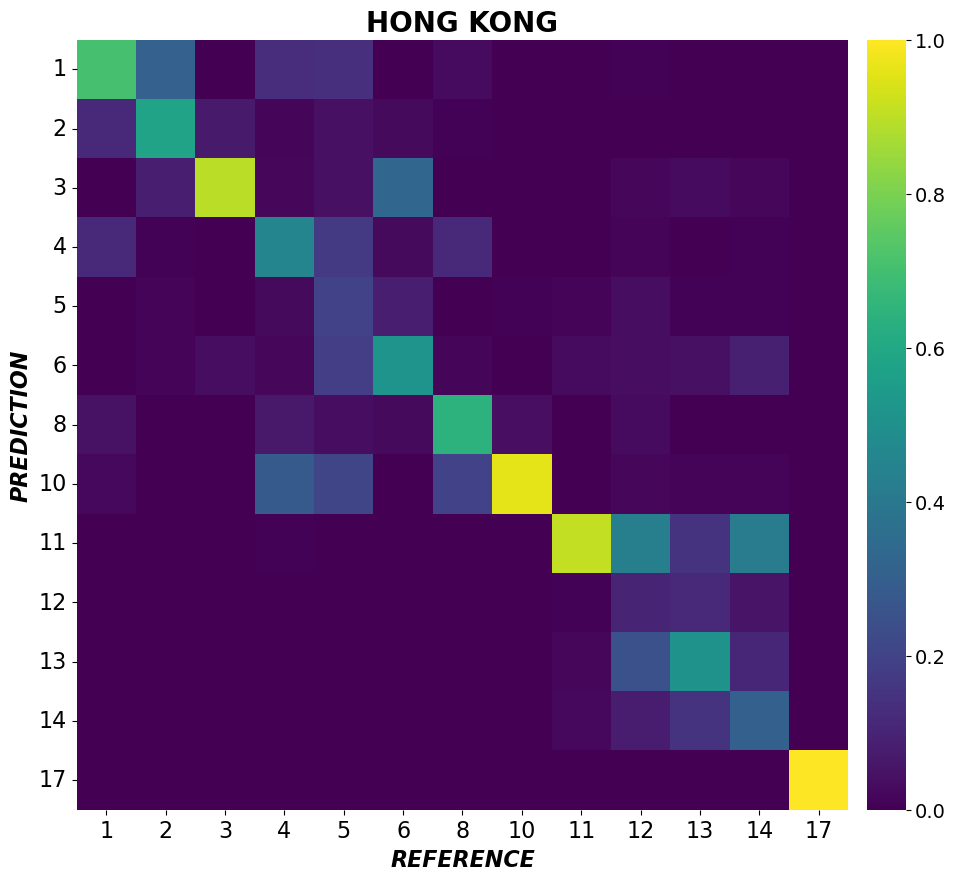

In [123]:
total_cm = None
for fold in results[best_setup][best_strategy]:
    fold_cm = results[best_setup][best_strategy][fold]["Confusion_Matrix"]
    if total_cm is None:
        total_cm = fold_cm.copy()
    else:
        total_cm += fold_cm

# Row Normalize
row_sums = total_cm.sum(axis=1)[:, np.newaxis]
norm_cm = total_cm.astype('float') / (row_sums + 1e-10)

plot_matrix = norm_cm.T 

plt.figure(figsize=(12, 10))
ordered_labels = sorted(splited_ref_data['gridcode'].unique())
ax = sns.heatmap(plot_matrix, 
            annot=False, 
            fmt='.2f', 
            cmap='viridis', 
            vmin=0.0,
            vmax=1.0,
            xticklabels=ordered_labels, 
            yticklabels=ordered_labels,
            cbar_kws={'pad': 0.02})
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=14)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16, rotation=0)
plt.xlabel('REFERENCE', fontsize=16, fontweight='bold', fontstyle='italic')
plt.ylabel('PREDICTION', fontsize=16, fontweight='bold', fontstyle='italic')        
plt.title('HONG KONG', fontweight='bold', fontsize=20)
plt.show()

In [128]:
# save the summed matrix
np.save(r"results\s3\hongkong_S3_summed_cm.npy", total_cm)

## Prediction

In [129]:
# which set was better?
better_set = non_weighted_set

# output
output = r'outputs\s3\hongkong_S3.tif'

In [130]:
# get best model of the best set and stategy
best_run = df.loc[best_setup, best_strategy]
best_fold = (best_run['wF1'] + best_run['F1U']).idxmax()
best_model = best_run.loc[best_fold, 'Model']
best_run[["wF1", "F1U", "F1N", "OA"]].loc[best_fold]

wF1    83.35
F1U    76.09
F1N    86.47
OA     84.71
Name: 3, dtype: float64

In [131]:
# run prediction
with rio.open(better_set) as image_data:
    image_meta = image_data.meta
    image = image_data.read()

image_reshaped = rio.plot.reshape_as_image(image)
scene = image_reshaped.reshape(-1, image_reshaped.shape[-1])
scene[np.isinf(scene)] = np.nan
y_pred = best_model.predict(scene)
classified_image = y_pred.reshape(image_reshaped.shape[0], image_reshaped.shape[1])
classification_meta = image_meta.copy()
classification_meta.update({"count": 1})
with rio.open(output, "w", **classification_meta) as dest:
    dest.write(classified_image, indexes=1)

# Paris

In [2]:
# load splited reference data
splited_ref_data = gpd.read_file(r'ref_data\paris_ref_splitS2S3S4.gpkg')

## Non-weighted RF S1 morphometric subset

In [3]:
# load fused image with subset of morphometrics from non-weighted RF S1 models
non_weighted_set = r'imagery\paris_20170526_morphometrics_meanminmax_grid.tif'

In [4]:
# results[setup][strategy][fold]
results = {
    setup: {
        strat: {
            fold: {} for fold in folds
        } for strat in strategies
    } for setup in setups
}

### Fold 0

In [5]:
fold = 0
test_polygons = splited_ref_data[splited_ref_data["fold"] == fold]
train_polygons = splited_ref_data[splited_ref_data["fold"] != fold]

In [6]:
train_polygons_raster = fr"paris_train_f{fold}.tif"
test_polygons_raster = fr"paris_test_f{fold}.tif"

utils.rasterize_reference_polygons(train_polygons, non_weighted_set, train_polygons_raster)
utils.rasterize_reference_polygons(test_polygons, non_weighted_set, test_polygons_raster)

In [7]:
with rio.open(non_weighted_set) as image_data:
    image_meta = image_data.meta
    image = image_data.read()

image_reshaped = rio.plot.reshape_as_image(image)
print(f'Image shape: {image.shape} -> {image_reshaped.shape}')

Image shape: (90, 972, 1011) -> (972, 1011, 90)


In [8]:
# train and test images matched to fusion 100m grid
train_image_matched = utils.match_rasters(train_polygons_raster, non_weighted_set)
test_image_matched = utils.match_rasters(test_polygons_raster, non_weighted_set)

train_image_matched = train_image_matched.to_numpy()
test_image_matched = test_image_matched.to_numpy()

C:\ProgramData\miniconda3\envs\geo\Lib\site-packages\xarray\core\duck_array_ops.py:250: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\ProgramData\miniconda3\envs\geo\Lib\site-packages\xarray\core\duck_array_ops.py:250: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


In [9]:
X_train = image_reshaped[train_image_matched > 0]
y_train = train_image_matched[train_image_matched > 0]
X_test = image_reshaped[test_image_matched > 0]
y_test = test_image_matched[test_image_matched > 0]

X_train[np.isinf(X_train)] = np.nan
X_test[np.isinf(X_test)] = np.nan

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(16131, 90) (16131,)
(3696, 90) (3696,)


#### Non/weighted RF model

In [ ]:
utils.finetune_height(X_train, y_train, X_test, y_test, max_height=10, class_weight=False)

In [ ]:
param, train, test, diff = utils.finetune_max_features(X_train, y_train, X_test, y_test, height=4, max_features=X_train.shape[1], class_weight=False)

In [34]:
param, train, test, diff

(2, 79.95, 78.93, 1.01)

In [10]:
model_fold0 = RandomForestClassifier(random_state=0, n_jobs=-1, max_depth=4, max_features=13, n_estimators=100)
model_fold0.fit(X_train, y_train)

RandomForestClassifier(max_depth=4, max_features=13, n_jobs=-1, random_state=0)

In [11]:
# training accuracy
pred_train = model_fold0.predict(X_train)
train_accuracy = accuracy_score(y_train, pred_train)
print('OA train: ', round(train_accuracy*100,2))
train_wf1 = f1_score(y_train, pred_train, average='weighted', labels=np.unique(y_train))
print('wF1 train: ', round(train_wf1*100,2))

OA train:  92.89
wF1 train:  90.98


In [12]:
# test accuracy
pred_test = model_fold0.predict(X_test)
test_accuracy = accuracy_score(y_test, pred_test)
print('OA test: ', round(test_accuracy*100,2))
test_wf1 = f1_score(y_test, pred_test, average='weighted', labels=np.unique(y_test))
print('wF1 test: ', round(test_wf1*100,2))

# F1U
X_test_urban = X_test[y_test<=10]
y_test_urban = y_test[y_test<=10]
y_test_pred_urb = model_fold0.predict(X_test_urban)
wf1_urb = f1_score(y_test_urban, y_test_pred_urb, average='weighted', labels=np.unique(y_test[y_test<=10]))
print('Urban wF1 test: ', round(wf1_urb*100,2))

# F1N
X_test_nat = X_test[y_test>10]
y_test_nat = y_test[y_test>10]
y_test_pred_nat = model_fold0.predict(X_test_nat)
wf1_nat = f1_score(y_test_nat, y_test_pred_nat, average='weighted', labels=np.unique(y_test[y_test>10]))
print('Natural wF1 test: ', round(wf1_nat*100,2))

conf_mat = confusion_matrix(y_test, pred_test, labels=sorted(splited_ref_data['gridcode'].unique()))

metrics = {
    "OA":  round(test_accuracy*100,2),
    "wF1": round(test_wf1*100,2),
    "F1U": round(wf1_urb*100,2),
    "F1N": round(wf1_nat*100,2),
    "Model": model_fold0,
    "Confusion_Matrix": conf_mat
}

for c in all_possible_classes:
    metrics[f"F1_Class_{c}"] = np.nan
f1_per_class_array = f1_score(y_test, pred_test, average=None, labels=np.unique(y_test))
for label, score in zip(np.unique(y_test), f1_per_class_array):
    if label in all_possible_classes:
        metrics[f"F1_Class_{int(label)}"] = round(score*100, 2)

results["non_weighted_set"]["non_weighted_model"][fold] = metrics

OA test:  87.91
wF1 test:  85.18
Urban wF1 test:  78.86
Natural wF1 test:  89.37


#### Weighted RF model

In [ ]:
utils.finetune_height(X_train, y_train, X_test, y_test, max_height=10, class_weight=True)

In [ ]:
param, train, test, diff = utils.finetune_max_features(X_train, y_train, X_test, y_test, height=4, max_features=X_train.shape[1], class_weight=True)

In [42]:
param, train, test, diff

(31, 58.17, 54.52, 3.65)

In [13]:
model_fold0_weighted = RandomForestClassifier(random_state=0, n_jobs=-1, max_depth=3, max_features=37, class_weight='balanced', n_estimators=100)
model_fold0_weighted.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=3, max_features=37,
                       n_jobs=-1, random_state=0)

In [14]:
# training accuracy
pred_train = model_fold0_weighted.predict(X_train)
train_accuracy = accuracy_score(y_train, pred_train)
print('OA train: ', round(train_accuracy*100,2))
train_wf1 = f1_score(y_train, pred_train, average='weighted', labels=np.unique(y_train))
print('wF1 train: ', round(train_wf1*100,2))

OA train:  71.82
wF1 train:  65.57


In [15]:
# test accuracy
pred_test = model_fold0_weighted.predict(X_test)
test_accuracy = accuracy_score(y_test, pred_test)
print('OA test: ', round(test_accuracy*100,2))
test_wf1 = f1_score(y_test, pred_test, average='weighted', labels=np.unique(y_test))
print('wF1 test: ', round(test_wf1*100,2))

# F1U
X_test_urban = X_test[y_test<=10]
y_test_urban = y_test[y_test<=10]
y_test_pred_urb = model_fold0_weighted.predict(X_test_urban)
wf1_urb = f1_score(y_test_urban, y_test_pred_urb, average='weighted', labels=np.unique(y_test[y_test<=10]))
print('Urban wF1 test: ', round(wf1_urb*100,2))

# F1N
X_test_nat = X_test[y_test>10]
y_test_nat = y_test[y_test>10]
y_test_pred_nat = model_fold0_weighted.predict(X_test_nat)
wf1_nat = f1_score(y_test_nat, y_test_pred_nat, average='weighted', labels=np.unique(y_test[y_test>10]))
print('Natural wF1 test: ', round(wf1_nat*100,2))

conf_mat = confusion_matrix(y_test, pred_test, labels=sorted(splited_ref_data['gridcode'].unique()))

metrics = {
    "OA":  round(test_accuracy*100,2),
    "wF1": round(test_wf1*100,2),
    "F1U": round(wf1_urb*100,2),
    "F1N": round(wf1_nat*100,2),
    "Model": model_fold0_weighted,
    "Confusion_Matrix": conf_mat
}

for c in all_possible_classes:
    metrics[f"F1_Class_{c}"] = np.nan
f1_per_class_array = f1_score(y_test, pred_test, average=None, labels=np.unique(y_test))
for label, score in zip(np.unique(y_test), f1_per_class_array):
    if label in all_possible_classes:
        metrics[f"F1_Class_{int(label)}"] = round(score*100, 2)

results["non_weighted_set"]["weighted_model"][fold] = metrics

OA test:  68.91
wF1 test:  63.85
Urban wF1 test:  71.17
Natural wF1 test:  63.48


### Fold 1

In [16]:
fold = 1
test_polygons = splited_ref_data[splited_ref_data["fold"] == fold]
train_polygons = splited_ref_data[splited_ref_data["fold"] != fold]

In [17]:
train_polygons_raster = fr"paris_train_f{fold}.tif"
test_polygons_raster = fr"paris_test_f{fold}.tif"

utils.rasterize_reference_polygons(train_polygons, non_weighted_set, train_polygons_raster)
utils.rasterize_reference_polygons(test_polygons, non_weighted_set, test_polygons_raster)

In [18]:
with rio.open(non_weighted_set) as image_data:
    image_meta = image_data.meta
    image = image_data.read()

image_reshaped = rio.plot.reshape_as_image(image)
print(f'Image shape: {image.shape} -> {image_reshaped.shape}')

Image shape: (90, 972, 1011) -> (972, 1011, 90)


In [19]:
# train and test images matched to fusion 100m grid
train_image_matched = utils.match_rasters(train_polygons_raster, non_weighted_set)
test_image_matched = utils.match_rasters(test_polygons_raster, non_weighted_set)

train_image_matched = train_image_matched.to_numpy()
test_image_matched = test_image_matched.to_numpy()

C:\ProgramData\miniconda3\envs\geo\Lib\site-packages\xarray\core\duck_array_ops.py:250: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\ProgramData\miniconda3\envs\geo\Lib\site-packages\xarray\core\duck_array_ops.py:250: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


In [20]:
X_train = image_reshaped[train_image_matched > 0]
y_train = train_image_matched[train_image_matched > 0]
X_test = image_reshaped[test_image_matched > 0]
y_test = test_image_matched[test_image_matched > 0]

X_train[np.isinf(X_train)] = np.nan
X_test[np.isinf(X_test)] = np.nan

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(14480, 90) (14480,)
(5347, 90) (5347,)


#### Non/weighted RF model

In [ ]:
utils.finetune_height(X_train, y_train, X_test, y_test, max_height=10, class_weight=False)

In [ ]:
param, train, test, diff = utils.finetune_max_features(X_train, y_train, X_test, y_test, height=4, max_features=X_train.shape[1], class_weight=False)

In [ ]:
param, train, test, diff

In [21]:
model_fold1 = RandomForestClassifier(random_state=0, n_jobs=-1, max_depth=12, max_features=15, n_estimators=100)
model_fold1.fit(X_train, y_train)

RandomForestClassifier(max_depth=12, max_features=15, n_jobs=-1, random_state=0)

In [22]:
# training accuracy
pred_train = model_fold1.predict(X_train)
train_accuracy = accuracy_score(y_train, pred_train)
print('OA train: ', round(train_accuracy*100,2))
train_wf1 = f1_score(y_train, pred_train, average='weighted', labels=np.unique(y_train))
print('wF1 train: ', round(train_wf1*100,2))

OA train:  99.66
wF1 train:  99.66


In [23]:
# test accuracy
pred_test = model_fold1.predict(X_test)
test_accuracy = accuracy_score(y_test, pred_test)
print('OA test: ', round(test_accuracy*100,2))
test_wf1 = f1_score(y_test, pred_test, average='weighted', labels=np.unique(y_test))
print('wF1 test: ', round(test_wf1*100,2))

# F1U
X_test_urban = X_test[y_test<=10]
y_test_urban = y_test[y_test<=10]
y_test_pred_urb = model_fold1.predict(X_test_urban)
wf1_urb = f1_score(y_test_urban, y_test_pred_urb, average='weighted', labels=np.unique(y_test[y_test<=10]))
print('Urban wF1 test: ', round(wf1_urb*100,2))

# F1N
X_test_nat = X_test[y_test>10]
y_test_nat = y_test[y_test>10]
y_test_pred_nat = model_fold1.predict(X_test_nat)
wf1_nat = f1_score(y_test_nat, y_test_pred_nat, average='weighted', labels=np.unique(y_test[y_test>10]))
print('Natural wF1 test: ', round(wf1_nat*100,2))

conf_mat = confusion_matrix(y_test, pred_test, labels=sorted(splited_ref_data['gridcode'].unique()))

metrics = {
    "OA":  round(test_accuracy*100,2),
    "wF1": round(test_wf1*100,2),
    "F1U": round(wf1_urb*100,2),
    "F1N": round(wf1_nat*100,2),
    "Model": model_fold1,
    "Confusion_Matrix": conf_mat
}

for c in all_possible_classes:
    metrics[f"F1_Class_{c}"] = np.nan
f1_per_class_array = f1_score(y_test, pred_test, average=None, labels=np.unique(y_test))
for label, score in zip(np.unique(y_test), f1_per_class_array):
    if label in all_possible_classes:
        metrics[f"F1_Class_{int(label)}"] = round(score*100, 2)

results["non_weighted_set"]["non_weighted_model"][fold] = metrics

OA test:  95.1
wF1 test:  94.58
Urban wF1 test:  93.41
Natural wF1 test:  96.07


#### Weighted RF model

In [ ]:
utils.finetune_height(X_train, y_train, X_test, y_test, max_height=10, class_weight=True)

In [ ]:
param, train, test, diff = utils.finetune_max_features(X_train, y_train, X_test, y_test, height=3, max_features=X_train.shape[1], class_weight=True)

In [ ]:
param, train, test, diff

In [24]:
model_fold1_weighted = RandomForestClassifier(random_state=0, n_jobs=-1, max_depth=11, max_features=9, class_weight='balanced', n_estimators=100)
model_fold1_weighted.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=11, max_features=9,
                       n_jobs=-1, random_state=0)

In [25]:
# training accuracy
pred_train = model_fold1_weighted.predict(X_train)
train_accuracy = accuracy_score(y_train, pred_train)
print('OA train: ', round(train_accuracy*100,2))
train_wf1 = f1_score(y_train, pred_train, average='weighted', labels=np.unique(y_train))
print('wF1 train: ', round(train_wf1*100,2))

OA train:  99.03
wF1 train:  99.05


In [26]:
# test accuracy
pred_test = model_fold1_weighted.predict(X_test)
test_accuracy = accuracy_score(y_test, pred_test)
print('OA test: ', round(test_accuracy*100,2))
test_wf1 = f1_score(y_test, pred_test, average='weighted', labels=np.unique(y_test))
print('wF1 test: ', round(test_wf1*100,2))

# F1U
X_test_urban = X_test[y_test<=10]
y_test_urban = y_test[y_test<=10]
y_test_pred_urb = model_fold1_weighted.predict(X_test_urban)
wf1_urb = f1_score(y_test_urban, y_test_pred_urb, average='weighted', labels=np.unique(y_test[y_test<=10]))
print('Urban wF1 test: ', round(wf1_urb*100,2))

# F1N
X_test_nat = X_test[y_test>10]
y_test_nat = y_test[y_test>10]
y_test_pred_nat = model_fold1_weighted.predict(X_test_nat)
wf1_nat = f1_score(y_test_nat, y_test_pred_nat, average='weighted', labels=np.unique(y_test[y_test>10]))
print('Natural wF1 test: ', round(wf1_nat*100,2))

conf_mat = confusion_matrix(y_test, pred_test, labels=sorted(splited_ref_data['gridcode'].unique()))

metrics = {
    "OA":  round(test_accuracy*100,2),
    "wF1": round(test_wf1*100,2),
    "F1U": round(wf1_urb*100,2),
    "F1N": round(wf1_nat*100,2),
    "Model": model_fold1_weighted,
    "Confusion_Matrix": conf_mat
}

for c in all_possible_classes:
    metrics[f"F1_Class_{c}"] = np.nan
f1_per_class_array = f1_score(y_test, pred_test, average=None, labels=np.unique(y_test))
for label, score in zip(np.unique(y_test), f1_per_class_array):
    if label in all_possible_classes:
        metrics[f"F1_Class_{int(label)}"] = round(score*100, 2)

results["non_weighted_set"]["weighted_model"][fold] = metrics

OA test:  95.4
wF1 test:  94.89
Urban wF1 test:  95.14
Natural wF1 test:  95.09


### Fold 2

In [27]:
fold = 2
test_polygons = splited_ref_data[splited_ref_data["fold"] == fold]
train_polygons = splited_ref_data[splited_ref_data["fold"] != fold]

In [28]:
train_polygons_raster = fr"paris_train_f{fold}.tif"
test_polygons_raster = fr"paris_test_f{fold}.tif"

utils.rasterize_reference_polygons(train_polygons, non_weighted_set, train_polygons_raster)
utils.rasterize_reference_polygons(test_polygons, non_weighted_set, test_polygons_raster)

In [29]:
with rio.open(non_weighted_set) as image_data:
    image_meta = image_data.meta
    image = image_data.read()

image_reshaped = rio.plot.reshape_as_image(image)
print(f'Image shape: {image.shape} -> {image_reshaped.shape}')

Image shape: (90, 972, 1011) -> (972, 1011, 90)


In [31]:
# train and test images matched to fusion 100m grid
train_image_matched = utils.match_rasters(train_polygons_raster, non_weighted_set)
test_image_matched = utils.match_rasters(test_polygons_raster, non_weighted_set)

train_image_matched = train_image_matched.to_numpy()
test_image_matched = test_image_matched.to_numpy()

C:\ProgramData\miniconda3\envs\geo\Lib\site-packages\xarray\core\duck_array_ops.py:250: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\ProgramData\miniconda3\envs\geo\Lib\site-packages\xarray\core\duck_array_ops.py:250: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


In [32]:
X_train = image_reshaped[train_image_matched > 0]
y_train = train_image_matched[train_image_matched > 0]
X_test = image_reshaped[test_image_matched > 0]
y_test = test_image_matched[test_image_matched > 0]

X_train[np.isinf(X_train)] = np.nan
X_test[np.isinf(X_test)] = np.nan

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(16758, 90) (16758,)
(3069, 90) (3069,)


#### Non/weighted RF model

In [ ]:
utils.finetune_height(X_train, y_train, X_test, y_test, max_height=10, class_weight=False)

In [ ]:
param, train, test, diff = utils.finetune_max_features(X_train, y_train, X_test, y_test, height=7, max_features=X_train.shape[1], class_weight=False)

In [76]:
param, train, test, diff

(6, 87.33, 82.49, 4.84)

In [33]:
model_fold2 = RandomForestClassifier(random_state=0, n_jobs=-1, max_depth=4, max_features=50, n_estimators=100)
model_fold2.fit(X_train, y_train)

RandomForestClassifier(max_depth=4, max_features=50, n_jobs=-1, random_state=0)

In [34]:
# training accuracy
pred_train = model_fold2.predict(X_train)
train_accuracy = accuracy_score(y_train, pred_train)
print('OA train: ', round(train_accuracy*100,2))
train_wf1 = f1_score(y_train, pred_train, average='weighted', labels=np.unique(y_train))
print('wF1 train: ', round(train_wf1*100,2))

OA train:  92.64
wF1 train:  90.66


In [35]:
# test accuracy
pred_test = model_fold2.predict(X_test)
test_accuracy = accuracy_score(y_test, pred_test)
print('OA test: ', round(test_accuracy*100,2))
test_wf1 = f1_score(y_test, pred_test, average='weighted', labels=np.unique(y_test))
print('wF1 test: ', round(test_wf1*100,2))

# F1U
X_test_urban = X_test[y_test<=10]
y_test_urban = y_test[y_test<=10]
y_test_pred_urb = model_fold2.predict(X_test_urban)
wf1_urb = f1_score(y_test_urban, y_test_pred_urb, average='weighted', labels=np.unique(y_test[y_test<=10]))
print('Urban wF1 test: ', round(wf1_urb*100,2))

# F1N
X_test_nat = X_test[y_test>10]
y_test_nat = y_test[y_test>10]
y_test_pred_nat = model_fold2.predict(X_test_nat)
wf1_nat = f1_score(y_test_nat, y_test_pred_nat, average='weighted', labels=np.unique(y_test[y_test>10]))
print('Natural wF1 test: ', round(wf1_nat*100,2))

conf_mat = confusion_matrix(y_test, pred_test, labels=sorted(splited_ref_data['gridcode'].unique()))

metrics = {
    "OA":  round(test_accuracy*100,2),
    "wF1": round(test_wf1*100,2),
    "F1U": round(wf1_urb*100,2),
    "F1N": round(wf1_nat*100,2),
    "Model": model_fold2,
    "Confusion_Matrix": conf_mat
}

for c in all_possible_classes:
    metrics[f"F1_Class_{c}"] = np.nan
f1_per_class_array = f1_score(y_test, pred_test, average=None, labels=np.unique(y_test))
for label, score in zip(np.unique(y_test), f1_per_class_array):
    if label in all_possible_classes:
        metrics[f"F1_Class_{int(label)}"] = round(score*100, 2)

results["non_weighted_set"]["non_weighted_model"][fold] = metrics

OA test:  88.33
wF1 test:  86.11
Urban wF1 test:  85.13
Natural wF1 test:  89.15


#### Weighted RF model

In [ ]:
utils.finetune_height(X_train, y_train, X_test, y_test, max_height=10, class_weight=True)

In [ ]:
param, train, test, diff = utils.finetune_max_features(X_train, y_train, X_test, y_test, height=8, max_features=X_train.shape[1], class_weight=True)

In [87]:
param, train, test, diff

(5, 86.05, 83.01, 3.04)

In [36]:
model_fold2_weighted = RandomForestClassifier(random_state=0, n_jobs=-1, max_depth=4, max_features=15, class_weight='balanced', n_estimators=100)
model_fold2_weighted.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=4, max_features=15,
                       n_jobs=-1, random_state=0)

In [37]:
# training accuracy
pred_train = model_fold2_weighted.predict(X_train)
train_accuracy = accuracy_score(y_train, pred_train)
print('OA train: ', round(train_accuracy*100,2))
train_wf1 = f1_score(y_train, pred_train, average='weighted', labels=np.unique(y_train))
print('wF1 train: ', round(train_wf1*100,2))

OA train:  85.27
wF1 train:  86.08


In [38]:
# test accuracy
pred_test = model_fold2_weighted.predict(X_test)
test_accuracy = accuracy_score(y_test, pred_test)
print('OA test: ', round(test_accuracy*100,2))
test_wf1 = f1_score(y_test, pred_test, average='weighted', labels=np.unique(y_test))
print('wF1 test: ', round(test_wf1*100,2))

# F1U
X_test_urban = X_test[y_test<=10]
y_test_urban = y_test[y_test<=10]
y_test_pred_urb = model_fold2_weighted.predict(X_test_urban)
wf1_urb = f1_score(y_test_urban, y_test_pred_urb, average='weighted', labels=np.unique(y_test[y_test<=10]))
print('Urban wF1 test: ', round(wf1_urb*100,2))

# F1N
X_test_nat = X_test[y_test>10]
y_test_nat = y_test[y_test>10]
y_test_pred_nat = model_fold2_weighted.predict(X_test_nat)
wf1_nat = f1_score(y_test_nat, y_test_pred_nat, average='weighted', labels=np.unique(y_test[y_test>10]))
print('Natural wF1 test: ', round(wf1_nat*100,2))

conf_mat = confusion_matrix(y_test, pred_test, labels=sorted(splited_ref_data['gridcode'].unique()))

metrics = {
    "OA":  round(test_accuracy*100,2),
    "wF1": round(test_wf1*100,2),
    "F1U": round(wf1_urb*100,2),
    "F1N": round(wf1_nat*100,2),
    "Model": model_fold2_weighted,
    "Confusion_Matrix": conf_mat
}

for c in all_possible_classes:
    metrics[f"F1_Class_{c}"] = np.nan
f1_per_class_array = f1_score(y_test, pred_test, average=None, labels=np.unique(y_test))
for label, score in zip(np.unique(y_test), f1_per_class_array):
    if label in all_possible_classes:
        metrics[f"F1_Class_{int(label)}"] = round(score*100, 2)

results["non_weighted_set"]["weighted_model"][fold] = metrics

OA test:  79.47
wF1 test:  81.35
Urban wF1 test:  83.2
Natural wF1 test:  82.01


### Fold 3

In [39]:
fold = 3
test_polygons = splited_ref_data[splited_ref_data["fold"] == fold]
train_polygons = splited_ref_data[splited_ref_data["fold"] != fold]

In [40]:
train_polygons_raster = fr"paris_train_f{fold}.tif"
test_polygons_raster = fr"paris_test_f{fold}.tif"

utils.rasterize_reference_polygons(train_polygons, non_weighted_set, train_polygons_raster)
utils.rasterize_reference_polygons(test_polygons, non_weighted_set, test_polygons_raster)

In [41]:
with rio.open(non_weighted_set) as image_data:
    image_meta = image_data.meta
    image = image_data.read()

image_reshaped = rio.plot.reshape_as_image(image)
print(f'Image shape: {image.shape} -> {image_reshaped.shape}')

Image shape: (90, 972, 1011) -> (972, 1011, 90)


In [42]:
# train and test images matched to fusion 100m grid
train_image_matched = utils.match_rasters(train_polygons_raster, non_weighted_set)
test_image_matched = utils.match_rasters(test_polygons_raster, non_weighted_set)

train_image_matched = train_image_matched.to_numpy()
test_image_matched = test_image_matched.to_numpy()

C:\ProgramData\miniconda3\envs\geo\Lib\site-packages\xarray\core\duck_array_ops.py:250: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\ProgramData\miniconda3\envs\geo\Lib\site-packages\xarray\core\duck_array_ops.py:250: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


In [43]:
X_train = image_reshaped[train_image_matched > 0]
y_train = train_image_matched[train_image_matched > 0]
X_test = image_reshaped[test_image_matched > 0]
y_test = test_image_matched[test_image_matched > 0]

X_train[np.isinf(X_train)] = np.nan
X_test[np.isinf(X_test)] = np.nan

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(16584, 90) (16584,)
(3243, 90) (3243,)


#### Non/weighted RF model

In [ ]:
utils.finetune_height(X_train, y_train, X_test, y_test, max_height=10, class_weight=False)

In [ ]:
param, train, test, diff = utils.finetune_max_features(X_train, y_train, X_test, y_test, height=7, max_features=X_train.shape[1], class_weight=False)

In [95]:
param, train, test, diff

(69, 89.65, 85.02, 4.63)

In [44]:
model_fold3 = utils.RandomForestClassifier(random_state=0, n_jobs=-1, max_depth=6, max_features=5, n_estimators=100)
model_fold3.fit(X_train, y_train)

RandomForestClassifier(max_depth=6, max_features=5, n_jobs=-1, random_state=0)

In [45]:
# training accuracy
pred_train = model_fold3.predict(X_train)
train_accuracy = accuracy_score(y_train, pred_train)
print('OA train: ', round(train_accuracy*100,2))
train_wf1 = f1_score(y_train, pred_train, average='weighted', labels=np.unique(y_train))
print('wF1 train: ', round(train_wf1*100,2))

OA train:  95.08
wF1 train:  94.32


In [46]:
# test accuracy
pred_test = model_fold3.predict(X_test)
test_accuracy = accuracy_score(y_test, pred_test)
print('OA test: ', round(test_accuracy*100,2))
test_wf1 = f1_score(y_test, pred_test, average='weighted', labels=np.unique(y_test))
print('wF1 test: ', round(test_wf1*100,2))

# F1U
X_test_urban = X_test[y_test<=10]
y_test_urban = y_test[y_test<=10]
y_test_pred_urb = model_fold3.predict(X_test_urban)
wf1_urb = f1_score(y_test_urban, y_test_pred_urb, average='weighted', labels=np.unique(y_test[y_test<=10]))
print('Urban wF1 test: ', round(wf1_urb*100,2))

# F1N
X_test_nat = X_test[y_test>10]
y_test_nat = y_test[y_test>10]
y_test_pred_nat = model_fold3.predict(X_test_nat)
wf1_nat = f1_score(y_test_nat, y_test_pred_nat, average='weighted', labels=np.unique(y_test[y_test>10]))
print('Natural wF1 test: ', round(wf1_nat*100,2))

conf_mat = confusion_matrix(y_test, pred_test, labels=sorted(splited_ref_data['gridcode'].unique()))

metrics = {
    "OA":  round(test_accuracy*100,2),
    "wF1": round(test_wf1*100,2),
    "F1U": round(wf1_urb*100,2),
    "F1N": round(wf1_nat*100,2),
    "Model": model_fold3,
    "Confusion_Matrix": conf_mat
}

for c in all_possible_classes:
    metrics[f"F1_Class_{c}"] = np.nan
f1_per_class_array = f1_score(y_test, pred_test, average=None, labels=np.unique(y_test))
for label, score in zip(np.unique(y_test), f1_per_class_array):
    if label in all_possible_classes:
        metrics[f"F1_Class_{int(label)}"] = round(score*100, 2)

results["non_weighted_set"]["non_weighted_model"][fold] = metrics

OA test:  90.32
wF1 test:  88.51
Urban wF1 test:  82.94
Natural wF1 test:  92.06


#### Weighted RF model

In [ ]:
utils.finetune_height(X_train, y_train, X_test, y_test, max_height=10, class_weight=True)

In [ ]:
param, train, test, diff = utils.finetune_max_features(X_train, y_train, X_test, y_test, height=9, max_features=X_train.shape[1], class_weight=True)

In [102]:
param, train, test, diff

(11, 88.6, 84.79, 3.8)

In [47]:
model_fold3_weighted = RandomForestClassifier(random_state=0, n_jobs=-1, max_depth=5, max_features=4, class_weight='balanced', n_estimators=100)
model_fold3_weighted.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=5, max_features=4,
                       n_jobs=-1, random_state=0)

In [48]:
# training accuracy
pred_train = model_fold3_weighted.predict(X_train)
train_accuracy = accuracy_score(y_train, pred_train)
print('OA train: ', round(train_accuracy*100,2))
train_wf1 = f1_score(y_train, pred_train, average='weighted', labels=np.unique(y_train))
print('wF1 train: ', round(train_wf1*100,2))

OA train:  90.97
wF1 train:  92.31


In [49]:
# test accuracy
pred_test = model_fold3_weighted.predict(X_test)
test_accuracy = accuracy_score(y_test, pred_test)
print('OA test: ', round(test_accuracy*100,2))
test_wf1 = f1_score(y_test, pred_test, average='weighted', labels=np.unique(y_test))
print('wF1 test: ', round(test_wf1*100,2))

# F1U
X_test_urban = X_test[y_test<=10]
y_test_urban = y_test[y_test<=10]
y_test_pred_urb = model_fold3_weighted.predict(X_test_urban)
wf1_urb = f1_score(y_test_urban, y_test_pred_urb, average='weighted', labels=np.unique(y_test[y_test<=10]))
print('Urban wF1 test: ', round(wf1_urb*100,2))

# F1N
X_test_nat = X_test[y_test>10]
y_test_nat = y_test[y_test>10]
y_test_pred_nat = model_fold3_weighted.predict(X_test_nat)
wf1_nat = f1_score(y_test_nat, y_test_pred_nat, average='weighted', labels=np.unique(y_test[y_test>10]))
print('Natural wF1 test: ', round(wf1_nat*100,2))

conf_mat = confusion_matrix(y_test, pred_test, labels=sorted(splited_ref_data['gridcode'].unique()))

metrics = {
    "OA":  round(test_accuracy*100,2),
    "wF1": round(test_wf1*100,2),
    "F1U": round(wf1_urb*100,2),
    "F1N": round(wf1_nat*100,2),
    "Model": model_fold3_weighted,
    "Confusion_Matrix": conf_mat
}

for c in all_possible_classes:
    metrics[f"F1_Class_{c}"] = np.nan
f1_per_class_array = f1_score(y_test, pred_test, average=None, labels=np.unique(y_test))
for label, score in zip(np.unique(y_test), f1_per_class_array):
    if label in all_possible_classes:
        metrics[f"F1_Class_{int(label)}"] = round(score*100, 2)

results["non_weighted_set"]["weighted_model"][fold] = metrics

OA test:  86.12
wF1 test:  87.76
Urban wF1 test:  76.94
Natural wF1 test:  92.69


### Fold 4

In [50]:
fold = 4
test_polygons = splited_ref_data[splited_ref_data["fold"] == fold]
train_polygons = splited_ref_data[splited_ref_data["fold"] != fold]

In [51]:
train_polygons_raster = fr"paris_train_f{fold}.tif"
test_polygons_raster = fr"paris_test_f{fold}.tif"

utils.rasterize_reference_polygons(train_polygons, non_weighted_set, train_polygons_raster)
utils.rasterize_reference_polygons(test_polygons, non_weighted_set, test_polygons_raster)

In [52]:
with rio.open(non_weighted_set) as image_data:
    image_meta = image_data.meta
    image = image_data.read()

image_reshaped = rio.plot.reshape_as_image(image)
print(f'Image shape: {image.shape} -> {image_reshaped.shape}')

Image shape: (90, 972, 1011) -> (972, 1011, 90)


In [53]:
# train and test images matched to fusion 100m grid
train_image_matched = utils.match_rasters(train_polygons_raster, non_weighted_set)
test_image_matched = utils.match_rasters(test_polygons_raster, non_weighted_set)

train_image_matched = train_image_matched.to_numpy()
test_image_matched = test_image_matched.to_numpy()

C:\ProgramData\miniconda3\envs\geo\Lib\site-packages\xarray\core\duck_array_ops.py:250: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\ProgramData\miniconda3\envs\geo\Lib\site-packages\xarray\core\duck_array_ops.py:250: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


In [54]:
X_train = image_reshaped[train_image_matched > 0]
y_train = train_image_matched[train_image_matched > 0]
X_test = image_reshaped[test_image_matched > 0]
y_test = test_image_matched[test_image_matched > 0]

X_train[np.isinf(X_train)] = np.nan
X_test[np.isinf(X_test)] = np.nan

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(15355, 90) (15355,)
(4472, 90) (4472,)


#### Non/weighted RF model

In [ ]:
utils.finetune_height(X_train, y_train, X_test, y_test, max_height=10, class_weight=False)

In [ ]:
param, train, test, diff = utils.finetune_max_features(X_train, y_train, X_test, y_test, height=6, max_features=X_train.shape[1], class_weight=False)

In [115]:
param, train, test, diff

(8, 86.44, 82.9, 3.54)

In [55]:
model_fold4 = RandomForestClassifier(random_state=0, n_jobs=-1, max_depth=13, max_features=34, n_estimators=100)
model_fold4.fit(X_train, y_train)

RandomForestClassifier(max_depth=13, max_features=34, n_jobs=-1, random_state=0)

In [56]:
# training accuracy
pred_train = model_fold4.predict(X_train)
train_accuracy = accuracy_score(y_train, pred_train)
print('OA train: ', round(train_accuracy*100,2))
train_wf1 = f1_score(y_train, pred_train, average='weighted', labels=np.unique(y_train))
print('wF1 train: ', round(train_wf1*100,2))

OA train:  99.8
wF1 train:  99.8


In [57]:
# test accuracy
pred_test = model_fold4.predict(X_test)
test_accuracy = accuracy_score(y_test, pred_test)
print('OA test: ', round(test_accuracy*100,2))
test_wf1 = f1_score(y_test, pred_test, average='weighted', labels=np.unique(y_test))
print('wF1 test: ', round(test_wf1*100,2))

# F1U
X_test_urban = X_test[y_test<=10]
y_test_urban = y_test[y_test<=10]
y_test_pred_urb = model_fold4.predict(X_test_urban)
wf1_urb = f1_score(y_test_urban, y_test_pred_urb, average='weighted', labels=np.unique(y_test[y_test<=10]))
print('Urban wF1 test: ', round(wf1_urb*100,2))

# F1N
X_test_nat = X_test[y_test>10]
y_test_nat = y_test[y_test>10]
y_test_pred_nat = model_fold4.predict(X_test_nat)
wf1_nat = f1_score(y_test_nat, y_test_pred_nat, average='weighted', labels=np.unique(y_test[y_test>10]))
print('Natural wF1 test: ', round(wf1_nat*100,2))

conf_mat = confusion_matrix(y_test, pred_test, labels=sorted(splited_ref_data['gridcode'].unique()))

metrics = {
    "OA":  round(test_accuracy*100,2),
    "wF1": round(test_wf1*100,2),
    "F1U": round(wf1_urb*100,2),
    "F1N": round(wf1_nat*100,2),
    "Model": model_fold4,
    "Confusion_Matrix": conf_mat
}

for c in all_possible_classes:
    metrics[f"F1_Class_{c}"] = np.nan
f1_per_class_array = f1_score(y_test, pred_test, average=None, labels=np.unique(y_test))
for label, score in zip(np.unique(y_test), f1_per_class_array):
    if label in all_possible_classes:
        metrics[f"F1_Class_{int(label)}"] = round(score*100, 2)

results["non_weighted_set"]["non_weighted_model"][fold] = metrics

OA test:  95.33
wF1 test:  94.86
Urban wF1 test:  92.63
Natural wF1 test:  96.53


#### Weighted RF model

In [ ]:
utils.finetune_height(X_train, y_train, X_test, y_test, max_height=10, class_weight=True)

In [ ]:
param, train, test, diff = utils.finetune_max_features(X_train, y_train, X_test, y_test, height=5, max_features=X_train.shape[1], class_weight=True)

In [124]:
param, train, test, diff

(11, 78.4, 74.37, 4.03)

In [58]:
model_fold4_weighted = RandomForestClassifier(random_state=0, n_jobs=-1, max_depth=13, max_features=27, class_weight='balanced', n_estimators=100)
model_fold4_weighted.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=13, max_features=27,
                       n_jobs=-1, random_state=0)

In [59]:
# training accuracy
pred_train = model_fold4_weighted.predict(X_train)
train_accuracy = accuracy_score(y_train, pred_train)
print('OA train: ', round(train_accuracy*100,2))
train_wf1 = f1_score(y_train, pred_train, average='weighted', labels=np.unique(y_train))
print('wF1 train: ', round(train_wf1*100,2))

OA train:  99.21
wF1 train:  99.22


In [60]:
# test accuracy
pred_test = model_fold4_weighted.predict(X_test)
test_accuracy = accuracy_score(y_test, pred_test)
print('OA test: ', round(test_accuracy*100,2))
test_wf1 = f1_score(y_test, pred_test, average='weighted', labels=np.unique(y_test))
print('wF1 test: ', round(test_wf1*100,2))

# F1U
X_test_urban = X_test[y_test<=10]
y_test_urban = y_test[y_test<=10]
y_test_pred_urb = model_fold4_weighted.predict(X_test_urban)
wf1_urb = f1_score(y_test_urban, y_test_pred_urb, average='weighted', labels=np.unique(y_test[y_test<=10]))
print('Urban wF1 test: ', round(wf1_urb*100,2))

# F1N
X_test_nat = X_test[y_test>10]
y_test_nat = y_test[y_test>10]
y_test_pred_nat = model_fold4_weighted.predict(X_test_nat)
wf1_nat = f1_score(y_test_nat, y_test_pred_nat, average='weighted', labels=np.unique(y_test[y_test>10]))
print('Natural wF1 test: ', round(wf1_nat*100,2))

conf_mat = confusion_matrix(y_test, pred_test, labels=sorted(splited_ref_data['gridcode'].unique()))

metrics = {
    "OA":  round(test_accuracy*100,2),
    "wF1": round(test_wf1*100,2),
    "F1U": round(wf1_urb*100,2),
    "F1N": round(wf1_nat*100,2),
    "Model": model_fold4_weighted,
    "Confusion_Matrix": conf_mat
}

for c in all_possible_classes:
    metrics[f"F1_Class_{c}"] = np.nan
f1_per_class_array = f1_score(y_test, pred_test, average=None, labels=np.unique(y_test))
for label, score in zip(np.unique(y_test), f1_per_class_array):
    if label in all_possible_classes:
        metrics[f"F1_Class_{int(label)}"] = round(score*100, 2)

results["non_weighted_set"]["weighted_model"][fold] = metrics

OA test:  95.84
wF1 test:  95.44
Urban wF1 test:  94.06
Natural wF1 test:  96.78


## Weighted RF S1 morphometric subset

In [61]:
# load fused image with subset of morphometrics from weighted RF S1 models
weighted_set = r'imagery\paris_20170526_morphometrics_weighted_meanminmax_grid.tif'

### Fold 0

In [62]:
fold = 0
test_polygons = splited_ref_data[splited_ref_data["fold"] == fold]
train_polygons = splited_ref_data[splited_ref_data["fold"] != fold]

In [66]:
train_polygons_raster = fr"paris_train_f{fold}.tif"
test_polygons_raster = fr"paris_test_f{fold}.tif"

#utils.rasterize_reference_polygons(train_polygons, weighted_set, train_polygons_raster)
#utils.rasterize_reference_polygons(test_polygons, weighted_set, test_polygons_raster)

In [67]:
with rio.open(weighted_set) as image_data:
    image_meta = image_data.meta
    image = image_data.read()

image_reshaped = rio.plot.reshape_as_image(image)
print(f'Image shape: {image.shape} -> {image_reshaped.shape}')

Image shape: (90, 972, 1011) -> (972, 1011, 90)


In [69]:
# train and test images matched to fusion 100m grid
train_image_matched = utils.match_rasters(train_polygons_raster, weighted_set)
test_image_matched = utils.match_rasters(test_polygons_raster, weighted_set)

train_image_matched = train_image_matched.to_numpy()
test_image_matched = test_image_matched.to_numpy()

C:\ProgramData\miniconda3\envs\geo\Lib\site-packages\xarray\core\duck_array_ops.py:250: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\ProgramData\miniconda3\envs\geo\Lib\site-packages\xarray\core\duck_array_ops.py:250: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


In [70]:
X_train = image_reshaped[train_image_matched > 0]
y_train = train_image_matched[train_image_matched > 0]
X_test = image_reshaped[test_image_matched > 0]
y_test = test_image_matched[test_image_matched > 0]

X_train[np.isinf(X_train)] = np.nan
X_test[np.isinf(X_test)] = np.nan

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(16131, 90) (16131,)
(3696, 90) (3696,)


#### Non/weighted RF model

In [ ]:
utils.finetune_height(X_train, y_train, X_test, y_test, max_height=10, class_weight=False)

In [ ]:
param, train, test, diff = utils.finetune_max_features(X_train, y_train, X_test, y_test, height=5, max_features=X_train.shape[1], class_weight=False)

In [146]:
param, train, test, diff

(1, 81.27, 78.91, 2.36)

In [71]:
ws_model_fold0 = RandomForestClassifier(random_state=0, n_jobs=-1, max_depth=5, max_features=2, n_estimators=100)
ws_model_fold0.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, max_features=2, n_jobs=-1, random_state=0)

In [72]:
# training accuracy
pred_train = ws_model_fold0.predict(X_train)
train_accuracy = accuracy_score(y_train, pred_train)
print('OA train: ', round(train_accuracy*100,2))
train_wf1 = f1_score(y_train, pred_train, average='weighted', labels=np.unique(y_train))
print('wF1 train: ', round(train_wf1*100,2))

OA train:  86.9
wF1 train:  82.9


In [73]:
# test accuracy
pred_test = ws_model_fold0.predict(X_test)
test_accuracy = accuracy_score(y_test, pred_test)
print('OA test: ', round(test_accuracy*100,2))
test_wf1 = f1_score(y_test, pred_test, average='weighted', labels=np.unique(y_test))
print('wF1 test: ', round(test_wf1*100,2))

# F1U
X_test_urban = X_test[y_test<=10]
y_test_urban = y_test[y_test<=10]
y_test_pred_urb = ws_model_fold0.predict(X_test_urban)
wf1_urb = f1_score(y_test_urban, y_test_pred_urb, average='weighted', labels=np.unique(y_test[y_test<=10]))
print('Urban wF1 test: ', round(wf1_urb*100,2))

# F1N
X_test_nat = X_test[y_test>10]
y_test_nat = y_test[y_test>10]
y_test_pred_nat = ws_model_fold0.predict(X_test_nat)
wf1_nat = f1_score(y_test_nat, y_test_pred_nat, average='weighted', labels=np.unique(y_test[y_test>10]))
print('Natural wF1 test: ', round(wf1_nat*100,2))

conf_mat = confusion_matrix(y_test, pred_test, labels=sorted(splited_ref_data['gridcode'].unique()))

metrics = {
    "OA":  round(test_accuracy*100,2),
    "wF1": round(test_wf1*100,2),
    "F1U": round(wf1_urb*100,2),
    "F1N": round(wf1_nat*100,2),
    "Model": ws_model_fold0,
    "Confusion_Matrix": conf_mat
}

for c in all_possible_classes:
    metrics[f"F1_Class_{c}"] = np.nan
f1_per_class_array = f1_score(y_test, pred_test, average=None, labels=np.unique(y_test))
for label, score in zip(np.unique(y_test), f1_per_class_array):
    if label in all_possible_classes:
        metrics[f"F1_Class_{int(label)}"] = round(score*100, 2)
        
results["weighted_set"]["non_weighted_model"][fold] = metrics

OA test:  81.93
wF1 test:  77.63
Urban wF1 test:  53.69
Natural wF1 test:  90.39


#### Weighted RF model

In [ ]:
utils.finetune_height(X_train, y_train, X_test, y_test, max_height=10, class_weight=True)

In [ ]:
param, train, test, diff = utils.finetune_max_features(X_train, y_train, X_test, y_test, height=5, max_features=X_train.shape[1], class_weight=True)

In [152]:
param, train, test, diff

(41, 61.59, 57.0, 4.59)

In [74]:
ws_model_fold0_weighted = RandomForestClassifier(random_state=0, n_jobs=-1, max_depth=5, max_features=56, class_weight='balanced', n_estimators=100)
ws_model_fold0_weighted.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=5, max_features=56,
                       n_jobs=-1, random_state=0)

In [75]:
# training accuracy
pred_train = ws_model_fold0_weighted.predict(X_train)
train_accuracy = accuracy_score(y_train, pred_train)
print('OA train: ', round(train_accuracy*100,2))
train_wf1 = f1_score(y_train, pred_train, average='weighted', labels=np.unique(y_train))
print('wF1 train: ', round(train_wf1*100,2))

OA train:  83.91
wF1 train:  85.37


In [76]:
# test accuracy
pred_test = ws_model_fold0_weighted.predict(X_test)
test_accuracy = accuracy_score(y_test, pred_test)
print('OA test: ', round(test_accuracy*100,2))
test_wf1 = f1_score(y_test, pred_test, average='weighted', labels=np.unique(y_test))
print('wF1 test: ', round(test_wf1*100,2))

# F1U
X_test_urban = X_test[y_test<=10]
y_test_urban = y_test[y_test<=10]
y_test_pred_urb = ws_model_fold0_weighted.predict(X_test_urban)
wf1_urb = f1_score(y_test_urban, y_test_pred_urb, average='weighted', labels=np.unique(y_test[y_test<=10]))
print('Urban wF1 test: ', round(wf1_urb*100,2))

# F1N
X_test_nat = X_test[y_test>10]
y_test_nat = y_test[y_test>10]
y_test_pred_nat = ws_model_fold0_weighted.predict(X_test_nat)
wf1_nat = f1_score(y_test_nat, y_test_pred_nat, average='weighted', labels=np.unique(y_test[y_test>10]))
print('Natural wF1 test: ', round(wf1_nat*100,2))

conf_mat = confusion_matrix(y_test, pred_test, labels=sorted(splited_ref_data['gridcode'].unique()))

metrics = {
    "OA":  round(test_accuracy*100,2),
    "wF1": round(test_wf1*100,2),
    "F1U": round(wf1_urb*100,2),
    "F1N": round(wf1_nat*100,2),
    "Model": ws_model_fold0_weighted,
    "Confusion_Matrix": conf_mat
}

for c in all_possible_classes:
    metrics[f"F1_Class_{c}"] = np.nan
f1_per_class_array = f1_score(y_test, pred_test, average=None, labels=np.unique(y_test))
for label, score in zip(np.unique(y_test), f1_per_class_array):
    if label in all_possible_classes:
        metrics[f"F1_Class_{int(label)}"] = round(score*100, 2)

results["weighted_set"]["weighted_model"][fold] = metrics

OA test:  78.52
wF1 test:  80.48
Urban wF1 test:  60.28
Natural wF1 test:  90.4


### Fold 1

In [77]:
fold = 1
test_polygons = splited_ref_data[splited_ref_data["fold"] == fold]
train_polygons = splited_ref_data[splited_ref_data["fold"] != fold]

In [78]:
train_polygons_raster = fr"paris_train_f{fold}.tif"
test_polygons_raster = fr"paris_test_f{fold}.tif"

#utils.rasterize_reference_polygons(train_polygons, weighted_set, train_polygons_raster)
#utils.rasterize_reference_polygons(test_polygons, weighted_set, test_polygons_raster)

In [79]:
with rio.open(weighted_set) as image_data:
    image_meta = image_data.meta
    image = image_data.read()

image_reshaped = rio.plot.reshape_as_image(image)
print(f'Image shape: {image.shape} -> {image_reshaped.shape}')

Image shape: (90, 972, 1011) -> (972, 1011, 90)


In [80]:
# train and test images matched to fusion 100m grid
train_image_matched = utils.match_rasters(train_polygons_raster, weighted_set)
test_image_matched = utils.match_rasters(test_polygons_raster, weighted_set)

train_image_matched = train_image_matched.to_numpy()
test_image_matched = test_image_matched.to_numpy()

C:\ProgramData\miniconda3\envs\geo\Lib\site-packages\xarray\core\duck_array_ops.py:250: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\ProgramData\miniconda3\envs\geo\Lib\site-packages\xarray\core\duck_array_ops.py:250: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


In [81]:
X_train = image_reshaped[train_image_matched > 0]
y_train = train_image_matched[train_image_matched > 0]
X_test = image_reshaped[test_image_matched > 0]
y_test = test_image_matched[test_image_matched > 0]

X_train[np.isinf(X_train)] = np.nan
X_test[np.isinf(X_test)] = np.nan

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(14480, 90) (14480,)
(5347, 90) (5347,)


#### Non/weighted RF model

In [ ]:
utils.finetune_height(X_train, y_train, X_test, y_test, max_height=10, class_weight=False)

In [ ]:
param, train, test, diff = utils.finetune_max_features(X_train, y_train, X_test, y_test, height=4, max_features=X_train.shape[1], class_weight=False)

In [165]:
param, train, test, diff

(1, 80.24, 75.71, 4.54)

In [82]:
ws_model_fold1 = RandomForestClassifier(random_state=0, n_jobs=-1, max_depth=10, max_features=3, n_estimators=100)
ws_model_fold1.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, max_features=3, n_jobs=-1, random_state=0)

In [83]:
# training accuracy
pred_train = ws_model_fold1.predict(X_train)
train_accuracy = accuracy_score(y_train, pred_train)
print('OA train: ', round(train_accuracy*100,2))
train_wf1 = f1_score(y_train, pred_train, average='weighted', labels=np.unique(y_train))
print('wF1 train: ', round(train_wf1*100,2))

OA train:  93.67
wF1 train:  92.95


In [84]:
# test accuracy
pred_test = ws_model_fold1.predict(X_test)
test_accuracy = accuracy_score(y_test, pred_test)
print('OA test: ', round(test_accuracy*100,2))
test_wf1 = f1_score(y_test, pred_test, average='weighted', labels=np.unique(y_test))
print('wF1 test: ', round(test_wf1*100,2))

# F1U
X_test_urban = X_test[y_test<=10]
y_test_urban = y_test[y_test<=10]
y_test_pred_urb = ws_model_fold1.predict(X_test_urban)
wf1_urb = f1_score(y_test_urban, y_test_pred_urb, average='weighted', labels=np.unique(y_test[y_test<=10]))
print('Urban wF1 test: ', round(wf1_urb*100,2))

# F1N
X_test_nat = X_test[y_test>10]
y_test_nat = y_test[y_test>10]
y_test_pred_nat = ws_model_fold1.predict(X_test_nat)
wf1_nat = f1_score(y_test_nat, y_test_pred_nat, average='weighted', labels=np.unique(y_test[y_test>10]))
print('Natural wF1 test: ', round(wf1_nat*100,2))

conf_mat = confusion_matrix(y_test, pred_test, labels=sorted(splited_ref_data['gridcode'].unique()))

metrics = {
    "OA":  round(test_accuracy*100,2),
    "wF1": round(test_wf1*100,2),
    "F1U": round(wf1_urb*100,2),
    "F1N": round(wf1_nat*100,2),
    "Model": ws_model_fold1,
    "Confusion_Matrix": conf_mat
}

for c in all_possible_classes:
    metrics[f"F1_Class_{c}"] = np.nan
f1_per_class_array = f1_score(y_test, pred_test, average=None, labels=np.unique(y_test))
for label, score in zip(np.unique(y_test), f1_per_class_array):
    if label in all_possible_classes:
        metrics[f"F1_Class_{int(label)}"] = round(score*100, 2)

results["weighted_set"]["non_weighted_model"][fold] = metrics

OA test:  89.0
wF1 test:  88.62
Urban wF1 test:  81.49
Natural wF1 test:  96.52


#### Weighted RF model

In [ ]:
utils.finetune_height(X_train, y_train, X_test, y_test, max_height=10, class_weight=True)

In [ ]:
param, train, test, diff = utils.finetune_max_features(X_train, y_train, X_test, y_test, height=5, max_features=X_train.shape[1], class_weight=True)

In [173]:
param, train, test, diff

(13, 78.84, 74.98, 3.86)

In [85]:
ws_model_fold1_weighted = RandomForestClassifier(random_state=0, n_jobs=-1, max_depth=9, max_features=4, class_weight='balanced', n_estimators=100)
ws_model_fold1_weighted.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=9, max_features=4,
                       n_jobs=-1, random_state=0)

In [86]:
# training accuracy
pred_train = ws_model_fold1_weighted.predict(X_train)
train_accuracy = accuracy_score(y_train, pred_train)
print('OA train: ', round(train_accuracy*100,2))
train_wf1 = f1_score(y_train, pred_train, average='weighted', labels=np.unique(y_train))
print('wF1 train: ', round(train_wf1*100,2))

OA train:  91.06
wF1 train:  91.8


In [87]:
# test accuracy
pred_test = ws_model_fold1_weighted.predict(X_test)
test_accuracy = accuracy_score(y_test, pred_test)
print('OA test: ', round(test_accuracy*100,2))
test_wf1 = f1_score(y_test, pred_test, average='weighted', labels=np.unique(y_test))
print('wF1 test: ', round(test_wf1*100,2))

# F1U
X_test_urban = X_test[y_test<=10]
y_test_urban = y_test[y_test<=10]
y_test_pred_urb = ws_model_fold1_weighted.predict(X_test_urban)
wf1_urb = f1_score(y_test_urban, y_test_pred_urb, average='weighted', labels=np.unique(y_test[y_test<=10]))
print('Urban wF1 test: ', round(wf1_urb*100,2))

# F1N
X_test_nat = X_test[y_test>10]
y_test_nat = y_test[y_test>10]
y_test_pred_nat = ws_model_fold1_weighted.predict(X_test_nat)
wf1_nat = f1_score(y_test_nat, y_test_pred_nat, average='weighted', labels=np.unique(y_test[y_test>10]))
print('Natural wF1 test: ', round(wf1_nat*100,2))

conf_mat = confusion_matrix(y_test, pred_test, labels=sorted(splited_ref_data['gridcode'].unique()))

metrics = {
    "OA":  round(test_accuracy*100,2),
    "wF1": round(test_wf1*100,2),
    "F1U": round(wf1_urb*100,2),
    "F1N": round(wf1_nat*100,2),
    "Model": ws_model_fold1_weighted,
    "Confusion_Matrix": conf_mat
}

for c in all_possible_classes:
    metrics[f"F1_Class_{c}"] = np.nan
f1_per_class_array = f1_score(y_test, pred_test, average=None, labels=np.unique(y_test))
for label, score in zip(np.unique(y_test), f1_per_class_array):
    if label in all_possible_classes:
        metrics[f"F1_Class_{int(label)}"] = round(score*100, 2)

results["weighted_set"]["weighted_model"][fold] = metrics

OA test:  86.27
wF1 test:  88.54
Urban wF1 test:  81.36
Natural wF1 test:  96.36


### Fold 2

In [88]:
fold = 2
test_polygons = splited_ref_data[splited_ref_data["fold"] == fold]
train_polygons = splited_ref_data[splited_ref_data["fold"] != fold]

In [89]:
train_polygons_raster = fr"paris_train_f{fold}.tif"
test_polygons_raster = fr"paris_test_f{fold}.tif"

#utils.rasterize_reference_polygons(train_polygons, weighted_set, train_polygons_raster)
#utils.rasterize_reference_polygons(test_polygons, weighted_set, test_polygons_raster)

In [90]:
with rio.open(weighted_set) as image_data:
    image_meta = image_data.meta
    image = image_data.read()

image_reshaped = rio.plot.reshape_as_image(image)
print(f'Image shape: {image.shape} -> {image_reshaped.shape}')

Image shape: (90, 972, 1011) -> (972, 1011, 90)


In [91]:
# train and test images matched to fusion 100m grid
train_image_matched = utils.match_rasters(train_polygons_raster, weighted_set)
test_image_matched = utils.match_rasters(test_polygons_raster, weighted_set)

train_image_matched = train_image_matched.to_numpy()
test_image_matched = test_image_matched.to_numpy()

C:\ProgramData\miniconda3\envs\geo\Lib\site-packages\xarray\core\duck_array_ops.py:250: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\ProgramData\miniconda3\envs\geo\Lib\site-packages\xarray\core\duck_array_ops.py:250: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


In [92]:
X_train = image_reshaped[train_image_matched > 0]
y_train = train_image_matched[train_image_matched > 0]
X_test = image_reshaped[test_image_matched > 0]
y_test = test_image_matched[test_image_matched > 0]

X_train[np.isinf(X_train)] = np.nan
X_test[np.isinf(X_test)] = np.nan

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(16758, 90) (16758,)
(3069, 90) (3069,)


#### Non/weighted RF model

In [ ]:
utils.finetune_height(X_train, y_train, X_test, y_test, max_height=10, class_weight=False)

In [ ]:
param, train, test, diff = utils.finetune_max_features(X_train, y_train, X_test, y_test, height=6, max_features=X_train.shape[1], class_weight=False)

In [186]:
param, train, test, diff

(47, 87.77, 84.02, 3.75)

In [93]:
ws_model_fold2 = RandomForestClassifier(random_state=0, n_jobs=-1, max_depth=8, max_features=3, n_estimators=100)
ws_model_fold2.fit(X_train, y_train)

RandomForestClassifier(max_depth=8, max_features=3, n_jobs=-1, random_state=0)

In [94]:
# training accuracy
pred_train = ws_model_fold2.predict(X_train)
train_accuracy = accuracy_score(y_train, pred_train)
print('OA train: ', round(train_accuracy*100,2))
train_wf1 = f1_score(y_train, pred_train, average='weighted', labels=np.unique(y_train))
print('wF1 train: ', round(train_wf1*100,2))

OA train:  90.84
wF1 train:  88.86


In [95]:
# test accuracy
pred_test = ws_model_fold2.predict(X_test)
test_accuracy = accuracy_score(y_test, pred_test)
print('OA test: ', round(test_accuracy*100,2))
test_wf1 = f1_score(y_test, pred_test, average='weighted', labels=np.unique(y_test))
print('wF1 test: ', round(test_wf1*100,2))

# F1U
X_test_urban = X_test[y_test<=10]
y_test_urban = y_test[y_test<=10]
y_test_pred_urb = ws_model_fold2.predict(X_test_urban)
wf1_urb = f1_score(y_test_urban, y_test_pred_urb, average='weighted', labels=np.unique(y_test[y_test<=10]))
print('Urban wF1 test: ', round(wf1_urb*100,2))

# F1N
X_test_nat = X_test[y_test>10]
y_test_nat = y_test[y_test>10]
y_test_pred_nat = ws_model_fold2.predict(X_test_nat)
wf1_nat = f1_score(y_test_nat, y_test_pred_nat, average='weighted', labels=np.unique(y_test[y_test>10]))
print('Natural wF1 test: ', round(wf1_nat*100,2))

conf_mat = confusion_matrix(y_test, pred_test, labels=sorted(splited_ref_data['gridcode'].unique()))

metrics = {
    "OA":  round(test_accuracy*100,2),
    "wF1": round(test_wf1*100,2),
    "F1U": round(wf1_urb*100,2),
    "F1N": round(wf1_nat*100,2),
    "Model": ws_model_fold2,
    "Confusion_Matrix": conf_mat
}

for c in all_possible_classes:
    metrics[f"F1_Class_{c}"] = np.nan
f1_per_class_array = f1_score(y_test, pred_test, average=None, labels=np.unique(y_test))
for label, score in zip(np.unique(y_test), f1_per_class_array):
    if label in all_possible_classes:
        metrics[f"F1_Class_{int(label)}"] = round(score*100, 2)

results["weighted_set"]["non_weighted_model"][fold] = metrics

OA test:  85.89
wF1 test:  83.28
Urban wF1 test:  67.21
Natural wF1 test:  93.64


#### Weighted RF model

In [ ]:
utils.finetune_height(X_train, y_train, X_test, y_test, max_height=10, class_weight=True)

In [ ]:
param, train, test, diff = utils.finetune_max_features(X_train, y_train, X_test, y_test, height=8, max_features=X_train.shape[1], class_weight=True)

In [193]:
param, train, test, diff

(19, 87.17, 82.47, 4.7)

In [96]:
ws_model_fold2_weighted = RandomForestClassifier(random_state=0, n_jobs=-1, max_depth=3, max_features=28, class_weight='balanced', n_estimators=100)
ws_model_fold2_weighted.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=3, max_features=28,
                       n_jobs=-1, random_state=0)

In [97]:
# training accuracy
pred_train = ws_model_fold2_weighted.predict(X_train)
train_accuracy = accuracy_score(y_train, pred_train)
print('OA train: ', round(train_accuracy*100,2))
train_wf1 = f1_score(y_train, pred_train, average='weighted', labels=np.unique(y_train))
print('wF1 train: ', round(train_wf1*100,2))

OA train:  69.36
wF1 train:  74.06


In [98]:
# test accuracy
pred_test = ws_model_fold2_weighted.predict(X_test)
test_accuracy = accuracy_score(y_test, pred_test)
print('OA test: ', round(test_accuracy*100,2))
test_wf1 = f1_score(y_test, pred_test, average='weighted', labels=np.unique(y_test))
print('wF1 test: ', round(test_wf1*100,2))

# F1U
X_test_urban = X_test[y_test<=10]
y_test_urban = y_test[y_test<=10]
y_test_pred_urb = ws_model_fold2_weighted.predict(X_test_urban)
wf1_urb = f1_score(y_test_urban, y_test_pred_urb, average='weighted', labels=np.unique(y_test[y_test<=10]))
print('Urban wF1 test: ', round(wf1_urb*100,2))

# F1N
X_test_nat = X_test[y_test>10]
y_test_nat = y_test[y_test>10]
y_test_pred_nat = ws_model_fold2_weighted.predict(X_test_nat)
wf1_nat = f1_score(y_test_nat, y_test_pred_nat, average='weighted', labels=np.unique(y_test[y_test>10]))
print('Natural wF1 test: ', round(wf1_nat*100,2))

conf_mat = confusion_matrix(y_test, pred_test, labels=sorted(splited_ref_data['gridcode'].unique()))

metrics = {
    "OA":  round(test_accuracy*100,2),
    "wF1": round(test_wf1*100,2),
    "F1U": round(wf1_urb*100,2),
    "F1N": round(wf1_nat*100,2),
    "Model": ws_model_fold2_weighted,
    "Confusion_Matrix": conf_mat
}

for c in all_possible_classes:
    metrics[f"F1_Class_{c}"] = np.nan
f1_per_class_array = f1_score(y_test, pred_test, average=None, labels=np.unique(y_test))
for label, score in zip(np.unique(y_test), f1_per_class_array):
    if label in all_possible_classes:
        metrics[f"F1_Class_{int(label)}"] = round(score*100, 2)

results["weighted_set"]["weighted_model"][fold] = metrics

OA test:  64.81
wF1 test:  71.15
Urban wF1 test:  44.31
Natural wF1 test:  85.61


### Fold 3

In [99]:
fold = 3
test_polygons = splited_ref_data[splited_ref_data["fold"] == fold]
train_polygons = splited_ref_data[splited_ref_data["fold"] != fold]

In [100]:
train_polygons_raster = fr"paris_train_f{fold}.tif"
test_polygons_raster = fr"paris_test_f{fold}.tif"

#utils.rasterize_reference_polygons(train_polygons, weighted_set, train_polygons_raster)
#utils.rasterize_reference_polygons(test_polygons, weighted_set, test_polygons_raster)

In [101]:
with rio.open(weighted_set) as image_data:
    image_meta = image_data.meta
    image = image_data.read()

image_reshaped = rio.plot.reshape_as_image(image)
print(f'Image shape: {image.shape} -> {image_reshaped.shape}')

Image shape: (90, 972, 1011) -> (972, 1011, 90)


In [102]:
# train and test images matched to fusion 100m grid
train_image_matched = utils.match_rasters(train_polygons_raster, weighted_set)
test_image_matched = utils.match_rasters(test_polygons_raster, weighted_set)

train_image_matched = train_image_matched.to_numpy()
test_image_matched = test_image_matched.to_numpy()

C:\ProgramData\miniconda3\envs\geo\Lib\site-packages\xarray\core\duck_array_ops.py:250: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\ProgramData\miniconda3\envs\geo\Lib\site-packages\xarray\core\duck_array_ops.py:250: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


In [103]:
X_train = image_reshaped[train_image_matched > 0]
y_train = train_image_matched[train_image_matched > 0]
X_test = image_reshaped[test_image_matched > 0]
y_test = test_image_matched[test_image_matched > 0]

X_train[np.isinf(X_train)] = np.nan
X_test[np.isinf(X_test)] = np.nan

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(16584, 90) (16584,)
(3243, 90) (3243,)


#### Non/weighted RF model

In [ ]:
utils.finetune_height(X_train, y_train, X_test, y_test, max_height=10, class_weight=False)

In [ ]:
param, train, test, diff = utils.finetune_max_features(X_train, y_train, X_test, y_test, height=7, max_features=X_train.shape[1], class_weight=False)

In [204]:
param, train, test, diff

(5, 88.8, 84.77, 4.03)

In [104]:
ws_model_fold3 = RandomForestClassifier(random_state=0, n_jobs=-1, max_depth=9, max_features=12, n_estimators=100)
ws_model_fold3.fit(X_train, y_train)

RandomForestClassifier(max_depth=9, max_features=12, n_jobs=-1, random_state=0)

In [105]:
# training accuracy
pred_train = ws_model_fold3.predict(X_train)
train_accuracy = accuracy_score(y_train, pred_train)
print('OA train: ', round(train_accuracy*100,2))
train_wf1 = f1_score(y_train, pred_train, average='weighted', labels=np.unique(y_train))
print('wF1 train: ', round(train_wf1*100,2))

OA train:  93.63
wF1 train:  92.87


In [106]:
# test accuracy
pred_test = ws_model_fold3.predict(X_test)
test_accuracy = accuracy_score(y_test, pred_test)
print('OA test: ', round(test_accuracy*100,2))
test_wf1 = f1_score(y_test, pred_test, average='weighted', labels=np.unique(y_test))
print('wF1 test: ', round(test_wf1*100,2))

# F1U
X_test_urban = X_test[y_test<=10]
y_test_urban = y_test[y_test<=10]
y_test_pred_urb = ws_model_fold3.predict(X_test_urban)
wf1_urb = f1_score(y_test_urban, y_test_pred_urb, average='weighted', labels=np.unique(y_test[y_test<=10]))
print('Urban wF1 test: ', round(wf1_urb*100,2))

# F1N
X_test_nat = X_test[y_test>10]
y_test_nat = y_test[y_test>10]
y_test_pred_nat = ws_model_fold3.predict(X_test_nat)
wf1_nat = f1_score(y_test_nat, y_test_pred_nat, average='weighted', labels=np.unique(y_test[y_test>10]))
print('Natural wF1 test: ', round(wf1_nat*100,2))

conf_mat = confusion_matrix(y_test, pred_test, labels=sorted(splited_ref_data['gridcode'].unique()))

metrics = {
    "OA":  round(test_accuracy*100,2),
    "wF1": round(test_wf1*100,2),
    "F1U": round(wf1_urb*100,2),
    "F1N": round(wf1_nat*100,2),
    "Model": ws_model_fold3,
    "Confusion_Matrix": conf_mat
}

for c in all_possible_classes:
    metrics[f"F1_Class_{c}"] = np.nan
f1_per_class_array = f1_score(y_test, pred_test, average=None, labels=np.unique(y_test))
for label, score in zip(np.unique(y_test), f1_per_class_array):
    if label in all_possible_classes:
        metrics[f"F1_Class_{int(label)}"] = round(score*100, 2)

results["weighted_set"]["non_weighted_model"][fold] = metrics

OA test:  89.05
wF1 test:  86.74
Urban wF1 test:  69.26
Natural wF1 test:  94.67


#### Weighted RF model

In [ ]:
utils.finetune_height(X_train, y_train, X_test, y_test, max_height=10, class_weight=True)

In [ ]:
param, train, test, diff = utils.finetune_max_features(X_train, y_train, X_test, y_test, height=9, max_features=X_train.shape[1], class_weight=True)

In [212]:
param, train, test, diff

(51, 89.26, 84.42, 4.84)

In [107]:
ws_model_fold3_weighted = RandomForestClassifier(random_state=0, n_jobs=-1, max_depth=10, max_features=3, class_weight='balanced', n_estimators=100)
ws_model_fold3_weighted.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=10, max_features=3,
                       n_jobs=-1, random_state=0)

In [108]:
# training accuracy
pred_train = ws_model_fold3_weighted.predict(X_train)
train_accuracy = accuracy_score(y_train, pred_train)
print('OA train: ', round(train_accuracy*100,2))
train_wf1 = f1_score(y_train, pred_train, average='weighted', labels=np.unique(y_train))
print('wF1 train: ', round(train_wf1*100,2))

OA train:  92.03
wF1 train:  92.82


In [109]:
# test accuracy
pred_test = ws_model_fold3_weighted.predict(X_test)
test_accuracy = accuracy_score(y_test, pred_test)
print('OA test: ', round(test_accuracy*100,2))
test_wf1 = f1_score(y_test, pred_test, average='weighted', labels=np.unique(y_test))
print('wF1 test: ', round(test_wf1*100,2))

# F1U
X_test_urban = X_test[y_test<=10]
y_test_urban = y_test[y_test<=10]
y_test_pred_urb = ws_model_fold3_weighted.predict(X_test_urban)
wf1_urb = f1_score(y_test_urban, y_test_pred_urb, average='weighted', labels=np.unique(y_test[y_test<=10]))
print('Urban wF1 test: ', round(wf1_urb*100,2))

# F1N
X_test_nat = X_test[y_test>10]
y_test_nat = y_test[y_test>10]
y_test_pred_nat = ws_model_fold3_weighted.predict(X_test_nat)
wf1_nat = f1_score(y_test_nat, y_test_pred_nat, average='weighted', labels=np.unique(y_test[y_test>10]))
print('Natural wF1 test: ', round(wf1_nat*100,2))

conf_mat = confusion_matrix(y_test, pred_test, labels=sorted(splited_ref_data['gridcode'].unique()))

metrics = {
    "OA":  round(test_accuracy*100,2),
    "wF1": round(test_wf1*100,2),
    "F1U": round(wf1_urb*100,2),
    "F1N": round(wf1_nat*100,2),
    "Model": ws_model_fold3_weighted,
    "Confusion_Matrix": conf_mat
}

for c in all_possible_classes:
    metrics[f"F1_Class_{c}"] = np.nan
f1_per_class_array = f1_score(y_test, pred_test, average=None, labels=np.unique(y_test))
for label, score in zip(np.unique(y_test), f1_per_class_array):
    if label in all_possible_classes:
        metrics[f"F1_Class_{int(label)}"] = round(score*100, 2)

results["weighted_set"]["weighted_model"][fold] = metrics

OA test:  87.02
wF1 test:  87.59
Urban wF1 test:  71.89
Natural wF1 test:  94.7


### Fold 4

In [110]:
fold = 4
test_polygons = splited_ref_data[splited_ref_data["fold"] == fold]
train_polygons = splited_ref_data[splited_ref_data["fold"] != fold]

In [111]:
train_polygons_raster = fr"paris_train_f{fold}.tif"
test_polygons_raster = fr"paris_test_f{fold}.tif"

#utils.rasterize_reference_polygons(train_polygons, weighted_set, train_polygons_raster)
#utils.rasterize_reference_polygons(test_polygons, weighted_set, test_polygons_raster)

In [112]:
with rio.open(weighted_set) as image_data:
    image_meta = image_data.meta
    image = image_data.read()

image_reshaped = rio.plot.reshape_as_image(image)
print(f'Image shape: {image.shape} -> {image_reshaped.shape}')

Image shape: (90, 972, 1011) -> (972, 1011, 90)


In [113]:
# train and test images matched to fusion 100m grid
train_image_matched = utils.match_rasters(train_polygons_raster, weighted_set)
test_image_matched = utils.match_rasters(test_polygons_raster, weighted_set)

train_image_matched = train_image_matched.to_numpy()
test_image_matched = test_image_matched.to_numpy()

C:\ProgramData\miniconda3\envs\geo\Lib\site-packages\xarray\core\duck_array_ops.py:250: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\ProgramData\miniconda3\envs\geo\Lib\site-packages\xarray\core\duck_array_ops.py:250: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


In [114]:
X_train = image_reshaped[train_image_matched > 0]
y_train = train_image_matched[train_image_matched > 0]
X_test = image_reshaped[test_image_matched > 0]
y_test = test_image_matched[test_image_matched > 0]

X_train[np.isinf(X_train)] = np.nan
X_test[np.isinf(X_test)] = np.nan

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(15355, 90) (15355,)
(4472, 90) (4472,)


#### Non/weighted RF model

In [ ]:
utils.finetune_height(X_train, y_train, X_test, y_test, max_height=10, class_weight=False)

In [ ]:
param, train, test, diff = utils.finetune_max_features(X_train, y_train, X_test, y_test, height=5, max_features=X_train.shape[1], class_weight=False)

In [228]:
param, train, test, diff

(6, 83.83, 80.37, 3.46)

In [115]:
ws_model_fold4 = RandomForestClassifier(random_state=0, n_jobs=-1, max_depth=9, max_features=69, n_estimators=100)
ws_model_fold4.fit(X_train, y_train)

RandomForestClassifier(max_depth=9, max_features=69, n_jobs=-1, random_state=0)

In [116]:
# training accuracy
pred_train = ws_model_fold4.predict(X_train)
train_accuracy = accuracy_score(y_train, pred_train)
print('OA train: ', round(train_accuracy*100,2))
train_wf1 = f1_score(y_train, pred_train, average='weighted', labels=np.unique(y_train))
print('wF1 train: ', round(train_wf1*100,2))

OA train:  94.05
wF1 train:  93.51


In [117]:
# test accuracy
pred_test = ws_model_fold4.predict(X_test)
test_accuracy = accuracy_score(y_test, pred_test)
print('OA test: ', round(test_accuracy*100,2))
test_wf1 = f1_score(y_test, pred_test, average='weighted', labels=np.unique(y_test))
print('wF1 test: ', round(test_wf1*100,2))

# F1U
X_test_urban = X_test[y_test<=10]
y_test_urban = y_test[y_test<=10]
y_test_pred_urb = ws_model_fold4.predict(X_test_urban)
wf1_urb = f1_score(y_test_urban, y_test_pred_urb, average='weighted', labels=np.unique(y_test[y_test<=10]))
print('Urban wF1 test: ', round(wf1_urb*100,2))

# F1N
X_test_nat = X_test[y_test>10]
y_test_nat = y_test[y_test>10]
y_test_pred_nat = ws_model_fold4.predict(X_test_nat)
wf1_nat = f1_score(y_test_nat, y_test_pred_nat, average='weighted', labels=np.unique(y_test[y_test>10]))
print('Natural wF1 test: ', round(wf1_nat*100,2))

conf_mat = confusion_matrix(y_test, pred_test, labels=sorted(splited_ref_data['gridcode'].unique()))

metrics = {
    "OA":  round(test_accuracy*100,2),
    "wF1": round(test_wf1*100,2),
    "F1U": round(wf1_urb*100,2),
    "F1N": round(wf1_nat*100,2),
    "Model": ws_model_fold4,
    "Confusion_Matrix": conf_mat
}

for c in all_possible_classes:
    metrics[f"F1_Class_{c}"] = np.nan
f1_per_class_array = f1_score(y_test, pred_test, average=None, labels=np.unique(y_test))
for label, score in zip(np.unique(y_test), f1_per_class_array):
    if label in all_possible_classes:
        metrics[f"F1_Class_{int(label)}"] = round(score*100, 2)
        
results["weighted_set"]["non_weighted_model"][fold] = metrics

OA test:  89.02
wF1 test:  88.7
Urban wF1 test:  66.43
Natural wF1 test:  97.7


#### Weighted RF model

In [ ]:
utils.finetune_height(X_train, y_train, X_test, y_test, max_height=10, class_weight=True)

In [ ]:
param, train, test, diff = utils.finetune_max_features(X_train, y_train, X_test, y_test, height=5, max_features=X_train.shape[1], class_weight=True)

In [236]:
param, train, test, diff

(10, 77.65, 73.51, 4.15)

In [118]:
ws_model_fold4_weighted = RandomForestClassifier(random_state=0, n_jobs=-1, max_depth=11, max_features=82, class_weight='balanced', n_estimators=100)
ws_model_fold4_weighted.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=11, max_features=82,
                       n_jobs=-1, random_state=0)

In [119]:
# training accuracy
pred_train = ws_model_fold4_weighted.predict(X_train)
train_accuracy = accuracy_score(y_train, pred_train)
print('OA train: ', round(train_accuracy*100,2))
train_wf1 = f1_score(y_train, pred_train, average='weighted', labels=np.unique(y_train))
print('wF1 train: ', round(train_wf1*100,2))

OA train:  93.63
wF1 train:  94.35


In [120]:
# test accuracy
pred_test = ws_model_fold4_weighted.predict(X_test)
test_accuracy = accuracy_score(y_test, pred_test)
print('OA test: ', round(test_accuracy*100,2))
test_wf1 = f1_score(y_test, pred_test, average='weighted', labels=np.unique(y_test))
print('wF1 test: ', round(test_wf1*100,2))

# F1U
X_test_urban = X_test[y_test<=10]
y_test_urban = y_test[y_test<=10]
y_test_pred_urb = ws_model_fold4_weighted.predict(X_test_urban)
wf1_urb = f1_score(y_test_urban, y_test_pred_urb, average='weighted', labels=np.unique(y_test[y_test<=10]))
print('Urban wF1 test: ', round(wf1_urb*100,2))

# F1N
X_test_nat = X_test[y_test>10]
y_test_nat = y_test[y_test>10]
y_test_pred_nat = ws_model_fold4_weighted.predict(X_test_nat)
wf1_nat = f1_score(y_test_nat, y_test_pred_nat, average='weighted', labels=np.unique(y_test[y_test>10]))
print('Natural wF1 test: ', round(wf1_nat*100,2))

conf_mat = confusion_matrix(y_test, pred_test, labels=sorted(splited_ref_data['gridcode'].unique()))

metrics = {
    "OA":  round(test_accuracy*100,2),
    "wF1": round(test_wf1*100,2),
    "F1U": round(wf1_urb*100,2),
    "F1N": round(wf1_nat*100,2),
    "Model": ws_model_fold4_weighted,
    "Confusion_Matrix": conf_mat
}

for c in all_possible_classes:
    metrics[f"F1_Class_{c}"] = np.nan
f1_per_class_array = f1_score(y_test, pred_test, average=None, labels=np.unique(y_test))
for label, score in zip(np.unique(y_test), f1_per_class_array):
    if label in all_possible_classes:
        metrics[f"F1_Class_{int(label)}"] = round(score*100, 2)

results["weighted_set"]["weighted_model"][fold] = metrics

OA test:  89.71
wF1 test:  90.55
Urban wF1 test:  73.01
Natural wF1 test:  97.89


### Evaluation

In [121]:
df = pd.DataFrame.from_dict({
    (i, j, k): results[i][j][k] 
    for i in results.keys() 
    for j in results[i].keys() 
    for k in results[i][j].keys()
}, orient='index')

df.index.names = ["Setup", "Strategy", "Fold"]
df

OA    wF1    F1U    F1N  \
Setup            Strategy           Fold                               
non_weighted_set non_weighted_model 0     87.91  85.18  78.86  89.37   
                                    1     95.10  94.58  93.41  96.07   
                                    2     88.33  86.11  85.13  89.15   
                                    3     90.32  88.51  82.94  92.06   
                                    4     95.33  94.86  92.63  96.53   
                 weighted_model     0     68.91  63.85  71.17  63.48   
                                    1     95.40  94.89  95.14  95.09   
                                    2     79.47  81.35  83.20  82.01   
                                    3     86.12  87.76  76.94  92.69   
                                    4     95.84  95.44  94.06  96.78   
weighted_set     non_weighted_model 0     81.93  77.63  53.69  90.39   
                                    1     89.00  88.62  81.49  96.52   
                                    2     85.89  83.28  67.21  93.64   
                                    3     89.05  86.74  69.26  94.67   
                                    4     89.02  88.70  66.43  97.70   
                 weighted_model     0     78.52  80.48  60.28  90.40   
                                    1     86.27  88.54  81.36  96.36   
                                    2     64.81  71.15  44.31  85.61   
                                    3     87.02  87.59  71.89  94.70   
                                    4     89.71  90.55  73.01  97.89   

                                                                                      Model  \
Setup            Strategy           Fold                                                      
non_weighted_set non_weighted_model 0     (DecisionTreeClassifier(max_depth=4, max_featu...   
                                    1     (DecisionTreeClassifier(max_depth=12, max_feat...   
                                    2     (DecisionTreeClassifier(max_depth=4, max_featu...   
                                    3     (DecisionTreeClassifier(max_depth=6, max_featu...   
                                    4     (DecisionTreeClassifier(max_depth=13, max_feat...   
                 weighted_model     0     (DecisionTreeClassifier(max_depth=3, max_featu...   
                                    1     (DecisionTreeClassifier(max_depth=11, max_feat...   
                                    2     (DecisionTreeClassifier(max_depth=4, max_featu...   
                                    3     (DecisionTreeClassifier(max_depth=5, max_featu...   
                                    4     (DecisionTreeClassifier(max_depth=13, max_feat...   
weighted_set     non_weighted_model 0     (DecisionTreeClassifier(max_depth=5, max_featu...   
                                    1     (DecisionTreeClassifier(max_depth=10, max_feat...   
                                    2     (DecisionTreeClassifier(max_depth=8, max_featu...   
                                    3     (DecisionTreeClassifier(max_depth=9, max_featu...   
                                    4     (DecisionTreeClassifier(max_depth=9, max_featu...   
                 weighted_model     0     (DecisionTreeClassifier(max_depth=5, max_featu...   
                                    1     (DecisionTreeClassifier(max_depth=9, max_featu...   
                                    2     (DecisionTreeClassifier(max_depth=3, max_featu...   
                                    3     (DecisionTreeClassifier(max_depth=10, max_feat...   
                                    4     (DecisionTreeClassifier(max_depth=11, max_feat...   

                                                                           Confusion_Matrix  \
Setup            Strategy           Fold                                                      
non_weighted_set non_weighted_model 0     [[0, 0, 0, 1, 0, 17, 0, 0, 0, 0, 0, 0], [0, 21...   
                                    1     [[10, 0, 21, 1, 0, 6, 0, 0, 0, 0, 0, 0], [

In [122]:
# determine best set and best weighting strategy
df_metrics = df.drop(columns=["Model", "Confusion_Matrix"])
averages = df_metrics.groupby(["Setup", "Strategy"]).mean().round(2)
averages["wF1+F1U"] = averages["wF1"] + averages["F1U"]
averages = averages.sort_values("wF1+F1U", ascending=False)
averages

OA    wF1    F1U    F1N  F1_Class_1  \
Setup            Strategy                                                     
non_weighted_set non_weighted_model  91.40  89.85  86.59  92.64       20.84   
                 weighted_model      85.15  84.66  84.10  86.01       33.86   
weighted_set     non_weighted_model  86.98  84.99  67.62  94.58        2.56   
                 weighted_model      81.27  83.66  66.17  92.99       35.24   

                                     F1_Class_2  F1_Class_3  F1_Class_4  \
Setup            Strategy                                                 
non_weighted_set non_weighted_model       94.09         NaN       30.38   
                 weighted_model           92.63         NaN       39.97   
weighted_set     non_weighted_model       71.63         NaN       17.90   
                 weighted_model           72.33         NaN       26.25   

                                     F1_Class_5  F1_Class_6  ...  F1_Class_9  \
Setup            Strategy                                    ...               
non_weighted_set non_weighted_model       55.64       91.70  ...        8.34   
                 weighted_model           56.61       89.09  ...       22.58   
weighted_set     non_weighted_model        5.76       82.30  ...        0.00   
                 weighted_model           31.33       73.19  ...       28.18   

                                     F1_Class_10  F1_Class_11  F1_Class_12  \
Setup            Strategy                                                    
non_weighted_set non_weighted_model          NaN        94.98        25.54   
                 weighted_model              NaN        80.46        36.92   
weighted_set     non_weighted_model          NaN        95.54        49.20   
                 weighted_model              NaN        93.87        43.32   

                                     F1_Class_13  F1_Class_14  F1_Class_15  \
Setup            Strategy                                                    
non_weighted_set non_weighted_model          NaN        97.02         5.43   
                 weighted_model              NaN        92.51         7.33   
weighted_set     non_weighted_model          NaN        97.31        20.56   
                 weighted_model              NaN        95.61        29.13   

                                     F1_Class_16  F1_Class_17  wF1+F1U  
Setup            Strategy                                               
non_weighted_set non_weighted_model          NaN        89.69   176.44  
                 weighted_model              NaN        87.33   168.76  
weighted_set     non_weighted_model          NaN        90.67   152.61  
                 weighted_model              NaN        89.27   149.83  

[4 rows x 22 columns]

In [123]:
best_setup, best_strategy = averages["wF1+F1U"].idxmax()
best_setup, best_strategy

('non_weighted_set', 'non_weighted_model')

In [124]:
df_metrics.to_csv(r"results\s3\paris_S3_results.csv")

In [124]:
# show individual model performance of the best  set and best weighting strategy
df_metrics.loc[best_setup, best_strategy]

OA    wF1    F1U    F1N  F1_Class_1  F1_Class_2  F1_Class_3  \
Fold                                                                   
0     87.91  85.18  78.86  89.37        0.00       88.47         NaN   
1     95.10  94.58  93.41  96.07       41.67       99.00         NaN   
2     88.33  86.11  85.13  89.15         NaN       90.56         NaN   
3     90.32  88.51  82.94  92.06         NaN       95.12         NaN   
4     95.33  94.86  92.63  96.53         NaN       97.30         NaN   

      F1_Class_4  F1_Class_5  F1_Class_6  ...  F1_Class_8  F1_Class_9  \
Fold                                      ...                           
0          12.90       54.18       91.66  ...       74.63        0.00   
1          54.45       56.93       93.21  ...       82.56       16.67   
2           3.39       63.12       87.03  ...       78.43         NaN   
3          15.69       48.15       90.49  ...       78.26         NaN   
4          65.45       55.81       96.12  ...       92.14         NaN   

      F1_Class_10  F1_Class_11  F1_Class_12  F1_Class_13  F1_Class_14  \
Fold                                                                    
0             NaN        88.87         0.00          NaN        96.16   
1             NaN        97.87        57.75          NaN        98.19   
2             NaN        95.10         3.28          NaN        94.55   
3             NaN        96.28         0.00          NaN        96.82   
4             NaN        96.80        66.67          NaN        99.37   

      F1_Class_15  F1_Class_16  F1_Class_17  
Fold                                         
0            0.00          NaN        75.00  
1           15.38          NaN        98.51  
2            0.00          NaN        92.86  
3            0.00          NaN        85.33  
4           11.76          NaN        96.74  

[5 rows x 21 columns]

## Confusion Matrix

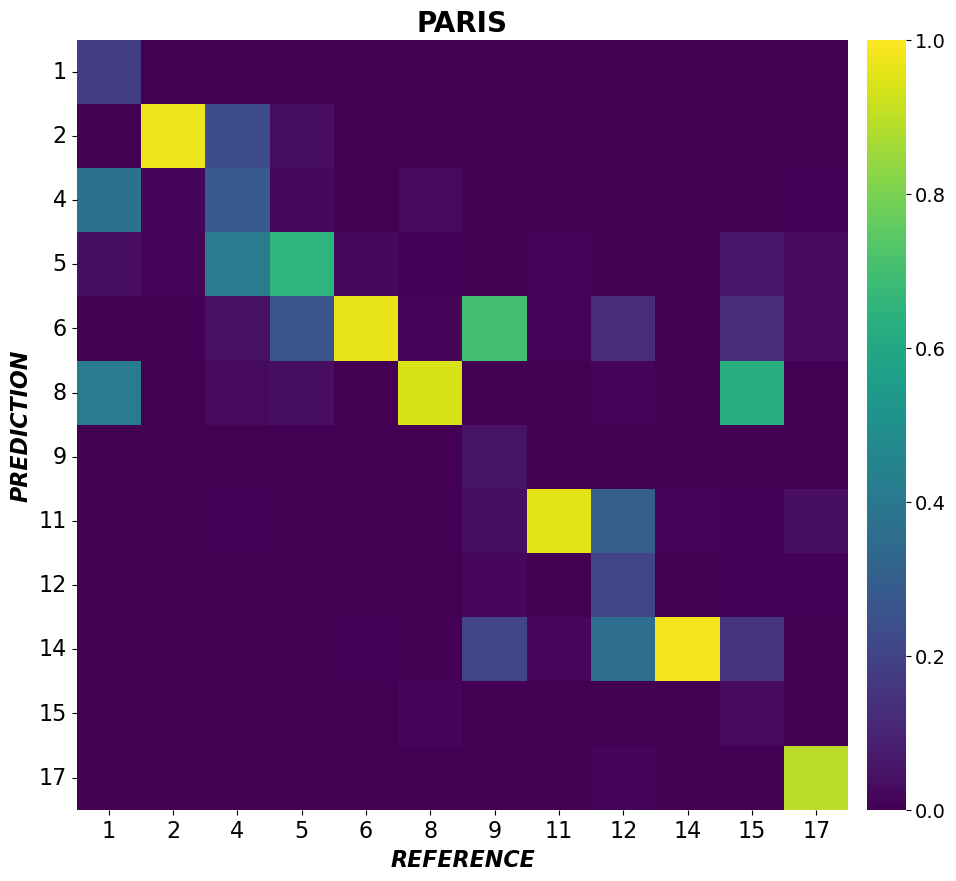

In [125]:
total_cm = None
for fold in results[best_setup][best_strategy]:
    fold_cm = results[best_setup][best_strategy][fold]["Confusion_Matrix"]
    if total_cm is None:
        total_cm = fold_cm.copy()
    else:
        total_cm += fold_cm

# Row Normalize
row_sums = total_cm.sum(axis=1)[:, np.newaxis]
norm_cm = total_cm.astype('float') / (row_sums + 1e-10)

plot_matrix = norm_cm.T 

plt.figure(figsize=(12, 10))
ordered_labels = sorted(splited_ref_data['gridcode'].unique())
ax = sns.heatmap(plot_matrix, 
            annot=False, 
            fmt='.2f', 
            cmap='viridis', 
            vmin=0.0,
            vmax=1.0,
            xticklabels=ordered_labels, 
            yticklabels=ordered_labels,
            cbar_kws={'pad': 0.02})
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=14)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16, rotation=0)
plt.xlabel('REFERENCE', fontsize=16, fontweight='bold', fontstyle='italic')
plt.ylabel('PREDICTION', fontsize=16, fontweight='bold', fontstyle='italic')        
plt.title('PARIS', fontweight='bold', fontsize=20)
plt.show()

In [127]:
# save the summed matrix
np.save(r"results\s3\paris_S3_summed_cm.npy", total_cm)

## Prediction

In [128]:
# which set was better?
better_set = non_weighted_set

# output
output = r'outputs\s3\paris_S3.tif'

In [129]:
# get best model of the best set and stategy
best_run = df.loc[best_setup, best_strategy]
best_fold = (best_run['wF1'] + best_run['F1U']).idxmax()
best_model = best_run.loc[best_fold, 'Model']
best_run[["wF1", "F1U", "F1N", "OA"]].loc[best_fold]

wF1    94.58
F1U    93.41
F1N    96.07
OA     95.10
Name: 1, dtype: float64

In [130]:
# run prediction
with rio.open(better_set) as image_data:
    image_meta = image_data.meta
    image = image_data.read()

image_reshaped = rio.plot.reshape_as_image(image)
scene = image_reshaped.reshape(-1, image_reshaped.shape[-1])
scene[np.isinf(scene)] = np.nan
y_pred = best_model.predict(scene)
classified_image = y_pred.reshape(image_reshaped.shape[0], image_reshaped.shape[1])
classification_meta = image_meta.copy()
classification_meta.update({"count": 1})
with rio.open(output, "w", **classification_meta) as dest:
    dest.write(classified_image, indexes=1)

# Rome

In [2]:
# load splited reference data
splited_ref_data = gpd.read_file(r'ref_data\rome_ref_splitS2S3S4.gpkg')

## Non-weighted RF S1 morphometric subset

In [3]:
# load fused image with subset of morphometrics from non-weighted RF S1 models
non_weighted_set = r'imagery\rome_20170620_morphometrics_model_meanminmax_grid.tif'

In [4]:
# results[setup][strategy][fold]
results = {
    setup: {
        strat: {
            fold: {} for fold in folds
        } for strat in strategies
    } for setup in setups
}

### Fold 0

In [5]:
fold = 0
test_polygons = splited_ref_data[splited_ref_data["fold"] == fold]
train_polygons = splited_ref_data[splited_ref_data["fold"] != fold]

In [6]:
train_polygons_raster = fr"rome_train_f{fold}.tif"
test_polygons_raster = fr"rome_test_f{fold}.tif"

utils.rasterize_reference_polygons(train_polygons, non_weighted_set, train_polygons_raster)
utils.rasterize_reference_polygons(test_polygons, non_weighted_set, test_polygons_raster)

In [7]:
with rio.open(non_weighted_set) as image_data:
    image_meta = image_data.meta
    image = image_data.read()

image_reshaped = rio.plot.reshape_as_image(image)
print(f'Image shape: {image.shape} -> {image_reshaped.shape}')

Image shape: (90, 471, 392) -> (471, 392, 90)


In [8]:
# train and test images matched to fusion 100m grid
train_image_matched = utils.match_rasters(train_polygons_raster, non_weighted_set)
test_image_matched = utils.match_rasters(test_polygons_raster, non_weighted_set)

train_image_matched = train_image_matched.to_numpy()
test_image_matched = test_image_matched.to_numpy()

C:\ProgramData\miniconda3\envs\geo\Lib\site-packages\xarray\core\duck_array_ops.py:250: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\ProgramData\miniconda3\envs\geo\Lib\site-packages\xarray\core\duck_array_ops.py:250: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


In [9]:
X_train = image_reshaped[train_image_matched > 0]
y_train = train_image_matched[train_image_matched > 0]
X_test = image_reshaped[test_image_matched > 0]
y_test = test_image_matched[test_image_matched > 0]

X_train[np.isinf(X_train)] = np.nan
X_test[np.isinf(X_test)] = np.nan

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(5014, 90) (5014,)
(1425, 90) (1425,)


#### Non/weighted RF model

In [ ]:
utils.finetune_height(X_train, y_train, X_test, y_test, max_height=10, class_weight=False)

In [ ]:
param, train, test, diff = utils.finetune_max_features(X_train, y_train, X_test, y_test, height=4, max_features=X_train.shape[1], class_weight=False)

In [34]:
param, train, test, diff

(2, 79.95, 78.93, 1.01)

In [10]:
model_fold0 = RandomForestClassifier(random_state=0, n_jobs=-1, max_depth=3, max_features=1, n_estimators=100)
model_fold0.fit(X_train, y_train)

RandomForestClassifier(max_depth=3, max_features=1, n_jobs=-1, random_state=0)

In [11]:
# training accuracy
pred_train = model_fold0.predict(X_train)
train_accuracy = accuracy_score(y_train, pred_train)
print('OA train: ', round(train_accuracy*100,2))
train_wf1 = f1_score(y_train, pred_train, average='weighted', labels=np.unique(y_train))
print('wF1 train: ', round(train_wf1*100,2))

OA train:  72.04
wF1 train:  66.86


In [12]:
# test accuracy
pred_test = model_fold0.predict(X_test)
test_accuracy = accuracy_score(y_test, pred_test)
print('OA test: ', round(test_accuracy*100,2))
test_wf1 = f1_score(y_test, pred_test, average='weighted', labels=np.unique(y_test))
print('wF1 test: ', round(test_wf1*100,2))

# F1U
X_test_urban = X_test[y_test<=10]
y_test_urban = y_test[y_test<=10]
y_test_pred_urb = model_fold0.predict(X_test_urban)
wf1_urb = f1_score(y_test_urban, y_test_pred_urb, average='weighted', labels=np.unique(y_test[y_test<=10]))
print('Urban wF1 test: ', round(wf1_urb*100,2))

# F1N
X_test_nat = X_test[y_test>10]
y_test_nat = y_test[y_test>10]
y_test_pred_nat = model_fold0.predict(X_test_nat)
wf1_nat = f1_score(y_test_nat, y_test_pred_nat, average='weighted', labels=np.unique(y_test[y_test>10]))
print('Natural wF1 test: ', round(wf1_nat*100,2))

conf_mat = confusion_matrix(y_test, pred_test, labels=sorted(splited_ref_data['gridcode'].unique()))

metrics = {
    "OA":  round(test_accuracy*100,2),
    "wF1": round(test_wf1*100,2),
    "F1U": round(wf1_urb*100,2),
    "F1N": round(wf1_nat*100,2),
    "Model": model_fold0,
    "Confusion_Matrix": conf_mat
}

for c in all_possible_classes:
    metrics[f"F1_Class_{c}"] = np.nan
f1_per_class_array = f1_score(y_test, pred_test, average=None, labels=np.unique(y_test))
for label, score in zip(np.unique(y_test), f1_per_class_array):
    if label in all_possible_classes:
        metrics[f"F1_Class_{int(label)}"] = round(score*100, 2)

results["non_weighted_set"]["non_weighted_model"][fold] = metrics

OA test:  67.44
wF1 test:  60.71
Urban wF1 test:  50.99
Natural wF1 test:  80.42


#### Weighted RF model

In [ ]:
utils.finetune_height(X_train, y_train, X_test, y_test, max_height=10, class_weight=True)

In [ ]:
param, train, test, diff = utils.finetune_max_features(X_train, y_train, X_test, y_test, height=4, max_features=X_train.shape[1], class_weight=True)

In [42]:
param, train, test, diff

(31, 58.17, 54.52, 3.65)

In [13]:
model_fold0_weighted = RandomForestClassifier(random_state=0, n_jobs=-1, max_depth=5, max_features=1, class_weight='balanced', n_estimators=100)
model_fold0_weighted.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=5, max_features=1,
                       n_jobs=-1, random_state=0)

In [14]:
# training accuracy
pred_train = model_fold0_weighted.predict(X_train)
train_accuracy = accuracy_score(y_train, pred_train)
print('OA train: ', round(train_accuracy*100,2))
train_wf1 = f1_score(y_train, pred_train, average='weighted', labels=np.unique(y_train))
print('wF1 train: ', round(train_wf1*100,2))

OA train:  81.85
wF1 train:  82.26


In [15]:
# test accuracy
pred_test = model_fold0_weighted.predict(X_test)
test_accuracy = accuracy_score(y_test, pred_test)
print('OA test: ', round(test_accuracy*100,2))
test_wf1 = f1_score(y_test, pred_test, average='weighted', labels=np.unique(y_test))
print('wF1 test: ', round(test_wf1*100,2))

# F1U
X_test_urban = X_test[y_test<=10]
y_test_urban = y_test[y_test<=10]
y_test_pred_urb = model_fold0_weighted.predict(X_test_urban)
wf1_urb = f1_score(y_test_urban, y_test_pred_urb, average='weighted', labels=np.unique(y_test[y_test<=10]))
print('Urban wF1 test: ', round(wf1_urb*100,2))

# F1N
X_test_nat = X_test[y_test>10]
y_test_nat = y_test[y_test>10]
y_test_pred_nat = model_fold0_weighted.predict(X_test_nat)
wf1_nat = f1_score(y_test_nat, y_test_pred_nat, average='weighted', labels=np.unique(y_test[y_test>10]))
print('Natural wF1 test: ', round(wf1_nat*100,2))

conf_mat = confusion_matrix(y_test, pred_test, labels=sorted(splited_ref_data['gridcode'].unique()))

metrics = {
    "OA":  round(test_accuracy*100,2),
    "wF1": round(test_wf1*100,2),
    "F1U": round(wf1_urb*100,2),
    "F1N": round(wf1_nat*100,2),
    "Model": model_fold0_weighted,
    "Confusion_Matrix": conf_mat
}

for c in all_possible_classes:
    metrics[f"F1_Class_{c}"] = np.nan
f1_per_class_array = f1_score(y_test, pred_test, average=None, labels=np.unique(y_test))
for label, score in zip(np.unique(y_test), f1_per_class_array):
    if label in all_possible_classes:
        metrics[f"F1_Class_{int(label)}"] = round(score*100, 2)

results["non_weighted_set"]["weighted_model"][fold] = metrics

OA test:  76.84
wF1 test:  74.68
Urban wF1 test:  74.9
Natural wF1 test:  80.29


### Fold 1

In [16]:
fold = 1
test_polygons = splited_ref_data[splited_ref_data["fold"] == fold]
train_polygons = splited_ref_data[splited_ref_data["fold"] != fold]

In [17]:
train_polygons_raster = fr"rome_train_f{fold}.tif"
test_polygons_raster = fr"rome_test_f{fold}.tif"

utils.rasterize_reference_polygons(train_polygons, non_weighted_set, train_polygons_raster)
utils.rasterize_reference_polygons(test_polygons, non_weighted_set, test_polygons_raster)

In [18]:
with rio.open(non_weighted_set) as image_data:
    image_meta = image_data.meta
    image = image_data.read()

image_reshaped = rio.plot.reshape_as_image(image)
print(f'Image shape: {image.shape} -> {image_reshaped.shape}')

Image shape: (90, 471, 392) -> (471, 392, 90)


In [19]:
# train and test images matched to fusion 100m grid
train_image_matched = utils.match_rasters(train_polygons_raster, non_weighted_set)
test_image_matched = utils.match_rasters(test_polygons_raster, non_weighted_set)

train_image_matched = train_image_matched.to_numpy()
test_image_matched = test_image_matched.to_numpy()

C:\ProgramData\miniconda3\envs\geo\Lib\site-packages\xarray\core\duck_array_ops.py:250: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\ProgramData\miniconda3\envs\geo\Lib\site-packages\xarray\core\duck_array_ops.py:250: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


In [20]:
X_train = image_reshaped[train_image_matched > 0]
y_train = train_image_matched[train_image_matched > 0]
X_test = image_reshaped[test_image_matched > 0]
y_test = test_image_matched[test_image_matched > 0]

X_train[np.isinf(X_train)] = np.nan
X_test[np.isinf(X_test)] = np.nan

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(5128, 90) (5128,)
(1311, 90) (1311,)


#### Non/weighted RF model

In [ ]:
utils.finetune_height(X_train, y_train, X_test, y_test, max_height=10, class_weight=False)

In [ ]:
param, train, test, diff = utils.finetune_max_features(X_train, y_train, X_test, y_test, height=4, max_features=X_train.shape[1], class_weight=False)

In [ ]:
param, train, test, diff

In [21]:
model_fold1 = RandomForestClassifier(random_state=0, n_jobs=-1, max_depth=2, max_features=63, n_estimators=100)
model_fold1.fit(X_train, y_train)

RandomForestClassifier(max_depth=2, max_features=63, n_jobs=-1, random_state=0)

In [22]:
# training accuracy
pred_train = model_fold1.predict(X_train)
train_accuracy = accuracy_score(y_train, pred_train)
print('OA train: ', round(train_accuracy*100,2))
train_wf1 = f1_score(y_train, pred_train, average='weighted', labels=np.unique(y_train))
print('wF1 train: ', round(train_wf1*100,2))

OA train:  60.35
wF1 train:  50.65


In [23]:
# test accuracy
pred_test = model_fold1.predict(X_test)
test_accuracy = accuracy_score(y_test, pred_test)
print('OA test: ', round(test_accuracy*100,2))
test_wf1 = f1_score(y_test, pred_test, average='weighted', labels=np.unique(y_test))
print('wF1 test: ', round(test_wf1*100,2))

# F1U
X_test_urban = X_test[y_test<=10]
y_test_urban = y_test[y_test<=10]
y_test_pred_urb = model_fold1.predict(X_test_urban)
wf1_urb = f1_score(y_test_urban, y_test_pred_urb, average='weighted', labels=np.unique(y_test[y_test<=10]))
print('Urban wF1 test: ', round(wf1_urb*100,2))

# F1N
X_test_nat = X_test[y_test>10]
y_test_nat = y_test[y_test>10]
y_test_pred_nat = model_fold1.predict(X_test_nat)
wf1_nat = f1_score(y_test_nat, y_test_pred_nat, average='weighted', labels=np.unique(y_test[y_test>10]))
print('Natural wF1 test: ', round(wf1_nat*100,2))

conf_mat = confusion_matrix(y_test, pred_test, labels=sorted(splited_ref_data['gridcode'].unique()))

metrics = {
    "OA":  round(test_accuracy*100,2),
    "wF1": round(test_wf1*100,2),
    "F1U": round(wf1_urb*100,2),
    "F1N": round(wf1_nat*100,2),
    "Model": model_fold1,
    "Confusion_Matrix": conf_mat
}

for c in all_possible_classes:
    metrics[f"F1_Class_{c}"] = np.nan
f1_per_class_array = f1_score(y_test, pred_test, average=None, labels=np.unique(y_test))
for label, score in zip(np.unique(y_test), f1_per_class_array):
    if label in all_possible_classes:
        metrics[f"F1_Class_{int(label)}"] = round(score*100, 2)

results["non_weighted_set"]["non_weighted_model"][fold] = metrics

OA test:  55.15
wF1 test:  44.95
Urban wF1 test:  48.84
Natural wF1 test:  39.78


#### Weighted RF model

In [ ]:
utils.finetune_height(X_train, y_train, X_test, y_test, max_height=10, class_weight=True)

In [ ]:
param, train, test, diff = utils.finetune_max_features(X_train, y_train, X_test, y_test, height=3, max_features=X_train.shape[1], class_weight=True)

In [ ]:
param, train, test, diff

In [24]:
model_fold1_weighted = RandomForestClassifier(random_state=0, n_jobs=-1, max_depth=3, max_features=5, class_weight='balanced', n_estimators=100)
model_fold1_weighted.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=3, max_features=5,
                       n_jobs=-1, random_state=0)

In [25]:
# training accuracy
pred_train = model_fold1_weighted.predict(X_train)
train_accuracy = accuracy_score(y_train, pred_train)
print('OA train: ', round(train_accuracy*100,2))
train_wf1 = f1_score(y_train, pred_train, average='weighted', labels=np.unique(y_train))
print('wF1 train: ', round(train_wf1*100,2))

OA train:  67.86
wF1 train:  63.88


In [26]:
# test accuracy
pred_test = model_fold1_weighted.predict(X_test)
test_accuracy = accuracy_score(y_test, pred_test)
print('OA test: ', round(test_accuracy*100,2))
test_wf1 = f1_score(y_test, pred_test, average='weighted', labels=np.unique(y_test))
print('wF1 test: ', round(test_wf1*100,2))

# F1U
X_test_urban = X_test[y_test<=10]
y_test_urban = y_test[y_test<=10]
y_test_pred_urb = model_fold1_weighted.predict(X_test_urban)
wf1_urb = f1_score(y_test_urban, y_test_pred_urb, average='weighted', labels=np.unique(y_test[y_test<=10]))
print('Urban wF1 test: ', round(wf1_urb*100,2))

# F1N
X_test_nat = X_test[y_test>10]
y_test_nat = y_test[y_test>10]
y_test_pred_nat = model_fold1_weighted.predict(X_test_nat)
wf1_nat = f1_score(y_test_nat, y_test_pred_nat, average='weighted', labels=np.unique(y_test[y_test>10]))
print('Natural wF1 test: ', round(wf1_nat*100,2))

conf_mat = confusion_matrix(y_test, pred_test, labels=sorted(splited_ref_data['gridcode'].unique()))

metrics = {
    "OA":  round(test_accuracy*100,2),
    "wF1": round(test_wf1*100,2),
    "F1U": round(wf1_urb*100,2),
    "F1N": round(wf1_nat*100,2),
    "Model": model_fold1_weighted,
    "Confusion_Matrix": conf_mat
}

for c in all_possible_classes:
    metrics[f"F1_Class_{c}"] = np.nan
f1_per_class_array = f1_score(y_test, pred_test, average=None, labels=np.unique(y_test))
for label, score in zip(np.unique(y_test), f1_per_class_array):
    if label in all_possible_classes:
        metrics[f"F1_Class_{int(label)}"] = round(score*100, 2)

results["non_weighted_set"]["weighted_model"][fold] = metrics

OA test:  63.62
wF1 test:  57.08
Urban wF1 test:  55.33
Natural wF1 test:  62.15


### Fold 2

In [27]:
fold = 2
test_polygons = splited_ref_data[splited_ref_data["fold"] == fold]
train_polygons = splited_ref_data[splited_ref_data["fold"] != fold]

In [28]:
train_polygons_raster = fr"rome_train_f{fold}.tif"
test_polygons_raster = fr"rome_test_f{fold}.tif"

utils.rasterize_reference_polygons(train_polygons, non_weighted_set, train_polygons_raster)
utils.rasterize_reference_polygons(test_polygons, non_weighted_set, test_polygons_raster)

In [29]:
with rio.open(non_weighted_set) as image_data:
    image_meta = image_data.meta
    image = image_data.read()

image_reshaped = rio.plot.reshape_as_image(image)
print(f'Image shape: {image.shape} -> {image_reshaped.shape}')

Image shape: (90, 471, 392) -> (471, 392, 90)


In [30]:
# train and test images matched to fusion 100m grid
train_image_matched = utils.match_rasters(train_polygons_raster, non_weighted_set)
test_image_matched = utils.match_rasters(test_polygons_raster, non_weighted_set)

train_image_matched = train_image_matched.to_numpy()
test_image_matched = test_image_matched.to_numpy()

C:\ProgramData\miniconda3\envs\geo\Lib\site-packages\xarray\core\duck_array_ops.py:250: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\ProgramData\miniconda3\envs\geo\Lib\site-packages\xarray\core\duck_array_ops.py:250: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


In [31]:
X_train = image_reshaped[train_image_matched > 0]
y_train = train_image_matched[train_image_matched > 0]
X_test = image_reshaped[test_image_matched > 0]
y_test = test_image_matched[test_image_matched > 0]

X_train[np.isinf(X_train)] = np.nan
X_test[np.isinf(X_test)] = np.nan

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(5154, 90) (5154,)
(1285, 90) (1285,)


#### Non/weighted RF model

In [ ]:
utils.finetune_height(X_train, y_train, X_test, y_test, max_height=10, class_weight=False)

In [ ]:
param, train, test, diff = utils.finetune_max_features(X_train, y_train, X_test, y_test, height=7, max_features=X_train.shape[1], class_weight=False)

In [76]:
param, train, test, diff

(6, 87.33, 82.49, 4.84)

In [32]:
model_fold2 = RandomForestClassifier(random_state=0, n_jobs=-1, max_depth=4, max_features=39, n_estimators=100)
model_fold2.fit(X_train, y_train)

RandomForestClassifier(max_depth=4, max_features=39, n_jobs=-1, random_state=0)

In [33]:
# training accuracy
pred_train = model_fold2.predict(X_train)
train_accuracy = accuracy_score(y_train, pred_train)
print('OA train: ', round(train_accuracy*100,2))
train_wf1 = f1_score(y_train, pred_train, average='weighted', labels=np.unique(y_train))
print('wF1 train: ', round(train_wf1*100,2))

OA train:  83.31
wF1 train:  82.59


In [34]:
# test accuracy
pred_test = model_fold2.predict(X_test)
test_accuracy = accuracy_score(y_test, pred_test)
print('OA test: ', round(test_accuracy*100,2))
test_wf1 = f1_score(y_test, pred_test, average='weighted', labels=np.unique(y_test))
print('wF1 test: ', round(test_wf1*100,2))

# F1U
X_test_urban = X_test[y_test<=10]
y_test_urban = y_test[y_test<=10]
y_test_pred_urb = model_fold2.predict(X_test_urban)
wf1_urb = f1_score(y_test_urban, y_test_pred_urb, average='weighted', labels=np.unique(y_test[y_test<=10]))
print('Urban wF1 test: ', round(wf1_urb*100,2))

# F1N
X_test_nat = X_test[y_test>10]
y_test_nat = y_test[y_test>10]
y_test_pred_nat = model_fold2.predict(X_test_nat)
wf1_nat = f1_score(y_test_nat, y_test_pred_nat, average='weighted', labels=np.unique(y_test[y_test>10]))
print('Natural wF1 test: ', round(wf1_nat*100,2))

conf_mat = confusion_matrix(y_test, pred_test, labels=sorted(splited_ref_data['gridcode'].unique()))

metrics = {
    "OA":  round(test_accuracy*100,2),
    "wF1": round(test_wf1*100,2),
    "F1U": round(wf1_urb*100,2),
    "F1N": round(wf1_nat*100,2),
    "Model": model_fold2,
    "Confusion_Matrix": conf_mat
}

for c in all_possible_classes:
    metrics[f"F1_Class_{c}"] = np.nan
f1_per_class_array = f1_score(y_test, pred_test, average=None, labels=np.unique(y_test))
for label, score in zip(np.unique(y_test), f1_per_class_array):
    if label in all_possible_classes:
        metrics[f"F1_Class_{int(label)}"] = round(score*100, 2)

results["non_weighted_set"]["non_weighted_model"][fold] = metrics

OA test:  80.39
wF1 test:  80.49
Urban wF1 test:  84.33
Natural wF1 test:  74.8


#### Weighted RF model

In [ ]:
utils.finetune_height(X_train, y_train, X_test, y_test, max_height=10, class_weight=True)

In [ ]:
param, train, test, diff = utils.finetune_max_features(X_train, y_train, X_test, y_test, height=8, max_features=X_train.shape[1], class_weight=True)

In [87]:
param, train, test, diff

(5, 86.05, 83.01, 3.04)

In [35]:
model_fold2_weighted = RandomForestClassifier(random_state=0, n_jobs=-1, max_depth=6, max_features=19, class_weight='balanced', n_estimators=100)
model_fold2_weighted.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=6, max_features=19,
                       n_jobs=-1, random_state=0)

In [36]:
# training accuracy
pred_train = model_fold2_weighted.predict(X_train)
train_accuracy = accuracy_score(y_train, pred_train)
print('OA train: ', round(train_accuracy*100,2))
train_wf1 = f1_score(y_train, pred_train, average='weighted', labels=np.unique(y_train))
print('wF1 train: ', round(train_wf1*100,2))

OA train:  82.95
wF1 train:  83.34


In [37]:
# test accuracy
pred_test = model_fold2_weighted.predict(X_test)
test_accuracy = accuracy_score(y_test, pred_test)
print('OA test: ', round(test_accuracy*100,2))
test_wf1 = f1_score(y_test, pred_test, average='weighted', labels=np.unique(y_test))
print('wF1 test: ', round(test_wf1*100,2))

# F1U
X_test_urban = X_test[y_test<=10]
y_test_urban = y_test[y_test<=10]
y_test_pred_urb = model_fold2_weighted.predict(X_test_urban)
wf1_urb = f1_score(y_test_urban, y_test_pred_urb, average='weighted', labels=np.unique(y_test[y_test<=10]))
print('Urban wF1 test: ', round(wf1_urb*100,2))

# F1N
X_test_nat = X_test[y_test>10]
y_test_nat = y_test[y_test>10]
y_test_pred_nat = model_fold2_weighted.predict(X_test_nat)
wf1_nat = f1_score(y_test_nat, y_test_pred_nat, average='weighted', labels=np.unique(y_test[y_test>10]))
print('Natural wF1 test: ', round(wf1_nat*100,2))

conf_mat = confusion_matrix(y_test, pred_test, labels=sorted(splited_ref_data['gridcode'].unique()))

metrics = {
    "OA":  round(test_accuracy*100,2),
    "wF1": round(test_wf1*100,2),
    "F1U": round(wf1_urb*100,2),
    "F1N": round(wf1_nat*100,2),
    "Model": model_fold2_weighted,
    "Confusion_Matrix": conf_mat
}

for c in all_possible_classes:
    metrics[f"F1_Class_{c}"] = np.nan
f1_per_class_array = f1_score(y_test, pred_test, average=None, labels=np.unique(y_test))
for label, score in zip(np.unique(y_test), f1_per_class_array):
    if label in all_possible_classes:
        metrics[f"F1_Class_{int(label)}"] = round(score*100, 2)

results["non_weighted_set"]["weighted_model"][fold] = metrics

OA test:  78.91
wF1 test:  81.13
Urban wF1 test:  83.13
Natural wF1 test:  78.41


### Fold 3

In [38]:
fold = 3
test_polygons = splited_ref_data[splited_ref_data["fold"] == fold]
train_polygons = splited_ref_data[splited_ref_data["fold"] != fold]

In [39]:
train_polygons_raster = fr"rome_train_f{fold}.tif"
test_polygons_raster = fr"rome_test_f{fold}.tif"

utils.rasterize_reference_polygons(train_polygons, non_weighted_set, train_polygons_raster)
utils.rasterize_reference_polygons(test_polygons, non_weighted_set, test_polygons_raster)

In [40]:
with rio.open(non_weighted_set) as image_data:
    image_meta = image_data.meta
    image = image_data.read()

image_reshaped = rio.plot.reshape_as_image(image)
print(f'Image shape: {image.shape} -> {image_reshaped.shape}')

Image shape: (90, 471, 392) -> (471, 392, 90)


In [41]:
# train and test images matched to fusion 100m grid
train_image_matched = utils.match_rasters(train_polygons_raster, non_weighted_set)
test_image_matched = utils.match_rasters(test_polygons_raster, non_weighted_set)

train_image_matched = train_image_matched.to_numpy()
test_image_matched = test_image_matched.to_numpy()

C:\ProgramData\miniconda3\envs\geo\Lib\site-packages\xarray\core\duck_array_ops.py:250: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\ProgramData\miniconda3\envs\geo\Lib\site-packages\xarray\core\duck_array_ops.py:250: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


In [42]:
X_train = image_reshaped[train_image_matched > 0]
y_train = train_image_matched[train_image_matched > 0]
X_test = image_reshaped[test_image_matched > 0]
y_test = test_image_matched[test_image_matched > 0]

X_train[np.isinf(X_train)] = np.nan
X_test[np.isinf(X_test)] = np.nan

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(5286, 90) (5286,)
(1153, 90) (1153,)


#### Non/weighted RF model

In [ ]:
utils.finetune_height(X_train, y_train, X_test, y_test, max_height=10, class_weight=False)

In [ ]:
param, train, test, diff = utils.finetune_max_features(X_train, y_train, X_test, y_test, height=7, max_features=X_train.shape[1], class_weight=False)

In [95]:
param, train, test, diff

(69, 89.65, 85.02, 4.63)

In [43]:
model_fold3 = RandomForestClassifier(random_state=0, n_jobs=-1, max_depth=4, max_features=34, n_estimators=100)
model_fold3.fit(X_train, y_train)

RandomForestClassifier(max_depth=4, max_features=34, n_jobs=-1, random_state=0)

In [44]:
# training accuracy
pred_train = model_fold3.predict(X_train)
train_accuracy = accuracy_score(y_train, pred_train)
print('OA train: ', round(train_accuracy*100,2))
train_wf1 = f1_score(y_train, pred_train, average='weighted', labels=np.unique(y_train))
print('wF1 train: ', round(train_wf1*100,2))

OA train:  83.79
wF1 train:  82.51


In [45]:
# test accuracy
pred_test = model_fold3.predict(X_test)
test_accuracy = accuracy_score(y_test, pred_test)
print('OA test: ', round(test_accuracy*100,2))
test_wf1 = f1_score(y_test, pred_test, average='weighted', labels=np.unique(y_test))
print('wF1 test: ', round(test_wf1*100,2))

# F1U
X_test_urban = X_test[y_test<=10]
y_test_urban = y_test[y_test<=10]
y_test_pred_urb = model_fold3.predict(X_test_urban)
wf1_urb = f1_score(y_test_urban, y_test_pred_urb, average='weighted', labels=np.unique(y_test[y_test<=10]))
print('Urban wF1 test: ', round(wf1_urb*100,2))

# F1N
X_test_nat = X_test[y_test>10]
y_test_nat = y_test[y_test>10]
y_test_pred_nat = model_fold3.predict(X_test_nat)
wf1_nat = f1_score(y_test_nat, y_test_pred_nat, average='weighted', labels=np.unique(y_test[y_test>10]))
print('Natural wF1 test: ', round(wf1_nat*100,2))

conf_mat = confusion_matrix(y_test, pred_test, labels=sorted(splited_ref_data['gridcode'].unique()))

metrics = {
    "OA":  round(test_accuracy*100,2),
    "wF1": round(test_wf1*100,2),
    "F1U": round(wf1_urb*100,2),
    "F1N": round(wf1_nat*100,2),
    "Model": model_fold3,
    "Confusion_Matrix": conf_mat
}

for c in all_possible_classes:
    metrics[f"F1_Class_{c}"] = np.nan
f1_per_class_array = f1_score(y_test, pred_test, average=None, labels=np.unique(y_test))
for label, score in zip(np.unique(y_test), f1_per_class_array):
    if label in all_possible_classes:
        metrics[f"F1_Class_{int(label)}"] = round(score*100, 2)

results["non_weighted_set"]["non_weighted_model"][fold] = metrics

OA test:  81.53
wF1 test:  80.71
Urban wF1 test:  80.11
Natural wF1 test:  86.49


#### Weighted RF model

In [ ]:
utils.finetune_height(X_train, y_train, X_test, y_test, max_height=10, class_weight=True)

In [ ]:
param, train, test, diff = utils.finetune_max_features(X_train, y_train, X_test, y_test, height=9, max_features=X_train.shape[1], class_weight=True)

In [102]:
param, train, test, diff

(11, 88.6, 84.79, 3.8)

In [46]:
model_fold3_weighted = RandomForestClassifier(random_state=0, n_jobs=-1, max_depth=5, max_features=9, class_weight='balanced', n_estimators=100)
model_fold3_weighted.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=5, max_features=9,
                       n_jobs=-1, random_state=0)

In [47]:
# training accuracy
pred_train = model_fold3_weighted.predict(X_train)
train_accuracy = accuracy_score(y_train, pred_train)
print('OA train: ', round(train_accuracy*100,2))
train_wf1 = f1_score(y_train, pred_train, average='weighted', labels=np.unique(y_train))
print('wF1 train: ', round(train_wf1*100,2))

OA train:  80.16
wF1 train:  80.72


In [48]:
# test accuracy
pred_test = model_fold3_weighted.predict(X_test)
test_accuracy = accuracy_score(y_test, pred_test)
print('OA test: ', round(test_accuracy*100,2))
test_wf1 = f1_score(y_test, pred_test, average='weighted', labels=np.unique(y_test))
print('wF1 test: ', round(test_wf1*100,2))

# F1U
X_test_urban = X_test[y_test<=10]
y_test_urban = y_test[y_test<=10]
y_test_pred_urb = model_fold3_weighted.predict(X_test_urban)
wf1_urb = f1_score(y_test_urban, y_test_pred_urb, average='weighted', labels=np.unique(y_test[y_test<=10]))
print('Urban wF1 test: ', round(wf1_urb*100,2))

# F1N
X_test_nat = X_test[y_test>10]
y_test_nat = y_test[y_test>10]
y_test_pred_nat = model_fold3_weighted.predict(X_test_nat)
wf1_nat = f1_score(y_test_nat, y_test_pred_nat, average='weighted', labels=np.unique(y_test[y_test>10]))
print('Natural wF1 test: ', round(wf1_nat*100,2))

conf_mat = confusion_matrix(y_test, pred_test, labels=sorted(splited_ref_data['gridcode'].unique()))

metrics = {
    "OA":  round(test_accuracy*100,2),
    "wF1": round(test_wf1*100,2),
    "F1U": round(wf1_urb*100,2),
    "F1N": round(wf1_nat*100,2),
    "Model": model_fold3_weighted,
    "Confusion_Matrix": conf_mat
}

for c in all_possible_classes:
    metrics[f"F1_Class_{c}"] = np.nan
f1_per_class_array = f1_score(y_test, pred_test, average=None, labels=np.unique(y_test))
for label, score in zip(np.unique(y_test), f1_per_class_array):
    if label in all_possible_classes:
        metrics[f"F1_Class_{int(label)}"] = round(score*100, 2)

results["non_weighted_set"]["weighted_model"][fold] = metrics

OA test:  75.46
wF1 test:  76.54
Urban wF1 test:  77.34
Natural wF1 test:  77.04


### Fold 4

In [49]:
fold = 4
test_polygons = splited_ref_data[splited_ref_data["fold"] == fold]
train_polygons = splited_ref_data[splited_ref_data["fold"] != fold]

In [50]:
train_polygons_raster = fr"rome_train_f{fold}.tif"
test_polygons_raster = fr"rome_test_f{fold}.tif"

utils.rasterize_reference_polygons(train_polygons, non_weighted_set, train_polygons_raster)
utils.rasterize_reference_polygons(test_polygons, non_weighted_set, test_polygons_raster)

In [51]:
with rio.open(non_weighted_set) as image_data:
    image_meta = image_data.meta
    image = image_data.read()

image_reshaped = rio.plot.reshape_as_image(image)
print(f'Image shape: {image.shape} -> {image_reshaped.shape}')

Image shape: (90, 471, 392) -> (471, 392, 90)


In [52]:
# train and test images matched to fusion 100m grid
train_image_matched = utils.match_rasters(train_polygons_raster, non_weighted_set)
test_image_matched = utils.match_rasters(test_polygons_raster, non_weighted_set)

train_image_matched = train_image_matched.to_numpy()
test_image_matched = test_image_matched.to_numpy()

C:\ProgramData\miniconda3\envs\geo\Lib\site-packages\xarray\core\duck_array_ops.py:250: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\ProgramData\miniconda3\envs\geo\Lib\site-packages\xarray\core\duck_array_ops.py:250: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


In [53]:
X_train = image_reshaped[train_image_matched > 0]
y_train = train_image_matched[train_image_matched > 0]
X_test = image_reshaped[test_image_matched > 0]
y_test = test_image_matched[test_image_matched > 0]

X_train[np.isinf(X_train)] = np.nan
X_test[np.isinf(X_test)] = np.nan

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(5174, 90) (5174,)
(1265, 90) (1265,)


#### Non/weighted RF model

In [ ]:
utils.finetune_height(X_train, y_train, X_test, y_test, max_height=10, class_weight=False)

In [ ]:
param, train, test, diff = utils.finetune_max_features(X_train, y_train, X_test, y_test, height=6, max_features=X_train.shape[1], class_weight=False)

In [115]:
param, train, test, diff

(8, 86.44, 82.9, 3.54)

In [54]:
model_fold4 = RandomForestClassifier(random_state=0, n_jobs=-1, max_depth=8, max_features=9, n_estimators=100)
model_fold4.fit(X_train, y_train)

RandomForestClassifier(max_depth=8, max_features=9, n_jobs=-1, random_state=0)

In [55]:
# training accuracy
pred_train = model_fold4.predict(X_train)
train_accuracy = accuracy_score(y_train, pred_train)
print('OA train: ', round(train_accuracy*100,2))
train_wf1 = f1_score(y_train, pred_train, average='weighted', labels=np.unique(y_train))
print('wF1 train: ', round(train_wf1*100,2))

OA train:  93.85
wF1 train:  93.82


In [56]:
# test accuracy
pred_test = model_fold4.predict(X_test)
test_accuracy = accuracy_score(y_test, pred_test)
print('OA test: ', round(test_accuracy*100,2))
test_wf1 = f1_score(y_test, pred_test, average='weighted', labels=np.unique(y_test))
print('wF1 test: ', round(test_wf1*100,2))

# F1U
X_test_urban = X_test[y_test<=10]
y_test_urban = y_test[y_test<=10]
y_test_pred_urb = model_fold4.predict(X_test_urban)
wf1_urb = f1_score(y_test_urban, y_test_pred_urb, average='weighted', labels=np.unique(y_test[y_test<=10]))
print('Urban wF1 test: ', round(wf1_urb*100,2))

# F1N
X_test_nat = X_test[y_test>10]
y_test_nat = y_test[y_test>10]
y_test_pred_nat = model_fold4.predict(X_test_nat)
wf1_nat = f1_score(y_test_nat, y_test_pred_nat, average='weighted', labels=np.unique(y_test[y_test>10]))
print('Natural wF1 test: ', round(wf1_nat*100,2))

conf_mat = confusion_matrix(y_test, pred_test, labels=sorted(splited_ref_data['gridcode'].unique()))

metrics = {
    "OA":  round(test_accuracy*100,2),
    "wF1": round(test_wf1*100,2),
    "F1U": round(wf1_urb*100,2),
    "F1N": round(wf1_nat*100,2),
    "Model": model_fold4,
    "Confusion_Matrix": conf_mat
}

for c in all_possible_classes:
    metrics[f"F1_Class_{c}"] = np.nan
f1_per_class_array = f1_score(y_test, pred_test, average=None, labels=np.unique(y_test))
for label, score in zip(np.unique(y_test), f1_per_class_array):
    if label in all_possible_classes:
        metrics[f"F1_Class_{int(label)}"] = round(score*100, 2)

results["non_weighted_set"]["non_weighted_model"][fold] = metrics

OA test:  91.7
wF1 test:  92.14
Urban wF1 test:  91.13
Natural wF1 test:  94.07


#### Weighted RF model

In [ ]:
utils.finetune_height(X_train, y_train, X_test, y_test, max_height=10, class_weight=True)

In [ ]:
param, train, test, diff = utils.finetune_max_features(X_train, y_train, X_test, y_test, height=5, max_features=X_train.shape[1], class_weight=True)

In [124]:
param, train, test, diff

(11, 78.4, 74.37, 4.03)

In [57]:
model_fold4_weighted = RandomForestClassifier(random_state=0, n_jobs=-1, max_depth=10, max_features=3, class_weight='balanced', n_estimators=100)
model_fold4_weighted.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=10, max_features=3,
                       n_jobs=-1, random_state=0)

In [58]:
# training accuracy
pred_train = model_fold4_weighted.predict(X_train)
train_accuracy = accuracy_score(y_train, pred_train)
print('OA train: ', round(train_accuracy*100,2))
train_wf1 = f1_score(y_train, pred_train, average='weighted', labels=np.unique(y_train))
print('wF1 train: ', round(train_wf1*100,2))

OA train:  94.11
wF1 train:  94.08


In [59]:
# test accuracy
pred_test = model_fold4_weighted.predict(X_test)
test_accuracy = accuracy_score(y_test, pred_test)
print('OA test: ', round(test_accuracy*100,2))
test_wf1 = f1_score(y_test, pred_test, average='weighted', labels=np.unique(y_test))
print('wF1 test: ', round(test_wf1*100,2))

# F1U
X_test_urban = X_test[y_test<=10]
y_test_urban = y_test[y_test<=10]
y_test_pred_urb = model_fold4_weighted.predict(X_test_urban)
wf1_urb = f1_score(y_test_urban, y_test_pred_urb, average='weighted', labels=np.unique(y_test[y_test<=10]))
print('Urban wF1 test: ', round(wf1_urb*100,2))

# F1N
X_test_nat = X_test[y_test>10]
y_test_nat = y_test[y_test>10]
y_test_pred_nat = model_fold4_weighted.predict(X_test_nat)
wf1_nat = f1_score(y_test_nat, y_test_pred_nat, average='weighted', labels=np.unique(y_test[y_test>10]))
print('Natural wF1 test: ', round(wf1_nat*100,2))

conf_mat = confusion_matrix(y_test, pred_test, labels=sorted(splited_ref_data['gridcode'].unique()))

metrics = {
    "OA":  round(test_accuracy*100,2),
    "wF1": round(test_wf1*100,2),
    "F1U": round(wf1_urb*100,2),
    "F1N": round(wf1_nat*100,2),
    "Model": model_fold4_weighted,
    "Confusion_Matrix": conf_mat
}

for c in all_possible_classes:
    metrics[f"F1_Class_{c}"] = np.nan
f1_per_class_array = f1_score(y_test, pred_test, average=None, labels=np.unique(y_test))
for label, score in zip(np.unique(y_test), f1_per_class_array):
    if label in all_possible_classes:
        metrics[f"F1_Class_{int(label)}"] = round(score*100, 2)

results["non_weighted_set"]["weighted_model"][fold] = metrics

OA test:  90.04
wF1 test:  91.76
Urban wF1 test:  91.29
Natural wF1 test:  92.96


## Weighted RF S1 morphometric subset

In [60]:
# load fused image with subset of morphometrics from weighted RF S1 models
weighted_set = r'imagery\rome_20170620_morphometrics_weighted_meanminmax_grid.tif'

### Fold 0

In [61]:
fold = 0
test_polygons = splited_ref_data[splited_ref_data["fold"] == fold]
train_polygons = splited_ref_data[splited_ref_data["fold"] != fold]

In [62]:
train_polygons_raster = fr"rome_train_f{fold}.tif"
test_polygons_raster = fr"rome_test_f{fold}.tif"

utils.rasterize_reference_polygons(train_polygons, weighted_set, train_polygons_raster)
utils.rasterize_reference_polygons(test_polygons, weighted_set, test_polygons_raster)

In [63]:
with rio.open(weighted_set) as image_data:
    image_meta = image_data.meta
    image = image_data.read()

image_reshaped = rio.plot.reshape_as_image(image)
print(f'Image shape: {image.shape} -> {image_reshaped.shape}')

Image shape: (90, 471, 392) -> (471, 392, 90)


In [64]:
# train and test images matched to fusion 100m grid
train_image_matched = utils.match_rasters(train_polygons_raster, weighted_set)
test_image_matched = utils.match_rasters(test_polygons_raster, weighted_set)

train_image_matched = train_image_matched.to_numpy()
test_image_matched = test_image_matched.to_numpy()

C:\ProgramData\miniconda3\envs\geo\Lib\site-packages\xarray\core\duck_array_ops.py:250: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\ProgramData\miniconda3\envs\geo\Lib\site-packages\xarray\core\duck_array_ops.py:250: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


In [65]:
X_train = image_reshaped[train_image_matched > 0]
y_train = train_image_matched[train_image_matched > 0]
X_test = image_reshaped[test_image_matched > 0]
y_test = test_image_matched[test_image_matched > 0]

X_train[np.isinf(X_train)] = np.nan
X_test[np.isinf(X_test)] = np.nan

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(5014, 90) (5014,)
(1425, 90) (1425,)


#### Non/weighted RF model

In [ ]:
utils.finetune_height(X_train, y_train, X_test, y_test, max_height=10, class_weight=False)

In [ ]:
param, train, test, diff = utils.finetune_max_features(X_train, y_train, X_test, y_test, height=5, max_features=X_train.shape[1], class_weight=False)

In [146]:
param, train, test, diff

(1, 81.27, 78.91, 2.36)

In [66]:
ws_model_fold0 = RandomForestClassifier(random_state=0, n_jobs=-1, max_depth=3, max_features=4, n_estimators=100)
ws_model_fold0.fit(X_train, y_train)

RandomForestClassifier(max_depth=3, max_features=4, n_jobs=-1, random_state=0)

In [67]:
# training accuracy
pred_train = ws_model_fold0.predict(X_train)
train_accuracy = accuracy_score(y_train, pred_train)
print('OA train: ', round(train_accuracy*100,2))
train_wf1 = f1_score(y_train, pred_train, average='weighted', labels=np.unique(y_train))
print('wF1 train: ', round(train_wf1*100,2))

OA train:  77.2
wF1 train:  73.28


In [68]:
# test accuracy
pred_test = ws_model_fold0.predict(X_test)
test_accuracy = accuracy_score(y_test, pred_test)
print('OA test: ', round(test_accuracy*100,2))
test_wf1 = f1_score(y_test, pred_test, average='weighted', labels=np.unique(y_test))
print('wF1 test: ', round(test_wf1*100,2))

# F1U
X_test_urban = X_test[y_test<=10]
y_test_urban = y_test[y_test<=10]
y_test_pred_urb = ws_model_fold0.predict(X_test_urban)
wf1_urb = f1_score(y_test_urban, y_test_pred_urb, average='weighted', labels=np.unique(y_test[y_test<=10]))
print('Urban wF1 test: ', round(wf1_urb*100,2))

# F1N
X_test_nat = X_test[y_test>10]
y_test_nat = y_test[y_test>10]
y_test_pred_nat = ws_model_fold0.predict(X_test_nat)
wf1_nat = f1_score(y_test_nat, y_test_pred_nat, average='weighted', labels=np.unique(y_test[y_test>10]))
print('Natural wF1 test: ', round(wf1_nat*100,2))

conf_mat = confusion_matrix(y_test, pred_test, labels=sorted(splited_ref_data['gridcode'].unique()))

metrics = {
    "OA":  round(test_accuracy*100,2),
    "wF1": round(test_wf1*100,2),
    "F1U": round(wf1_urb*100,2),
    "F1N": round(wf1_nat*100,2),
    "Model": ws_model_fold0,
    "Confusion_Matrix": conf_mat
}

for c in all_possible_classes:
    metrics[f"F1_Class_{c}"] = np.nan
f1_per_class_array = f1_score(y_test, pred_test, average=None, labels=np.unique(y_test))
for label, score in zip(np.unique(y_test), f1_per_class_array):
    if label in all_possible_classes:
        metrics[f"F1_Class_{int(label)}"] = round(score*100, 2)
        
results["weighted_set"]["non_weighted_model"][fold] = metrics

OA test:  72.21
wF1 test:  65.56
Urban wF1 test:  58.88
Natural wF1 test:  81.11


#### Weighted RF model

In [ ]:
utils.finetune_height(X_train, y_train, X_test, y_test, max_height=10, class_weight=True)

In [ ]:
param, train, test, diff = utils.finetune_max_features(X_train, y_train, X_test, y_test, height=5, max_features=X_train.shape[1], class_weight=True)

In [152]:
param, train, test, diff

(41, 61.59, 57.0, 4.59)

In [69]:
ws_model_fold0_weighted = RandomForestClassifier(random_state=0, n_jobs=-1, max_depth=4, max_features=1, class_weight='balanced', n_estimators=100)
ws_model_fold0_weighted.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=4, max_features=1,
                       n_jobs=-1, random_state=0)

In [70]:
# training accuracy
pred_train = ws_model_fold0_weighted.predict(X_train)
train_accuracy = accuracy_score(y_train, pred_train)
print('OA train: ', round(train_accuracy*100,2))
train_wf1 = f1_score(y_train, pred_train, average='weighted', labels=np.unique(y_train))
print('wF1 train: ', round(train_wf1*100,2))

OA train:  75.55
wF1 train:  76.54


In [71]:
# test accuracy
pred_test = ws_model_fold0_weighted.predict(X_test)
test_accuracy = accuracy_score(y_test, pred_test)
print('OA test: ', round(test_accuracy*100,2))
test_wf1 = f1_score(y_test, pred_test, average='weighted', labels=np.unique(y_test))
print('wF1 test: ', round(test_wf1*100,2))

# F1U
X_test_urban = X_test[y_test<=10]
y_test_urban = y_test[y_test<=10]
y_test_pred_urb = ws_model_fold0_weighted.predict(X_test_urban)
wf1_urb = f1_score(y_test_urban, y_test_pred_urb, average='weighted', labels=np.unique(y_test[y_test<=10]))
print('Urban wF1 test: ', round(wf1_urb*100,2))

# F1N
X_test_nat = X_test[y_test>10]
y_test_nat = y_test[y_test>10]
y_test_pred_nat = ws_model_fold0_weighted.predict(X_test_nat)
wf1_nat = f1_score(y_test_nat, y_test_pred_nat, average='weighted', labels=np.unique(y_test[y_test>10]))
print('Natural wF1 test: ', round(wf1_nat*100,2))

conf_mat = confusion_matrix(y_test, pred_test, labels=sorted(splited_ref_data['gridcode'].unique()))

metrics = {
    "OA":  round(test_accuracy*100,2),
    "wF1": round(test_wf1*100,2),
    "F1U": round(wf1_urb*100,2),
    "F1N": round(wf1_nat*100,2),
    "Model": ws_model_fold0_weighted,
    "Confusion_Matrix": conf_mat
}

for c in all_possible_classes:
    metrics[f"F1_Class_{c}"] = np.nan
f1_per_class_array = f1_score(y_test, pred_test, average=None, labels=np.unique(y_test))
for label, score in zip(np.unique(y_test), f1_per_class_array):
    if label in all_possible_classes:
        metrics[f"F1_Class_{int(label)}"] = round(score*100, 2)

results["weighted_set"]["weighted_model"][fold] = metrics

OA test:  76.35
wF1 test:  74.49
Urban wF1 test:  75.09
Natural wF1 test:  79.5


### Fold 1

In [72]:
fold = 1
test_polygons = splited_ref_data[splited_ref_data["fold"] == fold]
train_polygons = splited_ref_data[splited_ref_data["fold"] != fold]

In [73]:
train_polygons_raster = fr"rome_train_f{fold}.tif"
test_polygons_raster = fr"rome_test_f{fold}.tif"

utils.rasterize_reference_polygons(train_polygons, weighted_set, train_polygons_raster)
utils.rasterize_reference_polygons(test_polygons, weighted_set, test_polygons_raster)

In [74]:
with rio.open(weighted_set) as image_data:
    image_meta = image_data.meta
    image = image_data.read()

image_reshaped = rio.plot.reshape_as_image(image)
print(f'Image shape: {image.shape} -> {image_reshaped.shape}')

Image shape: (90, 471, 392) -> (471, 392, 90)


In [75]:
# train and test images matched to fusion 100m grid
train_image_matched = utils.match_rasters(train_polygons_raster, weighted_set)
test_image_matched = utils.match_rasters(test_polygons_raster, weighted_set)

train_image_matched = train_image_matched.to_numpy()
test_image_matched = test_image_matched.to_numpy()

C:\ProgramData\miniconda3\envs\geo\Lib\site-packages\xarray\core\duck_array_ops.py:250: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\ProgramData\miniconda3\envs\geo\Lib\site-packages\xarray\core\duck_array_ops.py:250: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


In [76]:
X_train = image_reshaped[train_image_matched > 0]
y_train = train_image_matched[train_image_matched > 0]
X_test = image_reshaped[test_image_matched > 0]
y_test = test_image_matched[test_image_matched > 0]

X_train[np.isinf(X_train)] = np.nan
X_test[np.isinf(X_test)] = np.nan

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(5128, 90) (5128,)
(1311, 90) (1311,)


#### Non/weighted RF model

In [ ]:
utils.finetune_height(X_train, y_train, X_test, y_test, max_height=10, class_weight=False)

In [ ]:
param, train, test, diff = utils.finetune_max_features(X_train, y_train, X_test, y_test, height=4, max_features=X_train.shape[1], class_weight=False)

In [165]:
param, train, test, diff

(1, 80.24, 75.71, 4.54)

In [77]:
ws_model_fold1 = RandomForestClassifier(random_state=0, n_jobs=-1, max_depth=1, max_features=1, n_estimators=100)
ws_model_fold1.fit(X_train, y_train)

RandomForestClassifier(max_depth=1, max_features=1, n_jobs=-1, random_state=0)

In [78]:
# training accuracy
pred_train = ws_model_fold1.predict(X_train)
train_accuracy = accuracy_score(y_train, pred_train)
print('OA train: ', round(train_accuracy*100,2))
train_wf1 = f1_score(y_train, pred_train, average='weighted', labels=np.unique(y_train))
print('wF1 train: ', round(train_wf1*100,2))

OA train:  53.74
wF1 train:  43.28


In [79]:
# test accuracy
pred_test = ws_model_fold1.predict(X_test)
test_accuracy = accuracy_score(y_test, pred_test)
print('OA test: ', round(test_accuracy*100,2))
test_wf1 = f1_score(y_test, pred_test, average='weighted', labels=np.unique(y_test))
print('wF1 test: ', round(test_wf1*100,2))

# F1U
X_test_urban = X_test[y_test<=10]
y_test_urban = y_test[y_test<=10]
y_test_pred_urb = ws_model_fold1.predict(X_test_urban)
wf1_urb = f1_score(y_test_urban, y_test_pred_urb, average='weighted', labels=np.unique(y_test[y_test<=10]))
print('Urban wF1 test: ', round(wf1_urb*100,2))

# F1N
X_test_nat = X_test[y_test>10]
y_test_nat = y_test[y_test>10]
y_test_pred_nat = ws_model_fold1.predict(X_test_nat)
wf1_nat = f1_score(y_test_nat, y_test_pred_nat, average='weighted', labels=np.unique(y_test[y_test>10]))
print('Natural wF1 test: ', round(wf1_nat*100,2))

conf_mat = confusion_matrix(y_test, pred_test, labels=sorted(splited_ref_data['gridcode'].unique()))

metrics = {
    "OA":  round(test_accuracy*100,2),
    "wF1": round(test_wf1*100,2),
    "F1U": round(wf1_urb*100,2),
    "F1N": round(wf1_nat*100,2),
    "Model": ws_model_fold1,
    "Confusion_Matrix": conf_mat
}

for c in all_possible_classes:
    metrics[f"F1_Class_{c}"] = np.nan
f1_per_class_array = f1_score(y_test, pred_test, average=None, labels=np.unique(y_test))
for label, score in zip(np.unique(y_test), f1_per_class_array):
    if label in all_possible_classes:
        metrics[f"F1_Class_{int(label)}"] = round(score*100, 2)

results["weighted_set"]["non_weighted_model"][fold] = metrics

OA test:  49.43
wF1 test:  39.06
Urban wF1 test:  35.27
Natural wF1 test:  51.45


#### Weighted RF model

In [ ]:
utils.finetune_height(X_train, y_train, X_test, y_test, max_height=10, class_weight=True)

In [ ]:
param, train, test, diff = utils.finetune_max_features(X_train, y_train, X_test, y_test, height=5, max_features=X_train.shape[1], class_weight=True)

In [173]:
param, train, test, diff

(13, 78.84, 74.98, 3.86)

In [80]:
ws_model_fold1_weighted = RandomForestClassifier(random_state=0, n_jobs=-1, max_depth=3, max_features=6, class_weight='balanced', n_estimators=100)
ws_model_fold1_weighted.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=3, max_features=6,
                       n_jobs=-1, random_state=0)

In [81]:
# training accuracy
pred_train = ws_model_fold1_weighted.predict(X_train)
train_accuracy = accuracy_score(y_train, pred_train)
print('OA train: ', round(train_accuracy*100,2))
train_wf1 = f1_score(y_train, pred_train, average='weighted', labels=np.unique(y_train))
print('wF1 train: ', round(train_wf1*100,2))

OA train:  65.07
wF1 train:  61.06


In [82]:
# test accuracy
pred_test = ws_model_fold1_weighted.predict(X_test)
test_accuracy = accuracy_score(y_test, pred_test)
print('OA test: ', round(test_accuracy*100,2))
test_wf1 = f1_score(y_test, pred_test, average='weighted', labels=np.unique(y_test))
print('wF1 test: ', round(test_wf1*100,2))

# F1U
X_test_urban = X_test[y_test<=10]
y_test_urban = y_test[y_test<=10]
y_test_pred_urb = ws_model_fold1_weighted.predict(X_test_urban)
wf1_urb = f1_score(y_test_urban, y_test_pred_urb, average='weighted', labels=np.unique(y_test[y_test<=10]))
print('Urban wF1 test: ', round(wf1_urb*100,2))

# F1N
X_test_nat = X_test[y_test>10]
y_test_nat = y_test[y_test>10]
y_test_pred_nat = ws_model_fold1_weighted.predict(X_test_nat)
wf1_nat = f1_score(y_test_nat, y_test_pred_nat, average='weighted', labels=np.unique(y_test[y_test>10]))
print('Natural wF1 test: ', round(wf1_nat*100,2))

conf_mat = confusion_matrix(y_test, pred_test, labels=sorted(splited_ref_data['gridcode'].unique()))

metrics = {
    "OA":  round(test_accuracy*100,2),
    "wF1": round(test_wf1*100,2),
    "F1U": round(wf1_urb*100,2),
    "F1N": round(wf1_nat*100,2),
    "Model": ws_model_fold1_weighted,
    "Confusion_Matrix": conf_mat
}

for c in all_possible_classes:
    metrics[f"F1_Class_{c}"] = np.nan
f1_per_class_array = f1_score(y_test, pred_test, average=None, labels=np.unique(y_test))
for label, score in zip(np.unique(y_test), f1_per_class_array):
    if label in all_possible_classes:
        metrics[f"F1_Class_{int(label)}"] = round(score*100, 2)

results["weighted_set"]["weighted_model"][fold] = metrics

OA test:  60.56
wF1 test:  56.08
Urban wF1 test:  56.12
Natural wF1 test:  58.5


### Fold 2

In [83]:
fold = 2
test_polygons = splited_ref_data[splited_ref_data["fold"] == fold]
train_polygons = splited_ref_data[splited_ref_data["fold"] != fold]

In [84]:
train_polygons_raster = fr"rome_train_f{fold}.tif"
test_polygons_raster = fr"rome_test_f{fold}.tif"

utils.rasterize_reference_polygons(train_polygons, weighted_set, train_polygons_raster)
utils.rasterize_reference_polygons(test_polygons, weighted_set, test_polygons_raster)

In [85]:
with rio.open(weighted_set) as image_data:
    image_meta = image_data.meta
    image = image_data.read()

image_reshaped = rio.plot.reshape_as_image(image)
print(f'Image shape: {image.shape} -> {image_reshaped.shape}')

Image shape: (90, 471, 392) -> (471, 392, 90)


In [86]:
# train and test images matched to fusion 100m grid
train_image_matched = utils.match_rasters(train_polygons_raster, weighted_set)
test_image_matched = utils.match_rasters(test_polygons_raster, weighted_set)

train_image_matched = train_image_matched.to_numpy()
test_image_matched = test_image_matched.to_numpy()

C:\ProgramData\miniconda3\envs\geo\Lib\site-packages\xarray\core\duck_array_ops.py:250: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\ProgramData\miniconda3\envs\geo\Lib\site-packages\xarray\core\duck_array_ops.py:250: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


In [87]:
X_train = image_reshaped[train_image_matched > 0]
y_train = train_image_matched[train_image_matched > 0]
X_test = image_reshaped[test_image_matched > 0]
y_test = test_image_matched[test_image_matched > 0]

X_train[np.isinf(X_train)] = np.nan
X_test[np.isinf(X_test)] = np.nan

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(5154, 90) (5154,)
(1285, 90) (1285,)


#### Non/weighted RF model

In [ ]:
utils.finetune_height(X_train, y_train, X_test, y_test, max_height=10, class_weight=False)

In [ ]:
param, train, test, diff = utils.finetune_max_features(X_train, y_train, X_test, y_test, height=6, max_features=X_train.shape[1], class_weight=False)

In [186]:
param, train, test, diff

(47, 87.77, 84.02, 3.75)

In [88]:
ws_model_fold2 = RandomForestClassifier(random_state=0, n_jobs=-1, max_depth=3, max_features=44, n_estimators=100)
ws_model_fold2.fit(X_train, y_train)

RandomForestClassifier(max_depth=3, max_features=44, n_jobs=-1, random_state=0)

In [89]:
# training accuracy
pred_train = ws_model_fold2.predict(X_train)
train_accuracy = accuracy_score(y_train, pred_train)
print('OA train: ', round(train_accuracy*100,2))
train_wf1 = f1_score(y_train, pred_train, average='weighted', labels=np.unique(y_train))
print('wF1 train: ', round(train_wf1*100,2))

OA train:  76.68
wF1 train:  72.4


In [90]:
# test accuracy
pred_test = ws_model_fold2.predict(X_test)
test_accuracy = accuracy_score(y_test, pred_test)
print('OA test: ', round(test_accuracy*100,2))
test_wf1 = f1_score(y_test, pred_test, average='weighted', labels=np.unique(y_test))
print('wF1 test: ', round(test_wf1*100,2))

# F1U
X_test_urban = X_test[y_test<=10]
y_test_urban = y_test[y_test<=10]
y_test_pred_urb = ws_model_fold2.predict(X_test_urban)
wf1_urb = f1_score(y_test_urban, y_test_pred_urb, average='weighted', labels=np.unique(y_test[y_test<=10]))
print('Urban wF1 test: ', round(wf1_urb*100,2))

# F1N
X_test_nat = X_test[y_test>10]
y_test_nat = y_test[y_test>10]
y_test_pred_nat = ws_model_fold2.predict(X_test_nat)
wf1_nat = f1_score(y_test_nat, y_test_pred_nat, average='weighted', labels=np.unique(y_test[y_test>10]))
print('Natural wF1 test: ', round(wf1_nat*100,2))

conf_mat = confusion_matrix(y_test, pred_test, labels=sorted(splited_ref_data['gridcode'].unique()))

metrics = {
    "OA":  round(test_accuracy*100,2),
    "wF1": round(test_wf1*100,2),
    "F1U": round(wf1_urb*100,2),
    "F1N": round(wf1_nat*100,2),
    "Model": ws_model_fold2,
    "Confusion_Matrix": conf_mat
}

for c in all_possible_classes:
    metrics[f"F1_Class_{c}"] = np.nan
f1_per_class_array = f1_score(y_test, pred_test, average=None, labels=np.unique(y_test))
for label, score in zip(np.unique(y_test), f1_per_class_array):
    if label in all_possible_classes:
        metrics[f"F1_Class_{int(label)}"] = round(score*100, 2)

results["weighted_set"]["non_weighted_model"][fold] = metrics

OA test:  72.14
wF1 test:  66.39
Urban wF1 test:  76.83
Natural wF1 test:  50.22


#### Weighted RF model

In [ ]:
utils.finetune_height(X_train, y_train, X_test, y_test, max_height=10, class_weight=True)

In [ ]:
param, train, test, diff = utils.finetune_max_features(X_train, y_train, X_test, y_test, height=8, max_features=X_train.shape[1], class_weight=True)

In [193]:
param, train, test, diff

(19, 87.17, 82.47, 4.7)

In [91]:
ws_model_fold2_weighted = RandomForestClassifier(random_state=0, n_jobs=-1, max_depth=3, max_features=27, class_weight='balanced', n_estimators=100)
ws_model_fold2_weighted.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=3, max_features=27,
                       n_jobs=-1, random_state=0)

In [92]:
# training accuracy
pred_train = ws_model_fold2_weighted.predict(X_train)
train_accuracy = accuracy_score(y_train, pred_train)
print('OA train: ', round(train_accuracy*100,2))
train_wf1 = f1_score(y_train, pred_train, average='weighted', labels=np.unique(y_train))
print('wF1 train: ', round(train_wf1*100,2))

OA train:  21.77
wF1 train:  19.08


In [93]:
# test accuracy
pred_test = ws_model_fold2_weighted.predict(X_test)
test_accuracy = accuracy_score(y_test, pred_test)
print('OA test: ', round(test_accuracy*100,2))
test_wf1 = f1_score(y_test, pred_test, average='weighted', labels=np.unique(y_test))
print('wF1 test: ', round(test_wf1*100,2))

# F1U
X_test_urban = X_test[y_test<=10]
y_test_urban = y_test[y_test<=10]
y_test_pred_urb = ws_model_fold2_weighted.predict(X_test_urban)
wf1_urb = f1_score(y_test_urban, y_test_pred_urb, average='weighted', labels=np.unique(y_test[y_test<=10]))
print('Urban wF1 test: ', round(wf1_urb*100,2))

# F1N
X_test_nat = X_test[y_test>10]
y_test_nat = y_test[y_test>10]
y_test_pred_nat = ws_model_fold2_weighted.predict(X_test_nat)
wf1_nat = f1_score(y_test_nat, y_test_pred_nat, average='weighted', labels=np.unique(y_test[y_test>10]))
print('Natural wF1 test: ', round(wf1_nat*100,2))

conf_mat = confusion_matrix(y_test, pred_test, labels=sorted(splited_ref_data['gridcode'].unique()))

metrics = {
    "OA":  round(test_accuracy*100,2),
    "wF1": round(test_wf1*100,2),
    "F1U": round(wf1_urb*100,2),
    "F1N": round(wf1_nat*100,2),
    "Model": ws_model_fold2_weighted,
    "Confusion_Matrix": conf_mat
}

for c in all_possible_classes:
    metrics[f"F1_Class_{c}"] = np.nan
f1_per_class_array = f1_score(y_test, pred_test, average=None, labels=np.unique(y_test))
for label, score in zip(np.unique(y_test), f1_per_class_array):
    if label in all_possible_classes:
        metrics[f"F1_Class_{int(label)}"] = round(score*100, 2)

results["weighted_set"]["weighted_model"][fold] = metrics

OA test:  21.01
wF1 test:  20.33
Urban wF1 test:  7.76
Natural wF1 test:  39.86


### Fold 3

In [94]:
fold = 3
test_polygons = splited_ref_data[splited_ref_data["fold"] == fold]
train_polygons = splited_ref_data[splited_ref_data["fold"] != fold]

In [95]:
train_polygons_raster = fr"rome_train_f{fold}.tif"
test_polygons_raster = fr"rome_test_f{fold}.tif"

utils.rasterize_reference_polygons(train_polygons, weighted_set, train_polygons_raster)
utils.rasterize_reference_polygons(test_polygons, weighted_set, test_polygons_raster)

In [96]:
with rio.open(weighted_set) as image_data:
    image_meta = image_data.meta
    image = image_data.read()

image_reshaped = rio.plot.reshape_as_image(image)
print(f'Image shape: {image.shape} -> {image_reshaped.shape}')

Image shape: (90, 471, 392) -> (471, 392, 90)


In [97]:
# train and test images matched to fusion 100m grid
train_image_matched = utils.match_rasters(train_polygons_raster, weighted_set)
test_image_matched = utils.match_rasters(test_polygons_raster, weighted_set)

train_image_matched = train_image_matched.to_numpy()
test_image_matched = test_image_matched.to_numpy()

C:\ProgramData\miniconda3\envs\geo\Lib\site-packages\xarray\core\duck_array_ops.py:250: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\ProgramData\miniconda3\envs\geo\Lib\site-packages\xarray\core\duck_array_ops.py:250: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


In [98]:
X_train = image_reshaped[train_image_matched > 0]
y_train = train_image_matched[train_image_matched > 0]
X_test = image_reshaped[test_image_matched > 0]
y_test = test_image_matched[test_image_matched > 0]

X_train[np.isinf(X_train)] = np.nan
X_test[np.isinf(X_test)] = np.nan

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(5286, 90) (5286,)
(1153, 90) (1153,)


#### Non/weighted RF model

In [ ]:
utils.finetune_height(X_train, y_train, X_test, y_test, max_height=10, class_weight=False)

In [ ]:
param, train, test, diff = utils.finetune_max_features(X_train, y_train, X_test, y_test, height=7, max_features=X_train.shape[1], class_weight=False)

In [204]:
param, train, test, diff

(5, 88.8, 84.77, 4.03)

In [99]:
ws_model_fold3 = RandomForestClassifier(random_state=0, n_jobs=-1, max_depth=4, max_features=32, n_estimators=100)
ws_model_fold3.fit(X_train, y_train)

RandomForestClassifier(max_depth=4, max_features=32, n_jobs=-1, random_state=0)

In [100]:
# training accuracy
pred_train = ws_model_fold3.predict(X_train)
train_accuracy = accuracy_score(y_train, pred_train)
print('OA train: ', round(train_accuracy*100,2))
train_wf1 = f1_score(y_train, pred_train, average='weighted', labels=np.unique(y_train))
print('wF1 train: ', round(train_wf1*100,2))

OA train:  83.75
wF1 train:  82.52


In [101]:
# test accuracy
pred_test = ws_model_fold3.predict(X_test)
test_accuracy = accuracy_score(y_test, pred_test)
print('OA test: ', round(test_accuracy*100,2))
test_wf1 = f1_score(y_test, pred_test, average='weighted', labels=np.unique(y_test))
print('wF1 test: ', round(test_wf1*100,2))

# F1U
X_test_urban = X_test[y_test<=10]
y_test_urban = y_test[y_test<=10]
y_test_pred_urb = ws_model_fold3.predict(X_test_urban)
wf1_urb = f1_score(y_test_urban, y_test_pred_urb, average='weighted', labels=np.unique(y_test[y_test<=10]))
print('Urban wF1 test: ', round(wf1_urb*100,2))

# F1N
X_test_nat = X_test[y_test>10]
y_test_nat = y_test[y_test>10]
y_test_pred_nat = ws_model_fold3.predict(X_test_nat)
wf1_nat = f1_score(y_test_nat, y_test_pred_nat, average='weighted', labels=np.unique(y_test[y_test>10]))
print('Natural wF1 test: ', round(wf1_nat*100,2))

conf_mat = confusion_matrix(y_test, pred_test, labels=sorted(splited_ref_data['gridcode'].unique()))

metrics = {
    "OA":  round(test_accuracy*100,2),
    "wF1": round(test_wf1*100,2),
    "F1U": round(wf1_urb*100,2),
    "F1N": round(wf1_nat*100,2),
    "Model": ws_model_fold3,
    "Confusion_Matrix": conf_mat
}

for c in all_possible_classes:
    metrics[f"F1_Class_{c}"] = np.nan
f1_per_class_array = f1_score(y_test, pred_test, average=None, labels=np.unique(y_test))
for label, score in zip(np.unique(y_test), f1_per_class_array):
    if label in all_possible_classes:
        metrics[f"F1_Class_{int(label)}"] = round(score*100, 2)

results["weighted_set"]["non_weighted_model"][fold] = metrics

OA test:  80.92
wF1 test:  80.21
Urban wF1 test:  79.57
Natural wF1 test:  85.79


#### Weighted RF model

In [ ]:
utils.finetune_height(X_train, y_train, X_test, y_test, max_height=10, class_weight=True)

In [ ]:
param, train, test, diff = utils.finetune_max_features(X_train, y_train, X_test, y_test, height=9, max_features=X_train.shape[1], class_weight=True)

In [212]:
param, train, test, diff

(51, 89.26, 84.42, 4.84)

In [102]:
ws_model_fold3_weighted = RandomForestClassifier(random_state=0, n_jobs=-1, max_depth=6, max_features=76, class_weight='balanced', n_estimators=100)
ws_model_fold3_weighted.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=6, max_features=76,
                       n_jobs=-1, random_state=0)

In [103]:
# training accuracy
pred_train = ws_model_fold3_weighted.predict(X_train)
train_accuracy = accuracy_score(y_train, pred_train)
print('OA train: ', round(train_accuracy*100,2))
train_wf1 = f1_score(y_train, pred_train, average='weighted', labels=np.unique(y_train))
print('wF1 train: ', round(train_wf1*100,2))

OA train:  79.63
wF1 train:  80.21


In [104]:
# test accuracy
pred_test = ws_model_fold3_weighted.predict(X_test)
test_accuracy = accuracy_score(y_test, pred_test)
print('OA test: ', round(test_accuracy*100,2))
test_wf1 = f1_score(y_test, pred_test, average='weighted', labels=np.unique(y_test))
print('wF1 test: ', round(test_wf1*100,2))

# F1U
X_test_urban = X_test[y_test<=10]
y_test_urban = y_test[y_test<=10]
y_test_pred_urb = ws_model_fold3_weighted.predict(X_test_urban)
wf1_urb = f1_score(y_test_urban, y_test_pred_urb, average='weighted', labels=np.unique(y_test[y_test<=10]))
print('Urban wF1 test: ', round(wf1_urb*100,2))

# F1N
X_test_nat = X_test[y_test>10]
y_test_nat = y_test[y_test>10]
y_test_pred_nat = ws_model_fold3_weighted.predict(X_test_nat)
wf1_nat = f1_score(y_test_nat, y_test_pred_nat, average='weighted', labels=np.unique(y_test[y_test>10]))
print('Natural wF1 test: ', round(wf1_nat*100,2))

conf_mat = confusion_matrix(y_test, pred_test, labels=sorted(splited_ref_data['gridcode'].unique()))

metrics = {
    "OA":  round(test_accuracy*100,2),
    "wF1": round(test_wf1*100,2),
    "F1U": round(wf1_urb*100,2),
    "F1N": round(wf1_nat*100,2),
    "Model": ws_model_fold3_weighted,
    "Confusion_Matrix": conf_mat
}

for c in all_possible_classes:
    metrics[f"F1_Class_{c}"] = np.nan
f1_per_class_array = f1_score(y_test, pred_test, average=None, labels=np.unique(y_test))
for label, score in zip(np.unique(y_test), f1_per_class_array):
    if label in all_possible_classes:
        metrics[f"F1_Class_{int(label)}"] = round(score*100, 2)

results["weighted_set"]["weighted_model"][fold] = metrics

OA test:  74.85
wF1 test:  74.88
Urban wF1 test:  74.13
Natural wF1 test:  81.0


### Fold 4

In [105]:
fold = 4
test_polygons = splited_ref_data[splited_ref_data["fold"] == fold]
train_polygons = splited_ref_data[splited_ref_data["fold"] != fold]

In [106]:
train_polygons_raster = fr"rome_train_f{fold}.tif"
test_polygons_raster = fr"rome_test_f{fold}.tif"

utils.rasterize_reference_polygons(train_polygons, weighted_set, train_polygons_raster)
utils.rasterize_reference_polygons(test_polygons, weighted_set, test_polygons_raster)

In [107]:
with rio.open(weighted_set) as image_data:
    image_meta = image_data.meta
    image = image_data.read()

image_reshaped = rio.plot.reshape_as_image(image)
print(f'Image shape: {image.shape} -> {image_reshaped.shape}')

Image shape: (90, 471, 392) -> (471, 392, 90)


In [108]:
# train and test images matched to fusion 100m grid
train_image_matched = utils.match_rasters(train_polygons_raster, weighted_set)
test_image_matched = utils.match_rasters(test_polygons_raster, weighted_set)

train_image_matched = train_image_matched.to_numpy()
test_image_matched = test_image_matched.to_numpy()

C:\ProgramData\miniconda3\envs\geo\Lib\site-packages\xarray\core\duck_array_ops.py:250: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\ProgramData\miniconda3\envs\geo\Lib\site-packages\xarray\core\duck_array_ops.py:250: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


In [109]:
X_train = image_reshaped[train_image_matched > 0]
y_train = train_image_matched[train_image_matched > 0]
X_test = image_reshaped[test_image_matched > 0]
y_test = test_image_matched[test_image_matched > 0]

X_train[np.isinf(X_train)] = np.nan
X_test[np.isinf(X_test)] = np.nan

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(5174, 90) (5174,)
(1265, 90) (1265,)


#### Non/weighted RF model

In [ ]:
utils.finetune_height(X_train, y_train, X_test, y_test, max_height=10, class_weight=False)

In [ ]:
param, train, test, diff = utils.finetune_max_features(X_train, y_train, X_test, y_test, height=5, max_features=X_train.shape[1], class_weight=False)

In [228]:
param, train, test, diff

(6, 83.83, 80.37, 3.46)

In [110]:
ws_model_fold4 = RandomForestClassifier(random_state=0, n_jobs=-1, max_depth=5, max_features=7, n_estimators=100)
ws_model_fold4.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, max_features=7, n_jobs=-1, random_state=0)

In [111]:
# training accuracy
pred_train = ws_model_fold4.predict(X_train)
train_accuracy = accuracy_score(y_train, pred_train)
print('OA train: ', round(train_accuracy*100,2))
train_wf1 = f1_score(y_train, pred_train, average='weighted', labels=np.unique(y_train))
print('wF1 train: ', round(train_wf1*100,2))

OA train:  84.09
wF1 train:  83.02


In [112]:
# test accuracy
pred_test = ws_model_fold4.predict(X_test)
test_accuracy = accuracy_score(y_test, pred_test)
print('OA test: ', round(test_accuracy*100,2))
test_wf1 = f1_score(y_test, pred_test, average='weighted', labels=np.unique(y_test))
print('wF1 test: ', round(test_wf1*100,2))

# F1U
X_test_urban = X_test[y_test<=10]
y_test_urban = y_test[y_test<=10]
y_test_pred_urb = ws_model_fold4.predict(X_test_urban)
wf1_urb = f1_score(y_test_urban, y_test_pred_urb, average='weighted', labels=np.unique(y_test[y_test<=10]))
print('Urban wF1 test: ', round(wf1_urb*100,2))

# F1N
X_test_nat = X_test[y_test>10]
y_test_nat = y_test[y_test>10]
y_test_pred_nat = ws_model_fold4.predict(X_test_nat)
wf1_nat = f1_score(y_test_nat, y_test_pred_nat, average='weighted', labels=np.unique(y_test[y_test>10]))
print('Natural wF1 test: ', round(wf1_nat*100,2))

conf_mat = confusion_matrix(y_test, pred_test, labels=sorted(splited_ref_data['gridcode'].unique()))

metrics = {
    "OA":  round(test_accuracy*100,2),
    "wF1": round(test_wf1*100,2),
    "F1U": round(wf1_urb*100,2),
    "F1N": round(wf1_nat*100,2),
    "Model": ws_model_fold4,
    "Confusion_Matrix": conf_mat
}

for c in all_possible_classes:
    metrics[f"F1_Class_{c}"] = np.nan
f1_per_class_array = f1_score(y_test, pred_test, average=None, labels=np.unique(y_test))
for label, score in zip(np.unique(y_test), f1_per_class_array):
    if label in all_possible_classes:
        metrics[f"F1_Class_{int(label)}"] = round(score*100, 2)
        
results["weighted_set"]["non_weighted_model"][fold] = metrics

OA test:  87.98
wF1 test:  86.76
Urban wF1 test:  82.53
Natural wF1 test:  93.69


#### Weighted RF model

In [ ]:
utils.finetune_height(X_train, y_train, X_test, y_test, max_height=10, class_weight=True)

In [ ]:
param, train, test, diff = utils.finetune_max_features(X_train, y_train, X_test, y_test, height=5, max_features=X_train.shape[1], class_weight=True)

In [236]:
param, train, test, diff

(10, 77.65, 73.51, 4.15)

In [113]:
ws_model_fold4_weighted = RandomForestClassifier(random_state=0, n_jobs=-1, max_depth=6, max_features=11, class_weight='balanced', n_estimators=100)
ws_model_fold4_weighted.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=6, max_features=11,
                       n_jobs=-1, random_state=0)

In [114]:
# training accuracy
pred_train = ws_model_fold4_weighted.predict(X_train)
train_accuracy = accuracy_score(y_train, pred_train)
print('OA train: ', round(train_accuracy*100,2))
train_wf1 = f1_score(y_train, pred_train, average='weighted', labels=np.unique(y_train))
print('wF1 train: ', round(train_wf1*100,2))

OA train:  80.5
wF1 train:  80.99


In [115]:
# test accuracy
pred_test = ws_model_fold4_weighted.predict(X_test)
test_accuracy = accuracy_score(y_test, pred_test)
print('OA test: ', round(test_accuracy*100,2))
test_wf1 = f1_score(y_test, pred_test, average='weighted', labels=np.unique(y_test))
print('wF1 test: ', round(test_wf1*100,2))

# F1U
X_test_urban = X_test[y_test<=10]
y_test_urban = y_test[y_test<=10]
y_test_pred_urb = ws_model_fold4_weighted.predict(X_test_urban)
wf1_urb = f1_score(y_test_urban, y_test_pred_urb, average='weighted', labels=np.unique(y_test[y_test<=10]))
print('Urban wF1 test: ', round(wf1_urb*100,2))

# F1N
X_test_nat = X_test[y_test>10]
y_test_nat = y_test[y_test>10]
y_test_pred_nat = ws_model_fold4_weighted.predict(X_test_nat)
wf1_nat = f1_score(y_test_nat, y_test_pred_nat, average='weighted', labels=np.unique(y_test[y_test>10]))
print('Natural wF1 test: ', round(wf1_nat*100,2))

conf_mat = confusion_matrix(y_test, pred_test, labels=sorted(splited_ref_data['gridcode'].unique()))

metrics = {
    "OA":  round(test_accuracy*100,2),
    "wF1": round(test_wf1*100,2),
    "F1U": round(wf1_urb*100,2),
    "F1N": round(wf1_nat*100,2),
    "Model": ws_model_fold4_weighted,
    "Confusion_Matrix": conf_mat
}

for c in all_possible_classes:
    metrics[f"F1_Class_{c}"] = np.nan
f1_per_class_array = f1_score(y_test, pred_test, average=None, labels=np.unique(y_test))
for label, score in zip(np.unique(y_test), f1_per_class_array):
    if label in all_possible_classes:
        metrics[f"F1_Class_{int(label)}"] = round(score*100, 2)

results["weighted_set"]["weighted_model"][fold] = metrics

OA test:  85.22
wF1 test:  87.78
Urban wF1 test:  83.63
Natural wF1 test:  94.49


### Evaluation

In [116]:
df = pd.DataFrame.from_dict({
    (i, j, k): results[i][j][k] 
    for i in results.keys() 
    for j in results[i].keys() 
    for k in results[i][j].keys()
}, orient='index')

df.index.names = ["Setup", "Strategy", "Fold"]
df

OA    wF1    F1U    F1N  \
Setup            Strategy           Fold                               
non_weighted_set non_weighted_model 0     67.44  60.71  50.99  80.42   
                                    1     55.15  44.95  48.84  39.78   
                                    2     80.39  80.49  84.33  74.80   
                                    3     81.53  80.71  80.11  86.49   
                                    4     91.70  92.14  91.13  94.07   
                 weighted_model     0     76.84  74.68  74.90  80.29   
                                    1     63.62  57.08  55.33  62.15   
                                    2     78.91  81.13  83.13  78.41   
                                    3     75.46  76.54  77.34  77.04   
                                    4     90.04  91.76  91.29  92.96   
weighted_set     non_weighted_model 0     72.21  65.56  58.88  81.11   
                                    1     49.43  39.06  35.27  51.45   
                                    2     72.14  66.39  76.83  50.22   
                                    3     80.92  80.21  79.57  85.79   
                                    4     87.98  86.76  82.53  93.69   
                 weighted_model     0     76.35  74.49  75.09  79.50   
                                    1     60.56  56.08  56.12  58.50   
                                    2     21.01  20.33   7.76  39.86   
                                    3     74.85  74.88  74.13  81.00   
                                    4     85.22  87.78  83.63  94.49   

                                                                                      Model  \
Setup            Strategy           Fold                                                      
non_weighted_set non_weighted_model 0     (DecisionTreeClassifier(max_depth=3, max_featu...   
                                    1     (DecisionTreeClassifier(max_depth=2, max_featu...   
                                    2     (DecisionTreeClassifier(max_depth=4, max_featu...   
                                    3     (DecisionTreeClassifier(max_depth=4, max_featu...   
                                    4     (DecisionTreeClassifier(max_depth=8, max_featu...   
                 weighted_model     0     (DecisionTreeClassifier(max_depth=5, max_featu...   
                                    1     (DecisionTreeClassifier(max_depth=3, max_featu...   
                                    2     (DecisionTreeClassifier(max_depth=6, max_featu...   
                                    3     (DecisionTreeClassifier(max_depth=5, max_featu...   
                                    4     (DecisionTreeClassifier(max_depth=10, max_feat...   
weighted_set     non_weighted_model 0     (DecisionTreeClassifier(max_depth=3, max_featu...   
                                    1     (DecisionTreeClassifier(max_depth=1, max_featu...   
                                    2     (DecisionTreeClassifier(max_depth=3, max_featu...   
                                    3     (DecisionTreeClassifier(max_depth=4, max_featu...   
                                    4     (DecisionTreeClassifier(max_depth=5, max_featu...   
                 weighted_model     0     (DecisionTreeClassifier(max_depth=4, max_featu...   
                                    1     (DecisionTreeClassifier(max_depth=3, max_featu...   
                                    2     (DecisionTreeClassifier(max_depth=3, max_featu...   
                                    3     (DecisionTreeClassifier(max_depth=6, max_featu...   
                                    4     (DecisionTreeClassifier(max_depth=6, max_featu...   

                                                                           Confusion_Matrix  \
Setup            Strategy           Fold                                                      
non_weighted_set non_weighted_model 0     [[258, 0, 23, 0, 0, 0, 0, 0, 0, 0], [68, 0, 6,...   
                                    1     [[266, 0, 0, 0, 16, 0, 0, 0, 0, 0], [28, 0

In [117]:
# determine best set and best weighting strategy
df_metrics = df.drop(columns=["Model", "Confusion_Matrix"])
averages = df_metrics.groupby(["Setup", "Strategy"]).mean().round(2)
averages["wF1+F1U"] = averages["wF1"] + averages["F1U"]
averages = averages.sort_values("wF1+F1U", ascending=False)
averages

OA    wF1    F1U    F1N  F1_Class_1  \
Setup            Strategy                                                     
non_weighted_set weighted_model      76.97  76.24  76.40  78.17         NaN   
                 non_weighted_model  75.24  71.80  71.08  75.11         NaN   
weighted_set     non_weighted_model  72.54  67.60  66.62  72.45         NaN   
                 weighted_model      63.60  62.71  59.35  70.67         NaN   

                                     F1_Class_2  F1_Class_3  F1_Class_4  \
Setup            Strategy                                                 
non_weighted_set weighted_model           80.53       55.57         NaN   
                 non_weighted_model       84.06        0.00         NaN   
weighted_set     non_weighted_model       81.42        0.00         NaN   
                 weighted_model           58.17       55.14         NaN   

                                     F1_Class_5  F1_Class_6  ...  F1_Class_9  \
Setup            Strategy                                    ...               
non_weighted_set weighted_model           65.25       67.97  ...         NaN   
                 non_weighted_model       69.78       43.20  ...         NaN   
weighted_set     non_weighted_model       65.71       22.24  ...         NaN   
                 weighted_model           52.82       44.64  ...         NaN   

                                     F1_Class_10  F1_Class_11  F1_Class_12  \
Setup            Strategy                                                    
non_weighted_set weighted_model            94.66        85.10        35.05   
                 non_weighted_model         0.00        63.91        35.79   
weighted_set     non_weighted_model        17.86        61.77        24.80   
                 weighted_model            98.22        86.94        23.47   

                                     F1_Class_13  F1_Class_14  F1_Class_15  \
Setup            Strategy                                                    
non_weighted_set weighted_model              NaN        81.67          NaN   
                 non_weighted_model          NaN        82.19          NaN   
weighted_set     non_weighted_model          NaN        82.16          NaN   
                 weighted_model              NaN        69.34          NaN   

                                     F1_Class_16  F1_Class_17  wF1+F1U  
Setup            Strategy                                               
non_weighted_set weighted_model              NaN        99.61   152.64  
                 non_weighted_model          NaN        66.67   142.88  
weighted_set     non_weighted_model          NaN        99.61   134.22  
                 weighted_model              NaN        99.61   122.06  

[4 rows x 22 columns]

In [118]:
best_setup, best_strategy = averages["wF1+F1U"].idxmax()
best_setup, best_strategy

('non_weighted_set', 'weighted_model')

In [134]:
df_metrics.to_csv(r"results\s3\rome_S3_results.csv")

In [119]:
# show individual model performance of the best  set and best weighting strategy
df_metrics.loc[best_setup, best_strategy]

OA    wF1    F1U    F1N  F1_Class_1  F1_Class_2  F1_Class_3  \
Fold                                                                   
0     76.84  74.68  74.90  80.29         NaN       79.21       70.77   
1     63.62  57.08  55.33  62.15         NaN       63.79       40.37   
2     78.91  81.13  83.13  78.41         NaN       91.80         NaN   
3     75.46  76.54  77.34  77.04         NaN       82.64         NaN   
4     90.04  91.76  91.29  92.96         NaN       85.19         NaN   

      F1_Class_4  F1_Class_5  F1_Class_6  ...  F1_Class_8  F1_Class_9  \
Fold                                      ...                           
0            NaN       59.93       67.58  ...       81.37         NaN   
1            NaN       23.24       63.82  ...       90.12         NaN   
2            NaN       80.71       52.38  ...       87.18         NaN   
3            NaN       68.47       63.95  ...       88.44         NaN   
4            NaN       93.91       92.13  ...       96.97         NaN   

      F1_Class_10  F1_Class_11  F1_Class_12  F1_Class_13  F1_Class_14  \
Fold                                                                    
0           97.78        94.74         1.67          NaN        90.43   
1           91.53        93.51         7.25          NaN        79.23   
2             NaN        95.73        68.41          NaN        55.34   
3             NaN        51.85        60.98          NaN        84.52   
4             NaN        89.66        36.92          NaN        98.84   

      F1_Class_15  F1_Class_16  F1_Class_17  
Fold                                         
0             NaN          NaN       100.00  
1             NaN          NaN        98.82  
2             NaN          NaN       100.00  
3             NaN          NaN          NaN  
4             NaN          NaN          NaN  

[5 rows x 21 columns]

## Confusion Matrix

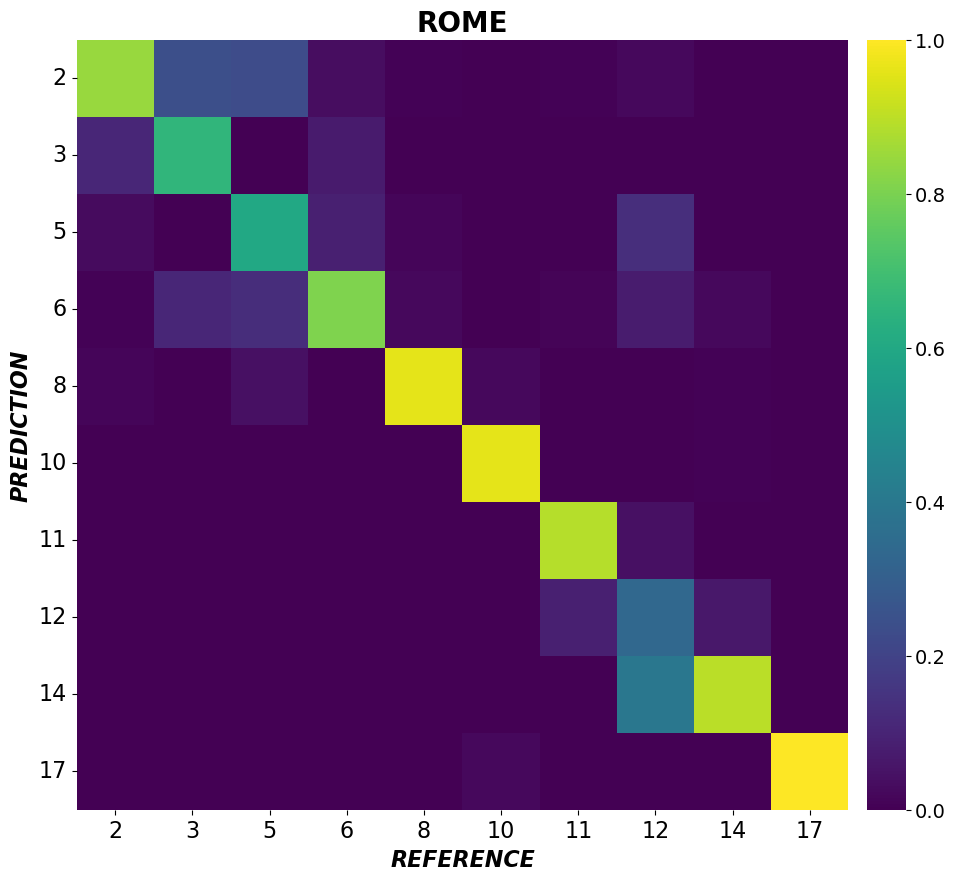

In [120]:
total_cm = None
for fold in results[best_setup][best_strategy]:
    fold_cm = results[best_setup][best_strategy][fold]["Confusion_Matrix"]
    if total_cm is None:
        total_cm = fold_cm.copy()
    else:
        total_cm += fold_cm

# Row Normalize
row_sums = total_cm.sum(axis=1)[:, np.newaxis]
norm_cm = total_cm.astype('float') / (row_sums + 1e-10)

plot_matrix = norm_cm.T 

plt.figure(figsize=(12, 10))
ordered_labels = sorted(splited_ref_data['gridcode'].unique())
ax = sns.heatmap(plot_matrix, 
            annot=False, 
            fmt='.2f', 
            cmap='viridis', 
            vmin=0.0,
            vmax=1.0,
            xticklabels=ordered_labels, 
            yticklabels=ordered_labels,
            cbar_kws={'pad': 0.02})
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=14)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16, rotation=0)
plt.xlabel('REFERENCE', fontsize=16, fontweight='bold', fontstyle='italic')
plt.ylabel('PREDICTION', fontsize=16, fontweight='bold', fontstyle='italic')        
plt.title('ROME', fontweight='bold', fontsize=20)
plt.show()

In [137]:
# save the summed matrix
np.save(r"results\s3\rome_S3_summed_cm.npy", total_cm)

## Prediction

In [138]:
# which set was better?
better_set = non_weighted_set

# output
output = r'outputs\s3\rome_S3.tif'

In [139]:
# get best model of the best set and stategy
best_run = df.loc[best_setup, best_strategy]
best_fold = (best_run['wF1'] + best_run['F1U']).idxmax()
best_model = best_run.loc[best_fold, 'Model']
best_run[["wF1", "F1U", "F1N", "OA"]].loc[best_fold]

wF1    91.76
F1U    91.29
F1N    92.96
OA     90.04
Name: 4, dtype: float64

In [140]:
# run prediction
with rio.open(better_set) as image_data:
    image_meta = image_data.meta
    image = image_data.read()

image_reshaped = rio.plot.reshape_as_image(image)
scene = image_reshaped.reshape(-1, image_reshaped.shape[-1])
scene[np.isinf(scene)] = np.nan
y_pred = best_model.predict(scene)
classified_image = y_pred.reshape(image_reshaped.shape[0], image_reshaped.shape[1])
classification_meta = image_meta.copy()
classification_meta.update({"count": 1})
with rio.open(output, "w", **classification_meta) as dest:
    dest.write(classified_image, indexes=1)

# Sao Paulo

In [2]:
# load splited reference data
splited_ref_data = gpd.read_file(r'ref_data\saopaulo_ref_splitS2S3S4.gpkg')

## Non-weighted RF S1 morphometric subset

In [3]:
# load fused image with subset of morphometrics from non-weighted RF S1 models
non_weighted_set = r'imagery\sao_paulo_20170726_morphometrics_meanminmax_grid.tif'

In [4]:
# results[setup][strategy][fold]
results = {
    setup: {
        strat: {
            fold: {} for fold in folds
        } for strat in strategies
    } for setup in setups
}

### Fold 0

In [5]:
fold = 0
test_polygons = splited_ref_data[splited_ref_data["fold"] == fold]
train_polygons = splited_ref_data[splited_ref_data["fold"] != fold]

In [6]:
train_polygons_raster = fr"saopaulo_train_f{fold}.tif"
test_polygons_raster = fr"saopaulo_test_f{fold}.tif"

utils.rasterize_reference_polygons(train_polygons, non_weighted_set, train_polygons_raster)
utils.rasterize_reference_polygons(test_polygons, non_weighted_set, test_polygons_raster)

In [7]:
with rio.open(non_weighted_set) as image_data:
    image_meta = image_data.meta
    image = image_data.read()

image_reshaped = rio.plot.reshape_as_image(image)
print(f'Image shape: {image.shape} -> {image_reshaped.shape}')

Image shape: (90, 570, 900) -> (570, 900, 90)


In [8]:
# train and test images matched to fusion 100m grid
train_image_matched = utils.match_rasters(train_polygons_raster, non_weighted_set)
test_image_matched = utils.match_rasters(test_polygons_raster, non_weighted_set)

train_image_matched = train_image_matched.to_numpy()
test_image_matched = test_image_matched.to_numpy()

C:\ProgramData\miniconda3\envs\geo\Lib\site-packages\xarray\core\duck_array_ops.py:250: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\ProgramData\miniconda3\envs\geo\Lib\site-packages\xarray\core\duck_array_ops.py:250: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


In [9]:
X_train = image_reshaped[train_image_matched > 0]
y_train = train_image_matched[train_image_matched > 0]
X_test = image_reshaped[test_image_matched > 0]
y_test = test_image_matched[test_image_matched > 0]

X_train[np.isinf(X_train)] = np.nan
X_test[np.isinf(X_test)] = np.nan

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(18358, 90) (18358,)
(3838, 90) (3838,)


#### Non/weighted RF model

In [ ]:
utils.finetune_height(X_train, y_train, X_test, y_test, max_height=10, class_weight=False)

In [ ]:
param, train, test, diff = utils.finetune_max_features(X_train, y_train, X_test, y_test, height=4, max_features=X_train.shape[1], class_weight=False)

In [34]:
param, train, test, diff

(2, 79.95, 78.93, 1.01)

In [10]:
model_fold0 = RandomForestClassifier(random_state=0, n_jobs=-1, max_depth=5, max_features=22, n_estimators=100)
model_fold0.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, max_features=22, n_jobs=-1, random_state=0)

In [11]:
# training accuracy
pred_train = model_fold0.predict(X_train)
train_accuracy = accuracy_score(y_train, pred_train)
print('OA train: ', round(train_accuracy*100,2))
train_wf1 = f1_score(y_train, pred_train, average='weighted', labels=np.unique(y_train))
print('wF1 train: ', round(train_wf1*100,2))

OA train:  87.47
wF1 train:  84.41


In [12]:
# test accuracy
pred_test = model_fold0.predict(X_test)
test_accuracy = accuracy_score(y_test, pred_test)
print('OA test: ', round(test_accuracy*100,2))
test_wf1 = f1_score(y_test, pred_test, average='weighted', labels=np.unique(y_test))
print('wF1 test: ', round(test_wf1*100,2))

# F1U
X_test_urban = X_test[y_test<=10]
y_test_urban = y_test[y_test<=10]
y_test_pred_urb = model_fold0.predict(X_test_urban)
wf1_urb = f1_score(y_test_urban, y_test_pred_urb, average='weighted', labels=np.unique(y_test[y_test<=10]))
print('Urban wF1 test: ', round(wf1_urb*100,2))

# F1N
X_test_nat = X_test[y_test>10]
y_test_nat = y_test[y_test>10]
y_test_pred_nat = model_fold0.predict(X_test_nat)
wf1_nat = f1_score(y_test_nat, y_test_pred_nat, average='weighted', labels=np.unique(y_test[y_test>10]))
print('Natural wF1 test: ', round(wf1_nat*100,2))

conf_mat = confusion_matrix(y_test, pred_test, labels=sorted(splited_ref_data['gridcode'].unique()))

metrics = {
    "OA":  round(test_accuracy*100,2),
    "wF1": round(test_wf1*100,2),
    "F1U": round(wf1_urb*100,2),
    "F1N": round(wf1_nat*100,2),
    "Model": model_fold0,
    "Confusion_Matrix": conf_mat
}

for c in all_possible_classes:
    metrics[f"F1_Class_{c}"] = np.nan
f1_per_class_array = f1_score(y_test, pred_test, average=None, labels=np.unique(y_test))
for label, score in zip(np.unique(y_test), f1_per_class_array):
    if label in all_possible_classes:
        metrics[f"F1_Class_{int(label)}"] = round(score*100, 2)

results["non_weighted_set"]["non_weighted_model"][fold] = metrics

OA test:  81.01
wF1 test:  75.97
Urban wF1 test:  72.52
Natural wF1 test:  87.17


#### Weighted RF model

In [ ]:
utils.finetune_height(X_train, y_train, X_test, y_test, max_height=10, class_weight=True)

In [ ]:
param, train, test, diff = utils.finetune_max_features(X_train, y_train, X_test, y_test, height=4, max_features=X_train.shape[1], class_weight=True)

In [42]:
param, train, test, diff

(31, 58.17, 54.52, 3.65)

In [13]:
model_fold0_weighted = RandomForestClassifier(random_state=0, n_jobs=-1, max_depth=3, max_features=21, class_weight='balanced', n_estimators=100)
model_fold0_weighted.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=3, max_features=21,
                       n_jobs=-1, random_state=0)

In [14]:
# training accuracy
pred_train = model_fold0_weighted.predict(X_train)
train_accuracy = accuracy_score(y_train, pred_train)
print('OA train: ', round(train_accuracy*100,2))
train_wf1 = f1_score(y_train, pred_train, average='weighted', labels=np.unique(y_train))
print('wF1 train: ', round(train_wf1*100,2))

OA train:  86.02
wF1 train:  86.09


In [15]:
# test accuracy
pred_test = model_fold0_weighted.predict(X_test)
test_accuracy = accuracy_score(y_test, pred_test)
print('OA test: ', round(test_accuracy*100,2))
test_wf1 = f1_score(y_test, pred_test, average='weighted', labels=np.unique(y_test))
print('wF1 test: ', round(test_wf1*100,2))

# F1U
X_test_urban = X_test[y_test<=10]
y_test_urban = y_test[y_test<=10]
y_test_pred_urb = model_fold0_weighted.predict(X_test_urban)
wf1_urb = f1_score(y_test_urban, y_test_pred_urb, average='weighted', labels=np.unique(y_test[y_test<=10]))
print('Urban wF1 test: ', round(wf1_urb*100,2))

# F1N
X_test_nat = X_test[y_test>10]
y_test_nat = y_test[y_test>10]
y_test_pred_nat = model_fold0_weighted.predict(X_test_nat)
wf1_nat = f1_score(y_test_nat, y_test_pred_nat, average='weighted', labels=np.unique(y_test[y_test>10]))
print('Natural wF1 test: ', round(wf1_nat*100,2))

conf_mat = confusion_matrix(y_test, pred_test, labels=sorted(splited_ref_data['gridcode'].unique()))

metrics = {
    "OA":  round(test_accuracy*100,2),
    "wF1": round(test_wf1*100,2),
    "F1U": round(wf1_urb*100,2),
    "F1N": round(wf1_nat*100,2),
    "Model": model_fold0_weighted,
    "Confusion_Matrix": conf_mat
}

for c in all_possible_classes:
    metrics[f"F1_Class_{c}"] = np.nan
f1_per_class_array = f1_score(y_test, pred_test, average=None, labels=np.unique(y_test))
for label, score in zip(np.unique(y_test), f1_per_class_array):
    if label in all_possible_classes:
        metrics[f"F1_Class_{int(label)}"] = round(score*100, 2)

results["non_weighted_set"]["weighted_model"][fold] = metrics

OA test:  81.16
wF1 test:  79.99
Urban wF1 test:  76.56
Natural wF1 test:  89.53


### Fold 1

In [16]:
fold = 1
test_polygons = splited_ref_data[splited_ref_data["fold"] == fold]
train_polygons = splited_ref_data[splited_ref_data["fold"] != fold]

In [17]:
train_polygons_raster = fr"saopaulo_train_f{fold}.tif"
test_polygons_raster = fr"saopaulo_test_f{fold}.tif"

utils.rasterize_reference_polygons(train_polygons, non_weighted_set, train_polygons_raster)
utils.rasterize_reference_polygons(test_polygons, non_weighted_set, test_polygons_raster)

In [18]:
with rio.open(non_weighted_set) as image_data:
    image_meta = image_data.meta
    image = image_data.read()

image_reshaped = rio.plot.reshape_as_image(image)
print(f'Image shape: {image.shape} -> {image_reshaped.shape}')

Image shape: (90, 570, 900) -> (570, 900, 90)


In [19]:
# train and test images matched to fusion 100m grid
train_image_matched = utils.match_rasters(train_polygons_raster, non_weighted_set)
test_image_matched = utils.match_rasters(test_polygons_raster, non_weighted_set)

train_image_matched = train_image_matched.to_numpy()
test_image_matched = test_image_matched.to_numpy()

C:\ProgramData\miniconda3\envs\geo\Lib\site-packages\xarray\core\duck_array_ops.py:250: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\ProgramData\miniconda3\envs\geo\Lib\site-packages\xarray\core\duck_array_ops.py:250: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


In [20]:
X_train = image_reshaped[train_image_matched > 0]
y_train = train_image_matched[train_image_matched > 0]
X_test = image_reshaped[test_image_matched > 0]
y_test = test_image_matched[test_image_matched > 0]

X_train[np.isinf(X_train)] = np.nan
X_test[np.isinf(X_test)] = np.nan

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(18532, 90) (18532,)
(3664, 90) (3664,)


#### Non/weighted RF model

In [ ]:
utils.finetune_height(X_train, y_train, X_test, y_test, max_height=10, class_weight=False)

In [ ]:
param, train, test, diff = utils.finetune_max_features(X_train, y_train, X_test, y_test, height=4, max_features=X_train.shape[1], class_weight=False)

In [ ]:
param, train, test, diff

In [21]:
model_fold1 = RandomForestClassifier(random_state=0, n_jobs=-1, max_depth=8, max_features=31, n_estimators=100)
model_fold1.fit(X_train, y_train)

RandomForestClassifier(max_depth=8, max_features=31, n_jobs=-1, random_state=0)

In [22]:
# training accuracy
pred_train = model_fold1.predict(X_train)
train_accuracy = accuracy_score(y_train, pred_train)
print('OA train: ', round(train_accuracy*100,2))
train_wf1 = f1_score(y_train, pred_train, average='weighted', labels=np.unique(y_train))
print('wF1 train: ', round(train_wf1*100,2))

OA train:  92.56
wF1 train:  91.69


In [23]:
# test accuracy
pred_test = model_fold1.predict(X_test)
test_accuracy = accuracy_score(y_test, pred_test)
print('OA test: ', round(test_accuracy*100,2))
test_wf1 = f1_score(y_test, pred_test, average='weighted', labels=np.unique(y_test))
print('wF1 test: ', round(test_wf1*100,2))

# F1U
X_test_urban = X_test[y_test<=10]
y_test_urban = y_test[y_test<=10]
y_test_pred_urb = model_fold1.predict(X_test_urban)
wf1_urb = f1_score(y_test_urban, y_test_pred_urb, average='weighted', labels=np.unique(y_test[y_test<=10]))
print('Urban wF1 test: ', round(wf1_urb*100,2))

# F1N
X_test_nat = X_test[y_test>10]
y_test_nat = y_test[y_test>10]
y_test_pred_nat = model_fold1.predict(X_test_nat)
wf1_nat = f1_score(y_test_nat, y_test_pred_nat, average='weighted', labels=np.unique(y_test[y_test>10]))
print('Natural wF1 test: ', round(wf1_nat*100,2))

conf_mat = confusion_matrix(y_test, pred_test, labels=sorted(splited_ref_data['gridcode'].unique()))

metrics = {
    "OA":  round(test_accuracy*100,2),
    "wF1": round(test_wf1*100,2),
    "F1U": round(wf1_urb*100,2),
    "F1N": round(wf1_nat*100,2),
    "Model": model_fold1,
    "Confusion_Matrix": conf_mat
}

for c in all_possible_classes:
    metrics[f"F1_Class_{c}"] = np.nan
f1_per_class_array = f1_score(y_test, pred_test, average=None, labels=np.unique(y_test))
for label, score in zip(np.unique(y_test), f1_per_class_array):
    if label in all_possible_classes:
        metrics[f"F1_Class_{int(label)}"] = round(score*100, 2)

results["non_weighted_set"]["non_weighted_model"][fold] = metrics

OA test:  87.96
wF1 test:  85.31
Urban wF1 test:  86.04
Natural wF1 test:  86.94


#### Weighted RF model

In [ ]:
utils.finetune_height(X_train, y_train, X_test, y_test, max_height=10, class_weight=True)

In [ ]:
param, train, test, diff = utils.finetune_max_features(X_train, y_train, X_test, y_test, height=3, max_features=X_train.shape[1], class_weight=True)

In [ ]:
param, train, test, diff

In [24]:
model_fold1_weighted = RandomForestClassifier(random_state=0, n_jobs=-1, max_depth=6, max_features=7, class_weight='balanced', n_estimators=100)
model_fold1_weighted.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=6, max_features=7,
                       n_jobs=-1, random_state=0)

In [25]:
# training accuracy
pred_train = model_fold1_weighted.predict(X_train)
train_accuracy = accuracy_score(y_train, pred_train)
print('OA train: ', round(train_accuracy*100,2))
train_wf1 = f1_score(y_train, pred_train, average='weighted', labels=np.unique(y_train))
print('wF1 train: ', round(train_wf1*100,2))

OA train:  87.65
wF1 train:  89.14


In [26]:
# test accuracy
pred_test = model_fold1_weighted.predict(X_test)
test_accuracy = accuracy_score(y_test, pred_test)
print('OA test: ', round(test_accuracy*100,2))
test_wf1 = f1_score(y_test, pred_test, average='weighted', labels=np.unique(y_test))
print('wF1 test: ', round(test_wf1*100,2))

# F1U
X_test_urban = X_test[y_test<=10]
y_test_urban = y_test[y_test<=10]
y_test_pred_urb = model_fold1_weighted.predict(X_test_urban)
wf1_urb = f1_score(y_test_urban, y_test_pred_urb, average='weighted', labels=np.unique(y_test[y_test<=10]))
print('Urban wF1 test: ', round(wf1_urb*100,2))

# F1N
X_test_nat = X_test[y_test>10]
y_test_nat = y_test[y_test>10]
y_test_pred_nat = model_fold1_weighted.predict(X_test_nat)
wf1_nat = f1_score(y_test_nat, y_test_pred_nat, average='weighted', labels=np.unique(y_test[y_test>10]))
print('Natural wF1 test: ', round(wf1_nat*100,2))

conf_mat = confusion_matrix(y_test, pred_test, labels=sorted(splited_ref_data['gridcode'].unique()))

metrics = {
    "OA":  round(test_accuracy*100,2),
    "wF1": round(test_wf1*100,2),
    "F1U": round(wf1_urb*100,2),
    "F1N": round(wf1_nat*100,2),
    "Model": model_fold1_weighted,
    "Confusion_Matrix": conf_mat
}

for c in all_possible_classes:
    metrics[f"F1_Class_{c}"] = np.nan
f1_per_class_array = f1_score(y_test, pred_test, average=None, labels=np.unique(y_test))
for label, score in zip(np.unique(y_test), f1_per_class_array):
    if label in all_possible_classes:
        metrics[f"F1_Class_{int(label)}"] = round(score*100, 2)

results["non_weighted_set"]["weighted_model"][fold] = metrics

OA test:  82.86
wF1 test:  84.87
Urban wF1 test:  84.82
Natural wF1 test:  87.33


### Fold 2

In [27]:
fold = 2
test_polygons = splited_ref_data[splited_ref_data["fold"] == fold]
train_polygons = splited_ref_data[splited_ref_data["fold"] != fold]

In [28]:
train_polygons_raster = fr"saopaulo_train_f{fold}.tif"
test_polygons_raster = fr"saopaulo_test_f{fold}.tif"

utils.rasterize_reference_polygons(train_polygons, non_weighted_set, train_polygons_raster)
utils.rasterize_reference_polygons(test_polygons, non_weighted_set, test_polygons_raster)

In [29]:
with rio.open(non_weighted_set) as image_data:
    image_meta = image_data.meta
    image = image_data.read()

image_reshaped = rio.plot.reshape_as_image(image)
print(f'Image shape: {image.shape} -> {image_reshaped.shape}')

Image shape: (90, 570, 900) -> (570, 900, 90)


In [30]:
# train and test images matched to fusion 100m grid
train_image_matched = utils.match_rasters(train_polygons_raster, non_weighted_set)
test_image_matched = utils.match_rasters(test_polygons_raster, non_weighted_set)

train_image_matched = train_image_matched.to_numpy()
test_image_matched = test_image_matched.to_numpy()

C:\ProgramData\miniconda3\envs\geo\Lib\site-packages\xarray\core\duck_array_ops.py:250: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\ProgramData\miniconda3\envs\geo\Lib\site-packages\xarray\core\duck_array_ops.py:250: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


In [31]:
X_train = image_reshaped[train_image_matched > 0]
y_train = train_image_matched[train_image_matched > 0]
X_test = image_reshaped[test_image_matched > 0]
y_test = test_image_matched[test_image_matched > 0]

X_train[np.isinf(X_train)] = np.nan
X_test[np.isinf(X_test)] = np.nan

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(15933, 90) (15933,)
(6263, 90) (6263,)


#### Non/weighted RF model

In [ ]:
utils.finetune_height(X_train, y_train, X_test, y_test, max_height=10, class_weight=False)

In [ ]:
param, train, test, diff = utils.finetune_max_features(X_train, y_train, X_test, y_test, height=7, max_features=X_train.shape[1], class_weight=False)

In [76]:
param, train, test, diff

(6, 87.33, 82.49, 4.84)

In [32]:
model_fold2 = RandomForestClassifier(random_state=0, n_jobs=-1, max_depth=7, max_features=37, n_estimators=100)
model_fold2.fit(X_train, y_train)

RandomForestClassifier(max_depth=7, max_features=37, n_jobs=-1, random_state=0)

In [33]:
# training accuracy
pred_train = model_fold2.predict(X_train)
train_accuracy = accuracy_score(y_train, pred_train)
print('OA train: ', round(train_accuracy*100,2))
train_wf1 = f1_score(y_train, pred_train, average='weighted', labels=np.unique(y_train))
print('wF1 train: ', round(train_wf1*100,2))

OA train:  90.02
wF1 train:  88.55


In [34]:
# test accuracy
pred_test = model_fold2.predict(X_test)
test_accuracy = accuracy_score(y_test, pred_test)
print('OA test: ', round(test_accuracy*100,2))
test_wf1 = f1_score(y_test, pred_test, average='weighted', labels=np.unique(y_test))
print('wF1 test: ', round(test_wf1*100,2))

# F1U
X_test_urban = X_test[y_test<=10]
y_test_urban = y_test[y_test<=10]
y_test_pred_urb = model_fold2.predict(X_test_urban)
wf1_urb = f1_score(y_test_urban, y_test_pred_urb, average='weighted', labels=np.unique(y_test[y_test<=10]))
print('Urban wF1 test: ', round(wf1_urb*100,2))

# F1N
X_test_nat = X_test[y_test>10]
y_test_nat = y_test[y_test>10]
y_test_pred_nat = model_fold2.predict(X_test_nat)
wf1_nat = f1_score(y_test_nat, y_test_pred_nat, average='weighted', labels=np.unique(y_test[y_test>10]))
print('Natural wF1 test: ', round(wf1_nat*100,2))

conf_mat = confusion_matrix(y_test, pred_test, labels=sorted(splited_ref_data['gridcode'].unique()))

metrics = {
    "OA":  round(test_accuracy*100,2),
    "wF1": round(test_wf1*100,2),
    "F1U": round(wf1_urb*100,2),
    "F1N": round(wf1_nat*100,2),
    "Model": model_fold2,
    "Confusion_Matrix": conf_mat
}

for c in all_possible_classes:
    metrics[f"F1_Class_{c}"] = np.nan
f1_per_class_array = f1_score(y_test, pred_test, average=None, labels=np.unique(y_test))
for label, score in zip(np.unique(y_test), f1_per_class_array):
    if label in all_possible_classes:
        metrics[f"F1_Class_{int(label)}"] = round(score*100, 2)

results["non_weighted_set"]["non_weighted_model"][fold] = metrics

OA test:  85.98
wF1 test:  85.17
Urban wF1 test:  78.21
Natural wF1 test:  90.23


#### Weighted RF model

In [ ]:
utils.finetune_height(X_train, y_train, X_test, y_test, max_height=10, class_weight=True)

In [ ]:
param, train, test, diff = utils.finetune_max_features(X_train, y_train, X_test, y_test, height=8, max_features=X_train.shape[1], class_weight=True)

In [87]:
param, train, test, diff

(5, 86.05, 83.01, 3.04)

In [35]:
model_fold2_weighted = RandomForestClassifier(random_state=0, n_jobs=-1, max_depth=8, max_features=21, class_weight='balanced', n_estimators=100)
model_fold2_weighted.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=8, max_features=21,
                       n_jobs=-1, random_state=0)

In [36]:
# training accuracy
pred_train = model_fold2_weighted.predict(X_train)
train_accuracy = accuracy_score(y_train, pred_train)
print('OA train: ', round(train_accuracy*100,2))
train_wf1 = f1_score(y_train, pred_train, average='weighted', labels=np.unique(y_train))
print('wF1 train: ', round(train_wf1*100,2))

OA train:  88.9
wF1 train:  90.74


In [37]:
# test accuracy
pred_test = model_fold2_weighted.predict(X_test)
test_accuracy = accuracy_score(y_test, pred_test)
print('OA test: ', round(test_accuracy*100,2))
test_wf1 = f1_score(y_test, pred_test, average='weighted', labels=np.unique(y_test))
print('wF1 test: ', round(test_wf1*100,2))

# F1U
X_test_urban = X_test[y_test<=10]
y_test_urban = y_test[y_test<=10]
y_test_pred_urb = model_fold2_weighted.predict(X_test_urban)
wf1_urb = f1_score(y_test_urban, y_test_pred_urb, average='weighted', labels=np.unique(y_test[y_test<=10]))
print('Urban wF1 test: ', round(wf1_urb*100,2))

# F1N
X_test_nat = X_test[y_test>10]
y_test_nat = y_test[y_test>10]
y_test_pred_nat = model_fold2_weighted.predict(X_test_nat)
wf1_nat = f1_score(y_test_nat, y_test_pred_nat, average='weighted', labels=np.unique(y_test[y_test>10]))
print('Natural wF1 test: ', round(wf1_nat*100,2))

conf_mat = confusion_matrix(y_test, pred_test, labels=sorted(splited_ref_data['gridcode'].unique()))

metrics = {
    "OA":  round(test_accuracy*100,2),
    "wF1": round(test_wf1*100,2),
    "F1U": round(wf1_urb*100,2),
    "F1N": round(wf1_nat*100,2),
    "Model": model_fold2_weighted,
    "Confusion_Matrix": conf_mat
}

for c in all_possible_classes:
    metrics[f"F1_Class_{c}"] = np.nan
f1_per_class_array = f1_score(y_test, pred_test, average=None, labels=np.unique(y_test))
for label, score in zip(np.unique(y_test), f1_per_class_array):
    if label in all_possible_classes:
        metrics[f"F1_Class_{int(label)}"] = round(score*100, 2)

results["non_weighted_set"]["weighted_model"][fold] = metrics

OA test:  84.05
wF1 test:  85.97
Urban wF1 test:  78.78
Natural wF1 test:  90.88


### Fold 3

In [38]:
fold = 3
test_polygons = splited_ref_data[splited_ref_data["fold"] == fold]
train_polygons = splited_ref_data[splited_ref_data["fold"] != fold]

In [39]:
train_polygons_raster = fr"saopaulo_train_f{fold}.tif"
test_polygons_raster = fr"saopaulo_test_f{fold}.tif"

utils.rasterize_reference_polygons(train_polygons, non_weighted_set, train_polygons_raster)
utils.rasterize_reference_polygons(test_polygons, non_weighted_set, test_polygons_raster)

In [40]:
with rio.open(non_weighted_set) as image_data:
    image_meta = image_data.meta
    image = image_data.read()

image_reshaped = rio.plot.reshape_as_image(image)
print(f'Image shape: {image.shape} -> {image_reshaped.shape}')

Image shape: (90, 570, 900) -> (570, 900, 90)


In [41]:
# train and test images matched to fusion 100m grid
train_image_matched = utils.match_rasters(train_polygons_raster, non_weighted_set)
test_image_matched = utils.match_rasters(test_polygons_raster, non_weighted_set)

train_image_matched = train_image_matched.to_numpy()
test_image_matched = test_image_matched.to_numpy()

C:\ProgramData\miniconda3\envs\geo\Lib\site-packages\xarray\core\duck_array_ops.py:250: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\ProgramData\miniconda3\envs\geo\Lib\site-packages\xarray\core\duck_array_ops.py:250: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


In [42]:
X_train = image_reshaped[train_image_matched > 0]
y_train = train_image_matched[train_image_matched > 0]
X_test = image_reshaped[test_image_matched > 0]
y_test = test_image_matched[test_image_matched > 0]

X_train[np.isinf(X_train)] = np.nan
X_test[np.isinf(X_test)] = np.nan

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(18649, 90) (18649,)
(3547, 90) (3547,)


#### Non/weighted RF model

In [ ]:
utils.finetune_height(X_train, y_train, X_test, y_test, max_height=10, class_weight=False)

In [ ]:
param, train, test, diff = utils.finetune_max_features(X_train, y_train, X_test, y_test, height=7, max_features=X_train.shape[1], class_weight=False)

In [95]:
param, train, test, diff

(69, 89.65, 85.02, 4.63)

In [43]:
model_fold3 = RandomForestClassifier(random_state=0, n_jobs=-1, max_depth=7, max_features=15, n_estimators=100)
model_fold3.fit(X_train, y_train)

RandomForestClassifier(max_depth=7, max_features=15, n_jobs=-1, random_state=0)

In [44]:
# training accuracy
pred_train = model_fold3.predict(X_train)
train_accuracy = accuracy_score(y_train, pred_train)
print('OA train: ', round(train_accuracy*100,2))
train_wf1 = f1_score(y_train, pred_train, average='weighted', labels=np.unique(y_train))
print('wF1 train: ', round(train_wf1*100,2))

OA train:  91.28
wF1 train:  89.96


In [45]:
# test accuracy
pred_test = model_fold3.predict(X_test)
test_accuracy = accuracy_score(y_test, pred_test)
print('OA test: ', round(test_accuracy*100,2))
test_wf1 = f1_score(y_test, pred_test, average='weighted', labels=np.unique(y_test))
print('wF1 test: ', round(test_wf1*100,2))

# F1U
X_test_urban = X_test[y_test<=10]
y_test_urban = y_test[y_test<=10]
y_test_pred_urb = model_fold3.predict(X_test_urban)
wf1_urb = f1_score(y_test_urban, y_test_pred_urb, average='weighted', labels=np.unique(y_test[y_test<=10]))
print('Urban wF1 test: ', round(wf1_urb*100,2))

# F1N
X_test_nat = X_test[y_test>10]
y_test_nat = y_test[y_test>10]
y_test_pred_nat = model_fold3.predict(X_test_nat)
wf1_nat = f1_score(y_test_nat, y_test_pred_nat, average='weighted', labels=np.unique(y_test[y_test>10]))
print('Natural wF1 test: ', round(wf1_nat*100,2))

conf_mat = confusion_matrix(y_test, pred_test, labels=sorted(splited_ref_data['gridcode'].unique()))

metrics = {
    "OA":  round(test_accuracy*100,2),
    "wF1": round(test_wf1*100,2),
    "F1U": round(wf1_urb*100,2),
    "F1N": round(wf1_nat*100,2),
    "Model": model_fold3,
    "Confusion_Matrix": conf_mat
}

for c in all_possible_classes:
    metrics[f"F1_Class_{c}"] = np.nan
f1_per_class_array = f1_score(y_test, pred_test, average=None, labels=np.unique(y_test))
for label, score in zip(np.unique(y_test), f1_per_class_array):
    if label in all_possible_classes:
        metrics[f"F1_Class_{int(label)}"] = round(score*100, 2)

results["non_weighted_set"]["non_weighted_model"][fold] = metrics

OA test:  86.97
wF1 test:  84.77
Urban wF1 test:  82.85
Natural wF1 test:  88.9


#### Weighted RF model

In [ ]:
utils.finetune_height(X_train, y_train, X_test, y_test, max_height=10, class_weight=True)

In [ ]:
param, train, test, diff = utils.finetune_max_features(X_train, y_train, X_test, y_test, height=9, max_features=X_train.shape[1], class_weight=True)

In [102]:
param, train, test, diff

(11, 88.6, 84.79, 3.8)

In [46]:
model_fold3_weighted = RandomForestClassifier(random_state=0, n_jobs=-1, max_depth=3, max_features=16, class_weight='balanced', n_estimators=100)
model_fold3_weighted.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=3, max_features=16,
                       n_jobs=-1, random_state=0)

In [47]:
# training accuracy
pred_train = model_fold3_weighted.predict(X_train)
train_accuracy = accuracy_score(y_train, pred_train)
print('OA train: ', round(train_accuracy*100,2))
train_wf1 = f1_score(y_train, pred_train, average='weighted', labels=np.unique(y_train))
print('wF1 train: ', round(train_wf1*100,2))

OA train:  85.32
wF1 train:  84.49


In [48]:
# test accuracy
pred_test = model_fold3_weighted.predict(X_test)
test_accuracy = accuracy_score(y_test, pred_test)
print('OA test: ', round(test_accuracy*100,2))
test_wf1 = f1_score(y_test, pred_test, average='weighted', labels=np.unique(y_test))
print('wF1 test: ', round(test_wf1*100,2))

# F1U
X_test_urban = X_test[y_test<=10]
y_test_urban = y_test[y_test<=10]
y_test_pred_urb = model_fold3_weighted.predict(X_test_urban)
wf1_urb = f1_score(y_test_urban, y_test_pred_urb, average='weighted', labels=np.unique(y_test[y_test<=10]))
print('Urban wF1 test: ', round(wf1_urb*100,2))

# F1N
X_test_nat = X_test[y_test>10]
y_test_nat = y_test[y_test>10]
y_test_pred_nat = model_fold3_weighted.predict(X_test_nat)
wf1_nat = f1_score(y_test_nat, y_test_pred_nat, average='weighted', labels=np.unique(y_test[y_test>10]))
print('Natural wF1 test: ', round(wf1_nat*100,2))

conf_mat = confusion_matrix(y_test, pred_test, labels=sorted(splited_ref_data['gridcode'].unique()))

metrics = {
    "OA":  round(test_accuracy*100,2),
    "wF1": round(test_wf1*100,2),
    "F1U": round(wf1_urb*100,2),
    "F1N": round(wf1_nat*100,2),
    "Model": model_fold3_weighted,
    "Confusion_Matrix": conf_mat
}

for c in all_possible_classes:
    metrics[f"F1_Class_{c}"] = np.nan
f1_per_class_array = f1_score(y_test, pred_test, average=None, labels=np.unique(y_test))
for label, score in zip(np.unique(y_test), f1_per_class_array):
    if label in all_possible_classes:
        metrics[f"F1_Class_{int(label)}"] = round(score*100, 2)

results["non_weighted_set"]["weighted_model"][fold] = metrics

OA test:  80.49
wF1 test:  80.05
Urban wF1 test:  77.33
Natural wF1 test:  84.32


### Fold 4

In [49]:
fold = 4
test_polygons = splited_ref_data[splited_ref_data["fold"] == fold]
train_polygons = splited_ref_data[splited_ref_data["fold"] != fold]

In [50]:
train_polygons_raster = fr"saopaulo_train_f{fold}.tif"
test_polygons_raster = fr"saopaulo_test_f{fold}.tif"

utils.rasterize_reference_polygons(train_polygons, non_weighted_set, train_polygons_raster)
utils.rasterize_reference_polygons(test_polygons, non_weighted_set, test_polygons_raster)

In [51]:
with rio.open(non_weighted_set) as image_data:
    image_meta = image_data.meta
    image = image_data.read()

image_reshaped = rio.plot.reshape_as_image(image)
print(f'Image shape: {image.shape} -> {image_reshaped.shape}')

Image shape: (90, 570, 900) -> (570, 900, 90)


In [52]:
# train and test images matched to fusion 100m grid
train_image_matched = utils.match_rasters(train_polygons_raster, non_weighted_set)
test_image_matched = utils.match_rasters(test_polygons_raster, non_weighted_set)

train_image_matched = train_image_matched.to_numpy()
test_image_matched = test_image_matched.to_numpy()

C:\ProgramData\miniconda3\envs\geo\Lib\site-packages\xarray\core\duck_array_ops.py:250: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\ProgramData\miniconda3\envs\geo\Lib\site-packages\xarray\core\duck_array_ops.py:250: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


In [53]:
X_train = image_reshaped[train_image_matched > 0]
y_train = train_image_matched[train_image_matched > 0]
X_test = image_reshaped[test_image_matched > 0]
y_test = test_image_matched[test_image_matched > 0]

X_train[np.isinf(X_train)] = np.nan
X_test[np.isinf(X_test)] = np.nan

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(17312, 90) (17312,)
(4884, 90) (4884,)


#### Non/weighted RF model

In [ ]:
utils.finetune_height(X_train, y_train, X_test, y_test, max_height=10, class_weight=False)

In [ ]:
param, train, test, diff = utils.finetune_max_features(X_train, y_train, X_test, y_test, height=6, max_features=X_train.shape[1], class_weight=False)

In [115]:
param, train, test, diff

(8, 86.44, 82.9, 3.54)

In [54]:
model_fold4 = RandomForestClassifier(random_state=0, n_jobs=-1, max_depth=10, max_features=5, n_estimators=100)
model_fold4.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, max_features=5, n_jobs=-1, random_state=0)

In [55]:
# training accuracy
pred_train = model_fold4.predict(X_train)
train_accuracy = accuracy_score(y_train, pred_train)
print('OA train: ', round(train_accuracy*100,2))
train_wf1 = f1_score(y_train, pred_train, average='weighted', labels=np.unique(y_train))
print('wF1 train: ', round(train_wf1*100,2))

OA train:  96.63
wF1 train:  96.46


In [56]:
# test accuracy
pred_test = model_fold4.predict(X_test)
test_accuracy = accuracy_score(y_test, pred_test)
print('OA test: ', round(test_accuracy*100,2))
test_wf1 = f1_score(y_test, pred_test, average='weighted', labels=np.unique(y_test))
print('wF1 test: ', round(test_wf1*100,2))

# F1U
X_test_urban = X_test[y_test<=10]
y_test_urban = y_test[y_test<=10]
y_test_pred_urb = model_fold4.predict(X_test_urban)
wf1_urb = f1_score(y_test_urban, y_test_pred_urb, average='weighted', labels=np.unique(y_test[y_test<=10]))
print('Urban wF1 test: ', round(wf1_urb*100,2))

# F1N
X_test_nat = X_test[y_test>10]
y_test_nat = y_test[y_test>10]
y_test_pred_nat = model_fold4.predict(X_test_nat)
wf1_nat = f1_score(y_test_nat, y_test_pred_nat, average='weighted', labels=np.unique(y_test[y_test>10]))
print('Natural wF1 test: ', round(wf1_nat*100,2))

conf_mat = confusion_matrix(y_test, pred_test, labels=sorted(splited_ref_data['gridcode'].unique()))

metrics = {
    "OA":  round(test_accuracy*100,2),
    "wF1": round(test_wf1*100,2),
    "F1U": round(wf1_urb*100,2),
    "F1N": round(wf1_nat*100,2),
    "Model": model_fold4,
    "Confusion_Matrix": conf_mat
}

for c in all_possible_classes:
    metrics[f"F1_Class_{c}"] = np.nan
f1_per_class_array = f1_score(y_test, pred_test, average=None, labels=np.unique(y_test))
for label, score in zip(np.unique(y_test), f1_per_class_array):
    if label in all_possible_classes:
        metrics[f"F1_Class_{int(label)}"] = round(score*100, 2)

results["non_weighted_set"]["non_weighted_model"][fold] = metrics

OA test:  91.69
wF1 test:  91.02
Urban wF1 test:  90.5
Natural wF1 test:  92.35


#### Weighted RF model

In [ ]:
utils.finetune_height(X_train, y_train, X_test, y_test, max_height=10, class_weight=True)

In [ ]:
param, train, test, diff = utils.finetune_max_features(X_train, y_train, X_test, y_test, height=5, max_features=X_train.shape[1], class_weight=True)

In [124]:
param, train, test, diff

(11, 78.4, 74.37, 4.03)

In [57]:
model_fold4_weighted = RandomForestClassifier(random_state=0, n_jobs=-1, max_depth=11, max_features=14, class_weight='balanced', n_estimators=100)
model_fold4_weighted.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=11, max_features=14,
                       n_jobs=-1, random_state=0)

In [58]:
# training accuracy
pred_train = model_fold4_weighted.predict(X_train)
train_accuracy = accuracy_score(y_train, pred_train)
print('OA train: ', round(train_accuracy*100,2))
train_wf1 = f1_score(y_train, pred_train, average='weighted', labels=np.unique(y_train))
print('wF1 train: ', round(train_wf1*100,2))

OA train:  93.67
wF1 train:  94.54


In [59]:
# test accuracy
pred_test = model_fold4_weighted.predict(X_test)
test_accuracy = accuracy_score(y_test, pred_test)
print('OA test: ', round(test_accuracy*100,2))
test_wf1 = f1_score(y_test, pred_test, average='weighted', labels=np.unique(y_test))
print('wF1 test: ', round(test_wf1*100,2))

# F1U
X_test_urban = X_test[y_test<=10]
y_test_urban = y_test[y_test<=10]
y_test_pred_urb = model_fold4_weighted.predict(X_test_urban)
wf1_urb = f1_score(y_test_urban, y_test_pred_urb, average='weighted', labels=np.unique(y_test[y_test<=10]))
print('Urban wF1 test: ', round(wf1_urb*100,2))

# F1N
X_test_nat = X_test[y_test>10]
y_test_nat = y_test[y_test>10]
y_test_pred_nat = model_fold4_weighted.predict(X_test_nat)
wf1_nat = f1_score(y_test_nat, y_test_pred_nat, average='weighted', labels=np.unique(y_test[y_test>10]))
print('Natural wF1 test: ', round(wf1_nat*100,2))

conf_mat = confusion_matrix(y_test, pred_test, labels=sorted(splited_ref_data['gridcode'].unique()))

metrics = {
    "OA":  round(test_accuracy*100,2),
    "wF1": round(test_wf1*100,2),
    "F1U": round(wf1_urb*100,2),
    "F1N": round(wf1_nat*100,2),
    "Model": model_fold4_weighted,
    "Confusion_Matrix": conf_mat
}

for c in all_possible_classes:
    metrics[f"F1_Class_{c}"] = np.nan
f1_per_class_array = f1_score(y_test, pred_test, average=None, labels=np.unique(y_test))
for label, score in zip(np.unique(y_test), f1_per_class_array):
    if label in all_possible_classes:
        metrics[f"F1_Class_{int(label)}"] = round(score*100, 2)

results["non_weighted_set"]["weighted_model"][fold] = metrics

OA test:  88.76
wF1 test:  90.69
Urban wF1 test:  89.26
Natural wF1 test:  92.45


## Weighted RF S1 morphometric subset

In [60]:
# load fused image with subset of morphometrics from weighted RF S1 models
weighted_set = r'imagery\sao_paulo_20170726_morphometrics_weighted_meanminmax_grid.tif'

### Fold 0

In [61]:
fold = 0
test_polygons = splited_ref_data[splited_ref_data["fold"] == fold]
train_polygons = splited_ref_data[splited_ref_data["fold"] != fold]

In [62]:
train_polygons_raster = fr"saopaulo_train_f{fold}.tif"
test_polygons_raster = fr"saopaulo_test_f{fold}.tif"

utils.rasterize_reference_polygons(train_polygons, weighted_set, train_polygons_raster)
utils.rasterize_reference_polygons(test_polygons, weighted_set, test_polygons_raster)

In [63]:
with rio.open(weighted_set) as image_data:
    image_meta = image_data.meta
    image = image_data.read()

image_reshaped = rio.plot.reshape_as_image(image)
print(f'Image shape: {image.shape} -> {image_reshaped.shape}')

Image shape: (90, 570, 900) -> (570, 900, 90)


In [64]:
# train and test images matched to fusion 100m grid
train_image_matched = utils.match_rasters(train_polygons_raster, weighted_set)
test_image_matched = utils.match_rasters(test_polygons_raster, weighted_set)

train_image_matched = train_image_matched.to_numpy()
test_image_matched = test_image_matched.to_numpy()

C:\ProgramData\miniconda3\envs\geo\Lib\site-packages\xarray\core\duck_array_ops.py:250: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\ProgramData\miniconda3\envs\geo\Lib\site-packages\xarray\core\duck_array_ops.py:250: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


In [65]:
X_train = image_reshaped[train_image_matched > 0]
y_train = train_image_matched[train_image_matched > 0]
X_test = image_reshaped[test_image_matched > 0]
y_test = test_image_matched[test_image_matched > 0]

X_train[np.isinf(X_train)] = np.nan
X_test[np.isinf(X_test)] = np.nan

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(18358, 90) (18358,)
(3838, 90) (3838,)


#### Non/weighted RF model

In [ ]:
utils.finetune_height(X_train, y_train, X_test, y_test, max_height=10, class_weight=False)

In [ ]:
param, train, test, diff = utils.finetune_max_features(X_train, y_train, X_test, y_test, height=5, max_features=X_train.shape[1], class_weight=False)

In [146]:
param, train, test, diff

(1, 81.27, 78.91, 2.36)

In [66]:
ws_model_fold0 = RandomForestClassifier(random_state=0, n_jobs=-1, max_depth=3, max_features=17, n_estimators=100)
ws_model_fold0.fit(X_train, y_train)

RandomForestClassifier(max_depth=3, max_features=17, n_jobs=-1, random_state=0)

In [67]:
# training accuracy
pred_train = ws_model_fold0.predict(X_train)
train_accuracy = accuracy_score(y_train, pred_train)
print('OA train: ', round(train_accuracy*100,2))
train_wf1 = f1_score(y_train, pred_train, average='weighted', labels=np.unique(y_train))
print('wF1 train: ', round(train_wf1*100,2))

OA train:  84.62
wF1 train:  80.4


In [68]:
# test accuracy
pred_test = ws_model_fold0.predict(X_test)
test_accuracy = accuracy_score(y_test, pred_test)
print('OA test: ', round(test_accuracy*100,2))
test_wf1 = f1_score(y_test, pred_test, average='weighted', labels=np.unique(y_test))
print('wF1 test: ', round(test_wf1*100,2))

# F1U
X_test_urban = X_test[y_test<=10]
y_test_urban = y_test[y_test<=10]
y_test_pred_urb = ws_model_fold0.predict(X_test_urban)
wf1_urb = f1_score(y_test_urban, y_test_pred_urb, average='weighted', labels=np.unique(y_test[y_test<=10]))
print('Urban wF1 test: ', round(wf1_urb*100,2))

# F1N
X_test_nat = X_test[y_test>10]
y_test_nat = y_test[y_test>10]
y_test_pred_nat = ws_model_fold0.predict(X_test_nat)
wf1_nat = f1_score(y_test_nat, y_test_pred_nat, average='weighted', labels=np.unique(y_test[y_test>10]))
print('Natural wF1 test: ', round(wf1_nat*100,2))

conf_mat = confusion_matrix(y_test, pred_test, labels=sorted(splited_ref_data['gridcode'].unique()))

metrics = {
    "OA":  round(test_accuracy*100,2),
    "wF1": round(test_wf1*100,2),
    "F1U": round(wf1_urb*100,2),
    "F1N": round(wf1_nat*100,2),
    "Model": ws_model_fold0,
    "Confusion_Matrix": conf_mat
}

for c in all_possible_classes:
    metrics[f"F1_Class_{c}"] = np.nan
f1_per_class_array = f1_score(y_test, pred_test, average=None, labels=np.unique(y_test))
for label, score in zip(np.unique(y_test), f1_per_class_array):
    if label in all_possible_classes:
        metrics[f"F1_Class_{int(label)}"] = round(score*100, 2)
        
results["weighted_set"]["non_weighted_model"][fold] = metrics

OA test:  75.95
wF1 test:  69.6
Urban wF1 test:  63.15
Natural wF1 test:  87.39


#### Weighted RF model

In [ ]:
utils.finetune_height(X_train, y_train, X_test, y_test, max_height=10, class_weight=True)

In [ ]:
param, train, test, diff = utils.finetune_max_features(X_train, y_train, X_test, y_test, height=5, max_features=X_train.shape[1], class_weight=True)

In [152]:
param, train, test, diff

(41, 61.59, 57.0, 4.59)

In [69]:
ws_model_fold0_weighted = RandomForestClassifier(random_state=0, n_jobs=-1, max_depth=3, max_features=9, class_weight='balanced', n_estimators=100)
ws_model_fold0_weighted.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=3, max_features=9,
                       n_jobs=-1, random_state=0)

In [70]:
# training accuracy
pred_train = ws_model_fold0_weighted.predict(X_train)
train_accuracy = accuracy_score(y_train, pred_train)
print('OA train: ', round(train_accuracy*100,2))
train_wf1 = f1_score(y_train, pred_train, average='weighted', labels=np.unique(y_train))
print('wF1 train: ', round(train_wf1*100,2))

OA train:  85.13
wF1 train:  84.51


In [71]:
# test accuracy
pred_test = ws_model_fold0_weighted.predict(X_test)
test_accuracy = accuracy_score(y_test, pred_test)
print('OA test: ', round(test_accuracy*100,2))
test_wf1 = f1_score(y_test, pred_test, average='weighted', labels=np.unique(y_test))
print('wF1 test: ', round(test_wf1*100,2))

# F1U
X_test_urban = X_test[y_test<=10]
y_test_urban = y_test[y_test<=10]
y_test_pred_urb = ws_model_fold0_weighted.predict(X_test_urban)
wf1_urb = f1_score(y_test_urban, y_test_pred_urb, average='weighted', labels=np.unique(y_test[y_test<=10]))
print('Urban wF1 test: ', round(wf1_urb*100,2))

# F1N
X_test_nat = X_test[y_test>10]
y_test_nat = y_test[y_test>10]
y_test_pred_nat = ws_model_fold0_weighted.predict(X_test_nat)
wf1_nat = f1_score(y_test_nat, y_test_pred_nat, average='weighted', labels=np.unique(y_test[y_test>10]))
print('Natural wF1 test: ', round(wf1_nat*100,2))

conf_mat = confusion_matrix(y_test, pred_test, labels=sorted(splited_ref_data['gridcode'].unique()))

metrics = {
    "OA":  round(test_accuracy*100,2),
    "wF1": round(test_wf1*100,2),
    "F1U": round(wf1_urb*100,2),
    "F1N": round(wf1_nat*100,2),
    "Model": ws_model_fold0_weighted,
    "Confusion_Matrix": conf_mat
}

for c in all_possible_classes:
    metrics[f"F1_Class_{c}"] = np.nan
f1_per_class_array = f1_score(y_test, pred_test, average=None, labels=np.unique(y_test))
for label, score in zip(np.unique(y_test), f1_per_class_array):
    if label in all_possible_classes:
        metrics[f"F1_Class_{int(label)}"] = round(score*100, 2)

results["weighted_set"]["weighted_model"][fold] = metrics

OA test:  84.37
wF1 test:  83.24
Urban wF1 test:  81.86
Natural wF1 test:  89.34


### Fold 1

In [72]:
fold = 1
test_polygons = splited_ref_data[splited_ref_data["fold"] == fold]
train_polygons = splited_ref_data[splited_ref_data["fold"] != fold]

In [73]:
train_polygons_raster = fr"saopaulo_train_f{fold}.tif"
test_polygons_raster = fr"saopaulo_test_f{fold}.tif"

utils.rasterize_reference_polygons(train_polygons, weighted_set, train_polygons_raster)
utils.rasterize_reference_polygons(test_polygons, weighted_set, test_polygons_raster)

In [74]:
with rio.open(weighted_set) as image_data:
    image_meta = image_data.meta
    image = image_data.read()

image_reshaped = rio.plot.reshape_as_image(image)
print(f'Image shape: {image.shape} -> {image_reshaped.shape}')

Image shape: (90, 570, 900) -> (570, 900, 90)


In [75]:
# train and test images matched to fusion 100m grid
train_image_matched = utils.match_rasters(train_polygons_raster, weighted_set)
test_image_matched = utils.match_rasters(test_polygons_raster, weighted_set)

train_image_matched = train_image_matched.to_numpy()
test_image_matched = test_image_matched.to_numpy()

C:\ProgramData\miniconda3\envs\geo\Lib\site-packages\xarray\core\duck_array_ops.py:250: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\ProgramData\miniconda3\envs\geo\Lib\site-packages\xarray\core\duck_array_ops.py:250: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


In [76]:
X_train = image_reshaped[train_image_matched > 0]
y_train = train_image_matched[train_image_matched > 0]
X_test = image_reshaped[test_image_matched > 0]
y_test = test_image_matched[test_image_matched > 0]

X_train[np.isinf(X_train)] = np.nan
X_test[np.isinf(X_test)] = np.nan

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(18532, 90) (18532,)
(3664, 90) (3664,)


#### Non/weighted RF model

In [ ]:
utils.finetune_height(X_train, y_train, X_test, y_test, max_height=10, class_weight=False)

In [ ]:
param, train, test, diff = utils.finetune_max_features(X_train, y_train, X_test, y_test, height=4, max_features=X_train.shape[1], class_weight=False)

In [165]:
param, train, test, diff

(1, 80.24, 75.71, 4.54)

In [77]:
ws_model_fold1 = RandomForestClassifier(random_state=0, n_jobs=-1, max_depth=7, max_features=31, n_estimators=100)
ws_model_fold1.fit(X_train, y_train)

RandomForestClassifier(max_depth=7, max_features=31, n_jobs=-1, random_state=0)

In [78]:
# training accuracy
pred_train = ws_model_fold1.predict(X_train)
train_accuracy = accuracy_score(y_train, pred_train)
print('OA train: ', round(train_accuracy*100,2))
train_wf1 = f1_score(y_train, pred_train, average='weighted', labels=np.unique(y_train))
print('wF1 train: ', round(train_wf1*100,2))

OA train:  91.57
wF1 train:  90.49


In [79]:
# test accuracy
pred_test = ws_model_fold1.predict(X_test)
test_accuracy = accuracy_score(y_test, pred_test)
print('OA test: ', round(test_accuracy*100,2))
test_wf1 = f1_score(y_test, pred_test, average='weighted', labels=np.unique(y_test))
print('wF1 test: ', round(test_wf1*100,2))

# F1U
X_test_urban = X_test[y_test<=10]
y_test_urban = y_test[y_test<=10]
y_test_pred_urb = ws_model_fold1.predict(X_test_urban)
wf1_urb = f1_score(y_test_urban, y_test_pred_urb, average='weighted', labels=np.unique(y_test[y_test<=10]))
print('Urban wF1 test: ', round(wf1_urb*100,2))

# F1N
X_test_nat = X_test[y_test>10]
y_test_nat = y_test[y_test>10]
y_test_pred_nat = ws_model_fold1.predict(X_test_nat)
wf1_nat = f1_score(y_test_nat, y_test_pred_nat, average='weighted', labels=np.unique(y_test[y_test>10]))
print('Natural wF1 test: ', round(wf1_nat*100,2))

conf_mat = confusion_matrix(y_test, pred_test, labels=sorted(splited_ref_data['gridcode'].unique()))

metrics = {
    "OA":  round(test_accuracy*100,2),
    "wF1": round(test_wf1*100,2),
    "F1U": round(wf1_urb*100,2),
    "F1N": round(wf1_nat*100,2),
    "Model": ws_model_fold1,
    "Confusion_Matrix": conf_mat
}

for c in all_possible_classes:
    metrics[f"F1_Class_{c}"] = np.nan
f1_per_class_array = f1_score(y_test, pred_test, average=None, labels=np.unique(y_test))
for label, score in zip(np.unique(y_test), f1_per_class_array):
    if label in all_possible_classes:
        metrics[f"F1_Class_{int(label)}"] = round(score*100, 2)

results["weighted_set"]["non_weighted_model"][fold] = metrics

OA test:  87.72
wF1 test:  84.68
Urban wF1 test:  86.29
Natural wF1 test:  84.42


#### Weighted RF model

In [ ]:
utils.finetune_height(X_train, y_train, X_test, y_test, max_height=10, class_weight=True)

In [ ]:
param, train, test, diff = utils.finetune_max_features(X_train, y_train, X_test, y_test, height=5, max_features=X_train.shape[1], class_weight=True)

In [173]:
param, train, test, diff

(13, 78.84, 74.98, 3.86)

In [80]:
ws_model_fold1_weighted = RandomForestClassifier(random_state=0, n_jobs=-1, max_depth=9, max_features=77, class_weight='balanced', n_estimators=100)
ws_model_fold1_weighted.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=9, max_features=77,
                       n_jobs=-1, random_state=0)

In [81]:
# training accuracy
pred_train = ws_model_fold1_weighted.predict(X_train)
train_accuracy = accuracy_score(y_train, pred_train)
print('OA train: ', round(train_accuracy*100,2))
train_wf1 = f1_score(y_train, pred_train, average='weighted', labels=np.unique(y_train))
print('wF1 train: ', round(train_wf1*100,2))

OA train:  90.12
wF1 train:  90.92


In [82]:
# test accuracy
pred_test = ws_model_fold1_weighted.predict(X_test)
test_accuracy = accuracy_score(y_test, pred_test)
print('OA test: ', round(test_accuracy*100,2))
test_wf1 = f1_score(y_test, pred_test, average='weighted', labels=np.unique(y_test))
print('wF1 test: ', round(test_wf1*100,2))

# F1U
X_test_urban = X_test[y_test<=10]
y_test_urban = y_test[y_test<=10]
y_test_pred_urb = ws_model_fold1_weighted.predict(X_test_urban)
wf1_urb = f1_score(y_test_urban, y_test_pred_urb, average='weighted', labels=np.unique(y_test[y_test<=10]))
print('Urban wF1 test: ', round(wf1_urb*100,2))

# F1N
X_test_nat = X_test[y_test>10]
y_test_nat = y_test[y_test>10]
y_test_pred_nat = ws_model_fold1_weighted.predict(X_test_nat)
wf1_nat = f1_score(y_test_nat, y_test_pred_nat, average='weighted', labels=np.unique(y_test[y_test>10]))
print('Natural wF1 test: ', round(wf1_nat*100,2))

conf_mat = confusion_matrix(y_test, pred_test, labels=sorted(splited_ref_data['gridcode'].unique()))

metrics = {
    "OA":  round(test_accuracy*100,2),
    "wF1": round(test_wf1*100,2),
    "F1U": round(wf1_urb*100,2),
    "F1N": round(wf1_nat*100,2),
    "Model": ws_model_fold1_weighted,
    "Confusion_Matrix": conf_mat
}

for c in all_possible_classes:
    metrics[f"F1_Class_{c}"] = np.nan
f1_per_class_array = f1_score(y_test, pred_test, average=None, labels=np.unique(y_test))
for label, score in zip(np.unique(y_test), f1_per_class_array):
    if label in all_possible_classes:
        metrics[f"F1_Class_{int(label)}"] = round(score*100, 2)

results["weighted_set"]["weighted_model"][fold] = metrics

OA test:  86.87
wF1 test:  86.51
Urban wF1 test:  87.91
Natural wF1 test:  86.27


### Fold 2

In [83]:
fold = 2
test_polygons = splited_ref_data[splited_ref_data["fold"] == fold]
train_polygons = splited_ref_data[splited_ref_data["fold"] != fold]

In [84]:
train_polygons_raster = fr"saopaulo_train_f{fold}.tif"
test_polygons_raster = fr"saopaulo_test_f{fold}.tif"

utils.rasterize_reference_polygons(train_polygons, weighted_set, train_polygons_raster)
utils.rasterize_reference_polygons(test_polygons, weighted_set, test_polygons_raster)

In [85]:
with rio.open(weighted_set) as image_data:
    image_meta = image_data.meta
    image = image_data.read()

image_reshaped = rio.plot.reshape_as_image(image)
print(f'Image shape: {image.shape} -> {image_reshaped.shape}')

Image shape: (90, 570, 900) -> (570, 900, 90)


In [86]:
# train and test images matched to fusion 100m grid
train_image_matched = utils.match_rasters(train_polygons_raster, weighted_set)
test_image_matched = utils.match_rasters(test_polygons_raster, weighted_set)

train_image_matched = train_image_matched.to_numpy()
test_image_matched = test_image_matched.to_numpy()

C:\ProgramData\miniconda3\envs\geo\Lib\site-packages\xarray\core\duck_array_ops.py:250: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\ProgramData\miniconda3\envs\geo\Lib\site-packages\xarray\core\duck_array_ops.py:250: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


In [87]:
X_train = image_reshaped[train_image_matched > 0]
y_train = train_image_matched[train_image_matched > 0]
X_test = image_reshaped[test_image_matched > 0]
y_test = test_image_matched[test_image_matched > 0]

X_train[np.isinf(X_train)] = np.nan
X_test[np.isinf(X_test)] = np.nan

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(15933, 90) (15933,)
(6263, 90) (6263,)


#### Non/weighted RF model

In [ ]:
utils.finetune_height(X_train, y_train, X_test, y_test, max_height=10, class_weight=False)

In [ ]:
param, train, test, diff = utils.finetune_max_features(X_train, y_train, X_test, y_test, height=6, max_features=X_train.shape[1], class_weight=False)

In [186]:
param, train, test, diff

(47, 87.77, 84.02, 3.75)

In [88]:
ws_model_fold2 = RandomForestClassifier(random_state=0, n_jobs=-1, max_depth=7, max_features=18, n_estimators=100)
ws_model_fold2.fit(X_train, y_train)

RandomForestClassifier(max_depth=7, max_features=18, n_jobs=-1, random_state=0)

In [89]:
# training accuracy
pred_train = ws_model_fold2.predict(X_train)
train_accuracy = accuracy_score(y_train, pred_train)
print('OA train: ', round(train_accuracy*100,2))
train_wf1 = f1_score(y_train, pred_train, average='weighted', labels=np.unique(y_train))
print('wF1 train: ', round(train_wf1*100,2))

OA train:  91.16
wF1 train:  90.26


In [90]:
# test accuracy
pred_test = ws_model_fold2.predict(X_test)
test_accuracy = accuracy_score(y_test, pred_test)
print('OA test: ', round(test_accuracy*100,2))
test_wf1 = f1_score(y_test, pred_test, average='weighted', labels=np.unique(y_test))
print('wF1 test: ', round(test_wf1*100,2))

# F1U
X_test_urban = X_test[y_test<=10]
y_test_urban = y_test[y_test<=10]
y_test_pred_urb = ws_model_fold2.predict(X_test_urban)
wf1_urb = f1_score(y_test_urban, y_test_pred_urb, average='weighted', labels=np.unique(y_test[y_test<=10]))
print('Urban wF1 test: ', round(wf1_urb*100,2))

# F1N
X_test_nat = X_test[y_test>10]
y_test_nat = y_test[y_test>10]
y_test_pred_nat = ws_model_fold2.predict(X_test_nat)
wf1_nat = f1_score(y_test_nat, y_test_pred_nat, average='weighted', labels=np.unique(y_test[y_test>10]))
print('Natural wF1 test: ', round(wf1_nat*100,2))

conf_mat = confusion_matrix(y_test, pred_test, labels=sorted(splited_ref_data['gridcode'].unique()))

metrics = {
    "OA":  round(test_accuracy*100,2),
    "wF1": round(test_wf1*100,2),
    "F1U": round(wf1_urb*100,2),
    "F1N": round(wf1_nat*100,2),
    "Model": ws_model_fold2,
    "Confusion_Matrix": conf_mat
}

for c in all_possible_classes:
    metrics[f"F1_Class_{c}"] = np.nan
f1_per_class_array = f1_score(y_test, pred_test, average=None, labels=np.unique(y_test))
for label, score in zip(np.unique(y_test), f1_per_class_array):
    if label in all_possible_classes:
        metrics[f"F1_Class_{int(label)}"] = round(score*100, 2)

results["weighted_set"]["non_weighted_model"][fold] = metrics

OA test:  86.54
wF1 test:  85.66
Urban wF1 test:  79.07
Natural wF1 test:  90.29


#### Weighted RF model

In [ ]:
utils.finetune_height(X_train, y_train, X_test, y_test, max_height=10, class_weight=True)

In [ ]:
param, train, test, diff = utils.finetune_max_features(X_train, y_train, X_test, y_test, height=8, max_features=X_train.shape[1], class_weight=True)

In [193]:
param, train, test, diff

(19, 87.17, 82.47, 4.7)

In [91]:
ws_model_fold2_weighted = RandomForestClassifier(random_state=0, n_jobs=-1, max_depth=7, max_features=10, class_weight='balanced', n_estimators=100)
ws_model_fold2_weighted.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=7, max_features=10,
                       n_jobs=-1, random_state=0)

In [92]:
# training accuracy
pred_train = ws_model_fold2_weighted.predict(X_train)
train_accuracy = accuracy_score(y_train, pred_train)
print('OA train: ', round(train_accuracy*100,2))
train_wf1 = f1_score(y_train, pred_train, average='weighted', labels=np.unique(y_train))
print('wF1 train: ', round(train_wf1*100,2))

OA train:  88.35
wF1 train:  89.51


In [93]:
# test accuracy
pred_test = ws_model_fold2_weighted.predict(X_test)
test_accuracy = accuracy_score(y_test, pred_test)
print('OA test: ', round(test_accuracy*100,2))
test_wf1 = f1_score(y_test, pred_test, average='weighted', labels=np.unique(y_test))
print('wF1 test: ', round(test_wf1*100,2))

# F1U
X_test_urban = X_test[y_test<=10]
y_test_urban = y_test[y_test<=10]
y_test_pred_urb = ws_model_fold2_weighted.predict(X_test_urban)
wf1_urb = f1_score(y_test_urban, y_test_pred_urb, average='weighted', labels=np.unique(y_test[y_test<=10]))
print('Urban wF1 test: ', round(wf1_urb*100,2))

# F1N
X_test_nat = X_test[y_test>10]
y_test_nat = y_test[y_test>10]
y_test_pred_nat = ws_model_fold2_weighted.predict(X_test_nat)
wf1_nat = f1_score(y_test_nat, y_test_pred_nat, average='weighted', labels=np.unique(y_test[y_test>10]))
print('Natural wF1 test: ', round(wf1_nat*100,2))

conf_mat = confusion_matrix(y_test, pred_test, labels=sorted(splited_ref_data['gridcode'].unique()))

metrics = {
    "OA":  round(test_accuracy*100,2),
    "wF1": round(test_wf1*100,2),
    "F1U": round(wf1_urb*100,2),
    "F1N": round(wf1_nat*100,2),
    "Model": ws_model_fold2_weighted,
    "Confusion_Matrix": conf_mat
}

for c in all_possible_classes:
    metrics[f"F1_Class_{c}"] = np.nan
f1_per_class_array = f1_score(y_test, pred_test, average=None, labels=np.unique(y_test))
for label, score in zip(np.unique(y_test), f1_per_class_array):
    if label in all_possible_classes:
        metrics[f"F1_Class_{int(label)}"] = round(score*100, 2)

results["weighted_set"]["weighted_model"][fold] = metrics

OA test:  83.67
wF1 test:  85.38
Urban wF1 test:  78.02
Natural wF1 test:  90.22


### Fold 3

In [94]:
fold = 3
test_polygons = splited_ref_data[splited_ref_data["fold"] == fold]
train_polygons = splited_ref_data[splited_ref_data["fold"] != fold]

In [95]:
train_polygons_raster = fr"saopaulo_train_f{fold}.tif"
test_polygons_raster = fr"saopaulo_test_f{fold}.tif"

utils.rasterize_reference_polygons(train_polygons, weighted_set, train_polygons_raster)
utils.rasterize_reference_polygons(test_polygons, weighted_set, test_polygons_raster)

In [96]:
with rio.open(weighted_set) as image_data:
    image_meta = image_data.meta
    image = image_data.read()

image_reshaped = rio.plot.reshape_as_image(image)
print(f'Image shape: {image.shape} -> {image_reshaped.shape}')

Image shape: (90, 570, 900) -> (570, 900, 90)


In [97]:
# train and test images matched to fusion 100m grid
train_image_matched = utils.match_rasters(train_polygons_raster, weighted_set)
test_image_matched = utils.match_rasters(test_polygons_raster, weighted_set)

train_image_matched = train_image_matched.to_numpy()
test_image_matched = test_image_matched.to_numpy()

C:\ProgramData\miniconda3\envs\geo\Lib\site-packages\xarray\core\duck_array_ops.py:250: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\ProgramData\miniconda3\envs\geo\Lib\site-packages\xarray\core\duck_array_ops.py:250: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


In [98]:
X_train = image_reshaped[train_image_matched > 0]
y_train = train_image_matched[train_image_matched > 0]
X_test = image_reshaped[test_image_matched > 0]
y_test = test_image_matched[test_image_matched > 0]

X_train[np.isinf(X_train)] = np.nan
X_test[np.isinf(X_test)] = np.nan

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(18649, 90) (18649,)
(3547, 90) (3547,)


#### Non/weighted RF model

In [ ]:
utils.finetune_height(X_train, y_train, X_test, y_test, max_height=10, class_weight=False)

In [ ]:
param, train, test, diff = utils.finetune_max_features(X_train, y_train, X_test, y_test, height=7, max_features=X_train.shape[1], class_weight=False)

In [204]:
param, train, test, diff

(5, 88.8, 84.77, 4.03)

In [99]:
ws_model_fold3 = RandomForestClassifier(random_state=0, n_jobs=-1, max_depth=6, max_features=8, n_estimators=100)
ws_model_fold3.fit(X_train, y_train)

RandomForestClassifier(max_depth=6, max_features=8, n_jobs=-1, random_state=0)

In [100]:
# training accuracy
pred_train = ws_model_fold3.predict(X_train)
train_accuracy = accuracy_score(y_train, pred_train)
print('OA train: ', round(train_accuracy*100,2))
train_wf1 = f1_score(y_train, pred_train, average='weighted', labels=np.unique(y_train))
print('wF1 train: ', round(train_wf1*100,2))

OA train:  90.4
wF1 train:  88.69


In [101]:
# test accuracy
pred_test = ws_model_fold3.predict(X_test)
test_accuracy = accuracy_score(y_test, pred_test)
print('OA test: ', round(test_accuracy*100,2))
test_wf1 = f1_score(y_test, pred_test, average='weighted', labels=np.unique(y_test))
print('wF1 test: ', round(test_wf1*100,2))

# F1U
X_test_urban = X_test[y_test<=10]
y_test_urban = y_test[y_test<=10]
y_test_pred_urb = ws_model_fold3.predict(X_test_urban)
wf1_urb = f1_score(y_test_urban, y_test_pred_urb, average='weighted', labels=np.unique(y_test[y_test<=10]))
print('Urban wF1 test: ', round(wf1_urb*100,2))

# F1N
X_test_nat = X_test[y_test>10]
y_test_nat = y_test[y_test>10]
y_test_pred_nat = ws_model_fold3.predict(X_test_nat)
wf1_nat = f1_score(y_test_nat, y_test_pred_nat, average='weighted', labels=np.unique(y_test[y_test>10]))
print('Natural wF1 test: ', round(wf1_nat*100,2))

conf_mat = confusion_matrix(y_test, pred_test, labels=sorted(splited_ref_data['gridcode'].unique()))

metrics = {
    "OA":  round(test_accuracy*100,2),
    "wF1": round(test_wf1*100,2),
    "F1U": round(wf1_urb*100,2),
    "F1N": round(wf1_nat*100,2),
    "Model": ws_model_fold3,
    "Confusion_Matrix": conf_mat
}

for c in all_possible_classes:
    metrics[f"F1_Class_{c}"] = np.nan
f1_per_class_array = f1_score(y_test, pred_test, average=None, labels=np.unique(y_test))
for label, score in zip(np.unique(y_test), f1_per_class_array):
    if label in all_possible_classes:
        metrics[f"F1_Class_{int(label)}"] = round(score*100, 2)

results["weighted_set"]["non_weighted_model"][fold] = metrics

OA test:  87.09
wF1 test:  84.85
Urban wF1 test:  81.84
Natural wF1 test:  89.97


#### Weighted RF model

In [ ]:
utils.finetune_height(X_train, y_train, X_test, y_test, max_height=10, class_weight=True)

In [ ]:
param, train, test, diff = utils.finetune_max_features(X_train, y_train, X_test, y_test, height=9, max_features=X_train.shape[1], class_weight=True)

In [212]:
param, train, test, diff

(51, 89.26, 84.42, 4.84)

In [102]:
ws_model_fold3_weighted = RandomForestClassifier(random_state=0, n_jobs=-1, max_depth=4, max_features=2, class_weight='balanced', n_estimators=100)
ws_model_fold3_weighted.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=4, max_features=2,
                       n_jobs=-1, random_state=0)

In [103]:
# training accuracy
pred_train = ws_model_fold3_weighted.predict(X_train)
train_accuracy = accuracy_score(y_train, pred_train)
print('OA train: ', round(train_accuracy*100,2))
train_wf1 = f1_score(y_train, pred_train, average='weighted', labels=np.unique(y_train))
print('wF1 train: ', round(train_wf1*100,2))

OA train:  85.56
wF1 train:  86.21


In [104]:
# test accuracy
pred_test = ws_model_fold3_weighted.predict(X_test)
test_accuracy = accuracy_score(y_test, pred_test)
print('OA test: ', round(test_accuracy*100,2))
test_wf1 = f1_score(y_test, pred_test, average='weighted', labels=np.unique(y_test))
print('wF1 test: ', round(test_wf1*100,2))

# F1U
X_test_urban = X_test[y_test<=10]
y_test_urban = y_test[y_test<=10]
y_test_pred_urb = ws_model_fold3_weighted.predict(X_test_urban)
wf1_urb = f1_score(y_test_urban, y_test_pred_urb, average='weighted', labels=np.unique(y_test[y_test<=10]))
print('Urban wF1 test: ', round(wf1_urb*100,2))

# F1N
X_test_nat = X_test[y_test>10]
y_test_nat = y_test[y_test>10]
y_test_pred_nat = ws_model_fold3_weighted.predict(X_test_nat)
wf1_nat = f1_score(y_test_nat, y_test_pred_nat, average='weighted', labels=np.unique(y_test[y_test>10]))
print('Natural wF1 test: ', round(wf1_nat*100,2))

conf_mat = confusion_matrix(y_test, pred_test, labels=sorted(splited_ref_data['gridcode'].unique()))

metrics = {
    "OA":  round(test_accuracy*100,2),
    "wF1": round(test_wf1*100,2),
    "F1U": round(wf1_urb*100,2),
    "F1N": round(wf1_nat*100,2),
    "Model": ws_model_fold3_weighted,
    "Confusion_Matrix": conf_mat
}

for c in all_possible_classes:
    metrics[f"F1_Class_{c}"] = np.nan
f1_per_class_array = f1_score(y_test, pred_test, average=None, labels=np.unique(y_test))
for label, score in zip(np.unique(y_test), f1_per_class_array):
    if label in all_possible_classes:
        metrics[f"F1_Class_{int(label)}"] = round(score*100, 2)

results["weighted_set"]["weighted_model"][fold] = metrics

OA test:  81.48
wF1 test:  82.83
Urban wF1 test:  76.65
Natural wF1 test:  90.63


### Fold 4

In [105]:
fold = 4
test_polygons = splited_ref_data[splited_ref_data["fold"] == fold]
train_polygons = splited_ref_data[splited_ref_data["fold"] != fold]

In [106]:
train_polygons_raster = fr"saopaulo_train_f{fold}.tif"
test_polygons_raster = fr"saopaulo_test_f{fold}.tif"

utils.rasterize_reference_polygons(train_polygons, weighted_set, train_polygons_raster)
utils.rasterize_reference_polygons(test_polygons, weighted_set, test_polygons_raster)

In [107]:
with rio.open(weighted_set) as image_data:
    image_meta = image_data.meta
    image = image_data.read()

image_reshaped = rio.plot.reshape_as_image(image)
print(f'Image shape: {image.shape} -> {image_reshaped.shape}')

Image shape: (90, 570, 900) -> (570, 900, 90)


In [108]:
# train and test images matched to fusion 100m grid
train_image_matched = utils.match_rasters(train_polygons_raster, weighted_set)
test_image_matched = utils.match_rasters(test_polygons_raster, weighted_set)

train_image_matched = train_image_matched.to_numpy()
test_image_matched = test_image_matched.to_numpy()

C:\ProgramData\miniconda3\envs\geo\Lib\site-packages\xarray\core\duck_array_ops.py:250: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
C:\ProgramData\miniconda3\envs\geo\Lib\site-packages\xarray\core\duck_array_ops.py:250: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


In [109]:
X_train = image_reshaped[train_image_matched > 0]
y_train = train_image_matched[train_image_matched > 0]
X_test = image_reshaped[test_image_matched > 0]
y_test = test_image_matched[test_image_matched > 0]

X_train[np.isinf(X_train)] = np.nan
X_test[np.isinf(X_test)] = np.nan

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(17312, 90) (17312,)
(4884, 90) (4884,)


#### Non/weighted RF model

In [ ]:
utils.finetune_height(X_train, y_train, X_test, y_test, max_height=10, class_weight=False)

In [ ]:
param, train, test, diff = utils.finetune_max_features(X_train, y_train, X_test, y_test, height=5, max_features=X_train.shape[1], class_weight=False)

In [228]:
param, train, test, diff

(6, 83.83, 80.37, 3.46)

In [110]:
ws_model_fold4 = RandomForestClassifier(random_state=0, n_jobs=-1, max_depth=9, max_features=4, n_estimators=100)
ws_model_fold4.fit(X_train, y_train)

RandomForestClassifier(max_depth=9, max_features=4, n_jobs=-1, random_state=0)

In [111]:
# training accuracy
pred_train = ws_model_fold4.predict(X_train)
train_accuracy = accuracy_score(y_train, pred_train)
print('OA train: ', round(train_accuracy*100,2))
train_wf1 = f1_score(y_train, pred_train, average='weighted', labels=np.unique(y_train))
print('wF1 train: ', round(train_wf1*100,2))

OA train:  95.63
wF1 train:  95.44


In [112]:
# test accuracy
pred_test = ws_model_fold4.predict(X_test)
test_accuracy = accuracy_score(y_test, pred_test)
print('OA test: ', round(test_accuracy*100,2))
test_wf1 = f1_score(y_test, pred_test, average='weighted', labels=np.unique(y_test))
print('wF1 test: ', round(test_wf1*100,2))

# F1U
X_test_urban = X_test[y_test<=10]
y_test_urban = y_test[y_test<=10]
y_test_pred_urb = ws_model_fold4.predict(X_test_urban)
wf1_urb = f1_score(y_test_urban, y_test_pred_urb, average='weighted', labels=np.unique(y_test[y_test<=10]))
print('Urban wF1 test: ', round(wf1_urb*100,2))

# F1N
X_test_nat = X_test[y_test>10]
y_test_nat = y_test[y_test>10]
y_test_pred_nat = ws_model_fold4.predict(X_test_nat)
wf1_nat = f1_score(y_test_nat, y_test_pred_nat, average='weighted', labels=np.unique(y_test[y_test>10]))
print('Natural wF1 test: ', round(wf1_nat*100,2))

conf_mat = confusion_matrix(y_test, pred_test, labels=sorted(splited_ref_data['gridcode'].unique()))

metrics = {
    "OA":  round(test_accuracy*100,2),
    "wF1": round(test_wf1*100,2),
    "F1U": round(wf1_urb*100,2),
    "F1N": round(wf1_nat*100,2),
    "Model": ws_model_fold4,
    "Confusion_Matrix": conf_mat
}

for c in all_possible_classes:
    metrics[f"F1_Class_{c}"] = np.nan
f1_per_class_array = f1_score(y_test, pred_test, average=None, labels=np.unique(y_test))
for label, score in zip(np.unique(y_test), f1_per_class_array):
    if label in all_possible_classes:
        metrics[f"F1_Class_{int(label)}"] = round(score*100, 2)
        
results["weighted_set"]["non_weighted_model"][fold] = metrics

OA test:  91.99
wF1 test:  91.48
Urban wF1 test:  89.45
Natural wF1 test:  93.55


#### Weighted RF model

In [ ]:
utils.finetune_height(X_train, y_train, X_test, y_test, max_height=10, class_weight=True)

In [ ]:
param, train, test, diff = utils.finetune_max_features(X_train, y_train, X_test, y_test, height=5, max_features=X_train.shape[1], class_weight=True)

In [236]:
param, train, test, diff

(10, 77.65, 73.51, 4.15)

In [113]:
ws_model_fold4_weighted = RandomForestClassifier(random_state=0, n_jobs=-1, max_depth=8, max_features=2, class_weight='balanced', n_estimators=100)
ws_model_fold4_weighted.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=8, max_features=2,
                       n_jobs=-1, random_state=0)

In [114]:
# training accuracy
pred_train = ws_model_fold4_weighted.predict(X_train)
train_accuracy = accuracy_score(y_train, pred_train)
print('OA train: ', round(train_accuracy*100,2))
train_wf1 = f1_score(y_train, pred_train, average='weighted', labels=np.unique(y_train))
print('wF1 train: ', round(train_wf1*100,2))

OA train:  91.64
wF1 train:  92.31


In [115]:
# test accuracy
pred_test = ws_model_fold4_weighted.predict(X_test)
test_accuracy = accuracy_score(y_test, pred_test)
print('OA test: ', round(test_accuracy*100,2))
test_wf1 = f1_score(y_test, pred_test, average='weighted', labels=np.unique(y_test))
print('wF1 test: ', round(test_wf1*100,2))

# F1U
X_test_urban = X_test[y_test<=10]
y_test_urban = y_test[y_test<=10]
y_test_pred_urb = ws_model_fold4_weighted.predict(X_test_urban)
wf1_urb = f1_score(y_test_urban, y_test_pred_urb, average='weighted', labels=np.unique(y_test[y_test<=10]))
print('Urban wF1 test: ', round(wf1_urb*100,2))

# F1N
X_test_nat = X_test[y_test>10]
y_test_nat = y_test[y_test>10]
y_test_pred_nat = ws_model_fold4_weighted.predict(X_test_nat)
wf1_nat = f1_score(y_test_nat, y_test_pred_nat, average='weighted', labels=np.unique(y_test[y_test>10]))
print('Natural wF1 test: ', round(wf1_nat*100,2))

conf_mat = confusion_matrix(y_test, pred_test, labels=sorted(splited_ref_data['gridcode'].unique()))

metrics = {
    "OA":  round(test_accuracy*100,2),
    "wF1": round(test_wf1*100,2),
    "F1U": round(wf1_urb*100,2),
    "F1N": round(wf1_nat*100,2),
    "Model": ws_model_fold4_weighted,
    "Confusion_Matrix": conf_mat
}

for c in all_possible_classes:
    metrics[f"F1_Class_{c}"] = np.nan
f1_per_class_array = f1_score(y_test, pred_test, average=None, labels=np.unique(y_test))
for label, score in zip(np.unique(y_test), f1_per_class_array):
    if label in all_possible_classes:
        metrics[f"F1_Class_{int(label)}"] = round(score*100, 2)

results["weighted_set"]["weighted_model"][fold] = metrics

OA test:  87.0
wF1 test:  89.48
Urban wF1 test:  85.66
Natural wF1 test:  92.56


### Evaluation

In [116]:
df = pd.DataFrame.from_dict({
    (i, j, k): results[i][j][k] 
    for i in results.keys() 
    for j in results[i].keys() 
    for k in results[i][j].keys()
}, orient='index')

df.index.names = ["Setup", "Strategy", "Fold"]
df

OA    wF1    F1U    F1N  \
Setup            Strategy           Fold                               
non_weighted_set non_weighted_model 0     81.01  75.97  72.52  87.17   
                                    1     87.96  85.31  86.04  86.94   
                                    2     85.98  85.17  78.21  90.23   
                                    3     86.97  84.77  82.85  88.90   
                                    4     91.69  91.02  90.50  92.35   
                 weighted_model     0     81.16  79.99  76.56  89.53   
                                    1     82.86  84.87  84.82  87.33   
                                    2     84.05  85.97  78.78  90.88   
                                    3     80.49  80.05  77.33  84.32   
                                    4     88.76  90.69  89.26  92.45   
weighted_set     non_weighted_model 0     75.95  69.60  63.15  87.39   
                                    1     87.72  84.68  86.29  84.42   
                                    2     86.54  85.66  79.07  90.29   
                                    3     87.09  84.85  81.84  89.97   
                                    4     91.99  91.48  89.45  93.55   
                 weighted_model     0     84.37  83.24  81.86  89.34   
                                    1     86.87  86.51  87.91  86.27   
                                    2     83.67  85.38  78.02  90.22   
                                    3     81.48  82.83  76.65  90.63   
                                    4     87.00  89.48  85.66  92.56   

                                                                                      Model  \
Setup            Strategy           Fold                                                      
non_weighted_set non_weighted_model 0     (DecisionTreeClassifier(max_depth=5, max_featu...   
                                    1     (DecisionTreeClassifier(max_depth=8, max_featu...   
                                    2     (DecisionTreeClassifier(max_depth=7, max_featu...   
                                    3     (DecisionTreeClassifier(max_depth=7, max_featu...   
                                    4     (DecisionTreeClassifier(max_depth=10, max_feat...   
                 weighted_model     0     (DecisionTreeClassifier(max_depth=3, max_featu...   
                                    1     (DecisionTreeClassifier(max_depth=6, max_featu...   
                                    2     (DecisionTreeClassifier(max_depth=8, max_featu...   
                                    3     (DecisionTreeClassifier(max_depth=3, max_featu...   
                                    4     (DecisionTreeClassifier(max_depth=11, max_feat...   
weighted_set     non_weighted_model 0     (DecisionTreeClassifier(max_depth=3, max_featu...   
                                    1     (DecisionTreeClassifier(max_depth=7, max_featu...   
                                    2     (DecisionTreeClassifier(max_depth=7, max_featu...   
                                    3     (DecisionTreeClassifier(max_depth=6, max_featu...   
                                    4     (DecisionTreeClassifier(max_depth=9, max_featu...   
                 weighted_model     0     (DecisionTreeClassifier(max_depth=3, max_featu...   
                                    1     (DecisionTreeClassifier(max_depth=9, max_featu...   
                                    2     (DecisionTreeClassifier(max_depth=7, max_featu...   
                                    3     (DecisionTreeClassifier(max_depth=4, max_featu...   
                                    4     (DecisionTreeClassifier(max_depth=8, max_featu...   

                                                                           Confusion_Matrix  \
Setup            Strategy           Fold                                                      
non_weighted_set non_weighted_model 0     [[206, 0, 0, 0, 0, 8, 8, 0, 0, 0, 0, 0, 0, 0, ...   
                                    1     [[225, 0, 4, 3, 0, 5, 1, 0, 0, 0, 0, 0, 0,

In [117]:
# determine best set and best weighting strategy
df_metrics = df.drop(columns=["Model", "Confusion_Matrix"])
averages = df_metrics.groupby(["Setup", "Strategy"]).mean().round(2)
averages["wF1+F1U"] = averages["wF1"] + averages["F1U"]
averages = averages.sort_values("wF1+F1U", ascending=False)
averages

OA    wF1    F1U    F1N  F1_Class_1  \
Setup            Strategy                                                     
weighted_set     weighted_model      84.68  85.49  82.02  89.80       79.25   
non_weighted_set non_weighted_model  86.72  84.45  82.02  89.12       79.41   
                 weighted_model      83.46  84.31  81.35  88.90       78.24   
weighted_set     non_weighted_model  85.86  83.25  79.96  89.12       63.58   

                                     F1_Class_2  F1_Class_3  F1_Class_4  \
Setup            Strategy                                                 
weighted_set     weighted_model           20.91       94.38       29.87   
non_weighted_set non_weighted_model        0.00       95.95       40.10   
                 weighted_model            9.04       93.68       32.77   
weighted_set     non_weighted_model        1.60       95.91       37.54   

                                     F1_Class_5  F1_Class_6  ...  F1_Class_9  \
Setup            Strategy                                    ...               
weighted_set     weighted_model           37.53       64.82  ...       51.08   
non_weighted_set non_weighted_model        0.44       71.58  ...        0.77   
                 weighted_model           14.04       71.47  ...       37.06   
weighted_set     non_weighted_model       10.25       69.77  ...        0.00   

                                     F1_Class_10  F1_Class_11  F1_Class_12  \
Setup            Strategy                                                    
weighted_set     weighted_model            27.79        93.09        12.45   
non_weighted_set non_weighted_model         0.00        94.03         7.63   
                 weighted_model            37.39        92.73        21.50   
weighted_set     non_weighted_model         0.00        93.39         4.04   

                                     F1_Class_13  F1_Class_14  F1_Class_15  \
Setup            Strategy                                                    
weighted_set     weighted_model              NaN        48.76        38.10   
non_weighted_set non_weighted_model          NaN        35.71         5.60   
                 weighted_model              NaN        43.21        19.12   
weighted_set     non_weighted_model          NaN        37.01        16.56   

                                     F1_Class_16  F1_Class_17  wF1+F1U  
Setup            Strategy                                               
weighted_set     weighted_model             1.12        97.65   167.51  
non_weighted_set non_weighted_model         0.00        98.06   166.47  
                 weighted_model             6.67        96.54   165.66  
weighted_set     non_weighted_model         0.00        98.09   163.21  

[4 rows x 22 columns]

In [118]:
best_setup, best_strategy = averages["wF1+F1U"].idxmax()
best_setup, best_strategy

('weighted_set', 'weighted_model')

In [119]:
df_metrics.to_csv(r"results\s3\saopaulo_S3_results.csv")

In [120]:
# show individual model performance of the best  set and best weighting strategy
df_metrics.loc[best_setup, best_strategy]

OA    wF1    F1U    F1N  F1_Class_1  F1_Class_2  F1_Class_3  \
Fold                                                                   
0     84.37  83.24  81.86  89.34       82.06        0.00       96.62   
1     86.87  86.51  87.91  86.27       75.43       28.57       97.07   
2     83.67  85.38  78.02  90.22       81.04       23.04       92.80   
3     81.48  82.83  76.65  90.63       60.30        3.59       90.46   
4     87.00  89.48  85.66  92.56       97.41       49.35       94.94   

      F1_Class_4  F1_Class_5  F1_Class_6  ...  F1_Class_8  F1_Class_9  \
Fold                                      ...                           
0          18.42        0.00       74.90  ...       88.07       52.72   
1          14.71       28.17       87.29  ...       94.90       49.69   
2          33.88       40.00       51.68  ...       92.83       50.84   
3          16.49       41.03       53.94  ...       89.79         NaN   
4          65.87       78.43       56.29  ...       90.99         NaN   

      F1_Class_10  F1_Class_11  F1_Class_12  F1_Class_13  F1_Class_14  \
Fold                                                                    
0           55.58        85.38        11.43          NaN        48.78   
1            0.00        92.45        42.22          NaN        49.03   
2             NaN        93.82         5.17          NaN        40.72   
3             NaN        96.37         3.45          NaN        73.85   
4             NaN        97.42         0.00          NaN        31.40   

      F1_Class_15  F1_Class_16  F1_Class_17  
Fold                                         
0           29.85         0.00        99.71  
1          100.00         0.00        97.58  
2            0.00         5.61        92.78  
3            0.00         0.00       100.00  
4           60.66         0.00        98.16  

[5 rows x 21 columns]

## Confusion Matrix

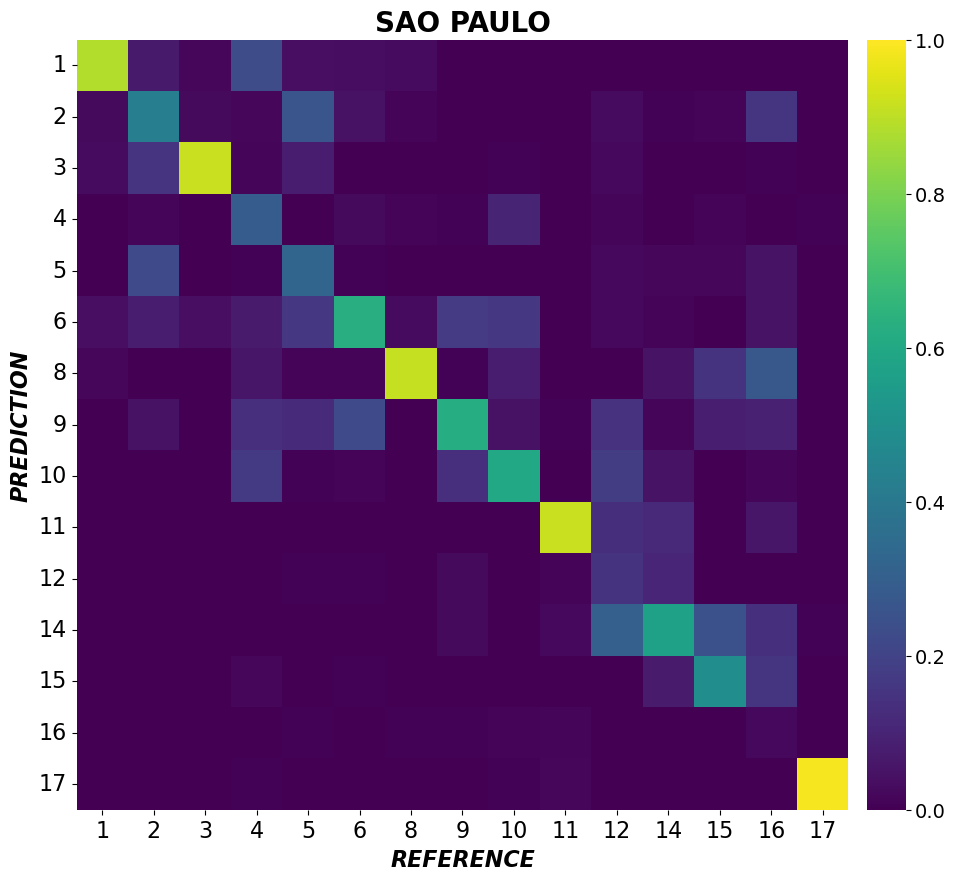

In [122]:
total_cm = None
for fold in results[best_setup][best_strategy]:
    fold_cm = results[best_setup][best_strategy][fold]["Confusion_Matrix"]
    if total_cm is None:
        total_cm = fold_cm.copy()
    else:
        total_cm += fold_cm

# Row Normalize
row_sums = total_cm.sum(axis=1)[:, np.newaxis]
norm_cm = total_cm.astype('float') / (row_sums + 1e-10)

plot_matrix = norm_cm.T 

plt.figure(figsize=(12, 10))
ordered_labels = sorted(splited_ref_data['gridcode'].unique())
ax = sns.heatmap(plot_matrix, 
            annot=False, 
            fmt='.2f', 
            cmap='viridis', 
            vmin=0.0,
            vmax=1.0,
            xticklabels=ordered_labels, 
            yticklabels=ordered_labels,
            cbar_kws={'pad': 0.02})
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=14)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16, rotation=0)
plt.xlabel('REFERENCE', fontsize=16, fontweight='bold', fontstyle='italic')
plt.ylabel('PREDICTION', fontsize=16, fontweight='bold', fontstyle='italic')        
plt.title('SAO PAULO', fontweight='bold', fontsize=20)
plt.show()

In [127]:
# save the summed matrix
np.save(r"results\s3\saopaulo_S3_summed_cm.npy", total_cm)

## Prediction

In [133]:
# which set was better?
better_set = weighted_set

# output
output = r'outputs\s3\saopaulo_S3.tif'

In [134]:
# get best model of the best set and stategy
best_run = df.loc[best_setup, best_strategy]
best_fold = (best_run['wF1'] + best_run['F1U']).idxmax()
best_model = best_run.loc[best_fold, 'Model']
best_run[["wF1", "F1U", "F1N", "OA"]].loc[best_fold]

wF1    89.48
F1U    85.66
F1N    92.56
OA     87.00
Name: 4, dtype: float64

In [135]:
# run prediction
with rio.open(better_set) as image_data:
    image_meta = image_data.meta
    image = image_data.read()

image_reshaped = rio.plot.reshape_as_image(image)
scene = image_reshaped.reshape(-1, image_reshaped.shape[-1])
scene[np.isinf(scene)] = np.nan
y_pred = best_model.predict(scene)
classified_image = y_pred.reshape(image_reshaped.shape[0], image_reshaped.shape[1])
classification_meta = image_meta.copy()
classification_meta.update({"count": 1})
with rio.open(output, "w", **classification_meta) as dest:
    dest.write(classified_image, indexes=1)